# Structured and time series data

This notebook contains an implementation of the third place result in the Rossman Kaggle competition as detailed in Guo/Berkhahn's [Entity Embeddings of Categorical Variables](https://arxiv.org/abs/1604.06737).

The motivation behind exploring this architecture is it's relevance to real-world application. Most data used for decision making day-to-day in industry is structured and/or time-series data. Here we explore the end-to-end process of using neural networks with practical structured data problems.

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.structured import *
from fastai.column_data import *
np.set_printoptions(threshold=50, edgeitems=20)

PATH='data/rossman/'

## Create datasets

In addition to the provided data, we will be using external datasets put together by participants in the Kaggle competition. You can download all of them [here](http://files.fast.ai/part2/lesson14/rossmann.tgz).

For completeness, the implementation used to put them together is included below.

In [3]:
def concat_csvs(dirname):
    path = f'{PATH}{dirname}'
    filenames=glob.glob(f"{path}/*.csv")

    wrote_header = False
    with open(f"{path}.csv","w") as outputfile:
        for filename in filenames:
            name = filename.split(".")[0]
            with open(filename) as f:
                line = f.readline()
                if not wrote_header:
                    wrote_header = True
                    outputfile.write("file,"+line)
                for line in f:
                     outputfile.write(name + "," + line)
                outputfile.write("\n")

In [4]:
# concat_csvs('googletrend')
# concat_csvs('weather')

Feature Space:
* train: Training set provided by competition
* store: List of stores
* store_states: mapping of store to the German state they are in
* List of German state names
* googletrend: trend of certain google keywords over time, found by users to correlate well w/ given data
* weather: weather
* test: testing set

In [5]:
table_names = ['train', 'store', 'store_states', 'state_names', 
               'googletrend', 'weather', 'test']

We'll be using the popular data manipulation framework `pandas`. Among other things, pandas allows you to manipulate tables/data frames in python as one would in a database.

We're going to go ahead and load all of our csv's as dataframes into the list `tables`.

In [6]:
tables = [pd.read_csv(f'{PATH}{fname}.csv', low_memory=False) for fname in table_names]

In [7]:
from IPython.display import HTML

We can use `head()` to get a quick look at the contents of each table:
* train: Contains store information on a daily basis, tracks things like sales, customers, whether that day was a holdiay, etc.
* store: general info about the store including competition, etc.
* store_states: maps store to state it is in
* state_names: Maps state abbreviations to names
* googletrend: trend data for particular week/state
* weather: weather conditions for each state
* test: Same as training table, w/o sales and customers


In [8]:
for t in tables: display(t.head())

Store  DayOfWeek        Date  Sales  Customers  Open  Promo StateHoliday  \
0      1          5  2015-07-31   5263        555     1      1            0   
1      2          5  2015-07-31   6064        625     1      1            0   
2      3          5  2015-07-31   8314        821     1      1            0   
3      4          5  2015-07-31  13995       1498     1      1            0   
4      5          5  2015-07-31   4822        559     1      1            0   

   SchoolHoliday  
0              1  
1              1  
2              1  
3              1  
4              1

Store StoreType Assortment  CompetitionDistance  CompetitionOpenSinceMonth  \
0      1         c          a               1270.0                        9.0   
1      2         a          a                570.0                       11.0   
2      3         a          a              14130.0                       12.0   
3      4         c          c                620.0                        9.0   
4      5         a          a              29910.0                        4.0   

   CompetitionOpenSinceYear  Promo2  Promo2SinceWeek  Promo2SinceYear  \
0                    2008.0       0              NaN              NaN   
1                    2007.0       1             13.0           2010.0   
2                    2006.0       1             14.0           2011.0   
3                    2009.0       0              NaN              NaN   
4                    2015.0       0              NaN              NaN   

     PromoInterval  
0              NaN  
1  Jan,Apr,Jul,Oct  
2  Jan,Apr,Jul,Oct  
3              NaN  
4              NaN

Store State
0      1    HE
1      2    TH
2      3    NW
3      4    BE
4      5    SN

StateName State
0  BadenWuerttemberg    BW
1             Bayern    BY
2             Berlin    BE
3        Brandenburg    BB
4             Bremen    HB

file                     week  trend
0  Rossmann_DE_SN  2012-12-02 - 2012-12-08     96
1  Rossmann_DE_SN  2012-12-09 - 2012-12-15     95
2  Rossmann_DE_SN  2012-12-16 - 2012-12-22     91
3  Rossmann_DE_SN  2012-12-23 - 2012-12-29     48
4  Rossmann_DE_SN  2012-12-30 - 2013-01-05     67

file        Date  Max_TemperatureC  Mean_TemperatureC  \
0  NordrheinWestfalen  2013-01-01                 8                  4   
1  NordrheinWestfalen  2013-01-02                 7                  4   
2  NordrheinWestfalen  2013-01-03                11                  8   
3  NordrheinWestfalen  2013-01-04                 9                  9   
4  NordrheinWestfalen  2013-01-05                 8                  8   

   Min_TemperatureC  Dew_PointC  MeanDew_PointC  Min_DewpointC  Max_Humidity  \
0                 2           7               5              1            94   
1                 1           5               3              2            93   
2                 6          10               8              4           100   
3                 8           9               9              8           100   
4                 7           8               7              6           100   

   Mean_Humidity       ...        Max_VisibilityKm  Mean_VisibilityKm  \
0             87       ...                    31.0               12.0   
1             85       ...                    31.0               14.0   
2             93       ...                    31.0                8.0   
3             94       ...                    11.0                5.0   
4             94       ...                    10.0                6.0   

   Min_VisibilitykM  Max_Wind_SpeedKm_h  Mean_Wind_SpeedKm_h  \
0               4.0                  39                   26   
1              10.0                  24                   16   
2               2.0                  26                   21   
3               2.0                  23                   14   
4               3.0                  16                   10   

   Max_Gust_SpeedKm_h  Precipitationmm  CloudCover  Events  WindDirDegrees  
0                58.0             5.08         6.0    Rain             215  
1                 NaN             0.00         6.0    Rain             225  
2                 NaN             1.02         7.0    Rain             240  
3                 NaN             0.25         7.0    Rain             263  
4                 NaN             0.00         7.0    Rain             268  

[5 rows x 24 columns]

Id  Store  DayOfWeek        Date  Open  Promo StateHoliday  SchoolHoliday
0   1      1          4  2015-09-17   1.0      1            0              0
1   2      3          4  2015-09-17   1.0      1            0              0
2   3      7          4  2015-09-17   1.0      1            0              0
3   4      8          4  2015-09-17   1.0      1            0              0
4   5      9          4  2015-09-17   1.0      1            0              0

This is very representative of a typical industry dataset.

The following returns summarized aggregate information to each table accross each field.

In [9]:
for t in tables: display(DataFrameSummary(t).summary())

Store    DayOfWeek         Date        Sales    Customers  \
count         1.01721e+06  1.01721e+06          NaN  1.01721e+06  1.01721e+06   
mean               558.43      3.99834          NaN      5773.82      633.146   
std               321.909      1.99739          NaN      3849.93      464.412   
min                     1            1          NaN            0            0   
25%                   280            2          NaN         3727          405   
50%                   558            4          NaN         5744          609   
75%                   838            6          NaN         7856          837   
max                  1115            7          NaN        41551         7388   
counts            1017209      1017209      1017209      1017209      1017209   
uniques              1115            7          942        21734         4086   
missing                 0            0            0            0            0   
missing_perc           0%           0%           0%           0%           0%   
types             numeric      numeric  categorical      numeric      numeric   

                     Open        Promo StateHoliday SchoolHoliday  
count         1.01721e+06  1.01721e+06          NaN   1.01721e+06  
mean             0.830107     0.381515          NaN      0.178647  
std              0.375539     0.485759          NaN      0.383056  
min                     0            0          NaN             0  
25%                     1            0          NaN             0  
50%                     1            0          NaN             0  
75%                     1            1          NaN             0  
max                     1            1          NaN             1  
counts            1017209      1017209      1017209       1017209  
uniques                 2            2            4             2  
missing                 0            0            0             0  
missing_perc           0%           0%           0%            0%  
types                bool         bool  categorical          bool

Store    StoreType   Assortment CompetitionDistance  \
count            1115          NaN          NaN                1112   
mean              558          NaN          NaN              5404.9   
std           322.017          NaN          NaN             7663.17   
min                 1          NaN          NaN                  20   
25%             279.5          NaN          NaN               717.5   
50%               558          NaN          NaN                2325   
75%             836.5          NaN          NaN              6882.5   
max              1115          NaN          NaN               75860   
counts           1115         1115         1115                1112   
uniques          1115            4            3                 654   
missing             0            0            0                   3   
missing_perc       0%           0%           0%               0.27%   
types         numeric  categorical  categorical             numeric   

             CompetitionOpenSinceMonth CompetitionOpenSinceYear    Promo2  \
count                              761                      761      1115   
mean                            7.2247                  2008.67  0.512108   
std                            3.21235                  6.19598  0.500078   
min                                  1                     1900         0   
25%                                  4                     2006         0   
50%                                  8                     2010         1   
75%                                 10                     2013         1   
max                                 12                     2015         1   
counts                             761                      761      1115   
uniques                             12                       23         2   
missing                            354                      354         0   
missing_perc                    31.75%                   31.75%        0%   
types                          numeric                  numeric      bool   

             Promo2SinceWeek Promo2SinceYear PromoInterval  
count                    571             571           NaN  
mean                 23.5954         2011.76           NaN  
std                   14.142         1.67494           NaN  
min                        1            2009           NaN  
25%                       13            2011           NaN  
50%                       22            2012           NaN  
75%                       37            2013           NaN  
max                       50            2015           NaN  
counts                   571             571           571  
uniques                   24               7             3  
missing                  544             544           544  
missing_perc          48.79%          48.79%        48.79%  
types                numeric         numeric   categorical

Store        State
count            1115          NaN
mean              558          NaN
std           322.017          NaN
min                 1          NaN
25%             279.5          NaN
50%               558          NaN
75%             836.5          NaN
max              1115          NaN
counts           1115         1115
uniques          1115           12
missing             0            0
missing_perc       0%           0%
types         numeric  categorical

StateName   State
count               16      16
unique              16      16
top             Hessen      HE
freq                 1       1
counts              16      16
uniques             16      16
missing              0       0
missing_perc        0%      0%
types           unique  unique

file         week    trend
count                 NaN          NaN     2072
mean                  NaN          NaN  63.8142
std                   NaN          NaN  12.6502
min                   NaN          NaN        0
25%                   NaN          NaN       55
50%                   NaN          NaN       64
75%                   NaN          NaN       72
max                   NaN          NaN      100
counts               2072         2072     2072
uniques                14          148       68
missing                 0            0        0
missing_perc           0%           0%       0%
types         categorical  categorical  numeric

file         Date Max_TemperatureC Mean_TemperatureC  \
count                 NaN          NaN            15840             15840   
mean                  NaN          NaN          14.6441            10.389   
std                   NaN          NaN          8.64601           7.37926   
min                   NaN          NaN              -11               -13   
25%                   NaN          NaN                8                 4   
50%                   NaN          NaN               15                11   
75%                   NaN          NaN               21                16   
max                   NaN          NaN               39                31   
counts              15840        15840            15840             15840   
uniques                16          990               51                45   
missing                 0            0                0                 0   
missing_perc           0%           0%               0%                0%   
types         categorical  categorical          numeric           numeric   

             Min_TemperatureC Dew_PointC MeanDew_PointC Min_DewpointC  \
count                   15840      15840          15840         15840   
mean                  6.19899    8.58782        6.20581       3.62614   
std                   6.52639    6.24478        6.08677       6.12839   
min                       -15        -14            -15           -73   
25%                         1          4              2            -1   
50%                         7          9              7             4   
75%                        11         13             11             8   
max                        24         25             20            19   
counts                  15840      15840          15840         15840   
uniques                    40         40             36            40   
missing                     0          0              0             0   
missing_perc               0%         0%             0%            0%   
types                 numeric    numeric        numeric       numeric   

             Max_Humidity Mean_Humidity      ...       Max_VisibilityKm  \
count               15840         15840      ...                  15459   
mean              93.6596       74.2829      ...                24.0576   
std               7.67853       13.4866      ...                 8.9768   
min                    44            30      ...                      0   
25%                 90.75            65      ...                     14   
50%                    94            76      ...                     31   
75%                   100            85      ...                     31   
max                   100           100      ...                     31   
counts              15840         15840      ...                  15459   
uniques                53            71      ...                     24   
missing                 0             0      ...                    381   
missing_perc           0%            0%      ...                  2.41%   
types             numeric       numeric      ...                numeric   

             Mean_VisibilityKm Min_VisibilitykM Max_Wind_SpeedKm_h  \
count                    15459            15459              15840   
mean                   12.2398          7.02516            22.7666   
std                    5.06794           4.9806            8.98862   
min                          0                0                  3   
25%                         10                3                 16   
50%                         11                7                 21   
75%                         14               10                 27   
max                         31               31                101   
counts                   15459            15459              15840   
uniques                     32               24                 44   
missing                    381              381                  0   
missing_perc             2.4

Id    Store DayOfWeek         Date      Open     Promo  \
count           41088    41088     41088          NaN     41077     41088   
mean          20544.5    555.9   3.97917          NaN  0.854322  0.395833   
std           11861.2  320.274   2.01548          NaN  0.352787  0.489035   
min                 1        1         1          NaN         0         0   
25%           10272.8   279.75         2          NaN         1         0   
50%           20544.5    553.5         4          NaN         1         0   
75%           30816.2   832.25         6          NaN         1         1   
max             41088     1115         7          NaN         1         1   
counts          41088    41088     41088        41088     41077     41088   
uniques         41088      856         7           48         2         2   
missing             0        0         0            0        11         0   
missing_perc       0%       0%        0%           0%     0.03%        0%   
types         numeric  numeric   numeric  categorical      bool      bool   

             StateHoliday SchoolHoliday  
count                 NaN         41088  
mean                  NaN      0.443487  
std                   NaN      0.496802  
min                   NaN             0  
25%                   NaN             0  
50%                   NaN             0  
75%                   NaN             1  
max                   NaN             1  
counts              41088         41088  
uniques                 2             2  
missing                 0             0  
missing_perc           0%            0%  
types                bool          bool

## Data Cleaning / Feature Engineering

As a structured data problem, we necessarily have to go through all the cleaning and feature engineering, even though we're using a neural network.

In [10]:
train, store, store_states, state_names, googletrend, weather, test = tables

In [11]:
len(train),len(test)

(1017209, 41088)

We turn state Holidays to booleans, to make them more convenient for modeling. We can do calculations on pandas fields using notation very similar (often identical) to numpy.

In [12]:
train.StateHoliday = train.StateHoliday!='0'
test.StateHoliday = test.StateHoliday!='0'

`join_df` is a function for joining tables on specific fields. By default, we'll be doing a left outer join of `right` on the `left` argument using the given fields for each table.

Pandas does joins using the `merge` method. The `suffixes` argument describes the naming convention for duplicate fields. We've elected to leave the duplicate field names on the left untouched, and append a "\_y" to those on the right.

In [13]:
def join_df(left, right, left_on, right_on=None, suffix='_y'):
    if right_on is None: right_on = left_on
    return left.merge(right, how='left', left_on=left_on, right_on=right_on, 
                      suffixes=("", suffix))

Join weather/state names.

In [14]:
weather = join_df(weather, state_names, "file", "StateName")

In pandas you can add new columns to a dataframe by simply defining it. We'll do this for googletrends by extracting dates and state names from the given data and adding those columns.

We're also going to replace all instances of state name 'NI' to match the usage in the rest of the data: 'HB,NI'. This is a good opportunity to highlight pandas indexing. We can use `.loc[rows, cols]` to select a list of rows and a list of columns from the dataframe. In this case, we're selecting rows w/ statename 'NI' by using a boolean list `googletrend.State=='NI'` and selecting "State".

In [15]:
googletrend['Date'] = googletrend.week.str.split(' - ', expand=True)[0]
googletrend['State'] = googletrend.file.str.split('_', expand=True)[2]

In [16]:
googletrend.loc[googletrend.State=='NI', "State"] = 'HB,NI'

The following extracts particular date fields from a complete datetime for the purpose of constructing categoricals.

You should *always* consider this feature extraction step when working with date-time. Without expanding your date-time into these additional fields, you can't capture any trend/cyclical behavior as a function of time at any of these granularities. We'll add to every table with a date field.

In [17]:
add_datepart(weather, "Date", drop=False)
add_datepart(googletrend, "Date", drop=False)
add_datepart(train, "Date", drop=False)
add_datepart(test, "Date", drop=False)
#add_datepart(googletrend, "Date", drop=False)

The Google trends data has a special category for the whole of the US - we'll pull that out so we can use it explicitly.

In [18]:
trend_de = googletrend[googletrend.file == 'Rossmann_DE']

Now we can outer join all of our data into a single dataframe. Recall that in outer joins everytime a value in the joining field on the left table does not have a corresponding value on the right table, the corresponding row in the new table has Null values for all right table fields. One way to check that all records are consistent and complete is to check for Null values post-join, as we do here.

*Aside*: Why note just do an inner join?
If you are assuming that all records are complete and match on the field you desire, an inner join will do the same thing as an outer join. However, in the event you are wrong or a mistake is made, an outer join followed by a null-check will catch it. (Comparing before/after # of rows for inner join is equivalent, but requires keeping track of before/after row #'s. Outer join is easier.)

In [19]:
store = join_df(store, store_states, "Store")
len(store[store.State.isnull()])

0

In [20]:
joined = join_df(train, store, "Store")
joined_test = join_df(test, store, "Store")
len(joined[joined.StoreType.isnull()]),len(joined_test[joined_test.StoreType.isnull()])

(0, 0)

In [21]:
joined = join_df(joined, googletrend, ["State","Year", "Week"])
joined_test = join_df(joined_test, googletrend, ["State","Year", "Week"])
len(joined[joined.trend.isnull()]),len(joined_test[joined_test.trend.isnull()])

(0, 0)

In [22]:
joined = joined.merge(trend_de, 'left', ["Year", "Week"], suffixes=('', '_DE'))
joined_test = joined_test.merge(trend_de, 'left', ["Year", "Week"], suffixes=('', '_DE'))
len(joined[joined.trend_DE.isnull()]),len(joined_test[joined_test.trend_DE.isnull()])

(0, 0)

In [23]:
joined = join_df(joined, weather, ["State","Date"])
joined_test = join_df(joined_test, weather, ["State","Date"])
len(joined[joined.Mean_TemperatureC.isnull()]),len(joined_test[joined_test.Mean_TemperatureC.isnull()])

(0, 0)

In [24]:
for df in (joined, joined_test):
    for c in df.columns:
        if c.endswith('_y'):
            if c in df.columns: df.drop(c, inplace=True, axis=1)

Next we'll fill in missing values to avoid complications with `NA`'s. `NA` (not available) is how Pandas indicates missing values; many models have problems when missing values are present, so it's always important to think about how to deal with them. In these cases, we are picking an arbitrary *signal value* that doesn't otherwise appear in the data.

In [25]:
for df in (joined,joined_test):
    df['CompetitionOpenSinceYear'] = df.CompetitionOpenSinceYear.fillna(1900).astype(np.int32)
    df['CompetitionOpenSinceMonth'] = df.CompetitionOpenSinceMonth.fillna(1).astype(np.int32)
    df['Promo2SinceYear'] = df.Promo2SinceYear.fillna(1900).astype(np.int32)
    df['Promo2SinceWeek'] = df.Promo2SinceWeek.fillna(1).astype(np.int32)

Next we'll extract features "CompetitionOpenSince" and "CompetitionDaysOpen". Note the use of `apply()` in mapping a function across dataframe values.

In [26]:
for df in (joined,joined_test):
    df["CompetitionOpenSince"] = pd.to_datetime(dict(year=df.CompetitionOpenSinceYear, 
                                                     month=df.CompetitionOpenSinceMonth, day=15))
    df["CompetitionDaysOpen"] = df.Date.subtract(df.CompetitionOpenSince).dt.days

We'll replace some erroneous / outlying data.

In [27]:
for df in (joined,joined_test):
    df.loc[df.CompetitionDaysOpen<0, "CompetitionDaysOpen"] = 0
    df.loc[df.CompetitionOpenSinceYear<1990, "CompetitionDaysOpen"] = 0

We add "CompetitionMonthsOpen" field, limiting the maximum to 2 years to limit number of unique categories.

In [28]:
for df in (joined,joined_test):
    df["CompetitionMonthsOpen"] = df["CompetitionDaysOpen"]//30
    df.loc[df.CompetitionMonthsOpen>24, "CompetitionMonthsOpen"] = 24
joined.CompetitionMonthsOpen.unique()

array([24,  3, 19,  9,  0, 16, 17,  7, 15, 22, 11, 13,  2, 23, 12,  4, 10,  1, 14, 20,  8, 18,  6, 21,  5])

Same process for Promo dates.

In [29]:
for df in (joined,joined_test):
    df["Promo2Since"] = pd.to_datetime(df.apply(lambda x: Week(x.Promo2SinceYear, x.Promo2SinceWeek).monday(), 
                                                axis=1).astype(pd.datetime))
    df["Promo2Days"] = df.Date.subtract(df["Promo2Since"]).dt.days

In [30]:
for df in (joined,joined_test):
    df.loc[df.Promo2Days<0, "Promo2Days"] = 0
    df.loc[df.Promo2SinceYear<1990, "Promo2Days"] = 0
    df["Promo2Weeks"] = df["Promo2Days"]//7
    df.loc[df.Promo2Weeks<0, "Promo2Weeks"] = 0
    df.loc[df.Promo2Weeks>25, "Promo2Weeks"] = 25
    df.Promo2Weeks.unique()

In [31]:
joined.to_feather(f'{PATH}joined')
joined_test.to_feather(f'{PATH}joined_test')

## Durations

It is common when working with time series data to extract data that explains relationships across rows as opposed to columns, e.g.:
* Running averages
* Time until next event
* Time since last event

This is often difficult to do with most table manipulation frameworks, since they are designed to work with relationships across columns. As such, we've created a class to handle this type of data.

We'll define a function `get_elapsed` for cumulative counting across a sorted dataframe. Given a particular field `fld` to monitor, this function will start tracking time since the last occurrence of that field. When the field is seen again, the counter is set to zero.

Upon initialization, this will result in datetime na's until the field is encountered. This is reset every time a new store is seen. We'll see how to use this shortly.

In [43]:
def get_elapsed(df, fld, pre):
    day1 = np.timedelta64(1, 'D')
    last_date = np.datetime64()
    last_store = 0
    res = []

    for s,v,d in zip(df.Store.values, df[fld].values, df.Date.values):
        if s != last_store:
            last_date = np.datetime64()
            last_store = s
        if v: last_date = d
        res.append(((d-last_date).astype('timedelta64[D]') / day1).astype(int))
    df[pre+fld] = res

We'll be applying this to a subset of columns:

In [44]:
columns = ["Date", "Store", "Promo", "StateHoliday", "SchoolHoliday"]

In [45]:
df1 = train[columns]

In [46]:
df2 = test[columns]

Let's walk through an example.

Say we're looking at School Holiday. We'll first sort by Store, then Date, and then call `add_elapsed('SchoolHoliday', 'After')`:
This will apply to each row with School Holiday:
* A applied to every row of the dataframe in order of store and date
* Will add to the dataframe the days since seeing a School Holiday
* If we sort in the other direction, this will count the days until another holiday.

In [47]:
fld = 'SchoolHoliday'
df1 = df1.sort_values(['Store', 'Date'])
get_elapsed(df1, fld, 'After')
df1 = df1.sort_values(['Store', 'Date'], ascending=[True, False])
get_elapsed(df1, fld, 'Before')

In [48]:
fld = 'SchoolHoliday'
df2 = df2.sort_values(['Store', 'Date'])
get_elapsed(df2, fld, 'After')
df2 = df2.sort_values(['Store', 'Date'], ascending=[True, False])
get_elapsed(df2, fld, 'Before')

We'll do this for two more fields.

In [49]:
fld = 'StateHoliday'
df1 = df1.sort_values(['Store', 'Date'])
get_elapsed(df1, fld, 'After')
df1 = df1.sort_values(['Store', 'Date'], ascending=[True, False])
get_elapsed(df1, fld, 'Before')

In [50]:
fld = 'StateHoliday'
df2 = df2.sort_values(['Store', 'Date'])
get_elapsed(df2, fld, 'After')
df2 = df2.sort_values(['Store', 'Date'], ascending=[True, False])
get_elapsed(df2, fld, 'Before')

In [51]:
fld = 'Promo'
df1 = df1.sort_values(['Store', 'Date'])
get_elapsed(df1, fld, 'After')
df1 = df1.sort_values(['Store', 'Date'], ascending=[True, False])
get_elapsed(df1, fld, 'Before')

In [52]:
fld = 'Promo'
df2 = df2.sort_values(['Store', 'Date'])
get_elapsed(df2, fld, 'After')
df2 = df2.sort_values(['Store', 'Date'], ascending=[True, False])
get_elapsed(df2, fld, 'Before')

We're going to set the active index to Date.

In [53]:
df1 = df1.set_index("Date")

In [54]:
df2 = df2.set_index("Date")

Then set null values from elapsed field calculations to 0.

In [55]:
columns = ['SchoolHoliday', 'StateHoliday', 'Promo']

In [56]:
for o in ['Before', 'After']:
    for p in columns:
        a = o+p
        df1[a] = df1[a].fillna(0)
        df2[a] = df2[a].fillna(0)

Next we'll demonstrate window functions in pandas to calculate rolling quantities.

Here we're sorting by date (`sort_index()`) and counting the number of events of interest (`sum()`) defined in `columns` in the following week (`rolling()`), grouped by Store (`groupby()`). We do the same in the opposite direction.

In [57]:
bwd1 = df1[['Store']+columns].sort_index().groupby("Store").rolling(7, min_periods=1).sum()

In [58]:
bwd2 = df2[['Store']+columns].sort_index().groupby("Store").rolling(7, min_periods=1).sum()

In [59]:
fwd1 = df1[['Store']+columns].sort_index(ascending=False
                                      ).groupby("Store").rolling(7, min_periods=1).sum()

In [60]:
fwd2 = df2[['Store']+columns].sort_index(ascending=False
                                      ).groupby("Store").rolling(7, min_periods=1).sum()

Next we want to drop the Store indices grouped together in the window function.

Often in pandas, there is an option to do this in place. This is time and memory efficient when working with large datasets.

In [61]:
bwd1.drop('Store',1,inplace=True)
bwd1.reset_index(inplace=True)

In [62]:
bwd2.drop('Store',1,inplace=True)
bwd2.reset_index(inplace=True)

In [63]:
fwd1.drop('Store',1,inplace=True)
fwd1.reset_index(inplace=True)

In [64]:
fwd2.drop('Store',1,inplace=True)
fwd2.reset_index(inplace=True)

In [65]:
df1.reset_index(inplace=True)
df2.reset_index(inplace=True)

Now we'll merge these values onto the df.

In [66]:
df1 = df1.merge(bwd1, 'left', ['Date', 'Store'], suffixes=['', '_bw'])
df1 = df1.merge(fwd1, 'left', ['Date', 'Store'], suffixes=['', '_fw'])

In [67]:
df2 = df2.merge(bwd2, 'left', ['Date', 'Store'], suffixes=['', '_bw'])
df2 = df2.merge(fwd2, 'left', ['Date', 'Store'], suffixes=['', '_fw'])

In [68]:
df1.drop(columns,1,inplace=True)
df2.drop(columns,1,inplace=True)

In [69]:
df1.head()

Date  Store  AfterSchoolHoliday  BeforeSchoolHoliday  \
0 2015-07-31      1                   0                    0   
1 2015-07-30      1                   0                    0   
2 2015-07-29      1                   0                    0   
3 2015-07-28      1                   0                    0   
4 2015-07-27      1                   0                    0   

   AfterStateHoliday   BeforeStateHoliday  AfterPromo  BeforePromo  \
0                 57 -9223372036854775808           0            0   
1                 56 -9223372036854775808           0            0   
2                 55 -9223372036854775808           0            0   
3                 54 -9223372036854775808           0            0   
4                 53 -9223372036854775808           0            0   

   SchoolHoliday_bw  StateHoliday_bw  Promo_bw  SchoolHoliday_fw  \
0               5.0              0.0       5.0               1.0   
1               4.0              0.0       4.0               2.0   
2               3.0              0.0       3.0               3.0   
3               2.0              0.0       2.0               4.0   
4               1.0              0.0       1.0               5.0   

   StateHoliday_fw  Promo_fw  
0              0.0       1.0  
1              0.0       2.0  
2              0.0       3.0  
3              0.0       4.0  
4              0.0       5.0

In [70]:
df2.head()

Date  Store  AfterSchoolHoliday  BeforeSchoolHoliday  \
0 2015-09-17      1                  13 -9223372036854775808   
1 2015-09-16      1                  12 -9223372036854775808   
2 2015-09-15      1                  11 -9223372036854775808   
3 2015-09-14      1                  10 -9223372036854775808   
4 2015-09-13      1                   9 -9223372036854775808   

     AfterStateHoliday   BeforeStateHoliday  AfterPromo  BeforePromo  \
0 -9223372036854775808 -9223372036854775808           0            0   
1 -9223372036854775808 -9223372036854775808           0            0   
2 -9223372036854775808 -9223372036854775808           0            0   
3 -9223372036854775808 -9223372036854775808           0            0   
4 -9223372036854775808 -9223372036854775808           9           -1   

   SchoolHoliday_bw  StateHoliday_bw  Promo_bw  SchoolHoliday_fw  \
0               0.0              0.0       4.0               0.0   
1               0.0              0.0       3.0               0.0   
2               0.0              0.0       2.0               0.0   
3               0.0              0.0       1.0               0.0   
4               0.0              0.0       0.0               0.0   

   StateHoliday_fw  Promo_fw  
0              0.0       1.0  
1              0.0       2.0  
2              0.0       3.0  
3              0.0       4.0  
4              0.0       4.0

It's usually a good idea to back up large tables of extracted / wrangled features before you join them onto another one, that way you can go back to it easily if you need to make changes to it.

In [71]:
df1.to_feather(f'{PATH}df1')
df2.to_feather(f'{PATH}df2')

In [72]:
df1 = pd.read_feather(f'{PATH}df1')
df2 = pd.read_feather(f'{PATH}df2')

In [73]:
df1["Date"] = pd.to_datetime(df1.Date)
df2["Date"] = pd.to_datetime(df2.Date)

In [74]:
joined = join_df(joined, df1, ['Store', 'Date'])

In [75]:
joined_test = join_df(joined_test, df2, ['Store', 'Date'])

The authors also removed all instances where the store had zero sale / was closed. We speculate that this may have cost them a higher standing in the competition. One reason this may be the case is that a little exploratory data analysis reveals that there are often periods where stores are closed, typically for refurbishment. Before and after these periods, there are naturally spikes in sales that one might expect. By ommitting this data from their training, the authors gave up the ability to leverage information about these periods to predict this otherwise volatile behavior.

In [76]:
joined = joined[joined.Sales!=0]

We'll back this up as well.

In [77]:
joined.reset_index(inplace=True)
joined_test.reset_index(inplace=True)

In [78]:
joined.to_feather(f'{PATH}joined')
joined_test.to_feather(f'{PATH}joined_test')

We now have our final set of engineered features.

While these steps were explicitly outlined in the paper, these are all fairly typical feature engineering steps for dealing with time series data and are practical in any similar setting.

## Create features

In [174]:
joined = pd.read_feather(f'{PATH}joined')
joined_test = pd.read_feather(f'{PATH}joined_test')

In [175]:
joined.head().T.head(40)

0                        1  \
index                                            0                        1   
Store                                            1                        2   
DayOfWeek                                        5                        5   
Date                           2015-07-31 00:00:00      2015-07-31 00:00:00   
Sales                                         5263                     6064   
Customers                                      555                      625   
Open                                             1                        1   
Promo                                            1                        1   
StateHoliday                                 False                    False   
SchoolHoliday                                    1                        1   
Year                                          2015                     2015   
Month                                            7                        7   
Week                                            31                       31   
Day                                             31                       31   
Dayofweek                                        4                        4   
Dayofyear                                      212                      212   
Is_month_end                                  True                     True   
Is_month_start                               False                    False   
Is_quarter_end                               False                    False   
Is_quarter_start                             False                    False   
Is_year_end                                  False                    False   
Is_year_start                                False                    False   
Elapsed                                 1438300800               1438300800   
StoreType                                        c                        a   
Assortment                                       a                        a   
CompetitionDistance                           1270                      570   
CompetitionOpenSinceMonth                        9                       11   
CompetitionOpenSinceYear                      2008                     2007   
Promo2                                           0                        1   
Promo2SinceWeek                                  1                       13   
Promo2SinceYear                               1900                     2010   
PromoInterval                                 None          Jan,Apr,Jul,Oct   
State                                           HE                       TH   
file                                Rossmann_DE_HE           Rossmann_DE_TH   
week                       2015-08-02 - 2015-08-08  2015-08-02 - 2015-08-08   
trend                                           85                       80   
file_DE                                Rossmann_DE              Rossmann_DE   
week_DE                    2015-08-02 - 2015-08-08  2015-08-02 - 2015-08-08   
trend_DE                                        83                       83   
Date_DE                        2015-08-02 00:00:00      2015-08-02 00:00:00   

                                                 2                        3  \
index                                            2                        3   
Store                                            3                        4   
DayOfWeek                                        5                        5   
Date                           2015-07-31 00:00:00      2015-07-31 00:00:00   
Sales                                         8314                    13995   
Customers                                      821                     1498   
Open                                             1                        1   
Promo                                            1                        1   
StateHoliday                                 False                    False   
SchoolHoliday      

Now that we've engineered all our features, we need to convert to input compatible with a neural network.

This includes converting categorical variables into contiguous integers or one-hot encodings, normalizing continuous features to standard normal, etc...

In [176]:
cat_vars = ['Store', 'DayOfWeek', 'Year', 'Month', 'Day', 'StateHoliday', 'CompetitionMonthsOpen',
    'Promo2Weeks', 'StoreType', 'Assortment', 'PromoInterval', 'CompetitionOpenSinceYear', 'Promo2SinceYear',
    'State', 'Week', 'Events', 'Promo_fw', 'Promo_bw', 'StateHoliday_fw', 'StateHoliday_bw',
    'SchoolHoliday_fw', 'SchoolHoliday_bw']

contin_vars = ['CompetitionDistance', 'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC',
   'Max_Humidity', 'Mean_Humidity', 'Min_Humidity', 'Max_Wind_SpeedKm_h', 
   'Mean_Wind_SpeedKm_h', 'CloudCover', 'trend', 'trend_DE',
   'AfterStateHoliday', 'BeforeStateHoliday', 'Promo', 'SchoolHoliday']

n = len(joined); n

844338

In [177]:
dep = 'Sales'
joined_test[dep] = 0
joined = joined[cat_vars+contin_vars+[dep, 'Date']].copy()
joined_test = joined_test[cat_vars+contin_vars+[dep, 'Date', 'Id']].copy()

In [178]:
for v in cat_vars: joined[v] = joined[v].astype('category').cat.as_ordered()

In [179]:
apply_cats(joined_test, joined)

In [180]:
for v in contin_vars:
    joined[v] = joined[v].astype('float32')
    joined_test[v] = joined_test[v].astype('float32')

We're going to run on a sample.

In [181]:
idxs = get_cv_idxs(n, val_pct=150000/n)
joined_samp = joined.iloc[idxs].set_index("Date")
samp_size = len(joined_samp); samp_size

150000

To run on the full dataset, use this instead:

In [182]:
samp_size = n
joined_samp = joined.set_index("Date")

We can now process our data...

In [183]:
joined_samp.head(2)

Store DayOfWeek  Year Month Day StateHoliday CompetitionMonthsOpen  \
Date                                                                            
2015-07-31     1         5  2015     7  31        False                    24   
2015-07-31     2         5  2015     7  31        False                    24   

           Promo2Weeks StoreType Assortment  ...  Max_Wind_SpeedKm_h  \
Date                                         ...                       
2015-07-31           0         c          a  ...                24.0   
2015-07-31          25         a          a  ...                14.0   

           Mean_Wind_SpeedKm_h CloudCover trend trend_DE AfterStateHoliday  \
Date                                                                         
2015-07-31                11.0        1.0  85.0     83.0              57.0   
2015-07-31                11.0        4.0  80.0     83.0              67.0   

           BeforeStateHoliday Promo SchoolHoliday Sales  
Date                                                     
2015-07-31      -9.223372e+18   1.0           1.0  5263  
2015-07-31      -9.223372e+18   1.0           1.0  6064  

[2 rows x 39 columns]

In [184]:
df, y, nas, mapper = proc_df(joined_samp, 'Sales', do_scale=True)
yl = np.log(y)

In [185]:
joined_test = joined_test.set_index("Date")

In [186]:
df_test, _, nas, mapper = proc_df(joined_test, 'Sales', do_scale=True, skip_flds=['Id'], mapper=mapper, na_dict=nas)

In [187]:
df.head(2)

Store  DayOfWeek  Year  Month  Day  StateHoliday  \
Date                                                           
2015-07-31      1          5     3      7   31             1   
2015-07-31      2          5     3      7   31             1   

            CompetitionMonthsOpen  Promo2Weeks  StoreType  Assortment  \
Date                                                                    
2015-07-31                     25            1          3           1   
2015-07-31                     25           26          1           1   

                ...        Mean_Wind_SpeedKm_h  CloudCover     trend  \
Date            ...                                                    
2015-07-31      ...                  -0.142774   -2.805667  1.732492   
2015-07-31      ...                  -0.142774   -0.961766  1.294578   

            trend_DE  AfterStateHoliday  BeforeStateHoliday     Promo  \
Date                                                                    
2015-07-31  1.724334                0.0                -0.0  1.113717   
2015-07-31  1.724334                0.0                -0.0  1.113717   

            SchoolHoliday  CompetitionDistance_na  CloudCover_na  
Date                                                              
2015-07-31        2.04105               -0.050948       -0.29609  
2015-07-31        2.04105               -0.050948       -0.29609  

[2 rows x 40 columns]

In time series data, cross-validation is not random. Instead, our holdout data is generally the most recent data, as it would be in real application. This issue is discussed in detail in [this post](http://www.fast.ai/2017/11/13/validation-sets/) on our web site.

One approach is to take the last 25% of rows (sorted by date) as our validation set.

In [188]:
train_ratio = 0.75
train_size = int(samp_size * train_ratio); train_size

633253

In [189]:
val_idx = list(range(train_size, len(df)))

An even better option for picking a validation set is using the exact same length of time period as the test set uses - this is implemented here:

In [160]:
val_idx = np.flatnonzero(
    (df.index<=datetime.datetime(2014,9,17)) & (df.index>=datetime.datetime(2014,8,1)))

In [161]:
val_idx=[0]

## DL

We're ready to put together our models.

Root-mean-squared percent error is the metric Kaggle used for this competition.

In [190]:
def inv_y(a): return np.exp(a)

def exp_rmspe(y_pred, targ):
    targ = inv_y(targ)
    pct_var = (targ - inv_y(y_pred))/targ
    return math.sqrt((pct_var**2).mean())

max_log_y = np.max(yl)
y_range = (0, max_log_y*1.2)

We can create a ModelData object directly from out data frame.

In [191]:
md = ColumnarModelData.from_data_frame(PATH, val_idx, df, yl, cat_flds=cat_vars, bs=128, 
                                       test_df=df_test)

Some categorical variables have a lot more levels than others. Store, in particular, has over a thousand!

In [192]:
cat_sz = [(c, len(joined_samp[c].cat.categories)+1) for c in cat_vars]

In [193]:
cat_sz

[('Store', 1116),
 ('DayOfWeek', 8),
 ('Year', 4),
 ('Month', 13),
 ('Day', 32),
 ('StateHoliday', 3),
 ('CompetitionMonthsOpen', 26),
 ('Promo2Weeks', 27),
 ('StoreType', 5),
 ('Assortment', 4),
 ('PromoInterval', 4),
 ('CompetitionOpenSinceYear', 24),
 ('Promo2SinceYear', 9),
 ('State', 13),
 ('Week', 53),
 ('Events', 22),
 ('Promo_fw', 7),
 ('Promo_bw', 7),
 ('StateHoliday_fw', 4),
 ('StateHoliday_bw', 4),
 ('SchoolHoliday_fw', 9),
 ('SchoolHoliday_bw', 9)]

We use the *cardinality* of each variable (that is, its number of unique values) to decide how large to make its *embeddings*. Each level will be associated with a vector with length defined as below.

In [194]:
emb_szs = [(c, min(50, (c+1)//2)) for _,c in cat_sz]

In [195]:
emb_szs

[(1116, 50),
 (8, 4),
 (4, 2),
 (13, 7),
 (32, 16),
 (3, 2),
 (26, 13),
 (27, 14),
 (5, 3),
 (4, 2),
 (4, 2),
 (24, 12),
 (9, 5),
 (13, 7),
 (53, 27),
 (22, 11),
 (7, 4),
 (7, 4),
 (4, 2),
 (4, 2),
 (9, 5),
 (9, 5)]

In [196]:
m = md.get_learner(emb_szs, len(df.columns)-len(cat_vars),
                   0.04, 1, [1000,500], [0.001,0.01], y_range=y_range)
lr = 1e-3

In [197]:
m.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))



  0%|          | 0/4948 [00:00<?, ?it/s]

  0%|          | 0/4948 [00:00<?, ?it/s, loss=8.06]

  0%|          | 1/4948 [00:00<36:20,  2.27it/s, loss=8.06]

  0%|          | 1/4948 [00:00<38:58,  2.12it/s, loss=8.27]

  0%|          | 1/4948 [00:00<41:46,  1.97it/s, loss=7.83]

  0%|          | 1/4948 [00:00<44:24,  1.86it/s, loss=7.65]

  0%|          | 4/4948 [00:00<11:10,  7.37it/s, loss=7.65]

  0%|          | 4/4948 [00:00<11:51,  6.95it/s, loss=7.51]

  0%|          | 4/4948 [00:00<12:33,  6.57it/s, loss=7.34]

  0%|          | 4/4948 [00:00<13:20,  6.18it/s, loss=7.1] 

  0%|          | 7/4948 [00:00<07:38, 10.77it/s, loss=7.1]

  0%|          | 7/4948 [00:00<08:02, 10.25it/s, loss=6.96]

  0%|          | 7/4948 [00:00<08:27,  9.73it/s, loss=6.75]

  0%|          | 7/4948 [00:00<08:51,  9.30it/s, loss=6.63]

  0%|          | 10/4948 [00:00<06:13, 13.21it/s, loss=6.63]

  0%|          | 10/4948 [00:00<06:31, 12.60it/s, loss=6.53]

  0%|          | 10/4948 [00:00<06:48, 12.09it/s

  2%|▏         | 89/4948 [00:03<03:24, 23.78it/s, loss=1.28]

  2%|▏         | 89/4948 [00:03<03:26, 23.56it/s, loss=1.26]

  2%|▏         | 92/4948 [00:03<03:19, 24.34it/s, loss=1.26]

  2%|▏         | 92/4948 [00:03<03:21, 24.13it/s, loss=1.24]

  2%|▏         | 92/4948 [00:03<03:23, 23.92it/s, loss=1.22]

  2%|▏         | 92/4948 [00:03<03:24, 23.70it/s, loss=1.2] 

  2%|▏         | 95/4948 [00:03<03:18, 24.44it/s, loss=1.2]

  2%|▏         | 95/4948 [00:03<03:20, 24.24it/s, loss=1.19]

  2%|▏         | 95/4948 [00:03<03:21, 24.03it/s, loss=1.17]

  2%|▏         | 95/4948 [00:03<03:23, 23.80it/s, loss=1.15]

  2%|▏         | 98/4948 [00:03<03:17, 24.53it/s, loss=1.15]

  2%|▏         | 98/4948 [00:04<03:19, 24.31it/s, loss=1.14]

  2%|▏         | 98/4948 [00:04<03:21, 24.08it/s, loss=1.12]

  2%|▏         | 98/4948 [00:04<03:23, 23.88it/s, loss=1.1] 

  2%|▏         | 101/4948 [00:04<03:17, 24.60it/s, loss=1.1]

  2%|▏         | 101/4948 [00:04<03:18, 24.40it/s, loss=1.09]

  2%|▏  

Exception in thread Thread-67:
Traceback (most recent call last):
  File "/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration





  2%|▏         | 123/4948 [00:04<03:15, 24.69it/s, loss=0.808]

  3%|▎         | 126/4948 [00:04<03:10, 25.26it/s, loss=0.808]

  3%|▎         | 126/4948 [00:05<03:12, 25.08it/s, loss=0.799]

  3%|▎         | 126/4948 [00:05<03:13, 24.91it/s, loss=0.791]

  3%|▎         | 126/4948 [00:05<03:14, 24.74it/s, loss=0.78] 

  3%|▎         | 129/4948 [00:05<03:10, 25.32it/s, loss=0.78]

  3%|▎         | 129/4948 [00:05<03:11, 25.14it/s, loss=0.772]

  3%|▎         | 129/4948 [00:05<03:13, 24.96it/s, loss=0.764]

  3%|▎         | 129/4948 [00:05<03:14, 24.79it/s, loss=0.756]

  3%|▎         | 132/4948 [00:05<03:09, 25.35it/s, loss=0.756]

  3%|▎         | 132/4948 [00:05<03:11, 25.18it/s, loss=0.751]

  3%|▎         | 132/4948 [00:05<03:12, 25.01it/s, loss=0.744]

  3%|▎         | 132/4948 [00:05<03:13, 24.84it/s, loss=0.737]

  3%|▎         | 135/4948 [00:05<03:09, 25.38it/s, loss=0.737]

  3%|▎         | 135/4948 [00:05<03:10, 25.21it/s, loss=0.73] 

  3%|▎         | 135/4948 [00:05<03:12,

  4%|▍         | 214/4948 [00:07<02:51, 27.52it/s, loss=0.422]

  4%|▍         | 214/4948 [00:07<02:52, 27.49it/s, loss=0.419]

  4%|▍         | 214/4948 [00:07<02:52, 27.45it/s, loss=0.418]

  4%|▍         | 214/4948 [00:07<02:52, 27.41it/s, loss=0.416]

  4%|▍         | 214/4948 [00:07<02:52, 27.37it/s, loss=0.416]

  4%|▍         | 214/4948 [00:07<02:53, 27.33it/s, loss=0.414]

  4%|▍         | 214/4948 [00:07<02:53, 27.28it/s, loss=0.411]

  5%|▍         | 223/4948 [00:07<02:46, 28.42it/s, loss=0.411]

  5%|▍         | 223/4948 [00:07<02:46, 28.38it/s, loss=0.409]

  5%|▍         | 223/4948 [00:07<02:46, 28.35it/s, loss=0.409]

  5%|▍         | 223/4948 [00:07<02:46, 28.31it/s, loss=0.405]

  5%|▍         | 223/4948 [00:07<02:47, 28.27it/s, loss=0.403]

  5%|▍         | 223/4948 [00:07<02:47, 28.23it/s, loss=0.4]  

  5%|▍         | 223/4948 [00:07<02:47, 28.19it/s, loss=0.398]

  5%|▍         | 223/4948 [00:07<02:47, 28.15it/s, loss=0.396]

  5%|▍         | 223/4948 [00:07<02:48, 

  7%|▋         | 322/4948 [00:09<02:09, 35.78it/s, loss=0.301]

  7%|▋         | 322/4948 [00:09<02:09, 35.74it/s, loss=0.299]

  7%|▋         | 322/4948 [00:09<02:09, 35.70it/s, loss=0.299]

  7%|▋         | 322/4948 [00:09<02:09, 35.65it/s, loss=0.3]  

  7%|▋         | 322/4948 [00:09<02:09, 35.61it/s, loss=0.299]

  7%|▋         | 322/4948 [00:09<02:10, 35.56it/s, loss=0.298]

  7%|▋         | 322/4948 [00:09<02:10, 35.52it/s, loss=0.298]

  7%|▋         | 322/4948 [00:09<02:10, 35.48it/s, loss=0.298]

  7%|▋         | 322/4948 [00:09<02:10, 35.43it/s, loss=0.296]

  7%|▋         | 322/4948 [00:09<02:10, 35.38it/s, loss=0.295]

  7%|▋         | 331/4948 [00:09<02:06, 36.36it/s, loss=0.295]

  7%|▋         | 331/4948 [00:09<02:07, 36.32it/s, loss=0.295]

  7%|▋         | 331/4948 [00:09<02:07, 36.28it/s, loss=0.294]

  7%|▋         | 331/4948 [00:09<02:07, 36.23it/s, loss=0.294]

  7%|▋         | 331/4948 [00:09<02:07, 36.19it/s, loss=0.292]

  7%|▋         | 331/4948 [00:09<02:07, 

  9%|▊         | 421/4948 [00:10<01:49, 41.16it/s, loss=0.244]

  9%|▊         | 421/4948 [00:10<01:50, 41.11it/s, loss=0.244]

  9%|▊         | 421/4948 [00:10<01:50, 41.06it/s, loss=0.244]

  9%|▊         | 430/4948 [00:10<01:47, 41.93it/s, loss=0.244]

  9%|▊         | 430/4948 [00:10<01:47, 41.89it/s, loss=0.243]

  9%|▊         | 430/4948 [00:10<01:47, 41.84it/s, loss=0.244]

  9%|▊         | 430/4948 [00:10<01:48, 41.80it/s, loss=0.244]

  9%|▊         | 430/4948 [00:10<01:48, 41.75it/s, loss=0.245]

  9%|▊         | 430/4948 [00:10<01:48, 41.70it/s, loss=0.244]

  9%|▊         | 430/4948 [00:10<01:48, 41.66it/s, loss=0.243]

  9%|▊         | 430/4948 [00:10<01:48, 41.61it/s, loss=0.243]

  9%|▊         | 430/4948 [00:10<01:48, 41.57it/s, loss=0.243]

  9%|▊         | 430/4948 [00:10<01:48, 41.51it/s, loss=0.242]

  9%|▉         | 439/4948 [00:10<01:46, 42.37it/s, loss=0.242]

  9%|▉         | 439/4948 [00:10<01:46, 42.33it/s, loss=0.242]

  9%|▉         | 439/4948 [00:10<01:46, 

 11%|█         | 529/4948 [00:11<01:35, 46.20it/s, loss=0.217]

 11%|█         | 529/4948 [00:11<01:35, 46.16it/s, loss=0.216]

 11%|█         | 529/4948 [00:11<01:35, 46.11it/s, loss=0.216]

 11%|█         | 529/4948 [00:11<01:35, 46.06it/s, loss=0.216]

 11%|█         | 529/4948 [00:11<01:36, 46.02it/s, loss=0.216]

 11%|█         | 529/4948 [00:11<01:36, 45.96it/s, loss=0.216]

 11%|█         | 538/4948 [00:11<01:34, 46.74it/s, loss=0.216]

 11%|█         | 538/4948 [00:11<01:34, 46.69it/s, loss=0.216]

 11%|█         | 538/4948 [00:11<01:34, 46.64it/s, loss=0.216]

 11%|█         | 538/4948 [00:11<01:34, 46.60it/s, loss=0.217]

 11%|█         | 538/4948 [00:11<01:34, 46.56it/s, loss=0.216]

 11%|█         | 538/4948 [00:11<01:34, 46.51it/s, loss=0.216]

 11%|█         | 538/4948 [00:11<01:34, 46.47it/s, loss=0.215]

 11%|█         | 538/4948 [00:11<01:34, 46.42it/s, loss=0.216]

 11%|█         | 538/4948 [00:11<01:35, 46.38it/s, loss=0.216]

 11%|█         | 538/4948 [00:11<01:35, 

 13%|█▎        | 637/4948 [00:12<01:25, 50.26it/s, loss=0.188]

 13%|█▎        | 637/4948 [00:12<01:25, 50.22it/s, loss=0.188]

 13%|█▎        | 637/4948 [00:12<01:25, 50.18it/s, loss=0.187]

 13%|█▎        | 637/4948 [00:12<01:25, 50.13it/s, loss=0.188]

 13%|█▎        | 637/4948 [00:12<01:26, 50.09it/s, loss=0.188]

 13%|█▎        | 637/4948 [00:12<01:26, 50.04it/s, loss=0.187]

 13%|█▎        | 637/4948 [00:12<01:26, 50.00it/s, loss=0.187]

 13%|█▎        | 637/4948 [00:12<01:26, 49.95it/s, loss=0.186]

 13%|█▎        | 637/4948 [00:12<01:26, 49.90it/s, loss=0.186]

 13%|█▎        | 646/4948 [00:12<01:25, 50.60it/s, loss=0.186]

 13%|█▎        | 646/4948 [00:12<01:25, 50.55it/s, loss=0.186]

 13%|█▎        | 646/4948 [00:12<01:25, 50.51it/s, loss=0.185]

 13%|█▎        | 646/4948 [00:12<01:25, 50.46it/s, loss=0.185]

 13%|█▎        | 646/4948 [00:12<01:25, 50.42it/s, loss=0.185]

 13%|█▎        | 646/4948 [00:12<01:25, 50.38it/s, loss=0.184]

 13%|█▎        | 646/4948 [00:12<01:25, 

 15%|█▍        | 736/4948 [00:13<01:19, 52.94it/s, loss=0.168]

 15%|█▍        | 736/4948 [00:13<01:19, 52.89it/s, loss=0.168]

 15%|█▌        | 745/4948 [00:13<01:18, 53.53it/s, loss=0.168]

 15%|█▌        | 745/4948 [00:13<01:18, 53.49it/s, loss=0.168]

 15%|█▌        | 745/4948 [00:13<01:18, 53.45it/s, loss=0.168]

 15%|█▌        | 745/4948 [00:13<01:18, 53.40it/s, loss=0.167]

 15%|█▌        | 745/4948 [00:13<01:18, 53.36it/s, loss=0.167]

 15%|█▌        | 745/4948 [00:13<01:18, 53.31it/s, loss=0.166]

 15%|█▌        | 745/4948 [00:13<01:18, 53.27it/s, loss=0.167]

 15%|█▌        | 745/4948 [00:13<01:18, 53.23it/s, loss=0.167]

 15%|█▌        | 745/4948 [00:14<01:19, 53.18it/s, loss=0.168]

 15%|█▌        | 745/4948 [00:14<01:19, 53.14it/s, loss=0.167]

 15%|█▌        | 754/4948 [00:14<01:17, 53.77it/s, loss=0.167]

 15%|█▌        | 754/4948 [00:14<01:18, 53.72it/s, loss=0.167]

 15%|█▌        | 754/4948 [00:14<01:18, 53.67it/s, loss=0.167]

 15%|█▌        | 754/4948 [00:14<01:18, 

 17%|█▋        | 845/4948 [00:15<01:13, 55.71it/s, loss=0.147]

 17%|█▋        | 845/4948 [00:15<01:13, 55.67it/s, loss=0.146]

 17%|█▋        | 845/4948 [00:15<01:13, 55.62it/s, loss=0.146]

 17%|█▋        | 845/4948 [00:15<01:13, 55.58it/s, loss=0.145]

 17%|█▋        | 845/4948 [00:15<01:13, 55.53it/s, loss=0.146]

 17%|█▋        | 845/4948 [00:15<01:13, 55.48it/s, loss=0.146]

 17%|█▋        | 854/4948 [00:15<01:13, 56.07it/s, loss=0.146]

 17%|█▋        | 854/4948 [00:15<01:13, 56.02it/s, loss=0.146]

 17%|█▋        | 854/4948 [00:15<01:13, 55.98it/s, loss=0.146]

 17%|█▋        | 854/4948 [00:15<01:13, 55.94it/s, loss=0.146]

 17%|█▋        | 854/4948 [00:15<01:13, 55.90it/s, loss=0.146]

 17%|█▋        | 854/4948 [00:15<01:13, 55.86it/s, loss=0.146]

 17%|█▋        | 854/4948 [00:15<01:13, 55.81it/s, loss=0.146]

 17%|█▋        | 854/4948 [00:15<01:13, 55.77it/s, loss=0.147]

 17%|█▋        | 854/4948 [00:15<01:13, 55.71it/s, loss=0.146]

 17%|█▋        | 854/4948 [00:15<01:13, 

 19%|█▉        | 953/4948 [00:16<01:08, 57.99it/s, loss=0.123]

 19%|█▉        | 953/4948 [00:16<01:08, 57.94it/s, loss=0.123]

 19%|█▉        | 953/4948 [00:16<01:08, 57.90it/s, loss=0.122]

 19%|█▉        | 953/4948 [00:16<01:09, 57.86it/s, loss=0.122]

 19%|█▉        | 953/4948 [00:16<01:09, 57.82it/s, loss=0.123]

 19%|█▉        | 953/4948 [00:16<01:09, 57.78it/s, loss=0.123]

 19%|█▉        | 953/4948 [00:16<01:09, 57.74it/s, loss=0.127]

 19%|█▉        | 953/4948 [00:16<01:09, 57.69it/s, loss=0.127]

 19%|█▉        | 953/4948 [00:16<01:09, 57.65it/s, loss=0.126]

 19%|█▉        | 962/4948 [00:16<01:08, 58.19it/s, loss=0.126]

 19%|█▉        | 962/4948 [00:16<01:08, 58.15it/s, loss=0.126]

 19%|█▉        | 962/4948 [00:16<01:08, 58.10it/s, loss=0.125]

 19%|█▉        | 962/4948 [00:16<01:08, 58.06it/s, loss=0.125]

 19%|█▉        | 962/4948 [00:16<01:08, 58.02it/s, loss=0.124]

 19%|█▉        | 962/4948 [00:16<01:08, 57.98it/s, loss=0.124]

 19%|█▉        | 962/4948 [00:16<01:08, 

 21%|██▏       | 1052/4948 [00:17<01:05, 59.38it/s, loss=0.0898]

 21%|██▏       | 1052/4948 [00:17<01:05, 59.34it/s, loss=0.0895]

 21%|██▏       | 1052/4948 [00:17<01:05, 59.29it/s, loss=0.0891]

 21%|██▏       | 1052/4948 [00:17<01:05, 59.25it/s, loss=0.0886]

 21%|██▏       | 1061/4948 [00:17<01:05, 59.75it/s, loss=0.0886]

 21%|██▏       | 1061/4948 [00:17<01:05, 59.71it/s, loss=0.0883]

 21%|██▏       | 1061/4948 [00:17<01:05, 59.67it/s, loss=0.0885]

 21%|██▏       | 1061/4948 [00:17<01:05, 59.63it/s, loss=0.0878]

 21%|██▏       | 1061/4948 [00:17<01:05, 59.59it/s, loss=0.0876]

 21%|██▏       | 1061/4948 [00:17<01:05, 59.55it/s, loss=0.0872]

 21%|██▏       | 1061/4948 [00:17<01:05, 59.51it/s, loss=0.0868]

 21%|██▏       | 1061/4948 [00:17<01:05, 59.47it/s, loss=0.0866]

 21%|██▏       | 1061/4948 [00:17<01:05, 59.43it/s, loss=0.086] 

 21%|██▏       | 1061/4948 [00:17<01:05, 59.38it/s, loss=0.0856]

 22%|██▏       | 1070/4948 [00:17<01:04, 59.88it/s, loss=0.0856]

 22%|██▏  

 23%|██▎       | 1151/4948 [00:18<01:02, 60.75it/s, loss=0.0682]

 23%|██▎       | 1160/4948 [00:18<01:01, 61.22it/s, loss=0.0682]

 23%|██▎       | 1160/4948 [00:18<01:01, 61.18it/s, loss=0.0681]

 23%|██▎       | 1160/4948 [00:18<01:01, 61.15it/s, loss=0.0679]

 23%|██▎       | 1160/4948 [00:18<01:01, 61.11it/s, loss=0.0676]

 23%|██▎       | 1160/4948 [00:18<01:02, 61.08it/s, loss=0.0679]

 23%|██▎       | 1160/4948 [00:19<01:02, 61.04it/s, loss=0.0679]

 23%|██▎       | 1160/4948 [00:19<01:02, 61.01it/s, loss=0.0677]

 23%|██▎       | 1160/4948 [00:19<01:02, 60.97it/s, loss=0.0674]

 23%|██▎       | 1160/4948 [00:19<01:02, 60.94it/s, loss=0.0675]

 23%|██▎       | 1160/4948 [00:19<01:02, 60.89it/s, loss=0.0674]

 24%|██▎       | 1169/4948 [00:19<01:01, 61.35it/s, loss=0.0674]

 24%|██▎       | 1169/4948 [00:19<01:01, 61.32it/s, loss=0.0674]

 24%|██▎       | 1169/4948 [00:19<01:01, 61.28it/s, loss=0.0677]

 24%|██▎       | 1169/4948 [00:19<01:01, 61.25it/s, loss=0.0673]

 24%|██▎  

 25%|██▌       | 1259/4948 [00:20<00:59, 62.46it/s, loss=0.0614]

 25%|██▌       | 1259/4948 [00:20<00:59, 62.43it/s, loss=0.0614]

 25%|██▌       | 1259/4948 [00:20<00:59, 62.39it/s, loss=0.0612]

 25%|██▌       | 1259/4948 [00:20<00:59, 62.35it/s, loss=0.0609]

 25%|██▌       | 1259/4948 [00:20<00:59, 62.31it/s, loss=0.0609]

 25%|██▌       | 1259/4948 [00:20<00:59, 62.27it/s, loss=0.0608]

 25%|██▌       | 1259/4948 [00:20<00:59, 62.23it/s, loss=0.0608]

 25%|██▌       | 1259/4948 [00:20<00:59, 62.19it/s, loss=0.0607]

 26%|██▌       | 1268/4948 [00:20<00:58, 62.63it/s, loss=0.0607]

 26%|██▌       | 1268/4948 [00:20<00:58, 62.59it/s, loss=0.0607]

 26%|██▌       | 1268/4948 [00:20<00:58, 62.55it/s, loss=0.0608]

 26%|██▌       | 1268/4948 [00:20<00:58, 62.52it/s, loss=0.0608]

 26%|██▌       | 1268/4948 [00:20<00:58, 62.48it/s, loss=0.0608]

 26%|██▌       | 1268/4948 [00:20<00:58, 62.44it/s, loss=0.0606]

 26%|██▌       | 1268/4948 [00:20<00:58, 62.40it/s, loss=0.0612]

 26%|██▌  

 27%|██▋       | 1358/4948 [00:21<00:56, 63.38it/s, loss=0.0529]

 27%|██▋       | 1358/4948 [00:21<00:56, 63.34it/s, loss=0.0529]

 27%|██▋       | 1358/4948 [00:21<00:56, 63.30it/s, loss=0.0526]

 27%|██▋       | 1358/4948 [00:21<00:56, 63.26it/s, loss=0.0526]

 27%|██▋       | 1358/4948 [00:21<00:56, 63.23it/s, loss=0.0531]

 28%|██▊       | 1367/4948 [00:21<00:56, 63.64it/s, loss=0.0531]

 28%|██▊       | 1367/4948 [00:21<00:56, 63.61it/s, loss=0.0529]

 28%|██▊       | 1367/4948 [00:21<00:56, 63.57it/s, loss=0.0529]

 28%|██▊       | 1367/4948 [00:21<00:56, 63.54it/s, loss=0.0531]

 28%|██▊       | 1367/4948 [00:21<00:56, 63.50it/s, loss=0.0531]

 28%|██▊       | 1367/4948 [00:21<00:56, 63.46it/s, loss=0.0529]

 28%|██▊       | 1367/4948 [00:21<00:56, 63.43it/s, loss=0.0528]

 28%|██▊       | 1367/4948 [00:21<00:56, 63.39it/s, loss=0.0528]

 28%|██▊       | 1367/4948 [00:21<00:56, 63.35it/s, loss=0.0527]

 28%|██▊       | 1367/4948 [00:21<00:56, 63.32it/s, loss=0.0526]

 28%|██▊  

 30%|██▉       | 1461/4948 [00:22<00:54, 64.31it/s, loss=0.0543]

 30%|██▉       | 1461/4948 [00:22<00:54, 64.27it/s, loss=0.0541]

 30%|██▉       | 1461/4948 [00:22<00:54, 64.24it/s, loss=0.0539]

 30%|██▉       | 1461/4948 [00:22<00:54, 64.20it/s, loss=0.0537]

 30%|██▉       | 1461/4948 [00:22<00:54, 64.17it/s, loss=0.0536]

 30%|██▉       | 1461/4948 [00:22<00:54, 64.13it/s, loss=0.054] 

 30%|██▉       | 1469/4948 [00:22<00:53, 64.47it/s, loss=0.054]

 30%|██▉       | 1469/4948 [00:22<00:53, 64.44it/s, loss=0.0541]

 30%|██▉       | 1469/4948 [00:22<00:54, 64.40it/s, loss=0.0543]

 30%|██▉       | 1469/4948 [00:22<00:54, 64.37it/s, loss=0.054] 

 30%|██▉       | 1469/4948 [00:22<00:54, 64.33it/s, loss=0.0541]

 30%|██▉       | 1469/4948 [00:22<00:54, 64.30it/s, loss=0.0543]

 30%|██▉       | 1469/4948 [00:22<00:54, 64.26it/s, loss=0.0546]

 30%|██▉       | 1469/4948 [00:22<00:54, 64.23it/s, loss=0.0547]

 30%|██▉       | 1469/4948 [00:22<00:54, 64.18it/s, loss=0.0549]

 30%|██▉   

 31%|███▏      | 1558/4948 [00:24<00:52, 64.86it/s, loss=0.0517]

 31%|███▏      | 1558/4948 [00:24<00:52, 64.84it/s, loss=0.0516]

 31%|███▏      | 1558/4948 [00:24<00:52, 64.80it/s, loss=0.0514]

 32%|███▏      | 1567/4948 [00:24<00:51, 65.17it/s, loss=0.0514]

 32%|███▏      | 1567/4948 [00:24<00:51, 65.14it/s, loss=0.0514]

 32%|███▏      | 1567/4948 [00:24<00:51, 65.11it/s, loss=0.0516]

 32%|███▏      | 1567/4948 [00:24<00:51, 65.07it/s, loss=0.0516]

 32%|███▏      | 1567/4948 [00:24<00:51, 65.04it/s, loss=0.0516]

 32%|███▏      | 1567/4948 [00:24<00:52, 65.00it/s, loss=0.0514]

 32%|███▏      | 1567/4948 [00:24<00:52, 64.97it/s, loss=0.0516]

 32%|███▏      | 1567/4948 [00:24<00:52, 64.94it/s, loss=0.0517]

 32%|███▏      | 1567/4948 [00:24<00:52, 64.90it/s, loss=0.0516]

 32%|███▏      | 1575/4948 [00:24<00:51, 65.23it/s, loss=0.0516]

 32%|███▏      | 1575/4948 [00:24<00:51, 65.19it/s, loss=0.0515]

 32%|███▏      | 1575/4948 [00:24<00:51, 65.16it/s, loss=0.0514]

 32%|███▏ 

 34%|███▎      | 1665/4948 [00:25<00:49, 65.78it/s, loss=0.0536]

 34%|███▎      | 1665/4948 [00:25<00:49, 65.75it/s, loss=0.0537]

 34%|███▎      | 1665/4948 [00:25<00:49, 65.72it/s, loss=0.0535]

 34%|███▎      | 1665/4948 [00:25<00:49, 65.68it/s, loss=0.0536]

 34%|███▎      | 1665/4948 [00:25<00:50, 65.65it/s, loss=0.0535]

 34%|███▎      | 1665/4948 [00:25<00:50, 65.62it/s, loss=0.0536]

 34%|███▎      | 1665/4948 [00:25<00:50, 65.58it/s, loss=0.0541]

 34%|███▎      | 1665/4948 [00:25<00:50, 65.55it/s, loss=0.0542]

 34%|███▎      | 1665/4948 [00:25<00:50, 65.52it/s, loss=0.0551]

 34%|███▍      | 1673/4948 [00:25<00:49, 65.83it/s, loss=0.0551]

 34%|███▍      | 1673/4948 [00:25<00:49, 65.79it/s, loss=0.0549]

 34%|███▍      | 1673/4948 [00:25<00:49, 65.76it/s, loss=0.055] 

 34%|███▍      | 1673/4948 [00:25<00:49, 65.73it/s, loss=0.0554]

 34%|███▍      | 1673/4948 [00:25<00:49, 65.70it/s, loss=0.055] 

 34%|███▍      | 1673/4948 [00:25<00:49, 65.67it/s, loss=0.0552]

 34%|███▍ 

 36%|███▌      | 1763/4948 [00:26<00:48, 66.24it/s, loss=0.0502]

 36%|███▌      | 1763/4948 [00:26<00:48, 66.21it/s, loss=0.0502]

 36%|███▌      | 1763/4948 [00:26<00:48, 66.18it/s, loss=0.0503]

 36%|███▌      | 1763/4948 [00:26<00:48, 66.15it/s, loss=0.0502]

 36%|███▌      | 1763/4948 [00:26<00:48, 66.11it/s, loss=0.0504]

 36%|███▌      | 1763/4948 [00:26<00:48, 66.08it/s, loss=0.0503]

 36%|███▌      | 1771/4948 [00:26<00:47, 66.37it/s, loss=0.0503]

 36%|███▌      | 1771/4948 [00:26<00:47, 66.34it/s, loss=0.0501]

 36%|███▌      | 1771/4948 [00:26<00:47, 66.31it/s, loss=0.0503]

 36%|███▌      | 1771/4948 [00:26<00:47, 66.28it/s, loss=0.0505]

 36%|███▌      | 1771/4948 [00:26<00:47, 66.25it/s, loss=0.0505]

 36%|███▌      | 1771/4948 [00:26<00:47, 66.22it/s, loss=0.0504]

 36%|███▌      | 1771/4948 [00:26<00:47, 66.19it/s, loss=0.0503]

 36%|███▌      | 1771/4948 [00:26<00:48, 66.16it/s, loss=0.0501]

 36%|███▌      | 1771/4948 [00:26<00:48, 66.12it/s, loss=0.05]  

 36%|███▌ 

 38%|███▊      | 1860/4948 [00:27<00:46, 66.67it/s, loss=0.0527]

 38%|███▊      | 1868/4948 [00:27<00:46, 66.96it/s, loss=0.0527]

 38%|███▊      | 1868/4948 [00:27<00:46, 66.93it/s, loss=0.0524]

 38%|███▊      | 1868/4948 [00:27<00:46, 66.90it/s, loss=0.0525]

 38%|███▊      | 1868/4948 [00:27<00:46, 66.87it/s, loss=0.0523]

 38%|███▊      | 1868/4948 [00:27<00:46, 66.84it/s, loss=0.0524]

 38%|███▊      | 1868/4948 [00:27<00:46, 66.81it/s, loss=0.0524]

 38%|███▊      | 1868/4948 [00:27<00:46, 66.77it/s, loss=0.0523]

 38%|███▊      | 1868/4948 [00:27<00:46, 66.74it/s, loss=0.0521]

 38%|███▊      | 1868/4948 [00:28<00:46, 66.71it/s, loss=0.052] 

 38%|███▊      | 1876/4948 [00:28<00:45, 66.99it/s, loss=0.052]

 38%|███▊      | 1876/4948 [00:28<00:45, 66.96it/s, loss=0.0517]

 38%|███▊      | 1876/4948 [00:28<00:45, 66.93it/s, loss=0.0515]

 38%|███▊      | 1876/4948 [00:28<00:45, 66.89it/s, loss=0.051] 

 38%|███▊      | 1876/4948 [00:28<00:45, 66.86it/s, loss=0.0505]

 38%|███▊  

 40%|███▉      | 1962/4948 [00:29<00:44, 67.26it/s, loss=0.0467]

 40%|███▉      | 1962/4948 [00:29<00:44, 67.23it/s, loss=0.0468]

 40%|███▉      | 1962/4948 [00:29<00:44, 67.20it/s, loss=0.0467]

 40%|███▉      | 1971/4948 [00:29<00:44, 67.51it/s, loss=0.0467]

 40%|███▉      | 1971/4948 [00:29<00:44, 67.48it/s, loss=0.0466]

 40%|███▉      | 1971/4948 [00:29<00:44, 67.45it/s, loss=0.0464]

 40%|███▉      | 1971/4948 [00:29<00:44, 67.42it/s, loss=0.046] 

 40%|███▉      | 1971/4948 [00:29<00:44, 67.40it/s, loss=0.0462]

 40%|███▉      | 1971/4948 [00:29<00:44, 67.37it/s, loss=0.0458]

 40%|███▉      | 1971/4948 [00:29<00:44, 67.34it/s, loss=0.0458]

 40%|███▉      | 1971/4948 [00:29<00:44, 67.31it/s, loss=0.0459]

 40%|███▉      | 1971/4948 [00:29<00:44, 67.29it/s, loss=0.0457]

 40%|███▉      | 1971/4948 [00:29<00:44, 67.26it/s, loss=0.0461]

 40%|████      | 1980/4948 [00:29<00:43, 67.56it/s, loss=0.0461]

 40%|████      | 1980/4948 [00:29<00:43, 67.54it/s, loss=0.046] 

 40%|████ 

 42%|████▏     | 2070/4948 [00:30<00:42, 68.11it/s, loss=0.037]

 42%|████▏     | 2070/4948 [00:30<00:42, 68.08it/s, loss=0.037]

 42%|████▏     | 2070/4948 [00:30<00:42, 68.05it/s, loss=0.0369]

 42%|████▏     | 2070/4948 [00:30<00:42, 68.02it/s, loss=0.0367]

 42%|████▏     | 2070/4948 [00:30<00:42, 68.00it/s, loss=0.0365]

 42%|████▏     | 2070/4948 [00:30<00:42, 67.97it/s, loss=0.0367]

 42%|████▏     | 2070/4948 [00:30<00:42, 67.94it/s, loss=0.0367]

 42%|████▏     | 2070/4948 [00:30<00:42, 67.90it/s, loss=0.0366]

 42%|████▏     | 2070/4948 [00:30<00:42, 67.87it/s, loss=0.0366]

 42%|████▏     | 2078/4948 [00:30<00:42, 68.13it/s, loss=0.0366]

 42%|████▏     | 2078/4948 [00:30<00:42, 68.11it/s, loss=0.0366]

 42%|████▏     | 2078/4948 [00:30<00:42, 68.08it/s, loss=0.0368]

 42%|████▏     | 2078/4948 [00:30<00:42, 68.05it/s, loss=0.0367]

 42%|████▏     | 2078/4948 [00:30<00:42, 68.02it/s, loss=0.0365]

 42%|████▏     | 2078/4948 [00:30<00:42, 68.00it/s, loss=0.0364]

 42%|████▏  

 44%|████▎     | 2163/4948 [00:31<00:40, 68.33it/s, loss=0.0358]

 44%|████▍     | 2172/4948 [00:31<00:40, 68.61it/s, loss=0.0358]

 44%|████▍     | 2172/4948 [00:31<00:40, 68.58it/s, loss=0.0357]

 44%|████▍     | 2172/4948 [00:31<00:40, 68.55it/s, loss=0.0356]

 44%|████▍     | 2172/4948 [00:31<00:40, 68.53it/s, loss=0.0356]

 44%|████▍     | 2172/4948 [00:31<00:40, 68.50it/s, loss=0.0355]

 44%|████▍     | 2172/4948 [00:31<00:40, 68.47it/s, loss=0.0353]

 44%|████▍     | 2172/4948 [00:31<00:40, 68.45it/s, loss=0.0354]

 44%|████▍     | 2172/4948 [00:31<00:40, 68.41it/s, loss=0.0353]

 44%|████▍     | 2172/4948 [00:31<00:40, 68.39it/s, loss=0.0355]

 44%|████▍     | 2172/4948 [00:31<00:40, 68.36it/s, loss=0.0356]

 44%|████▍     | 2181/4948 [00:31<00:40, 68.64it/s, loss=0.0356]

 44%|████▍     | 2181/4948 [00:31<00:40, 68.61it/s, loss=0.0355]

 44%|████▍     | 2181/4948 [00:31<00:40, 68.58it/s, loss=0.0355]

 44%|████▍     | 2181/4948 [00:31<00:40, 68.56it/s, loss=0.0354]

 44%|████▍

 46%|████▌     | 2270/4948 [00:32<00:38, 68.98it/s, loss=0.0371]

 46%|████▌     | 2270/4948 [00:32<00:38, 68.96it/s, loss=0.0371]

 46%|████▌     | 2270/4948 [00:32<00:38, 68.93it/s, loss=0.0369]

 46%|████▌     | 2270/4948 [00:32<00:38, 68.91it/s, loss=0.0369]

 46%|████▌     | 2270/4948 [00:32<00:38, 68.88it/s, loss=0.037] 

 46%|████▌     | 2270/4948 [00:32<00:38, 68.86it/s, loss=0.037]

 46%|████▌     | 2270/4948 [00:32<00:38, 68.83it/s, loss=0.0371]

 46%|████▌     | 2279/4948 [00:32<00:38, 69.10it/s, loss=0.0371]

 46%|████▌     | 2279/4948 [00:32<00:38, 69.07it/s, loss=0.0372]

 46%|████▌     | 2279/4948 [00:33<00:38, 69.05it/s, loss=0.037] 

 46%|████▌     | 2279/4948 [00:33<00:38, 69.03it/s, loss=0.0369]

 46%|████▌     | 2279/4948 [00:33<00:38, 69.00it/s, loss=0.0368]

 46%|████▌     | 2279/4948 [00:33<00:38, 68.98it/s, loss=0.0368]

 46%|████▌     | 2279/4948 [00:33<00:38, 68.95it/s, loss=0.0367]

 46%|████▌     | 2279/4948 [00:33<00:38, 68.93it/s, loss=0.0369]

 46%|████▌ 

 48%|████▊     | 2369/4948 [00:34<00:37, 69.36it/s, loss=0.0368]

 48%|████▊     | 2369/4948 [00:34<00:37, 69.34it/s, loss=0.0369]

 48%|████▊     | 2369/4948 [00:34<00:37, 69.31it/s, loss=0.037] 

 48%|████▊     | 2369/4948 [00:34<00:37, 69.28it/s, loss=0.0374]

 48%|████▊     | 2378/4948 [00:34<00:36, 69.54it/s, loss=0.0374]

 48%|████▊     | 2378/4948 [00:34<00:36, 69.52it/s, loss=0.0376]

 48%|████▊     | 2378/4948 [00:34<00:36, 69.50it/s, loss=0.0377]

 48%|████▊     | 2378/4948 [00:34<00:36, 69.47it/s, loss=0.0377]

 48%|████▊     | 2378/4948 [00:34<00:37, 69.45it/s, loss=0.0378]

 48%|████▊     | 2378/4948 [00:34<00:37, 69.42it/s, loss=0.0378]

 48%|████▊     | 2378/4948 [00:34<00:37, 69.40it/s, loss=0.0384]

 48%|████▊     | 2378/4948 [00:34<00:37, 69.37it/s, loss=0.0383]

 48%|████▊     | 2378/4948 [00:34<00:37, 69.35it/s, loss=0.0387]

 48%|████▊     | 2378/4948 [00:34<00:37, 69.32it/s, loss=0.0388]

 48%|████▊     | 2387/4948 [00:34<00:36, 69.58it/s, loss=0.0388]

 48%|████▊

 50%|████▉     | 2468/4948 [00:35<00:35, 69.68it/s, loss=0.0382]

 50%|█████     | 2477/4948 [00:35<00:35, 69.93it/s, loss=0.0382]

 50%|█████     | 2477/4948 [00:35<00:35, 69.90it/s, loss=0.0379]

 50%|█████     | 2477/4948 [00:35<00:35, 69.88it/s, loss=0.0382]

 50%|█████     | 2477/4948 [00:35<00:35, 69.85it/s, loss=0.0384]

 50%|█████     | 2477/4948 [00:35<00:35, 69.83it/s, loss=0.0383]

 50%|█████     | 2477/4948 [00:35<00:35, 69.81it/s, loss=0.0384]

 50%|█████     | 2477/4948 [00:35<00:35, 69.78it/s, loss=0.0382]

 50%|█████     | 2477/4948 [00:35<00:35, 69.75it/s, loss=0.0384]

 50%|█████     | 2477/4948 [00:35<00:35, 69.73it/s, loss=0.0384]

 50%|█████     | 2477/4948 [00:35<00:35, 69.71it/s, loss=0.0383]

 50%|█████     | 2486/4948 [00:35<00:35, 69.96it/s, loss=0.0383]

 50%|█████     | 2486/4948 [00:35<00:35, 69.93it/s, loss=0.0383]

 50%|█████     | 2486/4948 [00:35<00:35, 69.91it/s, loss=0.0384]

 50%|█████     | 2486/4948 [00:35<00:35, 69.88it/s, loss=0.0385]

 50%|█████

 52%|█████▏    | 2576/4948 [00:36<00:33, 70.36it/s, loss=0.0454]

 52%|█████▏    | 2576/4948 [00:36<00:33, 70.34it/s, loss=0.0453]

 52%|█████▏    | 2576/4948 [00:36<00:33, 70.31it/s, loss=0.0452]

 52%|█████▏    | 2576/4948 [00:36<00:33, 70.29it/s, loss=0.0451]

 52%|█████▏    | 2576/4948 [00:36<00:33, 70.27it/s, loss=0.0453]

 52%|█████▏    | 2576/4948 [00:36<00:33, 70.25it/s, loss=0.0452]

 52%|█████▏    | 2576/4948 [00:36<00:33, 70.23it/s, loss=0.0459]

 52%|█████▏    | 2576/4948 [00:36<00:33, 70.21it/s, loss=0.0458]

 52%|█████▏    | 2585/4948 [00:36<00:33, 70.45it/s, loss=0.0458]

 52%|█████▏    | 2585/4948 [00:36<00:33, 70.43it/s, loss=0.0457]

 52%|█████▏    | 2585/4948 [00:36<00:33, 70.41it/s, loss=0.0456]

 52%|█████▏    | 2585/4948 [00:36<00:33, 70.38it/s, loss=0.0455]

 52%|█████▏    | 2585/4948 [00:36<00:33, 70.36it/s, loss=0.0456]

 52%|█████▏    | 2585/4948 [00:36<00:33, 70.34it/s, loss=0.0453]

 52%|█████▏    | 2585/4948 [00:36<00:33, 70.32it/s, loss=0.0453]

 52%|█████

 54%|█████▍    | 2675/4948 [00:37<00:32, 70.77it/s, loss=0.0449]

 54%|█████▍    | 2675/4948 [00:37<00:32, 70.75it/s, loss=0.045] 

 54%|█████▍    | 2675/4948 [00:37<00:32, 70.73it/s, loss=0.0454]

 54%|█████▍    | 2675/4948 [00:37<00:32, 70.71it/s, loss=0.0452]

 54%|█████▍    | 2675/4948 [00:37<00:32, 70.68it/s, loss=0.0452]

 54%|█████▍    | 2684/4948 [00:37<00:31, 70.92it/s, loss=0.0452]

 54%|█████▍    | 2684/4948 [00:37<00:31, 70.90it/s, loss=0.0451]

 54%|█████▍    | 2684/4948 [00:37<00:31, 70.88it/s, loss=0.0451]

 54%|█████▍    | 2684/4948 [00:37<00:31, 70.86it/s, loss=0.0449]

 54%|█████▍    | 2684/4948 [00:37<00:31, 70.84it/s, loss=0.0453]

 54%|█████▍    | 2684/4948 [00:37<00:31, 70.81it/s, loss=0.0455]

 54%|█████▍    | 2684/4948 [00:37<00:31, 70.79it/s, loss=0.0455]

 54%|█████▍    | 2684/4948 [00:37<00:31, 70.77it/s, loss=0.0461]

 54%|█████▍    | 2684/4948 [00:37<00:31, 70.75it/s, loss=0.046] 

 54%|█████▍    | 2684/4948 [00:37<00:32, 70.73it/s, loss=0.0457]

 54%|█████

 56%|█████▌    | 2774/4948 [00:38<00:30, 71.16it/s, loss=0.0466]

 56%|█████▌    | 2774/4948 [00:38<00:30, 71.13it/s, loss=0.0466]

 56%|█████▌    | 2783/4948 [00:38<00:30, 71.36it/s, loss=0.0466]

 56%|█████▌    | 2783/4948 [00:39<00:30, 71.34it/s, loss=0.0464]

 56%|█████▌    | 2783/4948 [00:39<00:30, 71.32it/s, loss=0.0462]

 56%|█████▌    | 2783/4948 [00:39<00:30, 71.30it/s, loss=0.0459]

 56%|█████▌    | 2783/4948 [00:39<00:30, 71.28it/s, loss=0.0457]

 56%|█████▌    | 2783/4948 [00:39<00:30, 71.26it/s, loss=0.0454]

 56%|█████▌    | 2783/4948 [00:39<00:30, 71.24it/s, loss=0.0452]

 56%|█████▌    | 2783/4948 [00:39<00:30, 71.22it/s, loss=0.045] 

 56%|█████▌    | 2783/4948 [00:39<00:30, 71.20it/s, loss=0.0448]

 56%|█████▌    | 2783/4948 [00:39<00:30, 71.18it/s, loss=0.0451]

 56%|█████▋    | 2792/4948 [00:39<00:30, 71.40it/s, loss=0.0451]

 56%|█████▋    | 2792/4948 [00:39<00:30, 71.38it/s, loss=0.0448]

 56%|█████▋    | 2792/4948 [00:39<00:30, 71.36it/s, loss=0.0446]

 56%|█████

 58%|█████▊    | 2882/4948 [00:40<00:28, 71.64it/s, loss=0.0398]

 58%|█████▊    | 2882/4948 [00:40<00:28, 71.62it/s, loss=0.04]  

 58%|█████▊    | 2882/4948 [00:40<00:28, 71.60it/s, loss=0.0401]

 58%|█████▊    | 2882/4948 [00:40<00:28, 71.57it/s, loss=0.0403]

 58%|█████▊    | 2882/4948 [00:40<00:28, 71.55it/s, loss=0.0406]

 58%|█████▊    | 2882/4948 [00:40<00:28, 71.53it/s, loss=0.0404]

 58%|█████▊    | 2882/4948 [00:40<00:28, 71.51it/s, loss=0.0409]

 58%|█████▊    | 2882/4948 [00:40<00:28, 71.49it/s, loss=0.041] 

 58%|█████▊    | 2882/4948 [00:40<00:28, 71.47it/s, loss=0.0412]

 58%|█████▊    | 2891/4948 [00:40<00:28, 71.68it/s, loss=0.0412]

 58%|█████▊    | 2891/4948 [00:40<00:28, 71.66it/s, loss=0.0411]

 58%|█████▊    | 2891/4948 [00:40<00:28, 71.64it/s, loss=0.0408]

 58%|█████▊    | 2891/4948 [00:40<00:28, 71.62it/s, loss=0.041] 

 58%|█████▊    | 2891/4948 [00:40<00:28, 71.60it/s, loss=0.0412]

 58%|█████▊    | 2891/4948 [00:40<00:28, 71.58it/s, loss=0.0412]

 58%|█████

 60%|██████    | 2981/4948 [00:41<00:27, 71.85it/s, loss=0.0492]

 60%|██████    | 2981/4948 [00:41<00:27, 71.83it/s, loss=0.0492]

 60%|██████    | 2981/4948 [00:41<00:27, 71.81it/s, loss=0.0492]

 60%|██████    | 2981/4948 [00:41<00:27, 71.79it/s, loss=0.0492]

 60%|██████    | 2981/4948 [00:41<00:27, 71.76it/s, loss=0.0502]

 60%|██████    | 2981/4948 [00:41<00:27, 71.74it/s, loss=0.0507]

 60%|██████    | 2990/4948 [00:41<00:27, 71.96it/s, loss=0.0507]

 60%|██████    | 2990/4948 [00:41<00:27, 71.94it/s, loss=0.0517]

 60%|██████    | 2990/4948 [00:41<00:27, 71.92it/s, loss=0.0517]

 60%|██████    | 2990/4948 [00:41<00:27, 71.90it/s, loss=0.0518]

 60%|██████    | 2990/4948 [00:41<00:27, 71.88it/s, loss=0.0517]

 60%|██████    | 2990/4948 [00:41<00:27, 71.86it/s, loss=0.0517]

 60%|██████    | 2990/4948 [00:41<00:27, 71.84it/s, loss=0.052] 

 60%|██████    | 2990/4948 [00:41<00:27, 71.82it/s, loss=0.0519]

 60%|██████    | 2990/4948 [00:41<00:27, 71.79it/s, loss=0.052] 

 60%|█████

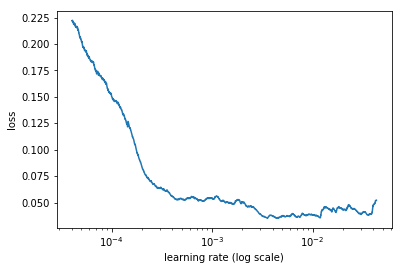

In [199]:
m.sched.plot(500)

### Sample

In [ ]:
m = md.get_learner(emb_szs, len(df.columns)-len(cat_vars),
                   0.04, 1, [1000,500], [0.001,0.01], y_range=y_range)
lr = 1e-3

In [ ]:
m.fit(lr, 3, metrics=[exp_rmspe])

In [ ]:
m.fit(lr, 5, metrics=[exp_rmspe], cycle_len=1)

In [ ]:
m.fit(lr, 2, metrics=[exp_rmspe], cycle_len=4)

### All

In [200]:
m = md.get_learner(emb_szs, len(df.columns)-len(cat_vars),
                   0.04, 1, [1000,500], [0.001,0.01], y_range=y_range)
lr = 2e-3

In [201]:
m.fit(lr, 3, metrics=[exp_rmspe])

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))



  0%|          | 0/4948 [00:00<?, ?it/s]

  0%|          | 0/4948 [00:00<?, ?it/s, loss=8.6]

  0%|          | 1/4948 [00:00<43:33,  1.89it/s, loss=8.6]

  0%|          | 1/4948 [00:00<46:24,  1.78it/s, loss=9.87]

  0%|          | 1/4948 [00:00<49:03,  1.68it/s, loss=11.3]

  0%|          | 1/4948 [00:00<51:35,  1.60it/s, loss=12.2]

  0%|          | 4/4948 [00:00<13:00,  6.34it/s, loss=12.2]

  0%|          | 4/4948 [00:00<13:43,  6.00it/s, loss=12.6]

  0%|          | 4/4948 [00:00<14:28,  5.70it/s, loss=12.8]

  0%|          | 4/4948 [00:00<15:11,  5.42it/s, loss=13]  

  0%|          | 7/4948 [00:00<08:42,  9.45it/s, loss=13]

  0%|          | 7/4948 [00:00<09:04,  9.07it/s, loss=13]

  0%|          | 7/4948 [00:00<09:28,  8.69it/s, loss=12.8]

  0%|          | 7/4948 [00:00<09:52,  8.34it/s, loss=12.6]

  0%|          | 10/4948 [00:00<06:56, 11.87it/s, loss=12.6]

  0%|          | 10/4948 [00:00<07:14, 11.36it/s, loss=12]  

  0%|          | 10/4948 [00:00<07:31, 10.94it/s, los

  2%|▏         | 89/4948 [00:03<03:24, 23.80it/s, loss=0.891]

  2%|▏         | 92/4948 [00:03<03:17, 24.58it/s, loss=0.891]

  2%|▏         | 92/4948 [00:03<03:19, 24.36it/s, loss=0.872]

  2%|▏         | 92/4948 [00:03<03:20, 24.16it/s, loss=0.854]

  2%|▏         | 92/4948 [00:03<03:22, 23.94it/s, loss=0.836]

  2%|▏         | 95/4948 [00:03<03:16, 24.68it/s, loss=0.836]

  2%|▏         | 95/4948 [00:03<03:18, 24.47it/s, loss=0.818]

  2%|▏         | 95/4948 [00:03<03:20, 24.26it/s, loss=0.801]

  2%|▏         | 95/4948 [00:03<03:21, 24.04it/s, loss=0.784]

  2%|▏         | 98/4948 [00:03<03:15, 24.77it/s, loss=0.784]

  2%|▏         | 98/4948 [00:03<03:17, 24.56it/s, loss=0.768]

  2%|▏         | 98/4948 [00:04<03:19, 24.33it/s, loss=0.752]

  2%|▏         | 98/4948 [00:04<03:21, 24.09it/s, loss=0.736]

  2%|▏         | 101/4948 [00:04<03:15, 24.79it/s, loss=0.736]

  2%|▏         | 101/4948 [00:04<03:17, 24.59it/s, loss=0.721]

  2%|▏         | 101/4948 [00:04<03:18, 24.40it/s, lo

  4%|▎         | 176/4948 [00:06<03:09, 25.23it/s, loss=0.182]

  4%|▎         | 180/4948 [00:06<03:04, 25.80it/s, loss=0.182]

  4%|▎         | 180/4948 [00:07<03:05, 25.68it/s, loss=0.179]

  4%|▎         | 180/4948 [00:07<03:06, 25.56it/s, loss=0.177]

  4%|▎         | 180/4948 [00:07<03:07, 25.44it/s, loss=0.174]

  4%|▎         | 183/4948 [00:07<03:04, 25.85it/s, loss=0.174]

  4%|▎         | 183/4948 [00:07<03:05, 25.73it/s, loss=0.172]

  4%|▎         | 183/4948 [00:07<03:06, 25.61it/s, loss=0.169]

  4%|▎         | 183/4948 [00:07<03:06, 25.50it/s, loss=0.167]

  4%|▍         | 186/4948 [00:07<03:03, 25.91it/s, loss=0.167]

  4%|▍         | 186/4948 [00:07<03:04, 25.80it/s, loss=0.165]

  4%|▍         | 186/4948 [00:07<03:05, 25.69it/s, loss=0.163]

  4%|▍         | 186/4948 [00:07<03:06, 25.57it/s, loss=0.16] 

  4%|▍         | 186/4948 [00:07<03:07, 25.44it/s, loss=0.158]

  4%|▍         | 190/4948 [00:07<03:03, 25.98it/s, loss=0.158]

  4%|▍         | 190/4948 [00:07<03:04, 

  6%|▌         | 274/4948 [00:08<02:25, 32.03it/s, loss=0.0638]

  6%|▌         | 274/4948 [00:08<02:26, 31.99it/s, loss=0.0633]

  6%|▌         | 274/4948 [00:08<02:26, 31.94it/s, loss=0.0628]

  6%|▌         | 283/4948 [00:08<02:21, 32.98it/s, loss=0.0628]

  6%|▌         | 283/4948 [00:08<02:21, 32.93it/s, loss=0.0627]

  6%|▌         | 283/4948 [00:08<02:21, 32.89it/s, loss=0.0622]

  6%|▌         | 283/4948 [00:08<02:22, 32.85it/s, loss=0.062] 

  6%|▌         | 283/4948 [00:08<02:22, 32.81it/s, loss=0.0616]

  6%|▌         | 283/4948 [00:08<02:22, 32.77it/s, loss=0.0616]

  6%|▌         | 283/4948 [00:08<02:22, 32.72it/s, loss=0.061] 

  6%|▌         | 283/4948 [00:08<02:22, 32.68it/s, loss=0.0602]

  6%|▌         | 283/4948 [00:08<02:22, 32.64it/s, loss=0.0602]

  6%|▌         | 283/4948 [00:08<02:23, 32.59it/s, loss=0.0601]

  6%|▌         | 292/4948 [00:08<02:18, 33.62it/s, loss=0.0601]

  6%|▌         | 292/4948 [00:08<02:18, 33.57it/s, loss=0.0598]

  6%|▌         | 292/4948

  8%|▊         | 382/4948 [00:09<01:56, 39.12it/s, loss=0.0416]

  8%|▊         | 382/4948 [00:09<01:56, 39.07it/s, loss=0.0414]

  8%|▊         | 382/4948 [00:09<01:56, 39.03it/s, loss=0.0413]

  8%|▊         | 382/4948 [00:09<01:57, 38.98it/s, loss=0.0413]

  8%|▊         | 382/4948 [00:09<01:57, 38.94it/s, loss=0.0412]

  8%|▊         | 382/4948 [00:09<01:57, 38.89it/s, loss=0.0411]

  8%|▊         | 382/4948 [00:09<01:57, 38.85it/s, loss=0.0411]

  8%|▊         | 382/4948 [00:09<01:57, 38.80it/s, loss=0.0411]

  8%|▊         | 391/4948 [00:09<01:54, 39.70it/s, loss=0.0411]

  8%|▊         | 391/4948 [00:09<01:54, 39.66it/s, loss=0.0411]

  8%|▊         | 391/4948 [00:09<01:55, 39.62it/s, loss=0.0411]

  8%|▊         | 391/4948 [00:09<01:55, 39.57it/s, loss=0.0413]

  8%|▊         | 391/4948 [00:09<01:55, 39.53it/s, loss=0.0412]

  8%|▊         | 391/4948 [00:09<01:55, 39.49it/s, loss=0.0409]

  8%|▊         | 391/4948 [00:09<01:55, 39.44it/s, loss=0.0408]

  8%|▊         | 391/4948

 10%|▉         | 480/4948 [00:11<01:42, 43.50it/s, loss=0.0362]

 10%|▉         | 480/4948 [00:11<01:42, 43.45it/s, loss=0.0361]

 10%|▉         | 489/4948 [00:11<01:40, 44.25it/s, loss=0.0361]

 10%|▉         | 489/4948 [00:11<01:40, 44.21it/s, loss=0.036] 

 10%|▉         | 489/4948 [00:11<01:40, 44.17it/s, loss=0.0357]

 10%|▉         | 489/4948 [00:11<01:41, 44.12it/s, loss=0.0355]

 10%|▉         | 489/4948 [00:11<01:41, 44.07it/s, loss=0.0356]

 10%|▉         | 489/4948 [00:11<01:41, 44.03it/s, loss=0.0355]

 10%|▉         | 489/4948 [00:11<01:41, 43.98it/s, loss=0.0355]

 10%|▉         | 489/4948 [00:11<01:41, 43.93it/s, loss=0.0353]

 10%|▉         | 489/4948 [00:11<01:41, 43.88it/s, loss=0.0352]

 10%|▉         | 489/4948 [00:11<01:41, 43.83it/s, loss=0.0353]

 10%|█         | 498/4948 [00:11<01:39, 44.63it/s, loss=0.0353]

 10%|█         | 498/4948 [00:11<01:39, 44.59it/s, loss=0.0353]

 10%|█         | 498/4948 [00:11<01:39, 44.54it/s, loss=0.0353]

 10%|█         | 498/4948

 12%|█▏        | 588/4948 [00:12<01:31, 47.89it/s, loss=0.0307]

 12%|█▏        | 588/4948 [00:12<01:31, 47.85it/s, loss=0.0307]

 12%|█▏        | 588/4948 [00:12<01:31, 47.80it/s, loss=0.0306]

 12%|█▏        | 588/4948 [00:12<01:31, 47.76it/s, loss=0.0306]

 12%|█▏        | 588/4948 [00:12<01:31, 47.72it/s, loss=0.0304]

 12%|█▏        | 588/4948 [00:12<01:31, 47.68it/s, loss=0.0303]

 12%|█▏        | 588/4948 [00:12<01:31, 47.63it/s, loss=0.0303]

 12%|█▏        | 597/4948 [00:12<01:29, 48.35it/s, loss=0.0303]

 12%|█▏        | 597/4948 [00:12<01:30, 48.31it/s, loss=0.0303]

 12%|█▏        | 597/4948 [00:12<01:30, 48.27it/s, loss=0.0303]

 12%|█▏        | 597/4948 [00:12<01:30, 48.22it/s, loss=0.0301]

 12%|█▏        | 597/4948 [00:12<01:30, 48.17it/s, loss=0.0303]

 12%|█▏        | 597/4948 [00:12<01:30, 48.12it/s, loss=0.0302]

 12%|█▏        | 597/4948 [00:12<01:30, 48.08it/s, loss=0.0304]

 12%|█▏        | 597/4948 [00:12<01:30, 48.03it/s, loss=0.0303]

 12%|█▏        | 597/4948

 14%|█▍        | 687/4948 [00:13<01:23, 50.93it/s, loss=0.0277]

 14%|█▍        | 687/4948 [00:13<01:23, 50.88it/s, loss=0.0275]

 14%|█▍        | 696/4948 [00:13<01:22, 51.54it/s, loss=0.0275]

 14%|█▍        | 696/4948 [00:13<01:22, 51.49it/s, loss=0.0274]

 14%|█▍        | 696/4948 [00:13<01:22, 51.45it/s, loss=0.0272]

 14%|█▍        | 696/4948 [00:13<01:22, 51.40it/s, loss=0.0272]

 14%|█▍        | 696/4948 [00:13<01:22, 51.35it/s, loss=0.0272]

 14%|█▍        | 696/4948 [00:13<01:22, 51.31it/s, loss=0.0273]

 14%|█▍        | 696/4948 [00:13<01:22, 51.26it/s, loss=0.0273]

 14%|█▍        | 696/4948 [00:13<01:23, 51.21it/s, loss=0.0273]

 14%|█▍        | 696/4948 [00:13<01:23, 51.16it/s, loss=0.0272]

 14%|█▍        | 696/4948 [00:13<01:23, 51.11it/s, loss=0.0274]

 14%|█▍        | 705/4948 [00:13<01:21, 51.76it/s, loss=0.0274]

 14%|█▍        | 705/4948 [00:13<01:22, 51.72it/s, loss=0.0273]

 14%|█▍        | 705/4948 [00:13<01:22, 51.68it/s, loss=0.0272]

 14%|█▍        | 705/4948

 16%|█▌        | 789/4948 [00:14<01:18, 53.29it/s, loss=0.0253]

 16%|█▌        | 798/4948 [00:14<01:17, 53.89it/s, loss=0.0253]

 16%|█▌        | 798/4948 [00:14<01:17, 53.84it/s, loss=0.0254]

 16%|█▌        | 798/4948 [00:14<01:17, 53.80it/s, loss=0.0257]

 16%|█▌        | 798/4948 [00:14<01:17, 53.75it/s, loss=0.0257]

 16%|█▌        | 798/4948 [00:14<01:17, 53.71it/s, loss=0.0259]

 16%|█▌        | 798/4948 [00:14<01:17, 53.66it/s, loss=0.0258]

 16%|█▌        | 798/4948 [00:14<01:17, 53.62it/s, loss=0.0258]

 16%|█▌        | 798/4948 [00:14<01:17, 53.56it/s, loss=0.0256]

 16%|█▌        | 798/4948 [00:14<01:17, 53.51it/s, loss=0.0262]

 16%|█▋        | 806/4948 [00:14<01:16, 54.04it/s, loss=0.0262]

 16%|█▋        | 806/4948 [00:14<01:16, 53.99it/s, loss=0.0262]

 16%|█▋        | 806/4948 [00:14<01:16, 53.95it/s, loss=0.026] 

 16%|█▋        | 806/4948 [00:14<01:16, 53.90it/s, loss=0.0264]

 16%|█▋        | 806/4948 [00:14<01:16, 53.86it/s, loss=0.0263]

 16%|█▋        | 806/4948

 18%|█▊        | 897/4948 [00:16<01:12, 55.66it/s, loss=0.0237]

 18%|█▊        | 897/4948 [00:16<01:12, 55.62it/s, loss=0.0237]

 18%|█▊        | 897/4948 [00:16<01:12, 55.58it/s, loss=0.0237]

 18%|█▊        | 897/4948 [00:16<01:12, 55.54it/s, loss=0.0239]

 18%|█▊        | 897/4948 [00:16<01:12, 55.49it/s, loss=0.024] 

 18%|█▊        | 897/4948 [00:16<01:13, 55.45it/s, loss=0.024]

 18%|█▊        | 897/4948 [00:16<01:13, 55.41it/s, loss=0.024]

 18%|█▊        | 906/4948 [00:16<01:12, 55.96it/s, loss=0.024]

 18%|█▊        | 906/4948 [00:16<01:12, 55.92it/s, loss=0.0239]

 18%|█▊        | 906/4948 [00:16<01:12, 55.88it/s, loss=0.024] 

 18%|█▊        | 906/4948 [00:16<01:12, 55.84it/s, loss=0.0241]

 18%|█▊        | 906/4948 [00:16<01:12, 55.80it/s, loss=0.024] 

 18%|█▊        | 906/4948 [00:16<01:12, 55.76it/s, loss=0.0242]

 18%|█▊        | 906/4948 [00:16<01:12, 55.72it/s, loss=0.0241]

 18%|█▊        | 906/4948 [00:16<01:12, 55.68it/s, loss=0.024] 

 18%|█▊        | 906/4948 [0

 20%|██        | 1003/4948 [00:17<01:08, 57.68it/s, loss=0.023]

 20%|██        | 1003/4948 [00:17<01:08, 57.64it/s, loss=0.0229]

 20%|██        | 1003/4948 [00:17<01:08, 57.60it/s, loss=0.0227]

 20%|██        | 1003/4948 [00:17<01:08, 57.56it/s, loss=0.0227]

 20%|██        | 1003/4948 [00:17<01:08, 57.52it/s, loss=0.0227]

 20%|██        | 1003/4948 [00:17<01:08, 57.48it/s, loss=0.0228]

 20%|██        | 1003/4948 [00:17<01:08, 57.44it/s, loss=0.0228]

 20%|██        | 1003/4948 [00:17<01:08, 57.39it/s, loss=0.0227]

 20%|██        | 1003/4948 [00:17<01:08, 57.35it/s, loss=0.0228]

 20%|██        | 1011/4948 [00:17<01:08, 57.80it/s, loss=0.0228]

 20%|██        | 1011/4948 [00:17<01:08, 57.76it/s, loss=0.0231]

 20%|██        | 1011/4948 [00:17<01:08, 57.72it/s, loss=0.023] 

 20%|██        | 1011/4948 [00:17<01:08, 57.67it/s, loss=0.023]

 20%|██        | 1011/4948 [00:17<01:08, 57.63it/s, loss=0.0229]

 20%|██        | 1011/4948 [00:17<01:08, 57.59it/s, loss=0.0229]

 20%|██     

 22%|██▏       | 1102/4948 [00:18<01:05, 58.99it/s, loss=0.0216]

 22%|██▏       | 1102/4948 [00:18<01:05, 58.95it/s, loss=0.0215]

 22%|██▏       | 1102/4948 [00:18<01:05, 58.91it/s, loss=0.0215]

 22%|██▏       | 1102/4948 [00:18<01:05, 58.87it/s, loss=0.0215]

 22%|██▏       | 1102/4948 [00:18<01:05, 58.82it/s, loss=0.0218]

 22%|██▏       | 1102/4948 [00:18<01:05, 58.78it/s, loss=0.0217]

 22%|██▏       | 1102/4948 [00:18<01:05, 58.74it/s, loss=0.0217]

 22%|██▏       | 1110/4948 [00:18<01:04, 59.16it/s, loss=0.0217]

 22%|██▏       | 1110/4948 [00:18<01:04, 59.12it/s, loss=0.0221]

 22%|██▏       | 1110/4948 [00:18<01:04, 59.08it/s, loss=0.022] 

 22%|██▏       | 1110/4948 [00:18<01:05, 59.04it/s, loss=0.0219]

 22%|██▏       | 1110/4948 [00:18<01:05, 59.00it/s, loss=0.0219]

 22%|██▏       | 1110/4948 [00:18<01:05, 58.96it/s, loss=0.022] 

 22%|██▏       | 1110/4948 [00:18<01:05, 58.92it/s, loss=0.0219]

 22%|██▏       | 1110/4948 [00:18<01:05, 58.88it/s, loss=0.0219]

 22%|██▏  

 24%|██▍       | 1204/4948 [00:19<01:02, 60.32it/s, loss=0.0205]

 24%|██▍       | 1204/4948 [00:19<01:02, 60.28it/s, loss=0.0204]

 24%|██▍       | 1204/4948 [00:19<01:02, 60.25it/s, loss=0.0204]

 24%|██▍       | 1204/4948 [00:19<01:02, 60.21it/s, loss=0.0204]

 24%|██▍       | 1204/4948 [00:20<01:02, 60.18it/s, loss=0.0204]

 24%|██▍       | 1204/4948 [00:20<01:02, 60.14it/s, loss=0.0205]

 24%|██▍       | 1204/4948 [00:20<01:02, 60.10it/s, loss=0.0205]

 24%|██▍       | 1204/4948 [00:20<01:02, 60.05it/s, loss=0.0204]

 24%|██▍       | 1204/4948 [00:20<01:02, 60.02it/s, loss=0.0203]

 25%|██▍       | 1213/4948 [00:20<01:01, 60.46it/s, loss=0.0203]

 25%|██▍       | 1213/4948 [00:20<01:01, 60.42it/s, loss=0.0202]

 25%|██▍       | 1213/4948 [00:20<01:01, 60.38it/s, loss=0.0201]

 25%|██▍       | 1213/4948 [00:20<01:01, 60.35it/s, loss=0.02]  

 25%|██▍       | 1213/4948 [00:20<01:01, 60.31it/s, loss=0.0202]

 25%|██▍       | 1213/4948 [00:20<01:01, 60.28it/s, loss=0.0202]

 25%|██▍  

 26%|██▋       | 1303/4948 [00:21<00:59, 61.42it/s, loss=0.0198]

 26%|██▋       | 1303/4948 [00:21<00:59, 61.38it/s, loss=0.0198]

 26%|██▋       | 1303/4948 [00:21<00:59, 61.35it/s, loss=0.02]  

 26%|██▋       | 1303/4948 [00:21<00:59, 61.31it/s, loss=0.02]

 26%|██▋       | 1303/4948 [00:21<00:59, 61.27it/s, loss=0.0203]

 26%|██▋       | 1303/4948 [00:21<00:59, 61.23it/s, loss=0.0203]

 27%|██▋       | 1312/4948 [00:21<00:58, 61.65it/s, loss=0.0203]

 27%|██▋       | 1312/4948 [00:21<00:59, 61.62it/s, loss=0.0202]

 27%|██▋       | 1312/4948 [00:21<00:59, 61.58it/s, loss=0.0203]

 27%|██▋       | 1312/4948 [00:21<00:59, 61.55it/s, loss=0.0204]

 27%|██▋       | 1312/4948 [00:21<00:59, 61.51it/s, loss=0.0203]

 27%|██▋       | 1312/4948 [00:21<00:59, 61.48it/s, loss=0.0205]

 27%|██▋       | 1312/4948 [00:21<00:59, 61.45it/s, loss=0.0205]

 27%|██▋       | 1312/4948 [00:21<00:59, 61.41it/s, loss=0.0204]

 27%|██▋       | 1312/4948 [00:21<00:59, 61.37it/s, loss=0.0205]

 27%|██▋    

 28%|██▊       | 1403/4948 [00:22<00:56, 62.60it/s, loss=0.0205]

 28%|██▊       | 1403/4948 [00:22<00:56, 62.58it/s, loss=0.0208]

 28%|██▊       | 1403/4948 [00:22<00:56, 62.55it/s, loss=0.0208]

 28%|██▊       | 1403/4948 [00:22<00:56, 62.51it/s, loss=0.0209]

 29%|██▊       | 1412/4948 [00:22<00:56, 62.90it/s, loss=0.0209]

 29%|██▊       | 1412/4948 [00:22<00:56, 62.87it/s, loss=0.0209]

 29%|██▊       | 1412/4948 [00:22<00:56, 62.84it/s, loss=0.0209]

 29%|██▊       | 1412/4948 [00:22<00:56, 62.81it/s, loss=0.021] 

 29%|██▊       | 1412/4948 [00:22<00:56, 62.78it/s, loss=0.021]

 29%|██▊       | 1412/4948 [00:22<00:56, 62.74it/s, loss=0.021]

 29%|██▊       | 1412/4948 [00:22<00:56, 62.71it/s, loss=0.021]

 29%|██▊       | 1412/4948 [00:22<00:56, 62.68it/s, loss=0.0211]

 29%|██▊       | 1412/4948 [00:22<00:56, 62.65it/s, loss=0.021] 

 29%|██▊       | 1412/4948 [00:22<00:56, 62.61it/s, loss=0.021]

 29%|██▊       | 1421/4948 [00:22<00:55, 63.00it/s, loss=0.021]

 29%|██▊       

 31%|███       | 1510/4948 [00:23<00:53, 63.86it/s, loss=0.0209]

 31%|███       | 1510/4948 [00:23<00:53, 63.83it/s, loss=0.0209]

 31%|███       | 1510/4948 [00:23<00:53, 63.80it/s, loss=0.0208]

 31%|███       | 1510/4948 [00:23<00:53, 63.76it/s, loss=0.0207]

 31%|███       | 1510/4948 [00:23<00:53, 63.73it/s, loss=0.0206]

 31%|███       | 1510/4948 [00:23<00:53, 63.70it/s, loss=0.0206]

 31%|███       | 1510/4948 [00:23<00:53, 63.67it/s, loss=0.0205]

 31%|███       | 1510/4948 [00:23<00:54, 63.65it/s, loss=0.0204]

 31%|███       | 1510/4948 [00:23<00:54, 63.61it/s, loss=0.0204]

 31%|███       | 1510/4948 [00:23<00:54, 63.58it/s, loss=0.0203]

 31%|███       | 1519/4948 [00:23<00:53, 63.95it/s, loss=0.0203]

 31%|███       | 1519/4948 [00:23<00:53, 63.92it/s, loss=0.0203]

 31%|███       | 1519/4948 [00:23<00:53, 63.89it/s, loss=0.0201]

 31%|███       | 1519/4948 [00:23<00:53, 63.86it/s, loss=0.0201]

 31%|███       | 1519/4948 [00:23<00:53, 63.83it/s, loss=0.0201]

 31%|███  

 33%|███▎      | 1609/4948 [00:24<00:51, 64.65it/s, loss=0.0195]

 33%|███▎      | 1609/4948 [00:24<00:51, 64.62it/s, loss=0.0196]

 33%|███▎      | 1609/4948 [00:24<00:51, 64.59it/s, loss=0.0195]

 33%|███▎      | 1609/4948 [00:24<00:51, 64.56it/s, loss=0.0196]

 33%|███▎      | 1609/4948 [00:24<00:51, 64.53it/s, loss=0.0196]

 33%|███▎      | 1609/4948 [00:24<00:51, 64.49it/s, loss=0.0196]

 33%|███▎      | 1609/4948 [00:24<00:51, 64.46it/s, loss=0.0195]

 33%|███▎      | 1618/4948 [00:24<00:51, 64.82it/s, loss=0.0195]

 33%|███▎      | 1618/4948 [00:24<00:51, 64.79it/s, loss=0.0196]

 33%|███▎      | 1618/4948 [00:24<00:51, 64.76it/s, loss=0.0195]

 33%|███▎      | 1618/4948 [00:24<00:51, 64.73it/s, loss=0.0195]

 33%|███▎      | 1618/4948 [00:25<00:51, 64.69it/s, loss=0.0196]

 33%|███▎      | 1618/4948 [00:25<00:51, 64.66it/s, loss=0.0195]

 33%|███▎      | 1618/4948 [00:25<00:51, 64.63it/s, loss=0.0194]

 33%|███▎      | 1618/4948 [00:25<00:51, 64.60it/s, loss=0.0195]

 33%|███▎ 

 35%|███▍      | 1708/4948 [00:26<00:49, 65.35it/s, loss=0.0189]

 35%|███▍      | 1708/4948 [00:26<00:49, 65.32it/s, loss=0.0188]

 35%|███▍      | 1708/4948 [00:26<00:49, 65.29it/s, loss=0.0188]

 35%|███▍      | 1708/4948 [00:26<00:49, 65.26it/s, loss=0.0188]

 35%|███▍      | 1717/4948 [00:26<00:49, 65.59it/s, loss=0.0188]

 35%|███▍      | 1717/4948 [00:26<00:49, 65.56it/s, loss=0.0187]

 35%|███▍      | 1717/4948 [00:26<00:49, 65.53it/s, loss=0.0188]

 35%|███▍      | 1717/4948 [00:26<00:49, 65.50it/s, loss=0.0187]

 35%|███▍      | 1717/4948 [00:26<00:49, 65.47it/s, loss=0.0187]

 35%|███▍      | 1717/4948 [00:26<00:49, 65.44it/s, loss=0.0186]

 35%|███▍      | 1717/4948 [00:26<00:49, 65.41it/s, loss=0.0186]

 35%|███▍      | 1717/4948 [00:26<00:49, 65.38it/s, loss=0.0187]

 35%|███▍      | 1717/4948 [00:26<00:49, 65.35it/s, loss=0.0188]

 35%|███▍      | 1717/4948 [00:26<00:49, 65.32it/s, loss=0.0187]

 35%|███▍      | 1726/4948 [00:26<00:49, 65.66it/s, loss=0.0187]

 35%|███▍ 

 37%|███▋      | 1807/4948 [00:27<00:47, 65.96it/s, loss=0.0179]

 37%|███▋      | 1816/4948 [00:27<00:47, 66.29it/s, loss=0.0179]

 37%|███▋      | 1816/4948 [00:27<00:47, 66.26it/s, loss=0.0177]

 37%|███▋      | 1816/4948 [00:27<00:47, 66.23it/s, loss=0.0177]

 37%|███▋      | 1816/4948 [00:27<00:47, 66.20it/s, loss=0.0178]

 37%|███▋      | 1816/4948 [00:27<00:47, 66.17it/s, loss=0.0177]

 37%|███▋      | 1816/4948 [00:27<00:47, 66.14it/s, loss=0.0177]

 37%|███▋      | 1816/4948 [00:27<00:47, 66.12it/s, loss=0.0177]

 37%|███▋      | 1816/4948 [00:27<00:47, 66.09it/s, loss=0.0176]

 37%|███▋      | 1816/4948 [00:27<00:47, 66.06it/s, loss=0.0176]

 37%|███▋      | 1816/4948 [00:27<00:47, 66.03it/s, loss=0.0175]

 37%|███▋      | 1825/4948 [00:27<00:47, 66.35it/s, loss=0.0175]

 37%|███▋      | 1825/4948 [00:27<00:47, 66.32it/s, loss=0.0174]

 37%|███▋      | 1825/4948 [00:27<00:47, 66.29it/s, loss=0.0174]

 37%|███▋      | 1825/4948 [00:27<00:47, 66.26it/s, loss=0.0174]

 37%|███▋ 

 39%|███▊      | 1915/4948 [00:28<00:45, 66.85it/s, loss=0.0185]

 39%|███▊      | 1915/4948 [00:28<00:45, 66.83it/s, loss=0.0185]

 39%|███▊      | 1915/4948 [00:28<00:45, 66.80it/s, loss=0.0184]

 39%|███▊      | 1915/4948 [00:28<00:45, 66.77it/s, loss=0.0183]

 39%|███▊      | 1915/4948 [00:28<00:45, 66.74it/s, loss=0.0182]

 39%|███▊      | 1915/4948 [00:28<00:45, 66.71it/s, loss=0.0183]

 39%|███▊      | 1915/4948 [00:28<00:45, 66.68it/s, loss=0.0184]

 39%|███▊      | 1915/4948 [00:28<00:45, 66.66it/s, loss=0.0185]

 39%|███▉      | 1924/4948 [00:28<00:45, 66.96it/s, loss=0.0185]

 39%|███▉      | 1924/4948 [00:28<00:45, 66.94it/s, loss=0.0186]

 39%|███▉      | 1924/4948 [00:28<00:45, 66.91it/s, loss=0.0186]

 39%|███▉      | 1924/4948 [00:28<00:45, 66.88it/s, loss=0.0185]

 39%|███▉      | 1924/4948 [00:28<00:45, 66.85it/s, loss=0.0184]

 39%|███▉      | 1924/4948 [00:28<00:45, 66.83it/s, loss=0.0183]

 39%|███▉      | 1924/4948 [00:28<00:45, 66.80it/s, loss=0.0185]

 39%|███▉ 

 41%|████      | 2013/4948 [00:29<00:43, 67.29it/s, loss=0.0192]

 41%|████      | 2013/4948 [00:29<00:43, 67.26it/s, loss=0.0192]

 41%|████      | 2013/4948 [00:29<00:43, 67.23it/s, loss=0.0193]

 41%|████      | 2021/4948 [00:29<00:43, 67.49it/s, loss=0.0193]

 41%|████      | 2021/4948 [00:29<00:43, 67.46it/s, loss=0.0194]

 41%|████      | 2021/4948 [00:29<00:43, 67.43it/s, loss=0.0194]

 41%|████      | 2021/4948 [00:29<00:43, 67.41it/s, loss=0.0193]

 41%|████      | 2021/4948 [00:29<00:43, 67.38it/s, loss=0.0193]

 41%|████      | 2021/4948 [00:30<00:43, 67.35it/s, loss=0.0192]

 41%|████      | 2021/4948 [00:30<00:43, 67.32it/s, loss=0.0191]

 41%|████      | 2021/4948 [00:30<00:43, 67.29it/s, loss=0.0191]

 41%|████      | 2021/4948 [00:30<00:43, 67.26it/s, loss=0.019] 

 41%|████      | 2029/4948 [00:30<00:43, 67.52it/s, loss=0.019]

 41%|████      | 2029/4948 [00:30<00:43, 67.50it/s, loss=0.019]

 41%|████      | 2029/4948 [00:30<00:43, 67.47it/s, loss=0.019]

 41%|████    

 43%|████▎     | 2117/4948 [00:31<00:41, 67.81it/s, loss=0.0178]

 43%|████▎     | 2117/4948 [00:31<00:41, 67.78it/s, loss=0.0179]

 43%|████▎     | 2117/4948 [00:31<00:41, 67.75it/s, loss=0.0179]

 43%|████▎     | 2117/4948 [00:31<00:41, 67.73it/s, loss=0.0178]

 43%|████▎     | 2117/4948 [00:31<00:41, 67.70it/s, loss=0.0178]

 43%|████▎     | 2117/4948 [00:31<00:41, 67.68it/s, loss=0.0177]

 43%|████▎     | 2117/4948 [00:31<00:41, 67.64it/s, loss=0.0176]

 43%|████▎     | 2125/4948 [00:31<00:41, 67.90it/s, loss=0.0176]

 43%|████▎     | 2125/4948 [00:31<00:41, 67.87it/s, loss=0.0176]

 43%|████▎     | 2125/4948 [00:31<00:41, 67.84it/s, loss=0.0177]

 43%|████▎     | 2125/4948 [00:31<00:41, 67.81it/s, loss=0.0176]

 43%|████▎     | 2125/4948 [00:31<00:41, 67.78it/s, loss=0.0177]

 43%|████▎     | 2125/4948 [00:31<00:41, 67.76it/s, loss=0.0177]

 43%|████▎     | 2125/4948 [00:31<00:41, 67.73it/s, loss=0.0178]

 43%|████▎     | 2125/4948 [00:31<00:41, 67.70it/s, loss=0.0177]

 43%|████▎

 45%|████▍     | 2219/4948 [00:32<00:39, 68.29it/s, loss=0.0178]

 45%|████▍     | 2219/4948 [00:32<00:39, 68.27it/s, loss=0.0178]

 45%|████▍     | 2219/4948 [00:32<00:39, 68.24it/s, loss=0.0179]

 45%|████▍     | 2219/4948 [00:32<00:40, 68.22it/s, loss=0.0179]

 45%|████▍     | 2219/4948 [00:32<00:40, 68.19it/s, loss=0.018] 

 45%|████▍     | 2219/4948 [00:32<00:40, 68.17it/s, loss=0.0179]

 45%|████▍     | 2219/4948 [00:32<00:40, 68.14it/s, loss=0.0179]

 45%|████▍     | 2219/4948 [00:32<00:40, 68.12it/s, loss=0.0179]

 45%|████▍     | 2219/4948 [00:32<00:40, 68.09it/s, loss=0.0179]

 45%|████▌     | 2228/4948 [00:32<00:39, 68.36it/s, loss=0.0179]

 45%|████▌     | 2228/4948 [00:32<00:39, 68.34it/s, loss=0.0178]

 45%|████▌     | 2228/4948 [00:32<00:39, 68.31it/s, loss=0.0178]

 45%|████▌     | 2228/4948 [00:32<00:39, 68.28it/s, loss=0.0178]

 45%|████▌     | 2228/4948 [00:32<00:39, 68.26it/s, loss=0.0178]

 45%|████▌     | 2228/4948 [00:32<00:39, 68.23it/s, loss=0.0178]

 45%|████▌

 47%|████▋     | 2318/4948 [00:33<00:38, 68.66it/s, loss=0.0174]

 47%|████▋     | 2318/4948 [00:33<00:38, 68.64it/s, loss=0.0173]

 47%|████▋     | 2318/4948 [00:33<00:38, 68.61it/s, loss=0.0173]

 47%|████▋     | 2318/4948 [00:33<00:38, 68.58it/s, loss=0.0173]

 47%|████▋     | 2318/4948 [00:33<00:38, 68.56it/s, loss=0.0173]

 47%|████▋     | 2326/4948 [00:33<00:38, 68.79it/s, loss=0.0173]

 47%|████▋     | 2326/4948 [00:33<00:38, 68.77it/s, loss=0.0173]

 47%|████▋     | 2326/4948 [00:33<00:38, 68.74it/s, loss=0.0173]

 47%|████▋     | 2326/4948 [00:33<00:38, 68.72it/s, loss=0.0173]

 47%|████▋     | 2326/4948 [00:33<00:38, 68.69it/s, loss=0.0173]

 47%|████▋     | 2326/4948 [00:33<00:38, 68.66it/s, loss=0.0173]

 47%|████▋     | 2326/4948 [00:33<00:38, 68.63it/s, loss=0.0172]

 47%|████▋     | 2326/4948 [00:33<00:38, 68.61it/s, loss=0.0173]

 47%|████▋     | 2326/4948 [00:33<00:38, 68.59it/s, loss=0.0172]

 47%|████▋     | 2334/4948 [00:33<00:37, 68.82it/s, loss=0.0172]

 47%|████▋

 49%|████▉     | 2421/4948 [00:35<00:36, 69.17it/s, loss=0.0179]

 49%|████▉     | 2421/4948 [00:35<00:36, 69.14it/s, loss=0.0178]

 49%|████▉     | 2421/4948 [00:35<00:36, 69.12it/s, loss=0.0178]

 49%|████▉     | 2421/4948 [00:35<00:36, 69.09it/s, loss=0.0178]

 49%|████▉     | 2421/4948 [00:35<00:36, 69.07it/s, loss=0.0178]

 49%|████▉     | 2421/4948 [00:35<00:36, 69.05it/s, loss=0.0178]

 49%|████▉     | 2421/4948 [00:35<00:36, 69.02it/s, loss=0.0178]

 49%|████▉     | 2421/4948 [00:35<00:36, 68.99it/s, loss=0.0177]

 49%|████▉     | 2430/4948 [00:35<00:36, 69.25it/s, loss=0.0177]

 49%|████▉     | 2430/4948 [00:35<00:36, 69.22it/s, loss=0.0176]

 49%|████▉     | 2430/4948 [00:35<00:36, 69.20it/s, loss=0.0176]

 49%|████▉     | 2430/4948 [00:35<00:36, 69.17it/s, loss=0.0175]

 49%|████▉     | 2430/4948 [00:35<00:36, 69.15it/s, loss=0.0175]

 49%|████▉     | 2430/4948 [00:35<00:36, 69.12it/s, loss=0.0176]

 49%|████▉     | 2430/4948 [00:35<00:36, 69.10it/s, loss=0.0175]

 49%|████▉

 51%|█████     | 2519/4948 [00:36<00:34, 69.45it/s, loss=0.0165]

 51%|█████     | 2519/4948 [00:36<00:34, 69.43it/s, loss=0.0166]

 51%|█████     | 2519/4948 [00:36<00:35, 69.40it/s, loss=0.0165]

 51%|█████     | 2519/4948 [00:36<00:35, 69.37it/s, loss=0.0165]

 51%|█████     | 2528/4948 [00:36<00:34, 69.62it/s, loss=0.0165]

 51%|█████     | 2528/4948 [00:36<00:34, 69.59it/s, loss=0.0165]

 51%|█████     | 2528/4948 [00:36<00:34, 69.57it/s, loss=0.0165]

 51%|█████     | 2528/4948 [00:36<00:34, 69.55it/s, loss=0.0165]

 51%|█████     | 2528/4948 [00:36<00:34, 69.53it/s, loss=0.0168]

 51%|█████     | 2528/4948 [00:36<00:34, 69.51it/s, loss=0.0168]

 51%|█████     | 2528/4948 [00:36<00:34, 69.48it/s, loss=0.0168]

 51%|█████     | 2528/4948 [00:36<00:34, 69.46it/s, loss=0.0168]

 51%|█████     | 2528/4948 [00:36<00:34, 69.43it/s, loss=0.0168]

 51%|█████     | 2528/4948 [00:36<00:34, 69.41it/s, loss=0.0167]

 51%|█████▏    | 2537/4948 [00:36<00:34, 69.65it/s, loss=0.0167]

 51%|█████

 53%|█████▎    | 2626/4948 [00:37<00:33, 69.98it/s, loss=0.0178]

 53%|█████▎    | 2626/4948 [00:37<00:33, 69.95it/s, loss=0.0179]

 53%|█████▎    | 2626/4948 [00:37<00:33, 69.93it/s, loss=0.0178]

 53%|█████▎    | 2626/4948 [00:37<00:33, 69.91it/s, loss=0.0178]

 53%|█████▎    | 2626/4948 [00:37<00:33, 69.89it/s, loss=0.0177]

 53%|█████▎    | 2626/4948 [00:37<00:33, 69.87it/s, loss=0.0178]

 53%|█████▎    | 2626/4948 [00:37<00:33, 69.84it/s, loss=0.0177]

 53%|█████▎    | 2626/4948 [00:37<00:33, 69.82it/s, loss=0.0177]

 53%|█████▎    | 2626/4948 [00:37<00:33, 69.80it/s, loss=0.0176]

 53%|█████▎    | 2626/4948 [00:37<00:33, 69.77it/s, loss=0.0177]

 53%|█████▎    | 2635/4948 [00:37<00:33, 70.01it/s, loss=0.0177]

 53%|█████▎    | 2635/4948 [00:37<00:33, 69.99it/s, loss=0.0178]

 53%|█████▎    | 2635/4948 [00:37<00:33, 69.97it/s, loss=0.0177]

 53%|█████▎    | 2635/4948 [00:37<00:33, 69.95it/s, loss=0.0178]

 53%|█████▎    | 2635/4948 [00:37<00:33, 69.93it/s, loss=0.0178]

 53%|█████

 55%|█████▌    | 2726/4948 [00:38<00:31, 70.20it/s, loss=0.0171]

 55%|█████▌    | 2726/4948 [00:38<00:31, 70.18it/s, loss=0.0172]

 55%|█████▌    | 2726/4948 [00:38<00:31, 70.15it/s, loss=0.0171]

 55%|█████▌    | 2726/4948 [00:38<00:31, 70.13it/s, loss=0.0172]

 55%|█████▌    | 2726/4948 [00:38<00:31, 70.11it/s, loss=0.0172]

 55%|█████▌    | 2726/4948 [00:38<00:31, 70.08it/s, loss=0.0172]

 55%|█████▌    | 2726/4948 [00:38<00:31, 70.06it/s, loss=0.0173]

 55%|█████▌    | 2726/4948 [00:38<00:31, 70.04it/s, loss=0.0173]

 55%|█████▌    | 2734/4948 [00:38<00:31, 70.24it/s, loss=0.0173]

 55%|█████▌    | 2734/4948 [00:38<00:31, 70.22it/s, loss=0.0175]

 55%|█████▌    | 2734/4948 [00:38<00:31, 70.20it/s, loss=0.0176]

 55%|█████▌    | 2734/4948 [00:38<00:31, 70.17it/s, loss=0.0176]

 55%|█████▌    | 2734/4948 [00:38<00:31, 70.15it/s, loss=0.0176]

 55%|█████▌    | 2734/4948 [00:38<00:31, 70.13it/s, loss=0.0175]

 55%|█████▌    | 2734/4948 [00:38<00:31, 70.10it/s, loss=0.0174]

 55%|█████

 57%|█████▋    | 2825/4948 [00:40<00:30, 70.41it/s, loss=0.017] 

 57%|█████▋    | 2825/4948 [00:40<00:30, 70.39it/s, loss=0.017]

 57%|█████▋    | 2825/4948 [00:40<00:30, 70.37it/s, loss=0.0169]

 57%|█████▋    | 2825/4948 [00:40<00:30, 70.35it/s, loss=0.0169]

 57%|█████▋    | 2825/4948 [00:40<00:30, 70.32it/s, loss=0.0169]

 57%|█████▋    | 2825/4948 [00:40<00:30, 70.30it/s, loss=0.0169]

 57%|█████▋    | 2833/4948 [00:40<00:30, 70.49it/s, loss=0.0169]

 57%|█████▋    | 2833/4948 [00:40<00:30, 70.47it/s, loss=0.0168]

 57%|█████▋    | 2833/4948 [00:40<00:30, 70.45it/s, loss=0.0168]

 57%|█████▋    | 2833/4948 [00:40<00:30, 70.42it/s, loss=0.0168]

 57%|█████▋    | 2833/4948 [00:40<00:30, 70.40it/s, loss=0.0168]

 57%|█████▋    | 2833/4948 [00:40<00:30, 70.38it/s, loss=0.0168]

 57%|█████▋    | 2833/4948 [00:40<00:30, 70.36it/s, loss=0.0167]

 57%|█████▋    | 2833/4948 [00:40<00:30, 70.34it/s, loss=0.0167]

 57%|█████▋    | 2833/4948 [00:40<00:30, 70.31it/s, loss=0.0167]

 57%|█████▋

 59%|█████▉    | 2922/4948 [00:41<00:28, 70.63it/s, loss=0.0154]

 59%|█████▉    | 2922/4948 [00:41<00:28, 70.61it/s, loss=0.0154]

 59%|█████▉    | 2931/4948 [00:41<00:28, 70.82it/s, loss=0.0154]

 59%|█████▉    | 2931/4948 [00:41<00:28, 70.80it/s, loss=0.0156]

 59%|█████▉    | 2931/4948 [00:41<00:28, 70.78it/s, loss=0.0156]

 59%|█████▉    | 2931/4948 [00:41<00:28, 70.76it/s, loss=0.0155]

 59%|█████▉    | 2931/4948 [00:41<00:28, 70.74it/s, loss=0.0155]

 59%|█████▉    | 2931/4948 [00:41<00:28, 70.72it/s, loss=0.0158]

 59%|█████▉    | 2931/4948 [00:41<00:28, 70.70it/s, loss=0.0158]

 59%|█████▉    | 2931/4948 [00:41<00:28, 70.68it/s, loss=0.0158]

 59%|█████▉    | 2931/4948 [00:41<00:28, 70.65it/s, loss=0.0159]

 59%|█████▉    | 2931/4948 [00:41<00:28, 70.63it/s, loss=0.0158]

 59%|█████▉    | 2940/4948 [00:41<00:28, 70.85it/s, loss=0.0158]

 59%|█████▉    | 2940/4948 [00:41<00:28, 70.83it/s, loss=0.0158]

 59%|█████▉    | 2940/4948 [00:41<00:28, 70.81it/s, loss=0.0158]

 59%|█████

 61%|██████    | 3030/4948 [00:42<00:26, 71.09it/s, loss=0.0164]

 61%|██████    | 3030/4948 [00:42<00:26, 71.07it/s, loss=0.0163]

 61%|██████    | 3030/4948 [00:42<00:26, 71.05it/s, loss=0.0164]

 61%|██████    | 3030/4948 [00:42<00:27, 71.03it/s, loss=0.0163]

 61%|██████    | 3030/4948 [00:42<00:27, 71.01it/s, loss=0.0162]

 61%|██████    | 3030/4948 [00:42<00:27, 70.99it/s, loss=0.0161]

 61%|██████    | 3030/4948 [00:42<00:27, 70.97it/s, loss=0.016] 

 61%|██████    | 3030/4948 [00:42<00:27, 70.95it/s, loss=0.016]

 61%|██████    | 3030/4948 [00:42<00:27, 70.93it/s, loss=0.016]

 61%|██████▏   | 3039/4948 [00:42<00:26, 71.13it/s, loss=0.016]

 61%|██████▏   | 3039/4948 [00:42<00:26, 71.11it/s, loss=0.0159]

 61%|██████▏   | 3039/4948 [00:42<00:26, 71.09it/s, loss=0.0158]

 61%|██████▏   | 3039/4948 [00:42<00:26, 71.07it/s, loss=0.016] 

 61%|██████▏   | 3039/4948 [00:42<00:26, 71.05it/s, loss=0.016]

 61%|██████▏   | 3039/4948 [00:42<00:26, 71.03it/s, loss=0.0159]

 61%|██████▏  

 63%|██████▎   | 3129/4948 [00:43<00:25, 71.34it/s, loss=0.0181]

 63%|██████▎   | 3129/4948 [00:43<00:25, 71.32it/s, loss=0.018] 

 63%|██████▎   | 3129/4948 [00:43<00:25, 71.30it/s, loss=0.0179]

 63%|██████▎   | 3129/4948 [00:43<00:25, 71.28it/s, loss=0.0178]

 63%|██████▎   | 3129/4948 [00:43<00:25, 71.27it/s, loss=0.0177]

 63%|██████▎   | 3129/4948 [00:43<00:25, 71.25it/s, loss=0.0177]

 63%|██████▎   | 3138/4948 [00:43<00:25, 71.45it/s, loss=0.0177]

 63%|██████▎   | 3138/4948 [00:43<00:25, 71.43it/s, loss=0.0176]

 63%|██████▎   | 3138/4948 [00:43<00:25, 71.41it/s, loss=0.0175]

 63%|██████▎   | 3138/4948 [00:43<00:25, 71.40it/s, loss=0.0174]

 63%|██████▎   | 3138/4948 [00:43<00:25, 71.38it/s, loss=0.0173]

 63%|██████▎   | 3138/4948 [00:43<00:25, 71.36it/s, loss=0.0173]

 63%|██████▎   | 3138/4948 [00:43<00:25, 71.34it/s, loss=0.0172]

 63%|██████▎   | 3138/4948 [00:43<00:25, 71.32it/s, loss=0.017] 

 63%|██████▎   | 3138/4948 [00:44<00:25, 71.30it/s, loss=0.017]

 63%|██████

 65%|██████▌   | 3228/4948 [00:45<00:24, 71.60it/s, loss=0.0156]

 65%|██████▌   | 3228/4948 [00:45<00:24, 71.58it/s, loss=0.0156]

 65%|██████▌   | 3228/4948 [00:45<00:24, 71.56it/s, loss=0.0156]

 65%|██████▌   | 3237/4948 [00:45<00:23, 71.76it/s, loss=0.0156]

 65%|██████▌   | 3237/4948 [00:45<00:23, 71.74it/s, loss=0.0155]

 65%|██████▌   | 3237/4948 [00:45<00:23, 71.72it/s, loss=0.0155]

 65%|██████▌   | 3237/4948 [00:45<00:23, 71.70it/s, loss=0.0154]

 65%|██████▌   | 3237/4948 [00:45<00:23, 71.68it/s, loss=0.0154]

 65%|██████▌   | 3237/4948 [00:45<00:23, 71.66it/s, loss=0.0153]

 65%|██████▌   | 3237/4948 [00:45<00:23, 71.64it/s, loss=0.0153]

 65%|██████▌   | 3237/4948 [00:45<00:23, 71.63it/s, loss=0.0152]

 65%|██████▌   | 3237/4948 [00:45<00:23, 71.60it/s, loss=0.0154]

 65%|██████▌   | 3237/4948 [00:45<00:23, 71.59it/s, loss=0.0154]

 66%|██████▌   | 3246/4948 [00:45<00:23, 71.78it/s, loss=0.0154]

 66%|██████▌   | 3246/4948 [00:45<00:23, 71.76it/s, loss=0.0153]

 66%|█████

 67%|██████▋   | 3336/4948 [00:46<00:22, 72.03it/s, loss=0.0154]

 67%|██████▋   | 3336/4948 [00:46<00:22, 72.01it/s, loss=0.0154]

 67%|██████▋   | 3336/4948 [00:46<00:22, 71.99it/s, loss=0.0153]

 67%|██████▋   | 3336/4948 [00:46<00:22, 71.98it/s, loss=0.0154]

 67%|██████▋   | 3336/4948 [00:46<00:22, 71.96it/s, loss=0.0153]

 67%|██████▋   | 3336/4948 [00:46<00:22, 71.94it/s, loss=0.0153]

 67%|██████▋   | 3336/4948 [00:46<00:22, 71.92it/s, loss=0.0153]

 67%|██████▋   | 3336/4948 [00:46<00:22, 71.91it/s, loss=0.0152]

 67%|██████▋   | 3336/4948 [00:46<00:22, 71.89it/s, loss=0.0155]

 67%|██████▋   | 3336/4948 [00:46<00:22, 71.87it/s, loss=0.0155]

 68%|██████▊   | 3345/4948 [00:46<00:22, 72.06it/s, loss=0.0155]

 68%|██████▊   | 3345/4948 [00:46<00:22, 72.04it/s, loss=0.0156]

 68%|██████▊   | 3345/4948 [00:46<00:22, 72.03it/s, loss=0.0156]

 68%|██████▊   | 3345/4948 [00:46<00:22, 72.01it/s, loss=0.0155]

 68%|██████▊   | 3345/4948 [00:46<00:22, 71.99it/s, loss=0.0156]

 68%|█████

 69%|██████▉   | 3433/4948 [00:47<00:20, 72.18it/s, loss=0.0155]

 69%|██████▉   | 3433/4948 [00:47<00:20, 72.16it/s, loss=0.0156]

 69%|██████▉   | 3433/4948 [00:47<00:21, 72.14it/s, loss=0.0155]

 69%|██████▉   | 3433/4948 [00:47<00:21, 72.12it/s, loss=0.0155]

 69%|██████▉   | 3433/4948 [00:47<00:21, 72.10it/s, loss=0.0155]

 70%|██████▉   | 3442/4948 [00:47<00:20, 72.29it/s, loss=0.0155]

 70%|██████▉   | 3442/4948 [00:47<00:20, 72.27it/s, loss=0.0156]

 70%|██████▉   | 3442/4948 [00:47<00:20, 72.25it/s, loss=0.0157]

 70%|██████▉   | 3442/4948 [00:47<00:20, 72.24it/s, loss=0.0158]

 70%|██████▉   | 3442/4948 [00:47<00:20, 72.22it/s, loss=0.0158]

 70%|██████▉   | 3442/4948 [00:47<00:20, 72.20it/s, loss=0.0157]

 70%|██████▉   | 3442/4948 [00:47<00:20, 72.19it/s, loss=0.0157]

 70%|██████▉   | 3442/4948 [00:47<00:20, 72.17it/s, loss=0.0157]

 70%|██████▉   | 3442/4948 [00:47<00:20, 72.15it/s, loss=0.0156]

 70%|██████▉   | 3442/4948 [00:47<00:20, 72.13it/s, loss=0.0156]

 70%|█████

 71%|███████▏  | 3532/4948 [00:48<00:19, 72.42it/s, loss=0.0153]

 71%|███████▏  | 3532/4948 [00:48<00:19, 72.40it/s, loss=0.0152]

 72%|███████▏  | 3541/4948 [00:48<00:19, 72.58it/s, loss=0.0152]

 72%|███████▏  | 3541/4948 [00:48<00:19, 72.56it/s, loss=0.0153]

 72%|███████▏  | 3541/4948 [00:48<00:19, 72.55it/s, loss=0.0153]

 72%|███████▏  | 3541/4948 [00:48<00:19, 72.53it/s, loss=0.0153]

 72%|███████▏  | 3541/4948 [00:48<00:19, 72.51it/s, loss=0.0155]

 72%|███████▏  | 3541/4948 [00:48<00:19, 72.49it/s, loss=0.0154]

 72%|███████▏  | 3541/4948 [00:48<00:19, 72.48it/s, loss=0.0153]

 72%|███████▏  | 3541/4948 [00:48<00:19, 72.46it/s, loss=0.0153]

 72%|███████▏  | 3541/4948 [00:48<00:19, 72.44it/s, loss=0.0153]

 72%|███████▏  | 3541/4948 [00:48<00:19, 72.42it/s, loss=0.0155]

 72%|███████▏  | 3550/4948 [00:48<00:19, 72.60it/s, loss=0.0155]

 72%|███████▏  | 3550/4948 [00:48<00:19, 72.58it/s, loss=0.0156]

 72%|███████▏  | 3550/4948 [00:48<00:19, 72.56it/s, loss=0.0155]

 72%|█████

 74%|███████▎  | 3640/4948 [00:50<00:17, 72.77it/s, loss=0.0154]

 74%|███████▎  | 3640/4948 [00:50<00:17, 72.75it/s, loss=0.0153]

 74%|███████▎  | 3640/4948 [00:50<00:17, 72.73it/s, loss=0.0153]

 74%|███████▎  | 3640/4948 [00:50<00:17, 72.71it/s, loss=0.0151]

 74%|███████▎  | 3640/4948 [00:50<00:17, 72.70it/s, loss=0.0151]

 74%|███████▎  | 3640/4948 [00:50<00:17, 72.68it/s, loss=0.015] 

 74%|███████▎  | 3640/4948 [00:50<00:18, 72.66it/s, loss=0.0152]

 74%|███████▎  | 3640/4948 [00:50<00:18, 72.64it/s, loss=0.0153]

 74%|███████▎  | 3640/4948 [00:50<00:18, 72.62it/s, loss=0.0153]

 74%|███████▎  | 3649/4948 [00:50<00:17, 72.80it/s, loss=0.0153]

 74%|███████▎  | 3649/4948 [00:50<00:17, 72.78it/s, loss=0.0153]

 74%|███████▎  | 3649/4948 [00:50<00:17, 72.77it/s, loss=0.0152]

 74%|███████▎  | 3649/4948 [00:50<00:17, 72.75it/s, loss=0.0151]

 74%|███████▎  | 3649/4948 [00:50<00:17, 72.73it/s, loss=0.0153]

 74%|███████▎  | 3649/4948 [00:50<00:17, 72.71it/s, loss=0.0154]

 74%|█████

 76%|███████▌  | 3739/4948 [00:51<00:16, 72.91it/s, loss=0.0156]

 76%|███████▌  | 3739/4948 [00:51<00:16, 72.89it/s, loss=0.0156]

 76%|███████▌  | 3739/4948 [00:51<00:16, 72.87it/s, loss=0.0155]

 76%|███████▌  | 3739/4948 [00:51<00:16, 72.85it/s, loss=0.0157]

 76%|███████▌  | 3739/4948 [00:51<00:16, 72.84it/s, loss=0.0158]

 76%|███████▌  | 3739/4948 [00:51<00:16, 72.82it/s, loss=0.0158]

 76%|███████▌  | 3748/4948 [00:51<00:16, 72.99it/s, loss=0.0158]

 76%|███████▌  | 3748/4948 [00:51<00:16, 72.97it/s, loss=0.0158]

 76%|███████▌  | 3748/4948 [00:51<00:16, 72.96it/s, loss=0.0158]

 76%|███████▌  | 3748/4948 [00:51<00:16, 72.94it/s, loss=0.0158]

 76%|███████▌  | 3748/4948 [00:51<00:16, 72.92it/s, loss=0.0158]

 76%|███████▌  | 3748/4948 [00:51<00:16, 72.91it/s, loss=0.0159]

 76%|███████▌  | 3748/4948 [00:51<00:16, 72.89it/s, loss=0.0159]

 76%|███████▌  | 3748/4948 [00:51<00:16, 72.87it/s, loss=0.0159]

 76%|███████▌  | 3748/4948 [00:51<00:16, 72.85it/s, loss=0.0158]

 76%|█████

 78%|███████▊  | 3838/4948 [00:52<00:15, 73.02it/s, loss=0.0154]

 78%|███████▊  | 3838/4948 [00:52<00:15, 73.00it/s, loss=0.0153]

 78%|███████▊  | 3847/4948 [00:52<00:15, 73.17it/s, loss=0.0153]

 78%|███████▊  | 3847/4948 [00:52<00:15, 73.15it/s, loss=0.0153]

 78%|███████▊  | 3847/4948 [00:52<00:15, 73.14it/s, loss=0.0153]

 78%|███████▊  | 3847/4948 [00:52<00:15, 73.12it/s, loss=0.0152]

 78%|███████▊  | 3847/4948 [00:52<00:15, 73.11it/s, loss=0.0152]

 78%|███████▊  | 3847/4948 [00:52<00:15, 73.09it/s, loss=0.0153]

 78%|███████▊  | 3847/4948 [00:52<00:15, 73.07it/s, loss=0.0153]

 78%|███████▊  | 3847/4948 [00:52<00:15, 73.06it/s, loss=0.0155]

 78%|███████▊  | 3847/4948 [00:52<00:15, 73.04it/s, loss=0.0156]

 78%|███████▊  | 3847/4948 [00:52<00:15, 73.02it/s, loss=0.0159]

 78%|███████▊  | 3856/4948 [00:52<00:14, 73.19it/s, loss=0.0159]

 78%|███████▊  | 3856/4948 [00:52<00:14, 73.17it/s, loss=0.0158]

 78%|███████▊  | 3856/4948 [00:52<00:14, 73.15it/s, loss=0.0158]

 78%|█████

 80%|███████▉  | 3946/4948 [00:53<00:13, 73.32it/s, loss=0.014] 

 80%|███████▉  | 3946/4948 [00:53<00:13, 73.31it/s, loss=0.014]

 80%|███████▉  | 3946/4948 [00:53<00:13, 73.29it/s, loss=0.014]

 80%|███████▉  | 3946/4948 [00:53<00:13, 73.27it/s, loss=0.0139]

 80%|███████▉  | 3946/4948 [00:53<00:13, 73.26it/s, loss=0.0139]

 80%|███████▉  | 3946/4948 [00:53<00:13, 73.24it/s, loss=0.0139]

 80%|███████▉  | 3946/4948 [00:53<00:13, 73.23it/s, loss=0.0138]

 80%|███████▉  | 3946/4948 [00:53<00:13, 73.21it/s, loss=0.0138]

 80%|███████▉  | 3946/4948 [00:53<00:13, 73.19it/s, loss=0.0138]

 80%|███████▉  | 3955/4948 [00:53<00:13, 73.36it/s, loss=0.0138]

 80%|███████▉  | 3955/4948 [00:53<00:13, 73.34it/s, loss=0.0138]

 80%|███████▉  | 3955/4948 [00:53<00:13, 73.32it/s, loss=0.0137]

 80%|███████▉  | 3955/4948 [00:53<00:13, 73.31it/s, loss=0.0137]

 80%|███████▉  | 3955/4948 [00:53<00:13, 73.29it/s, loss=0.0137]

 80%|███████▉  | 3955/4948 [00:53<00:13, 73.27it/s, loss=0.014] 

 80%|███████

 82%|████████▏ | 4042/4948 [00:55<00:12, 73.38it/s, loss=0.0155]

 82%|████████▏ | 4042/4948 [00:55<00:12, 73.37it/s, loss=0.0155]

 82%|████████▏ | 4042/4948 [00:55<00:12, 73.35it/s, loss=0.0154]

 82%|████████▏ | 4051/4948 [00:55<00:12, 73.51it/s, loss=0.0154]

 82%|████████▏ | 4051/4948 [00:55<00:12, 73.49it/s, loss=0.0155]

 82%|████████▏ | 4051/4948 [00:55<00:12, 73.48it/s, loss=0.0156]

 82%|████████▏ | 4051/4948 [00:55<00:12, 73.46it/s, loss=0.0155]

 82%|████████▏ | 4051/4948 [00:55<00:12, 73.45it/s, loss=0.0154]

 82%|████████▏ | 4051/4948 [00:55<00:12, 73.43it/s, loss=0.0154]

 82%|████████▏ | 4051/4948 [00:55<00:12, 73.41it/s, loss=0.0153]

 82%|████████▏ | 4051/4948 [00:55<00:12, 73.40it/s, loss=0.0152]

 82%|████████▏ | 4051/4948 [00:55<00:12, 73.38it/s, loss=0.0153]

 82%|████████▏ | 4051/4948 [00:55<00:12, 73.36it/s, loss=0.0152]

 82%|████████▏ | 4060/4948 [00:55<00:12, 73.52it/s, loss=0.0152]

 82%|████████▏ | 4060/4948 [00:55<00:12, 73.50it/s, loss=0.0152]

 82%|█████

 84%|████████▍ | 4150/4948 [00:56<00:10, 73.69it/s, loss=0.0148]

 84%|████████▍ | 4150/4948 [00:56<00:10, 73.68it/s, loss=0.0147]

 84%|████████▍ | 4150/4948 [00:56<00:10, 73.66it/s, loss=0.0147]

 84%|████████▍ | 4150/4948 [00:56<00:10, 73.64it/s, loss=0.0147]

 84%|████████▍ | 4150/4948 [00:56<00:10, 73.63it/s, loss=0.0146]

 84%|████████▍ | 4150/4948 [00:56<00:10, 73.62it/s, loss=0.0145]

 84%|████████▍ | 4150/4948 [00:56<00:10, 73.60it/s, loss=0.0146]

 84%|████████▍ | 4150/4948 [00:56<00:10, 73.59it/s, loss=0.0145]

 84%|████████▍ | 4150/4948 [00:56<00:10, 73.57it/s, loss=0.0146]

 84%|████████▍ | 4150/4948 [00:56<00:10, 73.55it/s, loss=0.0145]

 84%|████████▍ | 4159/4948 [00:56<00:10, 73.71it/s, loss=0.0145]

 84%|████████▍ | 4159/4948 [00:56<00:10, 73.69it/s, loss=0.0145]

 84%|████████▍ | 4159/4948 [00:56<00:10, 73.68it/s, loss=0.0144]

 84%|████████▍ | 4159/4948 [00:56<00:10, 73.66it/s, loss=0.0145]

 84%|████████▍ | 4159/4948 [00:56<00:10, 73.65it/s, loss=0.0145]

 84%|█████

 86%|████████▌ | 4249/4948 [00:57<00:09, 73.84it/s, loss=0.014]

 86%|████████▌ | 4249/4948 [00:57<00:09, 73.83it/s, loss=0.014]

 86%|████████▌ | 4249/4948 [00:57<00:09, 73.81it/s, loss=0.0139]

 86%|████████▌ | 4249/4948 [00:57<00:09, 73.80it/s, loss=0.014] 

 86%|████████▌ | 4249/4948 [00:57<00:09, 73.78it/s, loss=0.0139]

 86%|████████▌ | 4249/4948 [00:57<00:09, 73.76it/s, loss=0.0139]

 86%|████████▌ | 4249/4948 [00:57<00:09, 73.75it/s, loss=0.0138]

 86%|████████▌ | 4258/4948 [00:57<00:09, 73.90it/s, loss=0.0138]

 86%|████████▌ | 4258/4948 [00:57<00:09, 73.89it/s, loss=0.0138]

 86%|████████▌ | 4258/4948 [00:57<00:09, 73.88it/s, loss=0.0138]

 86%|████████▌ | 4258/4948 [00:57<00:09, 73.86it/s, loss=0.0138]

 86%|████████▌ | 4258/4948 [00:57<00:09, 73.85it/s, loss=0.0137]

 86%|████████▌ | 4258/4948 [00:57<00:09, 73.83it/s, loss=0.0138]

 86%|████████▌ | 4258/4948 [00:57<00:09, 73.82it/s, loss=0.0137]

 86%|████████▌ | 4258/4948 [00:57<00:09, 73.80it/s, loss=0.0136]

 86%|███████

 88%|████████▊ | 4348/4948 [00:58<00:08, 73.95it/s, loss=0.0143]

 88%|████████▊ | 4348/4948 [00:58<00:08, 73.94it/s, loss=0.0142]

 88%|████████▊ | 4348/4948 [00:58<00:08, 73.92it/s, loss=0.0142]

 88%|████████▊ | 4348/4948 [00:58<00:08, 73.91it/s, loss=0.0144]

 88%|████████▊ | 4357/4948 [00:58<00:07, 74.06it/s, loss=0.0144]

 88%|████████▊ | 4357/4948 [00:58<00:07, 74.04it/s, loss=0.0143]

 88%|████████▊ | 4357/4948 [00:58<00:07, 74.03it/s, loss=0.0142]

 88%|████████▊ | 4357/4948 [00:58<00:07, 74.01it/s, loss=0.0142]

 88%|████████▊ | 4357/4948 [00:58<00:07, 74.00it/s, loss=0.0146]

 88%|████████▊ | 4357/4948 [00:58<00:07, 73.98it/s, loss=0.0145]

 88%|████████▊ | 4357/4948 [00:58<00:07, 73.97it/s, loss=0.0145]

 88%|████████▊ | 4357/4948 [00:58<00:07, 73.95it/s, loss=0.0148]

 88%|████████▊ | 4357/4948 [00:58<00:07, 73.94it/s, loss=0.0148]

 88%|████████▊ | 4357/4948 [00:58<00:07, 73.92it/s, loss=0.0147]

 88%|████████▊ | 4366/4948 [00:58<00:07, 74.07it/s, loss=0.0147]

 88%|█████

 90%|█████████ | 4455/4948 [01:00<00:06, 74.19it/s, loss=0.0145]

 90%|█████████ | 4455/4948 [01:00<00:06, 74.17it/s, loss=0.0145]

 90%|█████████ | 4455/4948 [01:00<00:06, 74.16it/s, loss=0.0147]

 90%|█████████ | 4455/4948 [01:00<00:06, 74.14it/s, loss=0.0146]

 90%|█████████ | 4455/4948 [01:00<00:06, 74.13it/s, loss=0.0146]

 90%|█████████ | 4455/4948 [01:00<00:06, 74.11it/s, loss=0.0145]

 90%|█████████ | 4455/4948 [01:00<00:06, 74.10it/s, loss=0.0146]

 90%|█████████ | 4455/4948 [01:00<00:06, 74.08it/s, loss=0.0145]

 90%|█████████ | 4455/4948 [01:00<00:06, 74.07it/s, loss=0.0147]

 90%|█████████ | 4455/4948 [01:00<00:06, 74.05it/s, loss=0.0148]

 90%|█████████ | 4464/4948 [01:00<00:06, 74.20it/s, loss=0.0148]

 90%|█████████ | 4464/4948 [01:00<00:06, 74.18it/s, loss=0.0148]

 90%|█████████ | 4464/4948 [01:00<00:06, 74.17it/s, loss=0.0147]

 90%|█████████ | 4464/4948 [01:00<00:06, 74.16it/s, loss=0.0147]

 90%|█████████ | 4464/4948 [01:00<00:06, 74.14it/s, loss=0.0146]

 90%|█████

 92%|█████████▏| 4554/4948 [01:01<00:05, 74.26it/s, loss=0.0146]

 92%|█████████▏| 4554/4948 [01:01<00:05, 74.24it/s, loss=0.0147]

 92%|█████████▏| 4554/4948 [01:01<00:05, 74.23it/s, loss=0.0146]

 92%|█████████▏| 4554/4948 [01:01<00:05, 74.21it/s, loss=0.0145]

 92%|█████████▏| 4554/4948 [01:01<00:05, 74.19it/s, loss=0.0146]

 92%|█████████▏| 4554/4948 [01:01<00:05, 74.18it/s, loss=0.0145]

 92%|█████████▏| 4562/4948 [01:01<00:05, 74.31it/s, loss=0.0145]

 92%|█████████▏| 4562/4948 [01:01<00:05, 74.29it/s, loss=0.0145]

 92%|█████████▏| 4562/4948 [01:01<00:05, 74.28it/s, loss=0.0145]

 92%|█████████▏| 4562/4948 [01:01<00:05, 74.26it/s, loss=0.0145]

 92%|█████████▏| 4562/4948 [01:01<00:05, 74.25it/s, loss=0.0144]

 92%|█████████▏| 4562/4948 [01:01<00:05, 74.23it/s, loss=0.0146]

 92%|█████████▏| 4562/4948 [01:01<00:05, 74.22it/s, loss=0.0145]

 92%|█████████▏| 4562/4948 [01:01<00:05, 74.20it/s, loss=0.0145]

 92%|█████████▏| 4562/4948 [01:01<00:05, 74.18it/s, loss=0.0145]

 92%|█████

 94%|█████████▍| 4651/4948 [01:02<00:03, 74.28it/s, loss=0.014] 

 94%|█████████▍| 4651/4948 [01:02<00:03, 74.26it/s, loss=0.014]

 94%|█████████▍| 4651/4948 [01:02<00:04, 74.24it/s, loss=0.014]

 94%|█████████▍| 4660/4948 [01:02<00:03, 74.39it/s, loss=0.014]

 94%|█████████▍| 4660/4948 [01:02<00:03, 74.37it/s, loss=0.014]

 94%|█████████▍| 4660/4948 [01:02<00:03, 74.36it/s, loss=0.0139]

 94%|█████████▍| 4660/4948 [01:02<00:03, 74.34it/s, loss=0.0139]

 94%|█████████▍| 4660/4948 [01:02<00:03, 74.33it/s, loss=0.0139]

 94%|█████████▍| 4660/4948 [01:02<00:03, 74.32it/s, loss=0.0139]

 94%|█████████▍| 4660/4948 [01:02<00:03, 74.30it/s, loss=0.0139]

 94%|█████████▍| 4660/4948 [01:02<00:03, 74.29it/s, loss=0.0139]

 94%|█████████▍| 4660/4948 [01:02<00:03, 74.27it/s, loss=0.0139]

 94%|█████████▍| 4660/4948 [01:02<00:03, 74.25it/s, loss=0.0138]

 94%|█████████▍| 4669/4948 [01:02<00:03, 74.39it/s, loss=0.0138]

 94%|█████████▍| 4669/4948 [01:02<00:03, 74.38it/s, loss=0.0137]

 94%|█████████

 96%|█████████▌| 4759/4948 [01:03<00:02, 74.51it/s, loss=0.0139]

 96%|█████████▌| 4759/4948 [01:03<00:02, 74.50it/s, loss=0.0139]

 96%|█████████▌| 4759/4948 [01:03<00:02, 74.48it/s, loss=0.0139]

 96%|█████████▌| 4759/4948 [01:03<00:02, 74.47it/s, loss=0.0139]

 96%|█████████▌| 4759/4948 [01:03<00:02, 74.46it/s, loss=0.0139]

 96%|█████████▌| 4759/4948 [01:03<00:02, 74.44it/s, loss=0.0139]

 96%|█████████▌| 4759/4948 [01:03<00:02, 74.43it/s, loss=0.0139]

 96%|█████████▌| 4759/4948 [01:03<00:02, 74.41it/s, loss=0.0139]

 96%|█████████▌| 4759/4948 [01:03<00:02, 74.40it/s, loss=0.0138]

 96%|█████████▌| 4759/4948 [01:03<00:02, 74.38it/s, loss=0.0138]

 96%|█████████▋| 4768/4948 [01:03<00:02, 74.52it/s, loss=0.0138]

 96%|█████████▋| 4768/4948 [01:03<00:02, 74.51it/s, loss=0.0138]

 96%|█████████▋| 4768/4948 [01:04<00:02, 74.49it/s, loss=0.0138]

 96%|█████████▋| 4768/4948 [01:04<00:02, 74.48it/s, loss=0.0137]

 96%|█████████▋| 4768/4948 [01:04<00:02, 74.47it/s, loss=0.0137]

 96%|█████

 98%|█████████▊| 4858/4948 [01:05<00:01, 74.59it/s, loss=0.0129]

 98%|█████████▊| 4858/4948 [01:05<00:01, 74.58it/s, loss=0.013] 

 98%|█████████▊| 4858/4948 [01:05<00:01, 74.56it/s, loss=0.0134]

 98%|█████████▊| 4858/4948 [01:05<00:01, 74.55it/s, loss=0.0135]

 98%|█████████▊| 4858/4948 [01:05<00:01, 74.53it/s, loss=0.0135]

 98%|█████████▊| 4858/4948 [01:05<00:01, 74.52it/s, loss=0.0136]

 98%|█████████▊| 4858/4948 [01:05<00:01, 74.50it/s, loss=0.0136]

 98%|█████████▊| 4867/4948 [01:05<00:01, 74.64it/s, loss=0.0136]

 98%|█████████▊| 4867/4948 [01:05<00:01, 74.63it/s, loss=0.0135]

 98%|█████████▊| 4867/4948 [01:05<00:01, 74.61it/s, loss=0.0135]

 98%|█████████▊| 4867/4948 [01:05<00:01, 74.60it/s, loss=0.0136]

 98%|█████████▊| 4867/4948 [01:05<00:01, 74.59it/s, loss=0.0136]

 98%|█████████▊| 4867/4948 [01:05<00:01, 74.57it/s, loss=0.0136]

 98%|█████████▊| 4867/4948 [01:05<00:01, 74.56it/s, loss=0.0136]

 98%|█████████▊| 4867/4948 [01:05<00:01, 74.55it/s, loss=0.0135]

 98%|█████

  0%|          | 10/4948 [00:00<07:11, 11.44it/s, loss=0.0138]

  0%|          | 10/4948 [00:00<07:26, 11.05it/s, loss=0.0137]

  0%|          | 10/4948 [00:00<07:43, 10.65it/s, loss=0.0137]

  0%|          | 10/4948 [00:00<08:00, 10.28it/s, loss=0.0136]

  0%|          | 14/4948 [00:00<05:44, 14.31it/s, loss=0.0136]

  0%|          | 14/4948 [00:01<05:58, 13.77it/s, loss=0.0136]

  0%|          | 14/4948 [00:01<06:11, 13.27it/s, loss=0.0136]

  0%|          | 14/4948 [00:01<06:23, 12.87it/s, loss=0.0136]

  0%|          | 17/4948 [00:01<05:16, 15.59it/s, loss=0.0136]

  0%|          | 17/4948 [00:01<05:25, 15.16it/s, loss=0.0135]

  0%|          | 17/4948 [00:01<05:35, 14.70it/s, loss=0.0136]

  0%|          | 17/4948 [00:01<05:46, 14.25it/s, loss=0.0135]

  0%|          | 20/4948 [00:01<04:55, 16.70it/s, loss=0.0135]

  0%|          | 20/4948 [00:01<05:03, 16.23it/s, loss=0.0136]

  0%|          | 20/4948 [00:01<05:12, 15.79it/s, loss=0.0135]

  0%|          | 20/4948 [00:01<05:20, 1

  2%|▏         | 98/4948 [00:04<03:20, 24.16it/s, loss=0.0138]

  2%|▏         | 98/4948 [00:04<03:22, 23.95it/s, loss=0.0138]

  2%|▏         | 98/4948 [00:04<03:24, 23.74it/s, loss=0.0141]

  2%|▏         | 101/4948 [00:04<03:18, 24.45it/s, loss=0.0141]

  2%|▏         | 101/4948 [00:04<03:19, 24.25it/s, loss=0.014] 

  2%|▏         | 101/4948 [00:04<03:21, 24.06it/s, loss=0.0139]

  2%|▏         | 101/4948 [00:04<03:23, 23.85it/s, loss=0.0139]

  2%|▏         | 104/4948 [00:04<03:17, 24.54it/s, loss=0.0139]

  2%|▏         | 104/4948 [00:04<03:18, 24.35it/s, loss=0.014] 

  2%|▏         | 104/4948 [00:04<03:20, 24.15it/s, loss=0.0139]

  2%|▏         | 104/4948 [00:04<03:22, 23.95it/s, loss=0.014] 

  2%|▏         | 107/4948 [00:04<03:16, 24.60it/s, loss=0.014]

  2%|▏         | 107/4948 [00:04<03:18, 24.41it/s, loss=0.0139]

  2%|▏         | 107/4948 [00:04<03:19, 24.21it/s, loss=0.0138]

  2%|▏         | 107/4948 [00:04<03:21, 24.02it/s, loss=0.0139]

  2%|▏         | 110/4948 [00

  4%|▎         | 185/4948 [00:07<03:05, 25.64it/s, loss=0.0138]

  4%|▎         | 185/4948 [00:07<03:06, 25.52it/s, loss=0.0138]

  4%|▎         | 185/4948 [00:07<03:07, 25.41it/s, loss=0.0137]

  4%|▎         | 185/4948 [00:07<03:08, 25.28it/s, loss=0.0136]

  4%|▍         | 188/4948 [00:07<03:05, 25.67it/s, loss=0.0136]

  4%|▍         | 188/4948 [00:07<03:06, 25.56it/s, loss=0.0137]

  4%|▍         | 188/4948 [00:07<03:07, 25.44it/s, loss=0.0136]

  4%|▍         | 188/4948 [00:07<03:08, 25.31it/s, loss=0.0137]

  4%|▍         | 191/4948 [00:07<03:05, 25.70it/s, loss=0.0137]

  4%|▍         | 191/4948 [00:07<03:06, 25.57it/s, loss=0.0136]

  4%|▍         | 191/4948 [00:07<03:06, 25.44it/s, loss=0.0136]

  4%|▍         | 191/4948 [00:07<03:07, 25.32it/s, loss=0.0135]

  4%|▍         | 194/4948 [00:07<03:04, 25.70it/s, loss=0.0135]

  4%|▍         | 194/4948 [00:07<03:05, 25.59it/s, loss=0.0135]

  4%|▍         | 194/4948 [00:07<03:06, 25.48it/s, loss=0.0135]

  4%|▍         | 194/4948

  6%|▌         | 279/4948 [00:08<02:25, 32.04it/s, loss=0.0127]

  6%|▌         | 279/4948 [00:08<02:25, 31.99it/s, loss=0.0127]

  6%|▌         | 288/4948 [00:08<02:21, 33.02it/s, loss=0.0127]

  6%|▌         | 288/4948 [00:08<02:21, 32.97it/s, loss=0.0127]

  6%|▌         | 288/4948 [00:08<02:21, 32.93it/s, loss=0.0127]

  6%|▌         | 288/4948 [00:08<02:21, 32.89it/s, loss=0.0127]

  6%|▌         | 288/4948 [00:08<02:21, 32.85it/s, loss=0.0127]

  6%|▌         | 288/4948 [00:08<02:22, 32.81it/s, loss=0.0128]

  6%|▌         | 288/4948 [00:08<02:22, 32.76it/s, loss=0.0128]

  6%|▌         | 288/4948 [00:08<02:22, 32.72it/s, loss=0.0128]

  6%|▌         | 288/4948 [00:08<02:22, 32.68it/s, loss=0.0128]

  6%|▌         | 288/4948 [00:08<02:22, 32.64it/s, loss=0.0128]

  6%|▌         | 297/4948 [00:08<02:18, 33.65it/s, loss=0.0128]

  6%|▌         | 297/4948 [00:08<02:18, 33.61it/s, loss=0.0128]

  6%|▌         | 297/4948 [00:08<02:18, 33.57it/s, loss=0.0128]

  6%|▌         | 297/4948

  8%|▊         | 387/4948 [00:09<01:57, 38.94it/s, loss=0.0135]

  8%|▊         | 387/4948 [00:09<01:57, 38.89it/s, loss=0.0135]

  8%|▊         | 387/4948 [00:09<01:57, 38.84it/s, loss=0.0135]

  8%|▊         | 387/4948 [00:09<01:57, 38.79it/s, loss=0.0135]

  8%|▊         | 387/4948 [00:09<01:57, 38.75it/s, loss=0.0135]

  8%|▊         | 387/4948 [00:10<01:57, 38.70it/s, loss=0.0135]

  8%|▊         | 387/4948 [00:10<01:58, 38.65it/s, loss=0.0134]

  8%|▊         | 396/4948 [00:10<01:55, 39.54it/s, loss=0.0134]

  8%|▊         | 396/4948 [00:10<01:55, 39.49it/s, loss=0.0134]

  8%|▊         | 396/4948 [00:10<01:55, 39.45it/s, loss=0.0133]

  8%|▊         | 396/4948 [00:10<01:55, 39.40it/s, loss=0.0132]

  8%|▊         | 396/4948 [00:10<01:55, 39.35it/s, loss=0.0131]

  8%|▊         | 396/4948 [00:10<01:55, 39.31it/s, loss=0.013] 

  8%|▊         | 396/4948 [00:10<01:55, 39.26it/s, loss=0.0131]

  8%|▊         | 396/4948 [00:10<01:56, 39.22it/s, loss=0.0132]

  8%|▊         | 396/4948

 10%|▉         | 486/4948 [00:11<01:43, 43.31it/s, loss=0.0125]

 10%|▉         | 486/4948 [00:11<01:43, 43.26it/s, loss=0.0125]

 10%|█         | 495/4948 [00:11<01:41, 44.05it/s, loss=0.0125]

 10%|█         | 495/4948 [00:11<01:41, 44.01it/s, loss=0.0125]

 10%|█         | 495/4948 [00:11<01:41, 43.96it/s, loss=0.0125]

 10%|█         | 495/4948 [00:11<01:41, 43.92it/s, loss=0.0125]

 10%|█         | 495/4948 [00:11<01:41, 43.87it/s, loss=0.0125]

 10%|█         | 495/4948 [00:11<01:41, 43.82it/s, loss=0.0126]

 10%|█         | 495/4948 [00:11<01:41, 43.78it/s, loss=0.0126]

 10%|█         | 495/4948 [00:11<01:41, 43.73it/s, loss=0.0129]

 10%|█         | 495/4948 [00:11<01:41, 43.68it/s, loss=0.013] 

 10%|█         | 495/4948 [00:11<01:42, 43.63it/s, loss=0.0137]

 10%|█         | 504/4948 [00:11<01:40, 44.42it/s, loss=0.0137]

 10%|█         | 504/4948 [00:11<01:40, 44.37it/s, loss=0.0136]

 10%|█         | 504/4948 [00:11<01:40, 44.32it/s, loss=0.0136]

 10%|█         | 504/4948

 12%|█▏        | 594/4948 [00:12<01:31, 47.54it/s, loss=0.0129]

 12%|█▏        | 594/4948 [00:12<01:31, 47.49it/s, loss=0.013] 

 12%|█▏        | 594/4948 [00:12<01:31, 47.44it/s, loss=0.0129]

 12%|█▏        | 594/4948 [00:12<01:31, 47.40it/s, loss=0.0129]

 12%|█▏        | 594/4948 [00:12<01:31, 47.35it/s, loss=0.0129]

 12%|█▏        | 594/4948 [00:12<01:32, 47.30it/s, loss=0.0128]

 12%|█▏        | 594/4948 [00:12<01:32, 47.25it/s, loss=0.0128]

 12%|█▏        | 603/4948 [00:12<01:30, 47.96it/s, loss=0.0128]

 12%|█▏        | 603/4948 [00:12<01:30, 47.92it/s, loss=0.0129]

 12%|█▏        | 603/4948 [00:12<01:30, 47.87it/s, loss=0.0128]

 12%|█▏        | 603/4948 [00:12<01:30, 47.83it/s, loss=0.0128]

 12%|█▏        | 603/4948 [00:12<01:30, 47.78it/s, loss=0.0128]

 12%|█▏        | 603/4948 [00:12<01:31, 47.74it/s, loss=0.0131]

 12%|█▏        | 603/4948 [00:12<01:31, 47.69it/s, loss=0.0131]

 12%|█▏        | 603/4948 [00:12<01:31, 47.65it/s, loss=0.0131]

 12%|█▏        | 603/4948

 14%|█▍        | 693/4948 [00:13<01:24, 50.28it/s, loss=0.0122]

 14%|█▍        | 693/4948 [00:13<01:24, 50.24it/s, loss=0.0121]

 14%|█▍        | 702/4948 [00:13<01:23, 50.88it/s, loss=0.0121]

 14%|█▍        | 702/4948 [00:13<01:23, 50.84it/s, loss=0.0121]

 14%|█▍        | 702/4948 [00:13<01:23, 50.79it/s, loss=0.0122]

 14%|█▍        | 702/4948 [00:13<01:23, 50.75it/s, loss=0.0122]

 14%|█▍        | 702/4948 [00:13<01:23, 50.70it/s, loss=0.0123]

 14%|█▍        | 702/4948 [00:13<01:23, 50.66it/s, loss=0.0123]

 14%|█▍        | 702/4948 [00:13<01:23, 50.62it/s, loss=0.0122]

 14%|█▍        | 702/4948 [00:13<01:23, 50.57it/s, loss=0.0121]

 14%|█▍        | 702/4948 [00:13<01:24, 50.52it/s, loss=0.0122]

 14%|█▍        | 702/4948 [00:13<01:24, 50.48it/s, loss=0.0122]

 14%|█▍        | 711/4948 [00:13<01:22, 51.12it/s, loss=0.0122]

 14%|█▍        | 711/4948 [00:13<01:22, 51.07it/s, loss=0.0121]

 14%|█▍        | 711/4948 [00:13<01:23, 51.03it/s, loss=0.0121]

 14%|█▍        | 711/4948

 16%|█▌        | 801/4948 [00:15<01:17, 53.33it/s, loss=0.0134]

 16%|█▌        | 801/4948 [00:15<01:17, 53.30it/s, loss=0.0133]

 16%|█▌        | 801/4948 [00:15<01:17, 53.26it/s, loss=0.0132]

 16%|█▌        | 801/4948 [00:15<01:17, 53.22it/s, loss=0.0132]

 16%|█▌        | 801/4948 [00:15<01:17, 53.18it/s, loss=0.0132]

 16%|█▌        | 801/4948 [00:15<01:18, 53.14it/s, loss=0.0132]

 16%|█▌        | 801/4948 [00:15<01:18, 53.09it/s, loss=0.0131]

 16%|█▋        | 810/4948 [00:15<01:17, 53.68it/s, loss=0.0131]

 16%|█▋        | 810/4948 [00:15<01:17, 53.64it/s, loss=0.0131]

 16%|█▋        | 810/4948 [00:15<01:17, 53.60it/s, loss=0.013] 

 16%|█▋        | 810/4948 [00:15<01:17, 53.56it/s, loss=0.0131]

 16%|█▋        | 810/4948 [00:15<01:17, 53.52it/s, loss=0.0131]

 16%|█▋        | 810/4948 [00:15<01:17, 53.48it/s, loss=0.013] 

 16%|█▋        | 810/4948 [00:15<01:17, 53.44it/s, loss=0.013]

 16%|█▋        | 810/4948 [00:15<01:17, 53.40it/s, loss=0.013]

 16%|█▋        | 810/4948 [

 18%|█▊        | 900/4948 [00:16<01:13, 55.31it/s, loss=0.013] 

 18%|█▊        | 900/4948 [00:16<01:13, 55.27it/s, loss=0.0129]

 18%|█▊        | 909/4948 [00:16<01:12, 55.81it/s, loss=0.0129]

 18%|█▊        | 909/4948 [00:16<01:12, 55.78it/s, loss=0.0129]

 18%|█▊        | 909/4948 [00:16<01:12, 55.74it/s, loss=0.0129]

 18%|█▊        | 909/4948 [00:16<01:12, 55.70it/s, loss=0.0128]

 18%|█▊        | 909/4948 [00:16<01:12, 55.65it/s, loss=0.0128]

 18%|█▊        | 909/4948 [00:16<01:12, 55.62it/s, loss=0.0128]

 18%|█▊        | 909/4948 [00:16<01:12, 55.58it/s, loss=0.0127]

 18%|█▊        | 909/4948 [00:16<01:12, 55.54it/s, loss=0.0127]

 18%|█▊        | 909/4948 [00:16<01:12, 55.51it/s, loss=0.0129]

 18%|█▊        | 909/4948 [00:16<01:12, 55.46it/s, loss=0.0129]

 19%|█▊        | 918/4948 [00:16<01:11, 56.00it/s, loss=0.0129]

 19%|█▊        | 918/4948 [00:16<01:12, 55.96it/s, loss=0.0129]

 19%|█▊        | 918/4948 [00:16<01:12, 55.93it/s, loss=0.0132]

 19%|█▊        | 918/4948

 20%|██        | 1008/4948 [00:17<01:08, 57.69it/s, loss=0.0134]

 20%|██        | 1008/4948 [00:17<01:08, 57.66it/s, loss=0.0134]

 20%|██        | 1008/4948 [00:17<01:08, 57.62it/s, loss=0.0133]

 20%|██        | 1008/4948 [00:17<01:08, 57.58it/s, loss=0.0132]

 20%|██        | 1008/4948 [00:17<01:08, 57.55it/s, loss=0.0132]

 20%|██        | 1008/4948 [00:17<01:08, 57.51it/s, loss=0.0131]

 20%|██        | 1008/4948 [00:17<01:08, 57.46it/s, loss=0.0132]

 21%|██        | 1017/4948 [00:17<01:07, 57.97it/s, loss=0.0132]

 21%|██        | 1017/4948 [00:17<01:07, 57.93it/s, loss=0.0133]

 21%|██        | 1017/4948 [00:17<01:07, 57.89it/s, loss=0.0133]

 21%|██        | 1017/4948 [00:17<01:07, 57.85it/s, loss=0.0132]

 21%|██        | 1017/4948 [00:17<01:07, 57.81it/s, loss=0.0132]

 21%|██        | 1017/4948 [00:17<01:08, 57.78it/s, loss=0.0131]

 21%|██        | 1017/4948 [00:17<01:08, 57.74it/s, loss=0.0131]

 21%|██        | 1017/4948 [00:17<01:08, 57.71it/s, loss=0.0131]

 21%|██   

 22%|██▏       | 1107/4948 [00:18<01:04, 59.33it/s, loss=0.013]

 22%|██▏       | 1107/4948 [00:18<01:04, 59.29it/s, loss=0.013]

 22%|██▏       | 1107/4948 [00:18<01:04, 59.26it/s, loss=0.013]

 22%|██▏       | 1107/4948 [00:18<01:04, 59.22it/s, loss=0.0129]

 23%|██▎       | 1116/4948 [00:18<01:04, 59.69it/s, loss=0.0129]

 23%|██▎       | 1116/4948 [00:18<01:04, 59.66it/s, loss=0.0129]

 23%|██▎       | 1116/4948 [00:18<01:04, 59.62it/s, loss=0.0129]

 23%|██▎       | 1116/4948 [00:18<01:04, 59.59it/s, loss=0.0128]

 23%|██▎       | 1116/4948 [00:18<01:04, 59.55it/s, loss=0.0128]

 23%|██▎       | 1116/4948 [00:18<01:04, 59.52it/s, loss=0.0128]

 23%|██▎       | 1116/4948 [00:18<01:04, 59.48it/s, loss=0.0128]

 23%|██▎       | 1116/4948 [00:18<01:04, 59.45it/s, loss=0.0128]

 23%|██▎       | 1116/4948 [00:18<01:04, 59.41it/s, loss=0.0127]

 23%|██▎       | 1116/4948 [00:18<01:04, 59.37it/s, loss=0.0127]

 23%|██▎       | 1125/4948 [00:18<01:03, 59.85it/s, loss=0.0127]

 23%|██▎     

 24%|██▍       | 1206/4948 [00:19<01:01, 60.62it/s, loss=0.0122]

 25%|██▍       | 1215/4948 [00:19<01:01, 61.07it/s, loss=0.0122]

 25%|██▍       | 1215/4948 [00:19<01:01, 61.03it/s, loss=0.0122]

 25%|██▍       | 1215/4948 [00:19<01:01, 60.99it/s, loss=0.0122]

 25%|██▍       | 1215/4948 [00:19<01:01, 60.96it/s, loss=0.0122]

 25%|██▍       | 1215/4948 [00:19<01:01, 60.92it/s, loss=0.0122]

 25%|██▍       | 1215/4948 [00:19<01:01, 60.88it/s, loss=0.0122]

 25%|██▍       | 1215/4948 [00:19<01:01, 60.85it/s, loss=0.0121]

 25%|██▍       | 1215/4948 [00:19<01:01, 60.81it/s, loss=0.0121]

 25%|██▍       | 1215/4948 [00:19<01:01, 60.77it/s, loss=0.0121]

 25%|██▍       | 1215/4948 [00:20<01:01, 60.73it/s, loss=0.012] 

 25%|██▍       | 1224/4948 [00:20<01:00, 61.18it/s, loss=0.012]

 25%|██▍       | 1224/4948 [00:20<01:00, 61.14it/s, loss=0.012]

 25%|██▍       | 1224/4948 [00:20<01:00, 61.10it/s, loss=0.012]

 25%|██▍       | 1224/4948 [00:20<01:00, 61.07it/s, loss=0.012]

 25%|██▍      

 27%|██▋       | 1314/4948 [00:21<00:58, 62.14it/s, loss=0.012]

 27%|██▋       | 1314/4948 [00:21<00:58, 62.10it/s, loss=0.0121]

 27%|██▋       | 1314/4948 [00:21<00:58, 62.07it/s, loss=0.0121]

 27%|██▋       | 1314/4948 [00:21<00:58, 62.03it/s, loss=0.0121]

 27%|██▋       | 1314/4948 [00:21<00:58, 62.00it/s, loss=0.0121]

 27%|██▋       | 1314/4948 [00:21<00:58, 61.96it/s, loss=0.0122]

 27%|██▋       | 1314/4948 [00:21<00:58, 61.92it/s, loss=0.0122]

 27%|██▋       | 1314/4948 [00:21<00:58, 61.89it/s, loss=0.0123]

 27%|██▋       | 1323/4948 [00:21<00:58, 62.30it/s, loss=0.0123]

 27%|██▋       | 1323/4948 [00:21<00:58, 62.27it/s, loss=0.0124]

 27%|██▋       | 1323/4948 [00:21<00:58, 62.23it/s, loss=0.0123]

 27%|██▋       | 1323/4948 [00:21<00:58, 62.20it/s, loss=0.0123]

 27%|██▋       | 1323/4948 [00:21<00:58, 62.16it/s, loss=0.0123]

 27%|██▋       | 1323/4948 [00:21<00:58, 62.12it/s, loss=0.0123]

 27%|██▋       | 1323/4948 [00:21<00:58, 62.09it/s, loss=0.0123]

 27%|██▋   

 29%|██▊       | 1413/4948 [00:22<00:56, 63.01it/s, loss=0.012]

 29%|██▊       | 1413/4948 [00:22<00:56, 62.98it/s, loss=0.012]

 29%|██▊       | 1413/4948 [00:22<00:56, 62.94it/s, loss=0.012]

 29%|██▊       | 1413/4948 [00:22<00:56, 62.91it/s, loss=0.0119]

 29%|██▊       | 1422/4948 [00:22<00:55, 63.30it/s, loss=0.0119]

 29%|██▊       | 1422/4948 [00:22<00:55, 63.27it/s, loss=0.012] 

 29%|██▊       | 1422/4948 [00:22<00:55, 63.24it/s, loss=0.0121]

 29%|██▊       | 1422/4948 [00:22<00:55, 63.21it/s, loss=0.0121]

 29%|██▊       | 1422/4948 [00:22<00:55, 63.17it/s, loss=0.0122]

 29%|██▊       | 1422/4948 [00:22<00:55, 63.13it/s, loss=0.0121]

 29%|██▊       | 1422/4948 [00:22<00:55, 63.10it/s, loss=0.0121]

 29%|██▊       | 1422/4948 [00:22<00:55, 63.07it/s, loss=0.0122]

 29%|██▊       | 1422/4948 [00:22<00:55, 63.03it/s, loss=0.0123]

 29%|██▊       | 1422/4948 [00:22<00:55, 63.00it/s, loss=0.0124]

 29%|██▉       | 1431/4948 [00:22<00:55, 63.39it/s, loss=0.0124]

 29%|██▉     

 31%|███       | 1518/4948 [00:23<00:53, 64.06it/s, loss=0.0129]

 31%|███       | 1518/4948 [00:23<00:53, 64.03it/s, loss=0.0128]

 31%|███       | 1518/4948 [00:23<00:53, 64.00it/s, loss=0.0128]

 31%|███       | 1518/4948 [00:23<00:53, 63.97it/s, loss=0.0127]

 31%|███       | 1518/4948 [00:23<00:53, 63.93it/s, loss=0.0126]

 31%|███       | 1518/4948 [00:23<00:53, 63.89it/s, loss=0.0127]

 31%|███       | 1518/4948 [00:23<00:53, 63.85it/s, loss=0.0128]

 31%|███       | 1526/4948 [00:23<00:53, 64.18it/s, loss=0.0128]

 31%|███       | 1526/4948 [00:23<00:53, 64.15it/s, loss=0.0128]

 31%|███       | 1526/4948 [00:23<00:53, 64.12it/s, loss=0.0127]

 31%|███       | 1526/4948 [00:23<00:53, 64.09it/s, loss=0.0129]

 31%|███       | 1526/4948 [00:23<00:53, 64.05it/s, loss=0.0128]

 31%|███       | 1526/4948 [00:23<00:53, 64.02it/s, loss=0.0128]

 31%|███       | 1526/4948 [00:23<00:53, 63.99it/s, loss=0.0128]

 31%|███       | 1526/4948 [00:23<00:53, 63.96it/s, loss=0.0128]

 31%|███  

 33%|███▎      | 1615/4948 [00:24<00:51, 64.78it/s, loss=0.015] 

 33%|███▎      | 1615/4948 [00:24<00:51, 64.74it/s, loss=0.015]

 33%|███▎      | 1615/4948 [00:24<00:51, 64.71it/s, loss=0.0149]

 33%|███▎      | 1624/4948 [00:24<00:51, 65.07it/s, loss=0.0149]

 33%|███▎      | 1624/4948 [00:24<00:51, 65.04it/s, loss=0.0148]

 33%|███▎      | 1624/4948 [00:24<00:51, 65.01it/s, loss=0.0148]

 33%|███▎      | 1624/4948 [00:24<00:51, 64.98it/s, loss=0.0148]

 33%|███▎      | 1624/4948 [00:25<00:51, 64.95it/s, loss=0.0147]

 33%|███▎      | 1624/4948 [00:25<00:51, 64.92it/s, loss=0.0146]

 33%|███▎      | 1624/4948 [00:25<00:51, 64.89it/s, loss=0.0145]

 33%|███▎      | 1624/4948 [00:25<00:51, 64.86it/s, loss=0.0144]

 33%|███▎      | 1624/4948 [00:25<00:51, 64.82it/s, loss=0.0143]

 33%|███▎      | 1624/4948 [00:25<00:51, 64.79it/s, loss=0.0143]

 33%|███▎      | 1633/4948 [00:25<00:50, 65.14it/s, loss=0.0143]

 33%|███▎      | 1633/4948 [00:25<00:50, 65.11it/s, loss=0.0143]

 33%|███▎  

 35%|███▍      | 1721/4948 [00:26<00:49, 65.68it/s, loss=0.013] 

 35%|███▍      | 1721/4948 [00:26<00:49, 65.65it/s, loss=0.0129]

 35%|███▍      | 1721/4948 [00:26<00:49, 65.61it/s, loss=0.0128]

 35%|███▍      | 1721/4948 [00:26<00:49, 65.58it/s, loss=0.0128]

 35%|███▍      | 1721/4948 [00:26<00:49, 65.55it/s, loss=0.0128]

 35%|███▍      | 1721/4948 [00:26<00:49, 65.51it/s, loss=0.0129]

 35%|███▍      | 1721/4948 [00:26<00:49, 65.48it/s, loss=0.0129]

 35%|███▍      | 1729/4948 [00:26<00:48, 65.78it/s, loss=0.0129]

 35%|███▍      | 1729/4948 [00:26<00:48, 65.75it/s, loss=0.013] 

 35%|███▍      | 1729/4948 [00:26<00:48, 65.72it/s, loss=0.0129]

 35%|███▍      | 1729/4948 [00:26<00:49, 65.69it/s, loss=0.0129]

 35%|███▍      | 1729/4948 [00:26<00:49, 65.65it/s, loss=0.0129]

 35%|███▍      | 1729/4948 [00:26<00:49, 65.62it/s, loss=0.0128]

 35%|███▍      | 1729/4948 [00:26<00:49, 65.59it/s, loss=0.0128]

 35%|███▍      | 1729/4948 [00:26<00:49, 65.56it/s, loss=0.0128]

 35%|███▍ 

 37%|███▋      | 1817/4948 [00:27<00:47, 66.15it/s, loss=0.0122]

 37%|███▋      | 1817/4948 [00:27<00:47, 66.12it/s, loss=0.0122]

 37%|███▋      | 1826/4948 [00:27<00:46, 66.45it/s, loss=0.0122]

 37%|███▋      | 1826/4948 [00:27<00:47, 66.42it/s, loss=0.0122]

 37%|███▋      | 1826/4948 [00:27<00:47, 66.39it/s, loss=0.0122]

 37%|███▋      | 1826/4948 [00:27<00:47, 66.36it/s, loss=0.0122]

 37%|███▋      | 1826/4948 [00:27<00:47, 66.33it/s, loss=0.0122]

 37%|███▋      | 1826/4948 [00:27<00:47, 66.30it/s, loss=0.0122]

 37%|███▋      | 1826/4948 [00:27<00:47, 66.27it/s, loss=0.0122]

 37%|███▋      | 1826/4948 [00:27<00:47, 66.24it/s, loss=0.0122]

 37%|███▋      | 1826/4948 [00:27<00:47, 66.21it/s, loss=0.0121]

 37%|███▋      | 1826/4948 [00:27<00:47, 66.18it/s, loss=0.0121]

 37%|███▋      | 1835/4948 [00:27<00:46, 66.50it/s, loss=0.0121]

 37%|███▋      | 1835/4948 [00:27<00:46, 66.47it/s, loss=0.0121]

 37%|███▋      | 1835/4948 [00:27<00:46, 66.45it/s, loss=0.0121]

 37%|███▋ 

 39%|███▉      | 1925/4948 [00:28<00:45, 67.02it/s, loss=0.012]

 39%|███▉      | 1925/4948 [00:28<00:45, 66.99it/s, loss=0.012]

 39%|███▉      | 1925/4948 [00:28<00:45, 66.96it/s, loss=0.012]

 39%|███▉      | 1925/4948 [00:28<00:45, 66.94it/s, loss=0.0121]

 39%|███▉      | 1925/4948 [00:28<00:45, 66.91it/s, loss=0.0121]

 39%|███▉      | 1925/4948 [00:28<00:45, 66.88it/s, loss=0.0121]

 39%|███▉      | 1925/4948 [00:28<00:45, 66.85it/s, loss=0.0121]

 39%|███▉      | 1925/4948 [00:28<00:45, 66.82it/s, loss=0.0121]

 39%|███▉      | 1934/4948 [00:28<00:44, 67.13it/s, loss=0.0121]

 39%|███▉      | 1934/4948 [00:28<00:44, 67.10it/s, loss=0.012] 

 39%|███▉      | 1934/4948 [00:28<00:44, 67.08it/s, loss=0.012]

 39%|███▉      | 1934/4948 [00:28<00:44, 67.05it/s, loss=0.012]

 39%|███▉      | 1934/4948 [00:28<00:44, 67.02it/s, loss=0.012]

 39%|███▉      | 1934/4948 [00:28<00:44, 66.99it/s, loss=0.0119]

 39%|███▉      | 1934/4948 [00:28<00:45, 66.96it/s, loss=0.0119]

 39%|███▉      |

 41%|████      | 2024/4948 [00:29<00:43, 67.60it/s, loss=0.0122]

 41%|████      | 2024/4948 [00:29<00:43, 67.57it/s, loss=0.0123]

 41%|████      | 2024/4948 [00:29<00:43, 67.55it/s, loss=0.0123]

 41%|████      | 2024/4948 [00:29<00:43, 67.52it/s, loss=0.0123]

 41%|████      | 2024/4948 [00:29<00:43, 67.49it/s, loss=0.0123]

 41%|████      | 2033/4948 [00:29<00:43, 67.79it/s, loss=0.0123]

 41%|████      | 2033/4948 [00:30<00:43, 67.76it/s, loss=0.0122]

 41%|████      | 2033/4948 [00:30<00:43, 67.74it/s, loss=0.0122]

 41%|████      | 2033/4948 [00:30<00:43, 67.71it/s, loss=0.0122]

 41%|████      | 2033/4948 [00:30<00:43, 67.69it/s, loss=0.0121]

 41%|████      | 2033/4948 [00:30<00:43, 67.66it/s, loss=0.0122]

 41%|████      | 2033/4948 [00:30<00:43, 67.64it/s, loss=0.0121]

 41%|████      | 2033/4948 [00:30<00:43, 67.61it/s, loss=0.0121]

 41%|████      | 2033/4948 [00:30<00:43, 67.58it/s, loss=0.0121]

 41%|████      | 2033/4948 [00:30<00:43, 67.56it/s, loss=0.012] 

 41%|████▏

 43%|████▎     | 2122/4948 [00:31<00:41, 67.98it/s, loss=0.0122]

 43%|████▎     | 2131/4948 [00:31<00:41, 68.27it/s, loss=0.0122]

 43%|████▎     | 2131/4948 [00:31<00:41, 68.24it/s, loss=0.0121]

 43%|████▎     | 2131/4948 [00:31<00:41, 68.22it/s, loss=0.0121]

 43%|████▎     | 2131/4948 [00:31<00:41, 68.19it/s, loss=0.0121]

 43%|████▎     | 2131/4948 [00:31<00:41, 68.16it/s, loss=0.0121]

 43%|████▎     | 2131/4948 [00:31<00:41, 68.14it/s, loss=0.0121]

 43%|████▎     | 2131/4948 [00:31<00:41, 68.12it/s, loss=0.0122]

 43%|████▎     | 2131/4948 [00:31<00:41, 68.09it/s, loss=0.0122]

 43%|████▎     | 2131/4948 [00:31<00:41, 68.06it/s, loss=0.0124]

 43%|████▎     | 2131/4948 [00:31<00:41, 68.04it/s, loss=0.0124]

 43%|████▎     | 2140/4948 [00:31<00:41, 68.32it/s, loss=0.0124]

 43%|████▎     | 2140/4948 [00:31<00:41, 68.30it/s, loss=0.0123]

 43%|████▎     | 2140/4948 [00:31<00:41, 68.27it/s, loss=0.0123]

 43%|████▎     | 2140/4948 [00:31<00:41, 68.25it/s, loss=0.0122]

 43%|████▎

 45%|████▌     | 2228/4948 [00:32<00:39, 68.65it/s, loss=0.0116]

 45%|████▌     | 2228/4948 [00:32<00:39, 68.62it/s, loss=0.0117]

 45%|████▌     | 2228/4948 [00:32<00:39, 68.60it/s, loss=0.0118]

 45%|████▌     | 2228/4948 [00:32<00:39, 68.58it/s, loss=0.0118]

 45%|████▌     | 2228/4948 [00:32<00:39, 68.55it/s, loss=0.0117]

 45%|████▌     | 2228/4948 [00:32<00:39, 68.53it/s, loss=0.0116]

 45%|████▌     | 2237/4948 [00:32<00:39, 68.80it/s, loss=0.0116]

 45%|████▌     | 2237/4948 [00:32<00:39, 68.78it/s, loss=0.0116]

 45%|████▌     | 2237/4948 [00:32<00:39, 68.75it/s, loss=0.0117]

 45%|████▌     | 2237/4948 [00:32<00:39, 68.73it/s, loss=0.0117]

 45%|████▌     | 2237/4948 [00:32<00:39, 68.70it/s, loss=0.0117]

 45%|████▌     | 2237/4948 [00:32<00:39, 68.68it/s, loss=0.0117]

 45%|████▌     | 2237/4948 [00:32<00:39, 68.65it/s, loss=0.0119]

 45%|████▌     | 2237/4948 [00:32<00:39, 68.63it/s, loss=0.0119]

 45%|████▌     | 2237/4948 [00:32<00:39, 68.61it/s, loss=0.0119]

 45%|████▌

 47%|████▋     | 2327/4948 [00:33<00:37, 69.10it/s, loss=0.012]

 47%|████▋     | 2327/4948 [00:33<00:37, 69.08it/s, loss=0.012]

 47%|████▋     | 2336/4948 [00:33<00:37, 69.34it/s, loss=0.012]

 47%|████▋     | 2336/4948 [00:33<00:37, 69.32it/s, loss=0.0121]

 47%|████▋     | 2336/4948 [00:33<00:37, 69.30it/s, loss=0.0122]

 47%|████▋     | 2336/4948 [00:33<00:37, 69.27it/s, loss=0.0126]

 47%|████▋     | 2336/4948 [00:33<00:37, 69.25it/s, loss=0.0126]

 47%|████▋     | 2336/4948 [00:33<00:37, 69.22it/s, loss=0.0125]

 47%|████▋     | 2336/4948 [00:33<00:37, 69.20it/s, loss=0.0128]

 47%|████▋     | 2336/4948 [00:33<00:37, 69.17it/s, loss=0.0127]

 47%|████▋     | 2336/4948 [00:33<00:37, 69.14it/s, loss=0.0126]

 47%|████▋     | 2336/4948 [00:33<00:37, 69.12it/s, loss=0.0127]

 47%|████▋     | 2345/4948 [00:33<00:37, 69.38it/s, loss=0.0127]

 47%|████▋     | 2345/4948 [00:33<00:37, 69.36it/s, loss=0.0126]

 47%|████▋     | 2345/4948 [00:33<00:37, 69.33it/s, loss=0.0126]

 47%|████▋   

 49%|████▉     | 2435/4948 [00:34<00:36, 69.72it/s, loss=0.0122]

 49%|████▉     | 2435/4948 [00:34<00:36, 69.70it/s, loss=0.0122]

 49%|████▉     | 2435/4948 [00:34<00:36, 69.67it/s, loss=0.0122]

 49%|████▉     | 2435/4948 [00:34<00:36, 69.65it/s, loss=0.0122]

 49%|████▉     | 2435/4948 [00:34<00:36, 69.63it/s, loss=0.0122]

 49%|████▉     | 2435/4948 [00:34<00:36, 69.60it/s, loss=0.0122]

 49%|████▉     | 2435/4948 [00:34<00:36, 69.58it/s, loss=0.0121]

 49%|████▉     | 2435/4948 [00:35<00:36, 69.55it/s, loss=0.0121]

 49%|████▉     | 2444/4948 [00:35<00:35, 69.80it/s, loss=0.0121]

 49%|████▉     | 2444/4948 [00:35<00:35, 69.78it/s, loss=0.0121]

 49%|████▉     | 2444/4948 [00:35<00:35, 69.76it/s, loss=0.012] 

 49%|████▉     | 2444/4948 [00:35<00:35, 69.74it/s, loss=0.012]

 49%|████▉     | 2444/4948 [00:35<00:35, 69.71it/s, loss=0.012]

 49%|████▉     | 2444/4948 [00:35<00:35, 69.69it/s, loss=0.0119]

 49%|████▉     | 2444/4948 [00:35<00:35, 69.67it/s, loss=0.0119]

 49%|████▉  

 51%|█████     | 2534/4948 [00:36<00:34, 70.09it/s, loss=0.013]

 51%|█████     | 2534/4948 [00:36<00:34, 70.07it/s, loss=0.0131]

 51%|█████     | 2534/4948 [00:36<00:34, 70.05it/s, loss=0.0131]

 51%|█████     | 2534/4948 [00:36<00:34, 70.02it/s, loss=0.013] 

 51%|█████     | 2534/4948 [00:36<00:34, 70.00it/s, loss=0.0131]

 51%|█████▏    | 2543/4948 [00:36<00:34, 70.24it/s, loss=0.0131]

 51%|█████▏    | 2543/4948 [00:36<00:34, 70.22it/s, loss=0.0131]

 51%|█████▏    | 2543/4948 [00:36<00:34, 70.20it/s, loss=0.013] 

 51%|█████▏    | 2543/4948 [00:36<00:34, 70.17it/s, loss=0.013]

 51%|█████▏    | 2543/4948 [00:36<00:34, 70.15it/s, loss=0.0129]

 51%|█████▏    | 2543/4948 [00:36<00:34, 70.13it/s, loss=0.0129]

 51%|█████▏    | 2543/4948 [00:36<00:34, 70.11it/s, loss=0.0129]

 51%|█████▏    | 2543/4948 [00:36<00:34, 70.08it/s, loss=0.013] 

 51%|█████▏    | 2543/4948 [00:36<00:34, 70.05it/s, loss=0.0131]

 51%|█████▏    | 2543/4948 [00:36<00:34, 70.03it/s, loss=0.013] 

 52%|█████▏ 

 53%|█████▎    | 2633/4948 [00:37<00:32, 70.49it/s, loss=0.0115]

 53%|█████▎    | 2633/4948 [00:37<00:32, 70.46it/s, loss=0.0115]

 53%|█████▎    | 2642/4948 [00:37<00:32, 70.70it/s, loss=0.0115]

 53%|█████▎    | 2642/4948 [00:37<00:32, 70.68it/s, loss=0.0115]

 53%|█████▎    | 2642/4948 [00:37<00:32, 70.65it/s, loss=0.0114]

 53%|█████▎    | 2642/4948 [00:37<00:32, 70.63it/s, loss=0.0114]

 53%|█████▎    | 2642/4948 [00:37<00:32, 70.61it/s, loss=0.0114]

 53%|█████▎    | 2642/4948 [00:37<00:32, 70.59it/s, loss=0.0114]

 53%|█████▎    | 2642/4948 [00:37<00:32, 70.56it/s, loss=0.0114]

 53%|█████▎    | 2642/4948 [00:37<00:32, 70.54it/s, loss=0.0114]

 53%|█████▎    | 2642/4948 [00:37<00:32, 70.51it/s, loss=0.0114]

 53%|█████▎    | 2642/4948 [00:37<00:32, 70.48it/s, loss=0.0113]

 54%|█████▎    | 2651/4948 [00:37<00:32, 70.72it/s, loss=0.0113]

 54%|█████▎    | 2651/4948 [00:37<00:32, 70.70it/s, loss=0.0113]

 54%|█████▎    | 2651/4948 [00:37<00:32, 70.67it/s, loss=0.0114]

 54%|█████

 55%|█████▌    | 2741/4948 [00:38<00:31, 71.03it/s, loss=0.0111]

 55%|█████▌    | 2741/4948 [00:38<00:31, 71.00it/s, loss=0.0111]

 55%|█████▌    | 2741/4948 [00:38<00:31, 70.98it/s, loss=0.0112]

 55%|█████▌    | 2741/4948 [00:38<00:31, 70.96it/s, loss=0.0112]

 55%|█████▌    | 2741/4948 [00:38<00:31, 70.93it/s, loss=0.0111]

 55%|█████▌    | 2741/4948 [00:38<00:31, 70.91it/s, loss=0.0112]

 55%|█████▌    | 2741/4948 [00:38<00:31, 70.89it/s, loss=0.0113]

 55%|█████▌    | 2741/4948 [00:38<00:31, 70.86it/s, loss=0.0112]

 55%|█████▌    | 2741/4948 [00:38<00:31, 70.84it/s, loss=0.0113]

 56%|█████▌    | 2750/4948 [00:38<00:30, 71.07it/s, loss=0.0113]

 56%|█████▌    | 2750/4948 [00:38<00:30, 71.05it/s, loss=0.0113]

 56%|█████▌    | 2750/4948 [00:38<00:30, 71.03it/s, loss=0.0112]

 56%|█████▌    | 2750/4948 [00:38<00:30, 71.01it/s, loss=0.0114]

 56%|█████▌    | 2750/4948 [00:38<00:30, 70.98it/s, loss=0.0113]

 56%|█████▌    | 2750/4948 [00:38<00:30, 70.96it/s, loss=0.0113]

 56%|█████

 57%|█████▋    | 2840/4948 [00:39<00:29, 71.25it/s, loss=0.0121]

 57%|█████▋    | 2840/4948 [00:39<00:29, 71.23it/s, loss=0.0122]

 57%|█████▋    | 2840/4948 [00:39<00:29, 71.21it/s, loss=0.0122]

 57%|█████▋    | 2840/4948 [00:39<00:29, 71.19it/s, loss=0.0121]

 57%|█████▋    | 2840/4948 [00:39<00:29, 71.17it/s, loss=0.0121]

 57%|█████▋    | 2840/4948 [00:39<00:29, 71.14it/s, loss=0.0121]

 58%|█████▊    | 2849/4948 [00:39<00:29, 71.37it/s, loss=0.0121]

 58%|█████▊    | 2849/4948 [00:39<00:29, 71.34it/s, loss=0.012] 

 58%|█████▊    | 2849/4948 [00:39<00:29, 71.32it/s, loss=0.012]

 58%|█████▊    | 2849/4948 [00:39<00:29, 71.30it/s, loss=0.012]

 58%|█████▊    | 2849/4948 [00:39<00:29, 71.28it/s, loss=0.0119]

 58%|█████▊    | 2849/4948 [00:39<00:29, 71.26it/s, loss=0.0119]

 58%|█████▊    | 2849/4948 [00:39<00:29, 71.24it/s, loss=0.0121]

 58%|█████▊    | 2849/4948 [00:40<00:29, 71.21it/s, loss=0.0121]

 58%|█████▊    | 2849/4948 [00:40<00:29, 71.19it/s, loss=0.0121]

 58%|█████▊ 

 59%|█████▉    | 2939/4948 [00:41<00:28, 71.54it/s, loss=0.0112]

 59%|█████▉    | 2939/4948 [00:41<00:28, 71.52it/s, loss=0.0112]

 59%|█████▉    | 2939/4948 [00:41<00:28, 71.49it/s, loss=0.0112]

 60%|█████▉    | 2948/4948 [00:41<00:27, 71.71it/s, loss=0.0112]

 60%|█████▉    | 2948/4948 [00:41<00:27, 71.69it/s, loss=0.0113]

 60%|█████▉    | 2948/4948 [00:41<00:27, 71.66it/s, loss=0.0113]

 60%|█████▉    | 2948/4948 [00:41<00:27, 71.65it/s, loss=0.0113]

 60%|█████▉    | 2948/4948 [00:41<00:27, 71.63it/s, loss=0.0112]

 60%|█████▉    | 2948/4948 [00:41<00:27, 71.61it/s, loss=0.0112]

 60%|█████▉    | 2948/4948 [00:41<00:27, 71.59it/s, loss=0.0112]

 60%|█████▉    | 2948/4948 [00:41<00:27, 71.57it/s, loss=0.0111]

 60%|█████▉    | 2948/4948 [00:41<00:27, 71.55it/s, loss=0.0111]

 60%|█████▉    | 2948/4948 [00:41<00:27, 71.53it/s, loss=0.011] 

 60%|█████▉    | 2957/4948 [00:41<00:27, 71.74it/s, loss=0.011]

 60%|█████▉    | 2957/4948 [00:41<00:27, 71.72it/s, loss=0.011]

 60%|█████▉ 

 61%|██████▏   | 3043/4948 [00:42<00:26, 71.82it/s, loss=0.0117]

 61%|██████▏   | 3043/4948 [00:42<00:26, 71.79it/s, loss=0.0117]

 61%|██████▏   | 3043/4948 [00:42<00:26, 71.77it/s, loss=0.0116]

 61%|██████▏   | 3043/4948 [00:42<00:26, 71.75it/s, loss=0.0119]

 62%|██████▏   | 3051/4948 [00:42<00:26, 71.93it/s, loss=0.0119]

 62%|██████▏   | 3051/4948 [00:42<00:26, 71.91it/s, loss=0.0119]

 62%|██████▏   | 3051/4948 [00:42<00:26, 71.89it/s, loss=0.0119]

 62%|██████▏   | 3051/4948 [00:42<00:26, 71.87it/s, loss=0.0119]

 62%|██████▏   | 3051/4948 [00:42<00:26, 71.85it/s, loss=0.0119]

 62%|██████▏   | 3051/4948 [00:42<00:26, 71.82it/s, loss=0.0118]

 62%|██████▏   | 3051/4948 [00:42<00:26, 71.80it/s, loss=0.0118]

 62%|██████▏   | 3051/4948 [00:42<00:26, 71.78it/s, loss=0.0118]

 62%|██████▏   | 3051/4948 [00:42<00:26, 71.76it/s, loss=0.0117]

 62%|██████▏   | 3059/4948 [00:42<00:26, 71.94it/s, loss=0.0117]

 62%|██████▏   | 3059/4948 [00:42<00:26, 71.92it/s, loss=0.0117]

 62%|█████

 63%|██████▎   | 3141/4948 [00:43<00:25, 71.95it/s, loss=0.0115]

 63%|██████▎   | 3141/4948 [00:43<00:25, 71.93it/s, loss=0.0115]

 64%|██████▎   | 3150/4948 [00:43<00:24, 72.13it/s, loss=0.0115]

 64%|██████▎   | 3150/4948 [00:43<00:24, 72.11it/s, loss=0.0115]

 64%|██████▎   | 3150/4948 [00:43<00:24, 72.09it/s, loss=0.0114]

 64%|██████▎   | 3150/4948 [00:43<00:24, 72.07it/s, loss=0.0114]

 64%|██████▎   | 3150/4948 [00:43<00:24, 72.05it/s, loss=0.0114]

 64%|██████▎   | 3150/4948 [00:43<00:24, 72.04it/s, loss=0.0114]

 64%|██████▎   | 3150/4948 [00:43<00:24, 72.02it/s, loss=0.0114]

 64%|██████▎   | 3150/4948 [00:43<00:24, 72.00it/s, loss=0.0114]

 64%|██████▎   | 3150/4948 [00:43<00:24, 71.98it/s, loss=0.0113]

 64%|██████▎   | 3150/4948 [00:43<00:24, 71.96it/s, loss=0.0113]

 64%|██████▍   | 3159/4948 [00:43<00:24, 72.16it/s, loss=0.0113]

 64%|██████▍   | 3159/4948 [00:43<00:24, 72.14it/s, loss=0.0112]

 64%|██████▍   | 3159/4948 [00:43<00:24, 72.12it/s, loss=0.0114]

 64%|█████

 66%|██████▌   | 3249/4948 [00:44<00:23, 72.44it/s, loss=0.011]

 66%|██████▌   | 3249/4948 [00:44<00:23, 72.42it/s, loss=0.011]

 66%|██████▌   | 3249/4948 [00:44<00:23, 72.41it/s, loss=0.0112]

 66%|██████▌   | 3249/4948 [00:44<00:23, 72.39it/s, loss=0.0111]

 66%|██████▌   | 3249/4948 [00:44<00:23, 72.37it/s, loss=0.0111]

 66%|██████▌   | 3249/4948 [00:44<00:23, 72.35it/s, loss=0.0111]

 66%|██████▌   | 3249/4948 [00:44<00:23, 72.34it/s, loss=0.0111]

 66%|██████▌   | 3249/4948 [00:44<00:23, 72.32it/s, loss=0.0112]

 66%|██████▌   | 3249/4948 [00:44<00:23, 72.30it/s, loss=0.0112]

 66%|██████▌   | 3258/4948 [00:44<00:23, 72.49it/s, loss=0.0112]

 66%|██████▌   | 3258/4948 [00:44<00:23, 72.47it/s, loss=0.0112]

 66%|██████▌   | 3258/4948 [00:44<00:23, 72.46it/s, loss=0.0111]

 66%|██████▌   | 3258/4948 [00:44<00:23, 72.44it/s, loss=0.0112]

 66%|██████▌   | 3258/4948 [00:44<00:23, 72.42it/s, loss=0.0111]

 66%|██████▌   | 3258/4948 [00:44<00:23, 72.40it/s, loss=0.0111]

 66%|██████▌

 68%|██████▊   | 3348/4948 [00:46<00:22, 72.67it/s, loss=0.011]

 68%|██████▊   | 3348/4948 [00:46<00:22, 72.64it/s, loss=0.011]

 68%|██████▊   | 3348/4948 [00:46<00:22, 72.63it/s, loss=0.011]

 68%|██████▊   | 3348/4948 [00:46<00:22, 72.61it/s, loss=0.011]

 68%|██████▊   | 3348/4948 [00:46<00:22, 72.59it/s, loss=0.011]

 68%|██████▊   | 3348/4948 [00:46<00:22, 72.57it/s, loss=0.0111]

 68%|██████▊   | 3357/4948 [00:46<00:21, 72.76it/s, loss=0.0111]

 68%|██████▊   | 3357/4948 [00:46<00:21, 72.74it/s, loss=0.011] 

 68%|██████▊   | 3357/4948 [00:46<00:21, 72.72it/s, loss=0.0111]

 68%|██████▊   | 3357/4948 [00:46<00:21, 72.70it/s, loss=0.0111]

 68%|██████▊   | 3357/4948 [00:46<00:21, 72.69it/s, loss=0.0111]

 68%|██████▊   | 3357/4948 [00:46<00:21, 72.67it/s, loss=0.0111]

 68%|██████▊   | 3357/4948 [00:46<00:21, 72.65it/s, loss=0.0111]

 68%|██████▊   | 3357/4948 [00:46<00:21, 72.63it/s, loss=0.011] 

 68%|██████▊   | 3357/4948 [00:46<00:21, 72.61it/s, loss=0.011]

 68%|██████▊   |

 70%|██████▉   | 3448/4948 [00:47<00:20, 72.89it/s, loss=0.0111]

 70%|██████▉   | 3448/4948 [00:47<00:20, 72.87it/s, loss=0.0111]

 70%|██████▉   | 3448/4948 [00:47<00:20, 72.85it/s, loss=0.011] 

 70%|██████▉   | 3457/4948 [00:47<00:20, 73.03it/s, loss=0.011]

 70%|██████▉   | 3457/4948 [00:47<00:20, 73.01it/s, loss=0.011]

 70%|██████▉   | 3457/4948 [00:47<00:20, 73.00it/s, loss=0.011]

 70%|██████▉   | 3457/4948 [00:47<00:20, 72.98it/s, loss=0.011]

 70%|██████▉   | 3457/4948 [00:47<00:20, 72.96it/s, loss=0.011]

 70%|██████▉   | 3457/4948 [00:47<00:20, 72.94it/s, loss=0.011]

 70%|██████▉   | 3457/4948 [00:47<00:20, 72.92it/s, loss=0.0109]

 70%|██████▉   | 3457/4948 [00:47<00:20, 72.91it/s, loss=0.0109]

 70%|██████▉   | 3457/4948 [00:47<00:20, 72.88it/s, loss=0.011] 

 70%|██████▉   | 3457/4948 [00:47<00:20, 72.86it/s, loss=0.011]

 70%|███████   | 3466/4948 [00:47<00:20, 73.05it/s, loss=0.011]

 70%|███████   | 3466/4948 [00:47<00:20, 73.03it/s, loss=0.011]

 70%|███████   | 34

 72%|███████▏  | 3556/4948 [00:48<00:18, 73.29it/s, loss=0.0119]

 72%|███████▏  | 3556/4948 [00:48<00:18, 73.27it/s, loss=0.0118]

 72%|███████▏  | 3556/4948 [00:48<00:19, 73.25it/s, loss=0.0118]

 72%|███████▏  | 3556/4948 [00:48<00:19, 73.24it/s, loss=0.0118]

 72%|███████▏  | 3556/4948 [00:48<00:19, 73.22it/s, loss=0.0118]

 72%|███████▏  | 3556/4948 [00:48<00:19, 73.20it/s, loss=0.0117]

 72%|███████▏  | 3556/4948 [00:48<00:19, 73.19it/s, loss=0.0117]

 72%|███████▏  | 3556/4948 [00:48<00:19, 73.17it/s, loss=0.0117]

 72%|███████▏  | 3556/4948 [00:48<00:19, 73.15it/s, loss=0.0116]

 72%|███████▏  | 3565/4948 [00:48<00:18, 73.33it/s, loss=0.0116]

 72%|███████▏  | 3565/4948 [00:48<00:18, 73.32it/s, loss=0.0115]

 72%|███████▏  | 3565/4948 [00:48<00:18, 73.30it/s, loss=0.0115]

 72%|███████▏  | 3565/4948 [00:48<00:18, 73.28it/s, loss=0.0115]

 72%|███████▏  | 3565/4948 [00:48<00:18, 73.27it/s, loss=0.0115]

 72%|███████▏  | 3565/4948 [00:48<00:18, 73.25it/s, loss=0.0115]

 72%|█████

 74%|███████▍  | 3655/4948 [00:49<00:17, 73.47it/s, loss=0.0117]

 74%|███████▍  | 3655/4948 [00:49<00:17, 73.45it/s, loss=0.012] 

 74%|███████▍  | 3655/4948 [00:49<00:17, 73.44it/s, loss=0.012]

 74%|███████▍  | 3655/4948 [00:49<00:17, 73.42it/s, loss=0.012]

 74%|███████▍  | 3655/4948 [00:49<00:17, 73.40it/s, loss=0.0119]

 74%|███████▍  | 3655/4948 [00:49<00:17, 73.39it/s, loss=0.0119]

 74%|███████▍  | 3664/4948 [00:49<00:17, 73.57it/s, loss=0.0119]

 74%|███████▍  | 3664/4948 [00:49<00:17, 73.55it/s, loss=0.0119]

 74%|███████▍  | 3664/4948 [00:49<00:17, 73.54it/s, loss=0.0118]

 74%|███████▍  | 3664/4948 [00:49<00:17, 73.52it/s, loss=0.0118]

 74%|███████▍  | 3664/4948 [00:49<00:17, 73.50it/s, loss=0.0117]

 74%|███████▍  | 3664/4948 [00:49<00:17, 73.48it/s, loss=0.0117]

 74%|███████▍  | 3664/4948 [00:49<00:17, 73.46it/s, loss=0.0116]

 74%|███████▍  | 3664/4948 [00:49<00:17, 73.45it/s, loss=0.0117]

 74%|███████▍  | 3664/4948 [00:49<00:17, 73.43it/s, loss=0.0117]

 74%|███████

 76%|███████▌  | 3754/4948 [00:50<00:16, 73.69it/s, loss=0.0119]

 76%|███████▌  | 3754/4948 [00:50<00:16, 73.67it/s, loss=0.0119]

 76%|███████▌  | 3754/4948 [00:50<00:16, 73.65it/s, loss=0.0118]

 76%|███████▌  | 3763/4948 [00:50<00:16, 73.82it/s, loss=0.0118]

 76%|███████▌  | 3763/4948 [00:50<00:16, 73.81it/s, loss=0.0118]

 76%|███████▌  | 3763/4948 [00:50<00:16, 73.79it/s, loss=0.0117]

 76%|███████▌  | 3763/4948 [00:51<00:16, 73.77it/s, loss=0.0117]

 76%|███████▌  | 3763/4948 [00:51<00:16, 73.75it/s, loss=0.0116]

 76%|███████▌  | 3763/4948 [00:51<00:16, 73.73it/s, loss=0.0116]

 76%|███████▌  | 3763/4948 [00:51<00:16, 73.71it/s, loss=0.0115]

 76%|███████▌  | 3763/4948 [00:51<00:16, 73.70it/s, loss=0.0116]

 76%|███████▌  | 3763/4948 [00:51<00:16, 73.68it/s, loss=0.0115]

 76%|███████▌  | 3763/4948 [00:51<00:16, 73.66it/s, loss=0.0115]

 76%|███████▌  | 3772/4948 [00:51<00:15, 73.83it/s, loss=0.0115]

 76%|███████▌  | 3772/4948 [00:51<00:15, 73.81it/s, loss=0.0115]

 76%|█████

 78%|███████▊  | 3861/4948 [00:52<00:14, 73.99it/s, loss=0.0112]

 78%|███████▊  | 3861/4948 [00:52<00:14, 73.97it/s, loss=0.0113]

 78%|███████▊  | 3861/4948 [00:52<00:14, 73.96it/s, loss=0.0116]

 78%|███████▊  | 3861/4948 [00:52<00:14, 73.94it/s, loss=0.0115]

 78%|███████▊  | 3861/4948 [00:52<00:14, 73.92it/s, loss=0.0115]

 78%|███████▊  | 3861/4948 [00:52<00:14, 73.91it/s, loss=0.0116]

 78%|███████▊  | 3861/4948 [00:52<00:14, 73.89it/s, loss=0.0115]

 78%|███████▊  | 3861/4948 [00:52<00:14, 73.87it/s, loss=0.0115]

 78%|███████▊  | 3861/4948 [00:52<00:14, 73.85it/s, loss=0.0115]

 78%|███████▊  | 3870/4948 [00:52<00:14, 74.02it/s, loss=0.0115]

 78%|███████▊  | 3870/4948 [00:52<00:14, 74.00it/s, loss=0.0114]

 78%|███████▊  | 3870/4948 [00:52<00:14, 73.99it/s, loss=0.0115]

 78%|███████▊  | 3870/4948 [00:52<00:14, 73.97it/s, loss=0.0115]

 78%|███████▊  | 3870/4948 [00:52<00:14, 73.95it/s, loss=0.0115]

 78%|███████▊  | 3870/4948 [00:52<00:14, 73.94it/s, loss=0.0114]

 78%|█████

 80%|████████  | 3960/4948 [00:53<00:13, 74.09it/s, loss=0.0109]

 80%|████████  | 3960/4948 [00:53<00:13, 74.08it/s, loss=0.0108]

 80%|████████  | 3960/4948 [00:53<00:13, 74.06it/s, loss=0.0108]

 80%|████████  | 3960/4948 [00:53<00:13, 74.04it/s, loss=0.0108]

 80%|████████  | 3960/4948 [00:53<00:13, 74.02it/s, loss=0.0107]

 80%|████████  | 3969/4948 [00:53<00:13, 74.19it/s, loss=0.0107]

 80%|████████  | 3969/4948 [00:53<00:13, 74.17it/s, loss=0.0107]

 80%|████████  | 3969/4948 [00:53<00:13, 74.16it/s, loss=0.0107]

 80%|████████  | 3969/4948 [00:53<00:13, 74.14it/s, loss=0.0108]

 80%|████████  | 3969/4948 [00:53<00:13, 74.12it/s, loss=0.0109]

 80%|████████  | 3969/4948 [00:53<00:13, 74.11it/s, loss=0.0108]

 80%|████████  | 3969/4948 [00:53<00:13, 74.09it/s, loss=0.0109]

 80%|████████  | 3969/4948 [00:53<00:13, 74.08it/s, loss=0.0108]

 80%|████████  | 3969/4948 [00:53<00:13, 74.06it/s, loss=0.0111]

 80%|████████  | 3969/4948 [00:53<00:13, 74.04it/s, loss=0.011] 

 80%|█████

 82%|████████▏ | 4059/4948 [00:54<00:11, 74.19it/s, loss=0.0109]

 82%|████████▏ | 4068/4948 [00:54<00:11, 74.35it/s, loss=0.0109]

 82%|████████▏ | 4068/4948 [00:54<00:11, 74.34it/s, loss=0.0109]

 82%|████████▏ | 4068/4948 [00:54<00:11, 74.32it/s, loss=0.0109]

 82%|████████▏ | 4068/4948 [00:54<00:11, 74.31it/s, loss=0.011] 

 82%|████████▏ | 4068/4948 [00:54<00:11, 74.29it/s, loss=0.011]

 82%|████████▏ | 4068/4948 [00:54<00:11, 74.27it/s, loss=0.0109]

 82%|████████▏ | 4068/4948 [00:54<00:11, 74.26it/s, loss=0.011] 

 82%|████████▏ | 4068/4948 [00:54<00:11, 74.24it/s, loss=0.0109]

 82%|████████▏ | 4068/4948 [00:54<00:11, 74.22it/s, loss=0.0109]

 82%|████████▏ | 4068/4948 [00:54<00:11, 74.21it/s, loss=0.0109]

 82%|████████▏ | 4077/4948 [00:54<00:11, 74.37it/s, loss=0.0109]

 82%|████████▏ | 4077/4948 [00:54<00:11, 74.35it/s, loss=0.0109]

 82%|████████▏ | 4077/4948 [00:54<00:11, 74.34it/s, loss=0.0109]

 82%|████████▏ | 4077/4948 [00:54<00:11, 74.32it/s, loss=0.0109]

 82%|██████

 84%|████████▍ | 4167/4948 [00:55<00:10, 74.48it/s, loss=0.0107]

 84%|████████▍ | 4167/4948 [00:55<00:10, 74.47it/s, loss=0.0107]

 84%|████████▍ | 4167/4948 [00:55<00:10, 74.45it/s, loss=0.0107]

 84%|████████▍ | 4167/4948 [00:55<00:10, 74.44it/s, loss=0.0107]

 84%|████████▍ | 4167/4948 [00:55<00:10, 74.42it/s, loss=0.0108]

 84%|████████▍ | 4167/4948 [00:56<00:10, 74.40it/s, loss=0.011] 

 84%|████████▍ | 4167/4948 [00:56<00:10, 74.39it/s, loss=0.011]

 84%|████████▍ | 4167/4948 [00:56<00:10, 74.37it/s, loss=0.011]

 84%|████████▍ | 4176/4948 [00:56<00:10, 74.53it/s, loss=0.011]

 84%|████████▍ | 4176/4948 [00:56<00:10, 74.52it/s, loss=0.011]

 84%|████████▍ | 4176/4948 [00:56<00:10, 74.50it/s, loss=0.011]

 84%|████████▍ | 4176/4948 [00:56<00:10, 74.48it/s, loss=0.0112]

 84%|████████▍ | 4176/4948 [00:56<00:10, 74.46it/s, loss=0.0111]

 84%|████████▍ | 4176/4948 [00:56<00:10, 74.45it/s, loss=0.0111]

 84%|████████▍ | 4176/4948 [00:56<00:10, 74.43it/s, loss=0.0111]

 84%|████████▍ 

 86%|████████▌ | 4266/4948 [00:57<00:09, 74.51it/s, loss=0.0116]

 86%|████████▌ | 4266/4948 [00:57<00:09, 74.49it/s, loss=0.0117]

 86%|████████▌ | 4266/4948 [00:57<00:09, 74.48it/s, loss=0.0117]

 86%|████████▌ | 4266/4948 [00:57<00:09, 74.46it/s, loss=0.0116]

 86%|████████▌ | 4266/4948 [00:57<00:09, 74.44it/s, loss=0.0116]

 86%|████████▋ | 4274/4948 [00:57<00:09, 74.58it/s, loss=0.0116]

 86%|████████▋ | 4274/4948 [00:57<00:09, 74.56it/s, loss=0.0116]

 86%|████████▋ | 4274/4948 [00:57<00:09, 74.54it/s, loss=0.0115]

 86%|████████▋ | 4274/4948 [00:57<00:09, 74.53it/s, loss=0.0115]

 86%|████████▋ | 4274/4948 [00:57<00:09, 74.51it/s, loss=0.0115]

 86%|████████▋ | 4274/4948 [00:57<00:09, 74.49it/s, loss=0.0116]

 86%|████████▋ | 4274/4948 [00:57<00:09, 74.48it/s, loss=0.0116]

 86%|████████▋ | 4274/4948 [00:57<00:09, 74.46it/s, loss=0.0115]

 86%|████████▋ | 4274/4948 [00:57<00:09, 74.44it/s, loss=0.0114]

 87%|████████▋ | 4282/4948 [00:57<00:08, 74.58it/s, loss=0.0114]

 87%|█████

 88%|████████▊ | 4367/4948 [00:58<00:07, 74.63it/s, loss=0.0108]

 88%|████████▊ | 4367/4948 [00:58<00:07, 74.61it/s, loss=0.0111]

 88%|████████▊ | 4367/4948 [00:58<00:07, 74.60it/s, loss=0.0111]

 88%|████████▊ | 4367/4948 [00:58<00:07, 74.58it/s, loss=0.0111]

 88%|████████▊ | 4367/4948 [00:58<00:07, 74.56it/s, loss=0.0111]

 88%|████████▊ | 4367/4948 [00:58<00:07, 74.55it/s, loss=0.011] 

 88%|████████▊ | 4376/4948 [00:58<00:07, 74.70it/s, loss=0.011]

 88%|████████▊ | 4376/4948 [00:58<00:07, 74.69it/s, loss=0.011]

 88%|████████▊ | 4376/4948 [00:58<00:07, 74.67it/s, loss=0.011]

 88%|████████▊ | 4376/4948 [00:58<00:07, 74.66it/s, loss=0.011]

 88%|████████▊ | 4376/4948 [00:58<00:07, 74.64it/s, loss=0.0113]

 88%|████████▊ | 4376/4948 [00:58<00:07, 74.63it/s, loss=0.0112]

 88%|████████▊ | 4376/4948 [00:58<00:07, 74.61it/s, loss=0.0112]

 88%|████████▊ | 4376/4948 [00:58<00:07, 74.60it/s, loss=0.0112]

 88%|████████▊ | 4376/4948 [00:58<00:07, 74.58it/s, loss=0.0112]

 88%|████████▊

 90%|█████████ | 4466/4948 [00:59<00:06, 74.71it/s, loss=0.0112]

 90%|█████████ | 4466/4948 [00:59<00:06, 74.70it/s, loss=0.0112]

 90%|█████████ | 4466/4948 [00:59<00:06, 74.68it/s, loss=0.0112]

 90%|█████████ | 4475/4948 [00:59<00:06, 74.83it/s, loss=0.0112]

 90%|█████████ | 4475/4948 [00:59<00:06, 74.81it/s, loss=0.0112]

 90%|█████████ | 4475/4948 [00:59<00:06, 74.80it/s, loss=0.0112]

 90%|█████████ | 4475/4948 [00:59<00:06, 74.79it/s, loss=0.0112]

 90%|█████████ | 4475/4948 [00:59<00:06, 74.77it/s, loss=0.0112]

 90%|█████████ | 4475/4948 [00:59<00:06, 74.76it/s, loss=0.0112]

 90%|█████████ | 4475/4948 [00:59<00:06, 74.74it/s, loss=0.0112]

 90%|█████████ | 4475/4948 [00:59<00:06, 74.72it/s, loss=0.0111]

 90%|█████████ | 4475/4948 [00:59<00:06, 74.71it/s, loss=0.0111]

 90%|█████████ | 4475/4948 [00:59<00:06, 74.69it/s, loss=0.0111]

 91%|█████████ | 4484/4948 [00:59<00:06, 74.84it/s, loss=0.0111]

 91%|█████████ | 4484/4948 [00:59<00:06, 74.83it/s, loss=0.0111]

 91%|█████

 92%|█████████▏| 4574/4948 [01:01<00:04, 74.95it/s, loss=0.0112]

 92%|█████████▏| 4574/4948 [01:01<00:04, 74.93it/s, loss=0.0112]

 92%|█████████▏| 4574/4948 [01:01<00:04, 74.92it/s, loss=0.0111]

 92%|█████████▏| 4574/4948 [01:01<00:04, 74.90it/s, loss=0.0112]

 92%|█████████▏| 4574/4948 [01:01<00:04, 74.89it/s, loss=0.0111]

 92%|█████████▏| 4574/4948 [01:01<00:04, 74.87it/s, loss=0.011] 

 92%|█████████▏| 4574/4948 [01:01<00:04, 74.86it/s, loss=0.0111]

 92%|█████████▏| 4574/4948 [01:01<00:04, 74.84it/s, loss=0.0112]

 92%|█████████▏| 4574/4948 [01:01<00:04, 74.82it/s, loss=0.0112]

 92%|█████████▏| 4574/4948 [01:01<00:04, 74.81it/s, loss=0.0113]

 93%|█████████▎| 4583/4948 [01:01<00:04, 74.95it/s, loss=0.0113]

 93%|█████████▎| 4583/4948 [01:01<00:04, 74.94it/s, loss=0.0112]

 93%|█████████▎| 4583/4948 [01:01<00:04, 74.92it/s, loss=0.0112]

 93%|█████████▎| 4583/4948 [01:01<00:04, 74.91it/s, loss=0.0112]

 93%|█████████▎| 4583/4948 [01:01<00:04, 74.89it/s, loss=0.0111]

 93%|█████

 94%|█████████▍| 4671/4948 [01:02<00:03, 74.92it/s, loss=0.0112]

 94%|█████████▍| 4671/4948 [01:02<00:03, 74.90it/s, loss=0.0112]

 94%|█████████▍| 4671/4948 [01:02<00:03, 74.89it/s, loss=0.0112]

 94%|█████████▍| 4671/4948 [01:02<00:03, 74.87it/s, loss=0.0111]

 94%|█████████▍| 4671/4948 [01:02<00:03, 74.86it/s, loss=0.0112]

 95%|█████████▍| 4679/4948 [01:02<00:03, 74.98it/s, loss=0.0112]

 95%|█████████▍| 4679/4948 [01:02<00:03, 74.97it/s, loss=0.0111]

 95%|█████████▍| 4679/4948 [01:02<00:03, 74.95it/s, loss=0.011] 

 95%|█████████▍| 4679/4948 [01:02<00:03, 74.94it/s, loss=0.011]

 95%|█████████▍| 4679/4948 [01:02<00:03, 74.92it/s, loss=0.011]

 95%|█████████▍| 4679/4948 [01:02<00:03, 74.91it/s, loss=0.0109]

 95%|█████████▍| 4679/4948 [01:02<00:03, 74.89it/s, loss=0.0109]

 95%|█████████▍| 4679/4948 [01:02<00:03, 74.88it/s, loss=0.011] 

 95%|█████████▍| 4679/4948 [01:02<00:03, 74.86it/s, loss=0.011]

 95%|█████████▍| 4687/4948 [01:02<00:03, 74.98it/s, loss=0.011]

 95%|█████████

 96%|█████████▋| 4768/4948 [01:03<00:02, 75.02it/s, loss=0.0101]

 97%|█████████▋| 4777/4948 [01:03<00:02, 75.16it/s, loss=0.0101]

 97%|█████████▋| 4777/4948 [01:03<00:02, 75.14it/s, loss=0.0101]

 97%|█████████▋| 4777/4948 [01:03<00:02, 75.13it/s, loss=0.0101]

 97%|█████████▋| 4777/4948 [01:03<00:02, 75.12it/s, loss=0.0101]

 97%|█████████▋| 4777/4948 [01:03<00:02, 75.10it/s, loss=0.0101]

 97%|█████████▋| 4777/4948 [01:03<00:02, 75.09it/s, loss=0.0101]

 97%|█████████▋| 4777/4948 [01:03<00:02, 75.08it/s, loss=0.0103]

 97%|█████████▋| 4777/4948 [01:03<00:02, 75.07it/s, loss=0.0103]

 97%|█████████▋| 4777/4948 [01:03<00:02, 75.05it/s, loss=0.0104]

 97%|█████████▋| 4777/4948 [01:03<00:02, 75.04it/s, loss=0.0104]

 97%|█████████▋| 4786/4948 [01:03<00:02, 75.18it/s, loss=0.0104]

 97%|█████████▋| 4786/4948 [01:03<00:02, 75.16it/s, loss=0.0104]

 97%|█████████▋| 4786/4948 [01:03<00:02, 75.15it/s, loss=0.0104]

 97%|█████████▋| 4786/4948 [01:03<00:02, 75.14it/s, loss=0.0105]

 97%|█████

 99%|█████████▊| 4876/4948 [01:04<00:00, 75.24it/s, loss=0.0102]

 99%|█████████▊| 4876/4948 [01:04<00:00, 75.22it/s, loss=0.0103]

 99%|█████████▊| 4876/4948 [01:04<00:00, 75.21it/s, loss=0.0103]

 99%|█████████▊| 4876/4948 [01:04<00:00, 75.20it/s, loss=0.0104]

 99%|█████████▊| 4876/4948 [01:04<00:00, 75.18it/s, loss=0.0104]

 99%|█████████▊| 4876/4948 [01:04<00:00, 75.17it/s, loss=0.0104]

 99%|█████████▊| 4876/4948 [01:04<00:00, 75.16it/s, loss=0.0103]

 99%|█████████▊| 4876/4948 [01:04<00:00, 75.14it/s, loss=0.0103]

 99%|█████████▊| 4885/4948 [01:04<00:00, 75.28it/s, loss=0.0103]

 99%|█████████▊| 4885/4948 [01:04<00:00, 75.26it/s, loss=0.0103]

 99%|█████████▊| 4885/4948 [01:04<00:00, 75.25it/s, loss=0.0103]

 99%|█████████▊| 4885/4948 [01:04<00:00, 75.24it/s, loss=0.0103]

 99%|█████████▊| 4885/4948 [01:04<00:00, 75.23it/s, loss=0.0103]

 99%|█████████▊| 4885/4948 [01:04<00:00, 75.21it/s, loss=0.0103]

 99%|█████████▊| 4885/4948 [01:04<00:00, 75.20it/s, loss=0.0102]

 99%|█████

  1%|          | 25/4948 [00:01<04:38, 17.70it/s, loss=0.0101]

  1%|          | 25/4948 [00:01<04:44, 17.30it/s, loss=0.0101]

  1%|          | 25/4948 [00:01<04:51, 16.90it/s, loss=0.01]  

  1%|          | 25/4948 [00:01<04:58, 16.50it/s, loss=0.00997]

  1%|          | 28/4948 [00:01<04:27, 18.42it/s, loss=0.00997]

  1%|          | 28/4948 [00:01<04:33, 18.01it/s, loss=0.00993]

  1%|          | 28/4948 [00:01<04:39, 17.62it/s, loss=0.00988]

  1%|          | 28/4948 [00:01<04:45, 17.22it/s, loss=0.00987]

  1%|          | 31/4948 [00:01<04:18, 19.00it/s, loss=0.00987]

  1%|          | 31/4948 [00:01<04:24, 18.61it/s, loss=0.00985]

  1%|          | 31/4948 [00:01<04:29, 18.22it/s, loss=0.00979]

  1%|          | 31/4948 [00:01<04:35, 17.85it/s, loss=0.00988]

  1%|          | 34/4948 [00:01<04:11, 19.52it/s, loss=0.00988]

  1%|          | 34/4948 [00:01<04:16, 19.15it/s, loss=0.0099] 

  1%|          | 34/4948 [00:01<04:21, 18.78it/s, loss=0.00988]

  1%|          | 34/4948 [00

  2%|▏         | 110/4948 [00:04<03:19, 24.25it/s, loss=0.00968]

  2%|▏         | 110/4948 [00:04<03:20, 24.08it/s, loss=0.00972]

  2%|▏         | 113/4948 [00:04<03:15, 24.71it/s, loss=0.00972]

  2%|▏         | 113/4948 [00:04<03:17, 24.53it/s, loss=0.00972]

  2%|▏         | 113/4948 [00:04<03:18, 24.35it/s, loss=0.00984]

  2%|▏         | 113/4948 [00:04<03:20, 24.16it/s, loss=0.0098] 

  2%|▏         | 116/4948 [00:04<03:14, 24.78it/s, loss=0.0098]

  2%|▏         | 116/4948 [00:04<03:16, 24.61it/s, loss=0.00977]

  2%|▏         | 116/4948 [00:04<03:17, 24.44it/s, loss=0.00976]

  2%|▏         | 116/4948 [00:04<03:19, 24.26it/s, loss=0.00976]

  2%|▏         | 119/4948 [00:04<03:14, 24.86it/s, loss=0.00976]

  2%|▏         | 119/4948 [00:04<03:15, 24.68it/s, loss=0.00975]

  2%|▏         | 119/4948 [00:04<03:17, 24.51it/s, loss=0.00971]

  2%|▏         | 119/4948 [00:04<03:18, 24.33it/s, loss=0.0097] 

  2%|▏         | 122/4948 [00:04<03:13, 24.92it/s, loss=0.0097]

  2%|▏      

  4%|▍         | 195/4948 [00:07<03:04, 25.75it/s, loss=0.00967]

  4%|▍         | 195/4948 [00:07<03:05, 25.64it/s, loss=0.00967]

  4%|▍         | 198/4948 [00:07<03:02, 26.02it/s, loss=0.00967]

  4%|▍         | 198/4948 [00:07<03:03, 25.91it/s, loss=0.0097] 

  4%|▍         | 198/4948 [00:07<03:04, 25.81it/s, loss=0.00966]

  4%|▍         | 198/4948 [00:07<03:04, 25.75it/s, loss=0.00964]

  4%|▍         | 198/4948 [00:07<03:04, 25.71it/s, loss=0.00964]

  4%|▍         | 198/4948 [00:07<03:05, 25.67it/s, loss=0.0097] 

  4%|▍         | 203/4948 [00:07<03:00, 26.31it/s, loss=0.0097]

  4%|▍         | 203/4948 [00:07<03:00, 26.27it/s, loss=0.00962]

  4%|▍         | 203/4948 [00:07<03:00, 26.23it/s, loss=0.00963]

  4%|▍         | 203/4948 [00:07<03:01, 26.19it/s, loss=0.00963]

  4%|▍         | 203/4948 [00:07<03:01, 26.16it/s, loss=0.00972]

  4%|▍         | 203/4948 [00:07<03:01, 26.12it/s, loss=0.00977]

  4%|▍         | 203/4948 [00:07<03:01, 26.09it/s, loss=0.00979]

  4%|▍     

  6%|▌         | 291/4948 [00:08<02:21, 32.84it/s, loss=0.0101]

  6%|▌         | 291/4948 [00:08<02:22, 32.78it/s, loss=0.0101]

  6%|▌         | 300/4948 [00:08<02:17, 33.79it/s, loss=0.0101]

  6%|▌         | 300/4948 [00:08<02:17, 33.75it/s, loss=0.01]  

  6%|▌         | 300/4948 [00:08<02:17, 33.71it/s, loss=0.01]

  6%|▌         | 300/4948 [00:08<02:18, 33.66it/s, loss=0.01]

  6%|▌         | 300/4948 [00:08<02:18, 33.62it/s, loss=0.00997]

  6%|▌         | 300/4948 [00:08<02:18, 33.58it/s, loss=0.00994]

  6%|▌         | 300/4948 [00:08<02:18, 33.54it/s, loss=0.0099] 

  6%|▌         | 300/4948 [00:08<02:18, 33.50it/s, loss=0.0099]

  6%|▌         | 300/4948 [00:08<02:18, 33.46it/s, loss=0.00988]

  6%|▌         | 300/4948 [00:08<02:19, 33.41it/s, loss=0.00985]

  6%|▌         | 309/4948 [00:08<02:14, 34.40it/s, loss=0.00985]

  6%|▌         | 309/4948 [00:08<02:14, 34.36it/s, loss=0.00982]

  6%|▌         | 309/4948 [00:09<02:15, 34.32it/s, loss=0.00977]

  6%|▌         | 309/

  8%|▊         | 393/4948 [00:10<01:57, 38.68it/s, loss=0.0105]

  8%|▊         | 401/4948 [00:10<01:55, 39.46it/s, loss=0.0105]

  8%|▊         | 401/4948 [00:10<01:55, 39.41it/s, loss=0.0105]

  8%|▊         | 401/4948 [00:10<01:55, 39.36it/s, loss=0.0105]

  8%|▊         | 401/4948 [00:10<01:55, 39.31it/s, loss=0.0105]

  8%|▊         | 401/4948 [00:10<01:55, 39.26it/s, loss=0.0105]

  8%|▊         | 401/4948 [00:10<01:55, 39.21it/s, loss=0.0105]

  8%|▊         | 401/4948 [00:10<01:56, 39.16it/s, loss=0.0105]

  8%|▊         | 401/4948 [00:10<01:56, 39.12it/s, loss=0.0106]

  8%|▊         | 401/4948 [00:10<01:56, 39.06it/s, loss=0.0106]

  8%|▊         | 409/4948 [00:10<01:53, 39.83it/s, loss=0.0106]

  8%|▊         | 409/4948 [00:10<01:54, 39.78it/s, loss=0.0106]

  8%|▊         | 409/4948 [00:10<01:54, 39.73it/s, loss=0.0106]

  8%|▊         | 409/4948 [00:10<01:54, 39.69it/s, loss=0.0106]

  8%|▊         | 409/4948 [00:10<01:54, 39.64it/s, loss=0.0106]

  8%|▊         | 409/4948

 10%|█         | 500/4948 [00:11<01:41, 43.66it/s, loss=0.0102]

 10%|█         | 500/4948 [00:11<01:41, 43.61it/s, loss=0.0102]

 10%|█         | 500/4948 [00:11<01:42, 43.57it/s, loss=0.0102]

 10%|█         | 500/4948 [00:11<01:42, 43.53it/s, loss=0.0102]

 10%|█         | 500/4948 [00:11<01:42, 43.48it/s, loss=0.0105]

 10%|█         | 500/4948 [00:11<01:42, 43.44it/s, loss=0.0105]

 10%|█         | 500/4948 [00:11<01:42, 43.38it/s, loss=0.0105]

 10%|█         | 509/4948 [00:11<01:40, 44.16it/s, loss=0.0105]

 10%|█         | 509/4948 [00:11<01:40, 44.12it/s, loss=0.0104]

 10%|█         | 509/4948 [00:11<01:40, 44.08it/s, loss=0.0104]

 10%|█         | 509/4948 [00:11<01:40, 44.04it/s, loss=0.0105]

 10%|█         | 509/4948 [00:11<01:40, 44.00it/s, loss=0.0105]

 10%|█         | 509/4948 [00:11<01:40, 43.95it/s, loss=0.0105]

 10%|█         | 509/4948 [00:11<01:41, 43.91it/s, loss=0.0104]

 10%|█         | 509/4948 [00:11<01:41, 43.86it/s, loss=0.0105]

 10%|█         | 509/4948

 12%|█▏        | 599/4948 [00:12<01:32, 47.06it/s, loss=0.0111]

 12%|█▏        | 599/4948 [00:12<01:32, 47.01it/s, loss=0.0111]

 12%|█▏        | 608/4948 [00:12<01:30, 47.71it/s, loss=0.0111]

 12%|█▏        | 608/4948 [00:12<01:31, 47.66it/s, loss=0.011] 

 12%|█▏        | 608/4948 [00:12<01:31, 47.61it/s, loss=0.011]

 12%|█▏        | 608/4948 [00:12<01:31, 47.57it/s, loss=0.0109]

 12%|█▏        | 608/4948 [00:12<01:31, 47.52it/s, loss=0.0109]

 12%|█▏        | 608/4948 [00:12<01:31, 47.48it/s, loss=0.0109]

 12%|█▏        | 608/4948 [00:12<01:31, 47.43it/s, loss=0.0109]

 12%|█▏        | 608/4948 [00:12<01:31, 47.39it/s, loss=0.011] 

 12%|█▏        | 608/4948 [00:12<01:31, 47.34it/s, loss=0.0109]

 12%|█▏        | 608/4948 [00:12<01:31, 47.30it/s, loss=0.0109]

 12%|█▏        | 617/4948 [00:12<01:30, 47.99it/s, loss=0.0109]

 12%|█▏        | 617/4948 [00:12<01:30, 47.94it/s, loss=0.0109]

 12%|█▏        | 617/4948 [00:12<01:30, 47.90it/s, loss=0.011] 

 12%|█▏        | 617/4948 

 14%|█▍        | 705/4948 [00:14<01:24, 50.31it/s, loss=0.0111]

 14%|█▍        | 705/4948 [00:14<01:24, 50.26it/s, loss=0.0111]

 14%|█▍        | 705/4948 [00:14<01:24, 50.21it/s, loss=0.011] 

 14%|█▍        | 705/4948 [00:14<01:24, 50.16it/s, loss=0.011]

 14%|█▍        | 713/4948 [00:14<01:23, 50.72it/s, loss=0.011]

 14%|█▍        | 713/4948 [00:14<01:23, 50.68it/s, loss=0.011]

 14%|█▍        | 713/4948 [00:14<01:23, 50.63it/s, loss=0.011]

 14%|█▍        | 713/4948 [00:14<01:23, 50.58it/s, loss=0.0109]

 14%|█▍        | 713/4948 [00:14<01:23, 50.54it/s, loss=0.0111]

 14%|█▍        | 713/4948 [00:14<01:23, 50.49it/s, loss=0.0111]

 14%|█▍        | 713/4948 [00:14<01:23, 50.45it/s, loss=0.0112]

 14%|█▍        | 713/4948 [00:14<01:24, 50.40it/s, loss=0.0112]

 14%|█▍        | 713/4948 [00:14<01:24, 50.35it/s, loss=0.0111]

 15%|█▍        | 721/4948 [00:14<01:23, 50.91it/s, loss=0.0111]

 15%|█▍        | 721/4948 [00:14<01:23, 50.87it/s, loss=0.0111]

 15%|█▍        | 721/4948 [00

 16%|█▋        | 811/4948 [00:15<01:17, 53.18it/s, loss=0.0103]

 16%|█▋        | 811/4948 [00:15<01:17, 53.13it/s, loss=0.0103]

 16%|█▋        | 811/4948 [00:15<01:17, 53.09it/s, loss=0.0103]

 16%|█▋        | 811/4948 [00:15<01:17, 53.04it/s, loss=0.0103]

 16%|█▋        | 811/4948 [00:15<01:18, 53.00it/s, loss=0.0103]

 16%|█▋        | 811/4948 [00:15<01:18, 52.95it/s, loss=0.0102]

 16%|█▋        | 811/4948 [00:15<01:18, 52.91it/s, loss=0.0102]

 16%|█▋        | 811/4948 [00:15<01:18, 52.87it/s, loss=0.0102]

 17%|█▋        | 820/4948 [00:15<01:17, 53.45it/s, loss=0.0102]

 17%|█▋        | 820/4948 [00:15<01:17, 53.40it/s, loss=0.0102]

 17%|█▋        | 820/4948 [00:15<01:17, 53.36it/s, loss=0.0103]

 17%|█▋        | 820/4948 [00:15<01:17, 53.32it/s, loss=0.0103]

 17%|█▋        | 820/4948 [00:15<01:17, 53.27it/s, loss=0.0103]

 17%|█▋        | 820/4948 [00:15<01:17, 53.23it/s, loss=0.0103]

 17%|█▋        | 820/4948 [00:15<01:17, 53.19it/s, loss=0.0103]

 17%|█▋        | 820/4948

 18%|█▊        | 909/4948 [00:16<01:13, 54.79it/s, loss=0.0105]

 18%|█▊        | 909/4948 [00:16<01:13, 54.75it/s, loss=0.0105]

 19%|█▊        | 917/4948 [00:16<01:12, 55.22it/s, loss=0.0105]

 19%|█▊        | 917/4948 [00:16<01:13, 55.18it/s, loss=0.0105]

 19%|█▊        | 917/4948 [00:16<01:13, 55.14it/s, loss=0.0104]

 19%|█▊        | 917/4948 [00:16<01:13, 55.09it/s, loss=0.0104]

 19%|█▊        | 917/4948 [00:16<01:13, 55.05it/s, loss=0.0103]

 19%|█▊        | 917/4948 [00:16<01:13, 55.01it/s, loss=0.0103]

 19%|█▊        | 917/4948 [00:16<01:13, 54.97it/s, loss=0.0103]

 19%|█▊        | 917/4948 [00:16<01:13, 54.93it/s, loss=0.0102]

 19%|█▊        | 917/4948 [00:16<01:13, 54.88it/s, loss=0.0102]

 19%|█▊        | 925/4948 [00:16<01:12, 55.35it/s, loss=0.0102]

 19%|█▊        | 925/4948 [00:16<01:12, 55.31it/s, loss=0.0101]

 19%|█▊        | 925/4948 [00:16<01:12, 55.27it/s, loss=0.01]  

 19%|█▊        | 925/4948 [00:16<01:12, 55.22it/s, loss=0.01]

 19%|█▊        | 925/4948 [

 20%|██        | 1013/4948 [00:17<01:09, 56.50it/s, loss=0.0109]

 20%|██        | 1013/4948 [00:17<01:09, 56.46it/s, loss=0.0109]

 20%|██        | 1013/4948 [00:17<01:09, 56.42it/s, loss=0.0108]

 20%|██        | 1013/4948 [00:17<01:09, 56.37it/s, loss=0.0108]

 21%|██        | 1021/4948 [00:17<01:09, 56.81it/s, loss=0.0108]

 21%|██        | 1021/4948 [00:17<01:09, 56.77it/s, loss=0.0108]

 21%|██        | 1021/4948 [00:17<01:09, 56.73it/s, loss=0.0108]

 21%|██        | 1021/4948 [00:18<01:09, 56.69it/s, loss=0.0108]

 21%|██        | 1021/4948 [00:18<01:09, 56.65it/s, loss=0.0107]

 21%|██        | 1021/4948 [00:18<01:09, 56.62it/s, loss=0.0109]

 21%|██        | 1021/4948 [00:18<01:09, 56.58it/s, loss=0.0109]

 21%|██        | 1021/4948 [00:18<01:09, 56.54it/s, loss=0.0108]

 21%|██        | 1021/4948 [00:18<01:09, 56.49it/s, loss=0.0108]

 21%|██        | 1029/4948 [00:18<01:08, 56.93it/s, loss=0.0108]

 21%|██        | 1029/4948 [00:18<01:08, 56.89it/s, loss=0.0108]

 21%|██   

 23%|██▎       | 1118/4948 [00:19<01:05, 58.28it/s, loss=0.0107]

 23%|██▎       | 1118/4948 [00:19<01:05, 58.24it/s, loss=0.0107]

 23%|██▎       | 1118/4948 [00:19<01:05, 58.21it/s, loss=0.0107]

 23%|██▎       | 1118/4948 [00:19<01:05, 58.17it/s, loss=0.0106]

 23%|██▎       | 1118/4948 [00:19<01:05, 58.14it/s, loss=0.0106]

 23%|██▎       | 1118/4948 [00:19<01:05, 58.10it/s, loss=0.0106]

 23%|██▎       | 1118/4948 [00:19<01:05, 58.07it/s, loss=0.0106]

 23%|██▎       | 1118/4948 [00:19<01:06, 58.02it/s, loss=0.0106]

 23%|██▎       | 1118/4948 [00:19<01:06, 57.99it/s, loss=0.0106]

 23%|██▎       | 1127/4948 [00:19<01:05, 58.45it/s, loss=0.0106]

 23%|██▎       | 1127/4948 [00:19<01:05, 58.41it/s, loss=0.0106]

 23%|██▎       | 1127/4948 [00:19<01:05, 58.38it/s, loss=0.0106]

 23%|██▎       | 1127/4948 [00:19<01:05, 58.34it/s, loss=0.0106]

 23%|██▎       | 1127/4948 [00:19<01:05, 58.31it/s, loss=0.0107]

 23%|██▎       | 1127/4948 [00:19<01:05, 58.27it/s, loss=0.0107]

 23%|██▎  

 25%|██▍       | 1215/4948 [00:20<01:02, 59.39it/s, loss=0.0112]

 25%|██▍       | 1215/4948 [00:20<01:02, 59.36it/s, loss=0.0112]

 25%|██▍       | 1215/4948 [00:20<01:02, 59.31it/s, loss=0.0111]

 25%|██▍       | 1223/4948 [00:20<01:02, 59.70it/s, loss=0.0111]

 25%|██▍       | 1223/4948 [00:20<01:02, 59.66it/s, loss=0.0111]

 25%|██▍       | 1223/4948 [00:20<01:02, 59.62it/s, loss=0.0111]

 25%|██▍       | 1223/4948 [00:20<01:02, 59.59it/s, loss=0.011] 

 25%|██▍       | 1223/4948 [00:20<01:02, 59.55it/s, loss=0.011]

 25%|██▍       | 1223/4948 [00:20<01:02, 59.51it/s, loss=0.011]

 25%|██▍       | 1223/4948 [00:20<01:02, 59.48it/s, loss=0.011]

 25%|██▍       | 1223/4948 [00:20<01:02, 59.44it/s, loss=0.011]

 25%|██▍       | 1223/4948 [00:20<01:02, 59.40it/s, loss=0.011]

 25%|██▍       | 1231/4948 [00:20<01:02, 59.79it/s, loss=0.011]

 25%|██▍       | 1231/4948 [00:20<01:02, 59.75it/s, loss=0.011]

 25%|██▍       | 1231/4948 [00:20<01:02, 59.71it/s, loss=0.011]

 25%|██▍       | 1

 27%|██▋       | 1314/4948 [00:21<01:00, 60.46it/s, loss=0.0103]

 27%|██▋       | 1314/4948 [00:21<01:00, 60.42it/s, loss=0.0105]

 27%|██▋       | 1323/4948 [00:21<00:59, 60.83it/s, loss=0.0105]

 27%|██▋       | 1323/4948 [00:21<00:59, 60.80it/s, loss=0.0104]

 27%|██▋       | 1323/4948 [00:21<00:59, 60.77it/s, loss=0.0104]

 27%|██▋       | 1323/4948 [00:21<00:59, 60.74it/s, loss=0.0105]

 27%|██▋       | 1323/4948 [00:21<00:59, 60.71it/s, loss=0.0105]

 27%|██▋       | 1323/4948 [00:21<00:59, 60.68it/s, loss=0.0105]

 27%|██▋       | 1323/4948 [00:21<00:59, 60.65it/s, loss=0.0105]

 27%|██▋       | 1323/4948 [00:21<00:59, 60.62it/s, loss=0.0104]

 27%|██▋       | 1323/4948 [00:21<00:59, 60.59it/s, loss=0.0105]

 27%|██▋       | 1323/4948 [00:21<00:59, 60.55it/s, loss=0.0105]

 27%|██▋       | 1332/4948 [00:21<00:59, 60.96it/s, loss=0.0105]

 27%|██▋       | 1332/4948 [00:21<00:59, 60.93it/s, loss=0.0104]

 27%|██▋       | 1332/4948 [00:21<00:59, 60.90it/s, loss=0.0105]

 27%|██▋  

 29%|██▊       | 1422/4948 [00:22<00:56, 61.99it/s, loss=0.0108]

 29%|██▊       | 1422/4948 [00:22<00:56, 61.95it/s, loss=0.0108]

 29%|██▊       | 1422/4948 [00:22<00:56, 61.92it/s, loss=0.0108]

 29%|██▊       | 1422/4948 [00:22<00:56, 61.89it/s, loss=0.0108]

 29%|██▊       | 1422/4948 [00:22<00:56, 61.86it/s, loss=0.0108]

 29%|██▊       | 1422/4948 [00:22<00:57, 61.83it/s, loss=0.0108]

 29%|██▊       | 1422/4948 [00:23<00:57, 61.80it/s, loss=0.0107]

 29%|██▊       | 1422/4948 [00:23<00:57, 61.76it/s, loss=0.0107]

 29%|██▊       | 1422/4948 [00:23<00:57, 61.73it/s, loss=0.0107]

 29%|██▉       | 1431/4948 [00:23<00:56, 62.12it/s, loss=0.0107]

 29%|██▉       | 1431/4948 [00:23<00:56, 62.08it/s, loss=0.0106]

 29%|██▉       | 1431/4948 [00:23<00:56, 62.05it/s, loss=0.0106]

 29%|██▉       | 1431/4948 [00:23<00:56, 62.02it/s, loss=0.0106]

 29%|██▉       | 1431/4948 [00:23<00:56, 61.99it/s, loss=0.0106]

 29%|██▉       | 1431/4948 [00:23<00:56, 61.95it/s, loss=0.0105]

 29%|██▉  

 31%|███       | 1521/4948 [00:24<00:54, 63.00it/s, loss=0.0104]

 31%|███       | 1521/4948 [00:24<00:54, 62.97it/s, loss=0.0103]

 31%|███       | 1521/4948 [00:24<00:54, 62.94it/s, loss=0.0103]

 31%|███       | 1521/4948 [00:24<00:54, 62.91it/s, loss=0.0103]

 31%|███       | 1521/4948 [00:24<00:54, 62.89it/s, loss=0.0104]

 31%|███       | 1521/4948 [00:24<00:54, 62.85it/s, loss=0.0103]

 31%|███       | 1530/4948 [00:24<00:54, 63.22it/s, loss=0.0103]

 31%|███       | 1530/4948 [00:24<00:54, 63.19it/s, loss=0.0103]

 31%|███       | 1530/4948 [00:24<00:54, 63.16it/s, loss=0.0103]

 31%|███       | 1530/4948 [00:24<00:54, 63.13it/s, loss=0.0103]

 31%|███       | 1530/4948 [00:24<00:54, 63.10it/s, loss=0.0103]

 31%|███       | 1530/4948 [00:24<00:54, 63.07it/s, loss=0.0103]

 31%|███       | 1530/4948 [00:24<00:54, 63.04it/s, loss=0.0103]

 31%|███       | 1530/4948 [00:24<00:54, 63.01it/s, loss=0.0103]

 31%|███       | 1530/4948 [00:24<00:54, 62.98it/s, loss=0.0104]

 31%|███  

 33%|███▎      | 1620/4948 [00:25<00:52, 63.96it/s, loss=0.00978]

 33%|███▎      | 1620/4948 [00:25<00:52, 63.93it/s, loss=0.00984]

 33%|███▎      | 1620/4948 [00:25<00:52, 63.89it/s, loss=0.00979]

 33%|███▎      | 1629/4948 [00:25<00:51, 64.25it/s, loss=0.00979]

 33%|███▎      | 1629/4948 [00:25<00:51, 64.22it/s, loss=0.00978]

 33%|███▎      | 1629/4948 [00:25<00:51, 64.19it/s, loss=0.00978]

 33%|███▎      | 1629/4948 [00:25<00:51, 64.16it/s, loss=0.0098] 

 33%|███▎      | 1629/4948 [00:25<00:51, 64.13it/s, loss=0.00983]

 33%|███▎      | 1629/4948 [00:25<00:51, 64.11it/s, loss=0.00982]

 33%|███▎      | 1629/4948 [00:25<00:51, 64.08it/s, loss=0.00981]

 33%|███▎      | 1629/4948 [00:25<00:51, 64.05it/s, loss=0.00976]

 33%|███▎      | 1629/4948 [00:25<00:51, 64.02it/s, loss=0.00981]

 33%|███▎      | 1629/4948 [00:25<00:51, 63.99it/s, loss=0.0099] 

 33%|███▎      | 1638/4948 [00:25<00:51, 64.34it/s, loss=0.0099]

 33%|███▎      | 1638/4948 [00:25<00:51, 64.31it/s, loss=0.0099

 35%|███▍      | 1719/4948 [00:26<00:49, 64.85it/s, loss=0.00985]

 35%|███▍      | 1728/4948 [00:26<00:49, 65.19it/s, loss=0.00985]

 35%|███▍      | 1728/4948 [00:26<00:49, 65.16it/s, loss=0.00983]

 35%|███▍      | 1728/4948 [00:26<00:49, 65.13it/s, loss=0.00977]

 35%|███▍      | 1728/4948 [00:26<00:49, 65.11it/s, loss=0.0098] 

 35%|███▍      | 1728/4948 [00:26<00:49, 65.08it/s, loss=0.00977]

 35%|███▍      | 1728/4948 [00:26<00:49, 65.05it/s, loss=0.00973]

 35%|███▍      | 1728/4948 [00:26<00:49, 65.02it/s, loss=0.00973]

 35%|███▍      | 1728/4948 [00:26<00:49, 65.00it/s, loss=0.00971]

 35%|███▍      | 1728/4948 [00:26<00:49, 64.97it/s, loss=0.00972]

 35%|███▍      | 1728/4948 [00:26<00:49, 64.93it/s, loss=0.00991]

 35%|███▌      | 1737/4948 [00:26<00:49, 65.27it/s, loss=0.00991]

 35%|███▌      | 1737/4948 [00:26<00:49, 65.24it/s, loss=0.00992]

 35%|███▌      | 1737/4948 [00:26<00:49, 65.21it/s, loss=0.0099] 

 35%|███▌      | 1737/4948 [00:26<00:49, 65.19it/s, loss=0.009

 37%|███▋      | 1827/4948 [00:27<00:47, 65.97it/s, loss=0.0103]

 37%|███▋      | 1827/4948 [00:27<00:47, 65.94it/s, loss=0.0103]

 37%|███▋      | 1827/4948 [00:27<00:47, 65.91it/s, loss=0.0103]

 37%|███▋      | 1827/4948 [00:27<00:47, 65.89it/s, loss=0.0103]

 37%|███▋      | 1827/4948 [00:27<00:47, 65.86it/s, loss=0.0102]

 37%|███▋      | 1827/4948 [00:27<00:47, 65.83it/s, loss=0.0102]

 37%|███▋      | 1827/4948 [00:27<00:47, 65.80it/s, loss=0.0102]

 37%|███▋      | 1827/4948 [00:27<00:47, 65.77it/s, loss=0.0102]

 37%|███▋      | 1836/4948 [00:27<00:47, 66.09it/s, loss=0.0102]

 37%|███▋      | 1836/4948 [00:27<00:47, 66.06it/s, loss=0.0102]

 37%|███▋      | 1836/4948 [00:27<00:47, 66.03it/s, loss=0.0102]

 37%|███▋      | 1836/4948 [00:27<00:47, 66.00it/s, loss=0.0102]

 37%|███▋      | 1836/4948 [00:27<00:47, 65.97it/s, loss=0.0103]

 37%|███▋      | 1836/4948 [00:27<00:47, 65.95it/s, loss=0.0103]

 37%|███▋      | 1836/4948 [00:27<00:47, 65.92it/s, loss=0.0102]

 37%|███▋ 

 39%|███▉      | 1926/4948 [00:28<00:45, 66.52it/s, loss=0.0106]

 39%|███▉      | 1926/4948 [00:28<00:45, 66.49it/s, loss=0.0106]

 39%|███▉      | 1926/4948 [00:28<00:45, 66.46it/s, loss=0.0105]

 39%|███▉      | 1926/4948 [00:28<00:45, 66.43it/s, loss=0.0107]

 39%|███▉      | 1926/4948 [00:29<00:45, 66.40it/s, loss=0.0107]

 39%|███▉      | 1935/4948 [00:29<00:45, 66.71it/s, loss=0.0107]

 39%|███▉      | 1935/4948 [00:29<00:45, 66.68it/s, loss=0.0107]

 39%|███▉      | 1935/4948 [00:29<00:45, 66.65it/s, loss=0.0107]

 39%|███▉      | 1935/4948 [00:29<00:45, 66.63it/s, loss=0.0107]

 39%|███▉      | 1935/4948 [00:29<00:45, 66.60it/s, loss=0.0108]

 39%|███▉      | 1935/4948 [00:29<00:45, 66.57it/s, loss=0.0107]

 39%|███▉      | 1935/4948 [00:29<00:45, 66.54it/s, loss=0.0107]

 39%|███▉      | 1935/4948 [00:29<00:45, 66.52it/s, loss=0.0107]

 39%|███▉      | 1935/4948 [00:29<00:45, 66.49it/s, loss=0.0106]

 39%|███▉      | 1935/4948 [00:29<00:45, 66.46it/s, loss=0.0106]

 39%|███▉ 

 41%|████      | 2025/4948 [00:30<00:43, 67.04it/s, loss=0.01]  

 41%|████      | 2025/4948 [00:30<00:43, 67.02it/s, loss=0.01]

 41%|████      | 2034/4948 [00:30<00:43, 67.31it/s, loss=0.01]

 41%|████      | 2034/4948 [00:30<00:43, 67.28it/s, loss=0.00997]

 41%|████      | 2034/4948 [00:30<00:43, 67.26it/s, loss=0.00994]

 41%|████      | 2034/4948 [00:30<00:43, 67.23it/s, loss=0.00988]

 41%|████      | 2034/4948 [00:30<00:43, 67.20it/s, loss=0.00983]

 41%|████      | 2034/4948 [00:30<00:43, 67.18it/s, loss=0.00987]

 41%|████      | 2034/4948 [00:30<00:43, 67.15it/s, loss=0.00998]

 41%|████      | 2034/4948 [00:30<00:43, 67.12it/s, loss=0.01]   

 41%|████      | 2034/4948 [00:30<00:43, 67.10it/s, loss=0.0101]

 41%|████      | 2034/4948 [00:30<00:43, 67.07it/s, loss=0.0102]

 41%|████▏     | 2043/4948 [00:30<00:43, 67.36it/s, loss=0.0102]

 41%|████▏     | 2043/4948 [00:30<00:43, 67.34it/s, loss=0.0101]

 41%|████▏     | 2043/4948 [00:30<00:43, 67.31it/s, loss=0.0101]

 41%|██

 43%|████▎     | 2133/4948 [00:31<00:41, 67.81it/s, loss=0.0101]

 43%|████▎     | 2133/4948 [00:31<00:41, 67.78it/s, loss=0.0101]

 43%|████▎     | 2133/4948 [00:31<00:41, 67.76it/s, loss=0.0101]

 43%|████▎     | 2133/4948 [00:31<00:41, 67.73it/s, loss=0.01]  

 43%|████▎     | 2133/4948 [00:31<00:41, 67.71it/s, loss=0.0101]

 43%|████▎     | 2133/4948 [00:31<00:41, 67.68it/s, loss=0.01]  

 43%|████▎     | 2133/4948 [00:31<00:41, 67.66it/s, loss=0.0101]

 43%|████▎     | 2133/4948 [00:31<00:41, 67.63it/s, loss=0.01]  

 43%|████▎     | 2133/4948 [00:31<00:41, 67.60it/s, loss=0.0101]

 43%|████▎     | 2142/4948 [00:31<00:41, 67.88it/s, loss=0.0101]

 43%|████▎     | 2142/4948 [00:31<00:41, 67.86it/s, loss=0.01]  

 43%|████▎     | 2142/4948 [00:31<00:41, 67.83it/s, loss=0.01]

 43%|████▎     | 2142/4948 [00:31<00:41, 67.81it/s, loss=0.0101]

 43%|████▎     | 2142/4948 [00:31<00:41, 67.78it/s, loss=0.01]  

 43%|████▎     | 2142/4948 [00:31<00:41, 67.75it/s, loss=0.01]

 43%|████▎    

 45%|████▌     | 2232/4948 [00:32<00:39, 68.22it/s, loss=0.0111]

 45%|████▌     | 2232/4948 [00:32<00:39, 68.20it/s, loss=0.0111]

 45%|████▌     | 2232/4948 [00:32<00:39, 68.17it/s, loss=0.0111]

 45%|████▌     | 2232/4948 [00:32<00:39, 68.15it/s, loss=0.0111]

 45%|████▌     | 2232/4948 [00:32<00:39, 68.12it/s, loss=0.011] 

 45%|████▌     | 2232/4948 [00:32<00:39, 68.09it/s, loss=0.011]

 45%|████▌     | 2241/4948 [00:32<00:39, 68.37it/s, loss=0.011]

 45%|████▌     | 2241/4948 [00:32<00:39, 68.34it/s, loss=0.011]

 45%|████▌     | 2241/4948 [00:32<00:39, 68.32it/s, loss=0.011]

 45%|████▌     | 2241/4948 [00:32<00:39, 68.29it/s, loss=0.011]

 45%|████▌     | 2241/4948 [00:32<00:39, 68.27it/s, loss=0.0109]

 45%|████▌     | 2241/4948 [00:32<00:39, 68.24it/s, loss=0.0109]

 45%|████▌     | 2241/4948 [00:32<00:39, 68.22it/s, loss=0.0109]

 45%|████▌     | 2241/4948 [00:32<00:39, 68.19it/s, loss=0.0109]

 45%|████▌     | 2241/4948 [00:32<00:39, 68.16it/s, loss=0.0109]

 45%|████▌     

 47%|████▋     | 2331/4948 [00:33<00:38, 68.62it/s, loss=0.0103]

 47%|████▋     | 2331/4948 [00:33<00:38, 68.59it/s, loss=0.0102]

 47%|████▋     | 2331/4948 [00:33<00:38, 68.57it/s, loss=0.0104]

 47%|████▋     | 2340/4948 [00:33<00:37, 68.83it/s, loss=0.0104]

 47%|████▋     | 2340/4948 [00:34<00:37, 68.81it/s, loss=0.0104]

 47%|████▋     | 2340/4948 [00:34<00:37, 68.78it/s, loss=0.0104]

 47%|████▋     | 2340/4948 [00:34<00:37, 68.76it/s, loss=0.0104]

 47%|████▋     | 2340/4948 [00:34<00:37, 68.73it/s, loss=0.0104]

 47%|████▋     | 2340/4948 [00:34<00:37, 68.71it/s, loss=0.0104]

 47%|████▋     | 2340/4948 [00:34<00:37, 68.69it/s, loss=0.0103]

 47%|████▋     | 2340/4948 [00:34<00:37, 68.66it/s, loss=0.0103]

 47%|████▋     | 2340/4948 [00:34<00:37, 68.63it/s, loss=0.0103]

 47%|████▋     | 2340/4948 [00:34<00:38, 68.61it/s, loss=0.0103]

 47%|████▋     | 2349/4948 [00:34<00:37, 68.87it/s, loss=0.0103]

 47%|████▋     | 2349/4948 [00:34<00:37, 68.84it/s, loss=0.0102]

 47%|████▋

 49%|████▉     | 2439/4948 [00:35<00:36, 69.23it/s, loss=0.0101]

 49%|████▉     | 2439/4948 [00:35<00:36, 69.20it/s, loss=0.0101]

 49%|████▉     | 2439/4948 [00:35<00:36, 69.18it/s, loss=0.0101]

 49%|████▉     | 2439/4948 [00:35<00:36, 69.15it/s, loss=0.01]  

 49%|████▉     | 2439/4948 [00:35<00:36, 69.13it/s, loss=0.0101]

 49%|████▉     | 2439/4948 [00:35<00:36, 69.11it/s, loss=0.0103]

 49%|████▉     | 2439/4948 [00:35<00:36, 69.08it/s, loss=0.0104]

 49%|████▉     | 2439/4948 [00:35<00:36, 69.06it/s, loss=0.0104]

 49%|████▉     | 2439/4948 [00:35<00:36, 69.03it/s, loss=0.0103]

 49%|████▉     | 2447/4948 [00:35<00:36, 69.26it/s, loss=0.0103]

 49%|████▉     | 2447/4948 [00:35<00:36, 69.23it/s, loss=0.0103]

 49%|████▉     | 2447/4948 [00:35<00:36, 69.21it/s, loss=0.0103]

 49%|████▉     | 2447/4948 [00:35<00:36, 69.18it/s, loss=0.0103]

 49%|████▉     | 2447/4948 [00:35<00:36, 69.16it/s, loss=0.0103]

 49%|████▉     | 2447/4948 [00:35<00:36, 69.13it/s, loss=0.0103]

 49%|████▉

 51%|█████     | 2535/4948 [00:36<00:34, 69.37it/s, loss=0.0104]

 51%|█████     | 2535/4948 [00:36<00:34, 69.35it/s, loss=0.0104]

 51%|█████     | 2535/4948 [00:36<00:34, 69.32it/s, loss=0.0106]

 51%|█████     | 2535/4948 [00:36<00:34, 69.30it/s, loss=0.0106]

 51%|█████▏    | 2543/4948 [00:36<00:34, 69.51it/s, loss=0.0106]

 51%|█████▏    | 2543/4948 [00:36<00:34, 69.49it/s, loss=0.0105]

 51%|█████▏    | 2543/4948 [00:36<00:34, 69.46it/s, loss=0.0105]

 51%|█████▏    | 2543/4948 [00:36<00:34, 69.44it/s, loss=0.0104]

 51%|█████▏    | 2543/4948 [00:36<00:34, 69.42it/s, loss=0.0104]

 51%|█████▏    | 2543/4948 [00:36<00:34, 69.39it/s, loss=0.0104]

 51%|█████▏    | 2543/4948 [00:36<00:34, 69.37it/s, loss=0.0104]

 51%|█████▏    | 2543/4948 [00:36<00:34, 69.34it/s, loss=0.0104]

 51%|█████▏    | 2543/4948 [00:36<00:34, 69.32it/s, loss=0.0104]

 52%|█████▏    | 2551/4948 [00:36<00:34, 69.53it/s, loss=0.0104]

 52%|█████▏    | 2551/4948 [00:36<00:34, 69.51it/s, loss=0.0103]

 52%|█████

 53%|█████▎    | 2639/4948 [00:37<00:33, 69.71it/s, loss=0.00994]

 53%|█████▎    | 2639/4948 [00:37<00:33, 69.69it/s, loss=0.00993]

 53%|█████▎    | 2639/4948 [00:37<00:33, 69.67it/s, loss=0.00985]

 53%|█████▎    | 2639/4948 [00:37<00:33, 69.64it/s, loss=0.00982]

 53%|█████▎    | 2639/4948 [00:37<00:33, 69.62it/s, loss=0.00983]

 53%|█████▎    | 2639/4948 [00:37<00:33, 69.60it/s, loss=0.00979]

 53%|█████▎    | 2639/4948 [00:37<00:33, 69.58it/s, loss=0.00977]

 53%|█████▎    | 2639/4948 [00:37<00:33, 69.55it/s, loss=0.00975]

 53%|█████▎    | 2647/4948 [00:37<00:32, 69.76it/s, loss=0.00975]

 53%|█████▎    | 2647/4948 [00:37<00:32, 69.74it/s, loss=0.00978]

 53%|█████▎    | 2647/4948 [00:37<00:33, 69.71it/s, loss=0.00978]

 53%|█████▎    | 2647/4948 [00:37<00:33, 69.69it/s, loss=0.00978]

 53%|█████▎    | 2647/4948 [00:37<00:33, 69.66it/s, loss=0.00976]

 53%|█████▎    | 2647/4948 [00:38<00:33, 69.64it/s, loss=0.00973]

 53%|█████▎    | 2647/4948 [00:38<00:33, 69.62it/s, loss=0.009

 55%|█████▌    | 2735/4948 [00:39<00:31, 69.83it/s, loss=0.00985]

 55%|█████▌    | 2735/4948 [00:39<00:31, 69.81it/s, loss=0.00985]

 55%|█████▌    | 2735/4948 [00:39<00:31, 69.79it/s, loss=0.00987]

 55%|█████▌    | 2735/4948 [00:39<00:31, 69.76it/s, loss=0.00982]

 55%|█████▌    | 2743/4948 [00:39<00:31, 69.96it/s, loss=0.00982]

 55%|█████▌    | 2743/4948 [00:39<00:31, 69.94it/s, loss=0.0098] 

 55%|█████▌    | 2743/4948 [00:39<00:31, 69.92it/s, loss=0.00975]

 55%|█████▌    | 2743/4948 [00:39<00:31, 69.89it/s, loss=0.00972]

 55%|█████▌    | 2743/4948 [00:39<00:31, 69.87it/s, loss=0.00972]

 55%|█████▌    | 2743/4948 [00:39<00:31, 69.85it/s, loss=0.00976]

 55%|█████▌    | 2743/4948 [00:39<00:31, 69.83it/s, loss=0.00978]

 55%|█████▌    | 2743/4948 [00:39<00:31, 69.81it/s, loss=0.00975]

 55%|█████▌    | 2743/4948 [00:39<00:31, 69.78it/s, loss=0.00971]

 56%|█████▌    | 2751/4948 [00:39<00:31, 69.98it/s, loss=0.00971]

 56%|█████▌    | 2751/4948 [00:39<00:31, 69.96it/s, loss=0.009

 57%|█████▋    | 2837/4948 [00:40<00:30, 70.19it/s, loss=0.00991]

 57%|█████▋    | 2837/4948 [00:40<00:30, 70.17it/s, loss=0.00987]

 57%|█████▋    | 2837/4948 [00:40<00:30, 70.15it/s, loss=0.00985]

 57%|█████▋    | 2837/4948 [00:40<00:30, 70.13it/s, loss=0.00983]

 57%|█████▋    | 2837/4948 [00:40<00:30, 70.11it/s, loss=0.0101] 

 57%|█████▋    | 2837/4948 [00:40<00:30, 70.08it/s, loss=0.01]  

 57%|█████▋    | 2845/4948 [00:40<00:29, 70.27it/s, loss=0.01]

 57%|█████▋    | 2845/4948 [00:40<00:29, 70.25it/s, loss=0.00994]

 57%|█████▋    | 2845/4948 [00:40<00:29, 70.23it/s, loss=0.00997]

 57%|█████▋    | 2845/4948 [00:40<00:29, 70.21it/s, loss=0.00992]

 57%|█████▋    | 2845/4948 [00:40<00:29, 70.18it/s, loss=0.00988]

 57%|█████▋    | 2845/4948 [00:40<00:29, 70.16it/s, loss=0.00993]

 57%|█████▋    | 2845/4948 [00:40<00:29, 70.14it/s, loss=0.00995]

 57%|█████▋    | 2845/4948 [00:40<00:29, 70.12it/s, loss=0.0101] 

 57%|█████▋    | 2845/4948 [00:40<00:30, 70.09it/s, loss=0.0101]



 59%|█████▉    | 2933/4948 [00:41<00:28, 70.30it/s, loss=0.0108]

 59%|█████▉    | 2933/4948 [00:41<00:28, 70.28it/s, loss=0.0108]

 59%|█████▉    | 2942/4948 [00:41<00:28, 70.49it/s, loss=0.0108]

 59%|█████▉    | 2942/4948 [00:41<00:28, 70.47it/s, loss=0.0108]

 59%|█████▉    | 2942/4948 [00:41<00:28, 70.45it/s, loss=0.0108]

 59%|█████▉    | 2942/4948 [00:41<00:28, 70.43it/s, loss=0.0107]

 59%|█████▉    | 2942/4948 [00:41<00:28, 70.40it/s, loss=0.0108]

 59%|█████▉    | 2942/4948 [00:41<00:28, 70.38it/s, loss=0.0108]

 59%|█████▉    | 2942/4948 [00:41<00:28, 70.36it/s, loss=0.0107]

 59%|█████▉    | 2942/4948 [00:41<00:28, 70.34it/s, loss=0.0107]

 59%|█████▉    | 2942/4948 [00:41<00:28, 70.32it/s, loss=0.0107]

 60%|█████▉    | 2950/4948 [00:41<00:28, 70.51it/s, loss=0.0107]

 60%|█████▉    | 2950/4948 [00:41<00:28, 70.49it/s, loss=0.0106]

 60%|█████▉    | 2950/4948 [00:41<00:28, 70.47it/s, loss=0.0105]

 60%|█████▉    | 2950/4948 [00:41<00:28, 70.45it/s, loss=0.0105]

 60%|█████

 61%|██████▏   | 3038/4948 [00:43<00:27, 70.62it/s, loss=0.0102]

 61%|██████▏   | 3038/4948 [00:43<00:27, 70.59it/s, loss=0.0102]

 61%|██████▏   | 3038/4948 [00:43<00:27, 70.57it/s, loss=0.0101]

 61%|██████▏   | 3038/4948 [00:43<00:27, 70.56it/s, loss=0.0101]

 61%|██████▏   | 3038/4948 [00:43<00:27, 70.53it/s, loss=0.0101]

 61%|██████▏   | 3038/4948 [00:43<00:27, 70.51it/s, loss=0.01]  

 62%|██████▏   | 3046/4948 [00:43<00:26, 70.69it/s, loss=0.01]

 62%|██████▏   | 3046/4948 [00:43<00:26, 70.67it/s, loss=0.0101]

 62%|██████▏   | 3046/4948 [00:43<00:26, 70.65it/s, loss=0.0101]

 62%|██████▏   | 3046/4948 [00:43<00:26, 70.63it/s, loss=0.0101]

 62%|██████▏   | 3046/4948 [00:43<00:26, 70.61it/s, loss=0.0101]

 62%|██████▏   | 3046/4948 [00:43<00:26, 70.59it/s, loss=0.0101]

 62%|██████▏   | 3046/4948 [00:43<00:26, 70.57it/s, loss=0.0103]

 62%|██████▏   | 3046/4948 [00:43<00:26, 70.55it/s, loss=0.0103]

 62%|██████▏   | 3046/4948 [00:43<00:26, 70.52it/s, loss=0.0103]

 62%|██████▏

 63%|██████▎   | 3134/4948 [00:44<00:25, 70.69it/s, loss=0.0101]

 64%|██████▎   | 3142/4948 [00:44<00:25, 70.87it/s, loss=0.0101]

 64%|██████▎   | 3142/4948 [00:44<00:25, 70.85it/s, loss=0.0101]

 64%|██████▎   | 3142/4948 [00:44<00:25, 70.83it/s, loss=0.0101]

 64%|██████▎   | 3142/4948 [00:44<00:25, 70.81it/s, loss=0.0102]

 64%|██████▎   | 3142/4948 [00:44<00:25, 70.79it/s, loss=0.0102]

 64%|██████▎   | 3142/4948 [00:44<00:25, 70.78it/s, loss=0.0102]

 64%|██████▎   | 3142/4948 [00:44<00:25, 70.76it/s, loss=0.0102]

 64%|██████▎   | 3142/4948 [00:44<00:25, 70.74it/s, loss=0.0102]

 64%|██████▎   | 3142/4948 [00:44<00:25, 70.72it/s, loss=0.0102]

 64%|██████▎   | 3142/4948 [00:44<00:25, 70.70it/s, loss=0.0101]

 64%|██████▎   | 3151/4948 [00:44<00:25, 70.90it/s, loss=0.0101]

 64%|██████▎   | 3151/4948 [00:44<00:25, 70.88it/s, loss=0.0101]

 64%|██████▎   | 3151/4948 [00:44<00:25, 70.86it/s, loss=0.0101]

 64%|██████▎   | 3151/4948 [00:44<00:25, 70.85it/s, loss=0.0101]

 64%|█████

 66%|██████▌   | 3241/4948 [00:45<00:23, 71.15it/s, loss=0.01]   

 66%|██████▌   | 3241/4948 [00:45<00:23, 71.13it/s, loss=0.01]

 66%|██████▌   | 3241/4948 [00:45<00:24, 71.11it/s, loss=0.01]

 66%|██████▌   | 3241/4948 [00:45<00:24, 71.09it/s, loss=0.0101]

 66%|██████▌   | 3241/4948 [00:45<00:24, 71.07it/s, loss=0.0101]

 66%|██████▌   | 3241/4948 [00:45<00:24, 71.05it/s, loss=0.01]  

 66%|██████▌   | 3241/4948 [00:45<00:24, 71.04it/s, loss=0.0101]

 66%|██████▌   | 3241/4948 [00:45<00:24, 71.02it/s, loss=0.0102]

 66%|██████▌   | 3241/4948 [00:45<00:24, 71.00it/s, loss=0.0103]

 66%|██████▌   | 3250/4948 [00:45<00:23, 71.19it/s, loss=0.0103]

 66%|██████▌   | 3250/4948 [00:45<00:23, 71.17it/s, loss=0.0103]

 66%|██████▌   | 3250/4948 [00:45<00:23, 71.16it/s, loss=0.0103]

 66%|██████▌   | 3250/4948 [00:45<00:23, 71.14it/s, loss=0.0103]

 66%|██████▌   | 3250/4948 [00:45<00:23, 71.12it/s, loss=0.0103]

 66%|██████▌   | 3250/4948 [00:45<00:23, 71.10it/s, loss=0.0103]

 66%|██████▌ 

 67%|██████▋   | 3337/4948 [00:46<00:22, 71.28it/s, loss=0.0103]

 67%|██████▋   | 3337/4948 [00:46<00:22, 71.26it/s, loss=0.0103]

 67%|██████▋   | 3337/4948 [00:46<00:22, 71.24it/s, loss=0.0104]

 68%|██████▊   | 3346/4948 [00:46<00:22, 71.43it/s, loss=0.0104]

 68%|██████▊   | 3346/4948 [00:46<00:22, 71.41it/s, loss=0.0104]

 68%|██████▊   | 3346/4948 [00:46<00:22, 71.40it/s, loss=0.0103]

 68%|██████▊   | 3346/4948 [00:46<00:22, 71.38it/s, loss=0.0104]

 68%|██████▊   | 3346/4948 [00:46<00:22, 71.36it/s, loss=0.0103]

 68%|██████▊   | 3346/4948 [00:46<00:22, 71.34it/s, loss=0.0104]

 68%|██████▊   | 3346/4948 [00:46<00:22, 71.32it/s, loss=0.0104]

 68%|██████▊   | 3346/4948 [00:46<00:22, 71.31it/s, loss=0.0103]

 68%|██████▊   | 3346/4948 [00:46<00:22, 71.29it/s, loss=0.0103]

 68%|██████▊   | 3346/4948 [00:46<00:22, 71.27it/s, loss=0.0103]

 68%|██████▊   | 3355/4948 [00:46<00:22, 71.46it/s, loss=0.0103]

 68%|██████▊   | 3355/4948 [00:46<00:22, 71.44it/s, loss=0.0104]

 68%|█████

 69%|██████▉   | 3438/4948 [00:48<00:21, 71.47it/s, loss=0.0102]

 69%|██████▉   | 3438/4948 [00:48<00:21, 71.45it/s, loss=0.0102]

 70%|██████▉   | 3446/4948 [00:48<00:20, 71.61it/s, loss=0.0102]

 70%|██████▉   | 3446/4948 [00:48<00:20, 71.59it/s, loss=0.0101]

 70%|██████▉   | 3446/4948 [00:48<00:20, 71.57it/s, loss=0.0101]

 70%|██████▉   | 3446/4948 [00:48<00:20, 71.55it/s, loss=0.0103]

 70%|██████▉   | 3446/4948 [00:48<00:20, 71.53it/s, loss=0.0107]

 70%|██████▉   | 3446/4948 [00:48<00:21, 71.52it/s, loss=0.0107]

 70%|██████▉   | 3446/4948 [00:48<00:21, 71.50it/s, loss=0.0106]

 70%|██████▉   | 3446/4948 [00:48<00:21, 71.48it/s, loss=0.0106]

 70%|██████▉   | 3446/4948 [00:48<00:21, 71.46it/s, loss=0.0106]

 70%|██████▉   | 3454/4948 [00:48<00:20, 71.62it/s, loss=0.0106]

 70%|██████▉   | 3454/4948 [00:48<00:20, 71.60it/s, loss=0.0106]

 70%|██████▉   | 3454/4948 [00:48<00:20, 71.58it/s, loss=0.0106]

 70%|██████▉   | 3454/4948 [00:48<00:20, 71.56it/s, loss=0.0105]

 70%|█████

 72%|███████▏  | 3539/4948 [00:49<00:19, 71.67it/s, loss=0.0102]

 72%|███████▏  | 3539/4948 [00:49<00:19, 71.65it/s, loss=0.0102]

 72%|███████▏  | 3539/4948 [00:49<00:19, 71.63it/s, loss=0.0101]

 72%|███████▏  | 3548/4948 [00:49<00:19, 71.81it/s, loss=0.0101]

 72%|███████▏  | 3548/4948 [00:49<00:19, 71.79it/s, loss=0.0102]

 72%|███████▏  | 3548/4948 [00:49<00:19, 71.78it/s, loss=0.0103]

 72%|███████▏  | 3548/4948 [00:49<00:19, 71.76it/s, loss=0.0102]

 72%|███████▏  | 3548/4948 [00:49<00:19, 71.74it/s, loss=0.0102]

 72%|███████▏  | 3548/4948 [00:49<00:19, 71.72it/s, loss=0.0102]

 72%|███████▏  | 3548/4948 [00:49<00:19, 71.71it/s, loss=0.0101]

 72%|███████▏  | 3548/4948 [00:49<00:19, 71.69it/s, loss=0.0101]

 72%|███████▏  | 3548/4948 [00:49<00:19, 71.67it/s, loss=0.0101]

 72%|███████▏  | 3548/4948 [00:49<00:19, 71.65it/s, loss=0.0101]

 72%|███████▏  | 3557/4948 [00:49<00:19, 71.83it/s, loss=0.0101]

 72%|███████▏  | 3557/4948 [00:49<00:19, 71.81it/s, loss=0.0101]

 72%|█████

 74%|███████▎  | 3647/4948 [00:50<00:18, 72.04it/s, loss=0.0103]

 74%|███████▎  | 3647/4948 [00:50<00:18, 72.02it/s, loss=0.0103]

 74%|███████▎  | 3647/4948 [00:50<00:18, 72.00it/s, loss=0.0103]

 74%|███████▎  | 3647/4948 [00:50<00:18, 71.98it/s, loss=0.0102]

 74%|███████▎  | 3647/4948 [00:50<00:18, 71.97it/s, loss=0.0103]

 74%|███████▎  | 3647/4948 [00:50<00:18, 71.95it/s, loss=0.0102]

 74%|███████▎  | 3647/4948 [00:50<00:18, 71.93it/s, loss=0.0102]

 74%|███████▎  | 3647/4948 [00:50<00:18, 71.92it/s, loss=0.0102]

 74%|███████▎  | 3647/4948 [00:50<00:18, 71.89it/s, loss=0.0101]

 74%|███████▎  | 3647/4948 [00:50<00:18, 71.88it/s, loss=0.0101]

 74%|███████▍  | 3656/4948 [00:50<00:17, 72.05it/s, loss=0.0101]

 74%|███████▍  | 3656/4948 [00:50<00:17, 72.03it/s, loss=0.0105]

 74%|███████▍  | 3656/4948 [00:50<00:17, 72.02it/s, loss=0.0104]

 74%|███████▍  | 3656/4948 [00:50<00:17, 72.00it/s, loss=0.0104]

 74%|███████▍  | 3656/4948 [00:50<00:17, 71.98it/s, loss=0.0103]

 74%|█████

 76%|███████▌  | 3747/4948 [00:51<00:16, 72.16it/s, loss=0.0102]

 76%|███████▌  | 3747/4948 [00:51<00:16, 72.15it/s, loss=0.0102]

 76%|███████▌  | 3747/4948 [00:51<00:16, 72.13it/s, loss=0.0103]

 76%|███████▌  | 3747/4948 [00:51<00:16, 72.11it/s, loss=0.0103]

 76%|███████▌  | 3747/4948 [00:51<00:16, 72.10it/s, loss=0.0103]

 76%|███████▌  | 3747/4948 [00:51<00:16, 72.08it/s, loss=0.0102]

 76%|███████▌  | 3747/4948 [00:51<00:16, 72.06it/s, loss=0.0102]

 76%|███████▌  | 3747/4948 [00:52<00:16, 72.04it/s, loss=0.0102]

 76%|███████▌  | 3747/4948 [00:52<00:16, 72.03it/s, loss=0.0102]

 76%|███████▌  | 3756/4948 [00:52<00:16, 72.20it/s, loss=0.0102]

 76%|███████▌  | 3756/4948 [00:52<00:16, 72.18it/s, loss=0.0102]

 76%|███████▌  | 3756/4948 [00:52<00:16, 72.16it/s, loss=0.0102]

 76%|███████▌  | 3756/4948 [00:52<00:16, 72.14it/s, loss=0.0101]

 76%|███████▌  | 3756/4948 [00:52<00:16, 72.13it/s, loss=0.0101]

 76%|███████▌  | 3756/4948 [00:52<00:16, 72.11it/s, loss=0.0101]

 76%|█████

 78%|███████▊  | 3844/4948 [00:53<00:15, 72.23it/s, loss=0.00992]

 78%|███████▊  | 3844/4948 [00:53<00:15, 72.22it/s, loss=0.00993]

 78%|███████▊  | 3844/4948 [00:53<00:15, 72.20it/s, loss=0.00991]

 78%|███████▊  | 3844/4948 [00:53<00:15, 72.18it/s, loss=0.00991]

 78%|███████▊  | 3844/4948 [00:53<00:15, 72.16it/s, loss=0.00997]

 78%|███████▊  | 3852/4948 [00:53<00:15, 72.31it/s, loss=0.00997]

 78%|███████▊  | 3852/4948 [00:53<00:15, 72.29it/s, loss=0.00999]

 78%|███████▊  | 3852/4948 [00:53<00:15, 72.27it/s, loss=0.00995]

 78%|███████▊  | 3852/4948 [00:53<00:15, 72.26it/s, loss=0.00993]

 78%|███████▊  | 3852/4948 [00:53<00:15, 72.24it/s, loss=0.0099] 

 78%|███████▊  | 3852/4948 [00:53<00:15, 72.22it/s, loss=0.0101]

 78%|███████▊  | 3852/4948 [00:53<00:15, 72.21it/s, loss=0.0101]

 78%|███████▊  | 3852/4948 [00:53<00:15, 72.19it/s, loss=0.0101]

 78%|███████▊  | 3852/4948 [00:53<00:15, 72.17it/s, loss=0.0101]

 78%|███████▊  | 3860/4948 [00:53<00:15, 72.32it/s, loss=0.0101]



 80%|███████▉  | 3943/4948 [00:54<00:13, 72.36it/s, loss=0.0101]

 80%|███████▉  | 3943/4948 [00:54<00:13, 72.34it/s, loss=0.01]  

 80%|███████▉  | 3943/4948 [00:54<00:13, 72.33it/s, loss=0.01]

 80%|███████▉  | 3943/4948 [00:54<00:13, 72.31it/s, loss=0.0102]

 80%|███████▉  | 3952/4948 [00:54<00:13, 72.48it/s, loss=0.0102]

 80%|███████▉  | 3952/4948 [00:54<00:13, 72.46it/s, loss=0.0101]

 80%|███████▉  | 3952/4948 [00:54<00:13, 72.45it/s, loss=0.0101]

 80%|███████▉  | 3952/4948 [00:54<00:13, 72.43it/s, loss=0.0101]

 80%|███████▉  | 3952/4948 [00:54<00:13, 72.42it/s, loss=0.0101]

 80%|███████▉  | 3952/4948 [00:54<00:13, 72.40it/s, loss=0.0101]

 80%|███████▉  | 3952/4948 [00:54<00:13, 72.39it/s, loss=0.01]  

 80%|███████▉  | 3952/4948 [00:54<00:13, 72.37it/s, loss=0.0101]

 80%|███████▉  | 3952/4948 [00:54<00:13, 72.36it/s, loss=0.01]  

 80%|███████▉  | 3952/4948 [00:54<00:13, 72.34it/s, loss=0.0101]

 80%|████████  | 3961/4948 [00:54<00:13, 72.50it/s, loss=0.0101]

 80%|███████

 82%|████████▏ | 4046/4948 [00:55<00:12, 72.55it/s, loss=0.0101]

 82%|████████▏ | 4046/4948 [00:55<00:12, 72.54it/s, loss=0.0101]

 82%|████████▏ | 4046/4948 [00:55<00:12, 72.52it/s, loss=0.0101]

 82%|████████▏ | 4046/4948 [00:55<00:12, 72.50it/s, loss=0.01]  

 82%|████████▏ | 4046/4948 [00:55<00:12, 72.48it/s, loss=0.01]

 82%|████████▏ | 4054/4948 [00:55<00:12, 72.62it/s, loss=0.01]

 82%|████████▏ | 4054/4948 [00:55<00:12, 72.61it/s, loss=0.00996]

 82%|████████▏ | 4054/4948 [00:55<00:12, 72.59it/s, loss=0.00991]

 82%|████████▏ | 4054/4948 [00:55<00:12, 72.58it/s, loss=0.00993]

 82%|████████▏ | 4054/4948 [00:55<00:12, 72.56it/s, loss=0.00988]

 82%|████████▏ | 4054/4948 [00:55<00:12, 72.55it/s, loss=0.00988]

 82%|████████▏ | 4054/4948 [00:55<00:12, 72.53it/s, loss=0.01]   

 82%|████████▏ | 4054/4948 [00:55<00:12, 72.52it/s, loss=0.0101]

 82%|████████▏ | 4054/4948 [00:55<00:12, 72.51it/s, loss=0.0101]

 82%|████████▏ | 4054/4948 [00:55<00:12, 72.49it/s, loss=0.0101]

 82%|███

 84%|████████▍ | 4144/4948 [00:56<00:11, 72.73it/s, loss=0.0101]

 84%|████████▍ | 4144/4948 [00:56<00:11, 72.71it/s, loss=0.0101]

 84%|████████▍ | 4153/4948 [00:56<00:10, 72.87it/s, loss=0.0101]

 84%|████████▍ | 4153/4948 [00:57<00:10, 72.85it/s, loss=0.0101]

 84%|████████▍ | 4153/4948 [00:57<00:10, 72.83it/s, loss=0.01]  

 84%|████████▍ | 4153/4948 [00:57<00:10, 72.82it/s, loss=0.01]

 84%|████████▍ | 4153/4948 [00:57<00:10, 72.80it/s, loss=0.0101]

 84%|████████▍ | 4153/4948 [00:57<00:10, 72.79it/s, loss=0.0101]

 84%|████████▍ | 4153/4948 [00:57<00:10, 72.77it/s, loss=0.01]  

 84%|████████▍ | 4153/4948 [00:57<00:10, 72.76it/s, loss=0.0101]

 84%|████████▍ | 4153/4948 [00:57<00:10, 72.74it/s, loss=0.0101]

 84%|████████▍ | 4153/4948 [00:57<00:10, 72.72it/s, loss=0.0101]

 84%|████████▍ | 4162/4948 [00:57<00:10, 72.88it/s, loss=0.0101]

 84%|████████▍ | 4162/4948 [00:57<00:10, 72.86it/s, loss=0.0101]

 84%|████████▍ | 4162/4948 [00:57<00:10, 72.85it/s, loss=0.0101]

 84%|███████

 86%|████████▌ | 4252/4948 [00:58<00:09, 73.06it/s, loss=0.00984]

 86%|████████▌ | 4252/4948 [00:58<00:09, 73.05it/s, loss=0.00983]

 86%|████████▌ | 4252/4948 [00:58<00:09, 73.03it/s, loss=0.00998]

 86%|████████▌ | 4252/4948 [00:58<00:09, 73.02it/s, loss=0.00995]

 86%|████████▌ | 4252/4948 [00:58<00:09, 73.00it/s, loss=0.00994]

 86%|████████▌ | 4252/4948 [00:58<00:09, 72.98it/s, loss=0.00992]

 86%|████████▌ | 4252/4948 [00:58<00:09, 72.97it/s, loss=0.00999]

 86%|████████▌ | 4252/4948 [00:58<00:09, 72.95it/s, loss=0.00993]

 86%|████████▌ | 4252/4948 [00:58<00:09, 72.94it/s, loss=0.00985]

 86%|████████▌ | 4261/4948 [00:58<00:09, 73.09it/s, loss=0.00985]

 86%|████████▌ | 4261/4948 [00:58<00:09, 73.07it/s, loss=0.00984]

 86%|████████▌ | 4261/4948 [00:58<00:09, 73.06it/s, loss=0.00991]

 86%|████████▌ | 4261/4948 [00:58<00:09, 73.04it/s, loss=0.00984]

 86%|████████▌ | 4261/4948 [00:58<00:09, 73.03it/s, loss=0.00982]

 86%|████████▌ | 4261/4948 [00:58<00:09, 73.01it/s, loss=0.009

 88%|████████▊ | 4353/4948 [00:59<00:08, 73.16it/s, loss=0.0104]

 88%|████████▊ | 4353/4948 [00:59<00:08, 73.14it/s, loss=0.0104]

 88%|████████▊ | 4353/4948 [00:59<00:08, 73.13it/s, loss=0.0104]

 88%|████████▊ | 4353/4948 [00:59<00:08, 73.11it/s, loss=0.0103]

 88%|████████▊ | 4353/4948 [00:59<00:08, 73.10it/s, loss=0.0103]

 88%|████████▊ | 4353/4948 [00:59<00:08, 73.08it/s, loss=0.0102]

 88%|████████▊ | 4353/4948 [00:59<00:08, 73.07it/s, loss=0.0102]

 88%|████████▊ | 4353/4948 [00:59<00:08, 73.05it/s, loss=0.0103]

 88%|████████▊ | 4361/4948 [00:59<00:08, 73.18it/s, loss=0.0103]

 88%|████████▊ | 4361/4948 [00:59<00:08, 73.17it/s, loss=0.0103]

 88%|████████▊ | 4361/4948 [00:59<00:08, 73.15it/s, loss=0.0103]

 88%|████████▊ | 4361/4948 [00:59<00:08, 73.14it/s, loss=0.0103]

 88%|████████▊ | 4361/4948 [00:59<00:08, 73.12it/s, loss=0.0102]

 88%|████████▊ | 4361/4948 [00:59<00:08, 73.11it/s, loss=0.0102]

 88%|████████▊ | 4361/4948 [00:59<00:08, 73.09it/s, loss=0.0102]

 88%|█████

 90%|████████▉ | 4452/4948 [01:00<00:06, 73.26it/s, loss=0.00952]

 90%|████████▉ | 4452/4948 [01:00<00:06, 73.24it/s, loss=0.00953]

 90%|████████▉ | 4452/4948 [01:00<00:06, 73.23it/s, loss=0.00954]

 90%|████████▉ | 4452/4948 [01:00<00:06, 73.22it/s, loss=0.00958]

 90%|████████▉ | 4452/4948 [01:00<00:06, 73.21it/s, loss=0.00957]

 90%|████████▉ | 4452/4948 [01:00<00:06, 73.19it/s, loss=0.00952]

 90%|████████▉ | 4452/4948 [01:00<00:06, 73.18it/s, loss=0.00959]

 90%|████████▉ | 4452/4948 [01:00<00:06, 73.16it/s, loss=0.00956]

 90%|████████▉ | 4452/4948 [01:00<00:06, 73.15it/s, loss=0.00957]

 90%|█████████ | 4462/4948 [01:00<00:06, 73.31it/s, loss=0.00957]

 90%|█████████ | 4462/4948 [01:00<00:06, 73.30it/s, loss=0.00952]

 90%|█████████ | 4462/4948 [01:00<00:06, 73.29it/s, loss=0.00947]

 90%|█████████ | 4462/4948 [01:00<00:06, 73.27it/s, loss=0.00953]

 90%|█████████ | 4462/4948 [01:00<00:06, 73.26it/s, loss=0.00947]

 90%|█████████ | 4462/4948 [01:00<00:06, 73.24it/s, loss=0.009

 92%|█████████▏| 4552/4948 [01:02<00:05, 73.40it/s, loss=0.00973]

 92%|█████████▏| 4552/4948 [01:02<00:05, 73.38it/s, loss=0.00972]

 92%|█████████▏| 4552/4948 [01:02<00:05, 73.37it/s, loss=0.00977]

 92%|█████████▏| 4552/4948 [01:02<00:05, 73.36it/s, loss=0.00973]

 92%|█████████▏| 4552/4948 [01:02<00:05, 73.34it/s, loss=0.00971]

 92%|█████████▏| 4552/4948 [01:02<00:05, 73.33it/s, loss=0.00968]

 92%|█████████▏| 4552/4948 [01:02<00:05, 73.31it/s, loss=0.00965]

 92%|█████████▏| 4561/4948 [01:02<00:05, 73.46it/s, loss=0.00965]

 92%|█████████▏| 4561/4948 [01:02<00:05, 73.44it/s, loss=0.00963]

 92%|█████████▏| 4561/4948 [01:02<00:05, 73.43it/s, loss=0.00957]

 92%|█████████▏| 4561/4948 [01:02<00:05, 73.41it/s, loss=0.0096] 

 92%|█████████▏| 4561/4948 [01:02<00:05, 73.40it/s, loss=0.00963]

 92%|█████████▏| 4561/4948 [01:02<00:05, 73.38it/s, loss=0.00972]

 92%|█████████▏| 4561/4948 [01:02<00:05, 73.37it/s, loss=0.00964]

 92%|█████████▏| 4561/4948 [01:02<00:05, 73.36it/s, loss=0.009

 94%|█████████▍| 4651/4948 [01:03<00:04, 73.52it/s, loss=0.00966]

 94%|█████████▍| 4651/4948 [01:03<00:04, 73.50it/s, loss=0.00962]

 94%|█████████▍| 4651/4948 [01:03<00:04, 73.49it/s, loss=0.00954]

 94%|█████████▍| 4651/4948 [01:03<00:04, 73.47it/s, loss=0.00951]

 94%|█████████▍| 4651/4948 [01:03<00:04, 73.46it/s, loss=0.00947]

 94%|█████████▍| 4660/4948 [01:03<00:03, 73.60it/s, loss=0.00947]

 94%|█████████▍| 4660/4948 [01:03<00:03, 73.58it/s, loss=0.00978]

 94%|█████████▍| 4660/4948 [01:03<00:03, 73.57it/s, loss=0.00975]

 94%|█████████▍| 4660/4948 [01:03<00:03, 73.55it/s, loss=0.00977]

 94%|█████████▍| 4660/4948 [01:03<00:03, 73.54it/s, loss=0.00979]

 94%|█████████▍| 4660/4948 [01:03<00:03, 73.52it/s, loss=0.00977]

 94%|█████████▍| 4660/4948 [01:03<00:03, 73.51it/s, loss=0.00971]

 94%|█████████▍| 4660/4948 [01:03<00:03, 73.49it/s, loss=0.00969]

 94%|█████████▍| 4660/4948 [01:03<00:03, 73.48it/s, loss=0.00966]

 94%|█████████▍| 4668/4948 [01:03<00:03, 73.60it/s, loss=0.009

 96%|█████████▌| 4748/4948 [01:04<00:02, 73.63it/s, loss=0.00986]

 96%|█████████▌| 4757/4948 [01:04<00:02, 73.77it/s, loss=0.00986]

 96%|█████████▌| 4757/4948 [01:04<00:02, 73.75it/s, loss=0.00983]

 96%|█████████▌| 4757/4948 [01:04<00:02, 73.74it/s, loss=0.0098] 

 96%|█████████▌| 4757/4948 [01:04<00:02, 73.73it/s, loss=0.00978]

 96%|█████████▌| 4757/4948 [01:04<00:02, 73.71it/s, loss=0.00979]

 96%|█████████▌| 4757/4948 [01:04<00:02, 73.70it/s, loss=0.00978]

 96%|█████████▌| 4757/4948 [01:04<00:02, 73.69it/s, loss=0.0099] 

 96%|█████████▌| 4757/4948 [01:04<00:02, 73.67it/s, loss=0.00994]

 96%|█████████▌| 4757/4948 [01:04<00:02, 73.65it/s, loss=0.00994]

 96%|█████████▌| 4757/4948 [01:04<00:02, 73.64it/s, loss=0.00989]

 96%|█████████▋| 4766/4948 [01:04<00:02, 73.78it/s, loss=0.00989]

 96%|█████████▋| 4766/4948 [01:04<00:02, 73.76it/s, loss=0.00987]

 96%|█████████▋| 4766/4948 [01:04<00:02, 73.75it/s, loss=0.00983]

 96%|█████████▋| 4766/4948 [01:04<00:02, 73.74it/s, loss=0.009

 98%|█████████▊| 4856/4948 [01:05<00:01, 73.87it/s, loss=0.0105]

 98%|█████████▊| 4856/4948 [01:05<00:01, 73.86it/s, loss=0.0104]

 98%|█████████▊| 4856/4948 [01:05<00:01, 73.84it/s, loss=0.0104]

 98%|█████████▊| 4856/4948 [01:05<00:01, 73.83it/s, loss=0.0104]

 98%|█████████▊| 4856/4948 [01:05<00:01, 73.82it/s, loss=0.0103]

 98%|█████████▊| 4856/4948 [01:05<00:01, 73.80it/s, loss=0.0103]

 98%|█████████▊| 4856/4948 [01:05<00:01, 73.79it/s, loss=0.0103]

 98%|█████████▊| 4856/4948 [01:05<00:01, 73.77it/s, loss=0.0102]

 98%|█████████▊| 4865/4948 [01:05<00:01, 73.91it/s, loss=0.0102]

 98%|█████████▊| 4865/4948 [01:05<00:01, 73.89it/s, loss=0.0102]

 98%|█████████▊| 4865/4948 [01:05<00:01, 73.88it/s, loss=0.0102]

 98%|█████████▊| 4865/4948 [01:05<00:01, 73.87it/s, loss=0.0102]

 98%|█████████▊| 4865/4948 [01:05<00:01, 73.86it/s, loss=0.0101]

 98%|█████████▊| 4865/4948 [01:05<00:01, 73.84it/s, loss=0.0101]

 98%|█████████▊| 4865/4948 [01:05<00:01, 73.83it/s, loss=0.0105]

 98%|█████

In [202]:
m.fit(lr, 3, metrics=[exp_rmspe], cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))



  0%|          | 0/4948 [00:00<?, ?it/s]

  0%|          | 0/4948 [00:00<?, ?it/s, loss=0.0128]

  0%|          | 1/4948 [00:00<43:47,  1.88it/s, loss=0.0128]

  0%|          | 1/4948 [00:00<46:30,  1.77it/s, loss=0.0118]

  0%|          | 1/4948 [00:00<49:25,  1.67it/s, loss=0.0111]

  0%|          | 1/4948 [00:00<52:11,  1.58it/s, loss=0.0109]

  0%|          | 4/4948 [00:00<13:09,  6.26it/s, loss=0.0109]

  0%|          | 4/4948 [00:00<13:50,  5.95it/s, loss=0.0106]

  0%|          | 4/4948 [00:00<14:31,  5.67it/s, loss=0.011] 

  0%|          | 4/4948 [00:00<15:18,  5.38it/s, loss=0.0105]

  0%|          | 7/4948 [00:00<08:46,  9.38it/s, loss=0.0105]

  0%|          | 7/4948 [00:00<09:13,  8.92it/s, loss=0.0106]

  0%|          | 7/4948 [00:00<09:38,  8.54it/s, loss=0.0106]

  0%|          | 7/4948 [00:00<10:03,  8.19it/s, loss=0.0106]

  0%|          | 10/4948 [00:00<07:03, 11.67it/s, loss=0.0106]

  0%|          | 10/4948 [00:00<07:19, 11.23it/s, loss=0.0104]

  0%|          | 

  2%|▏         | 86/4948 [00:03<03:25, 23.72it/s, loss=0.00858]

  2%|▏         | 86/4948 [00:03<03:27, 23.48it/s, loss=0.00855]

  2%|▏         | 86/4948 [00:03<03:29, 23.25it/s, loss=0.00855]

  2%|▏         | 89/4948 [00:03<03:22, 24.02it/s, loss=0.00855]

  2%|▏         | 89/4948 [00:03<03:24, 23.80it/s, loss=0.00891]

  2%|▏         | 89/4948 [00:03<03:26, 23.58it/s, loss=0.00887]

  2%|▏         | 89/4948 [00:03<03:28, 23.35it/s, loss=0.0088] 

  2%|▏         | 92/4948 [00:03<03:21, 24.11it/s, loss=0.0088]

  2%|▏         | 92/4948 [00:03<03:23, 23.89it/s, loss=0.00878]

  2%|▏         | 92/4948 [00:03<03:25, 23.68it/s, loss=0.00872]

  2%|▏         | 92/4948 [00:03<03:26, 23.48it/s, loss=0.00872]

  2%|▏         | 95/4948 [00:03<03:20, 24.21it/s, loss=0.00872]

  2%|▏         | 95/4948 [00:03<03:22, 24.01it/s, loss=0.00869]

  2%|▏         | 95/4948 [00:03<03:23, 23.80it/s, loss=0.00872]

  2%|▏         | 95/4948 [00:04<03:25, 23.59it/s, loss=0.00865]

  2%|▏         | 98/4948 [

  3%|▎         | 171/4948 [00:06<03:08, 25.37it/s, loss=0.00824]

  3%|▎         | 171/4948 [00:06<03:09, 25.24it/s, loss=0.00825]

  4%|▎         | 174/4948 [00:06<03:05, 25.67it/s, loss=0.00825]

  4%|▎         | 174/4948 [00:06<03:06, 25.54it/s, loss=0.00855]

  4%|▎         | 174/4948 [00:06<03:07, 25.42it/s, loss=0.00854]

  4%|▎         | 174/4948 [00:06<03:08, 25.29it/s, loss=0.00855]

  4%|▎         | 177/4948 [00:06<03:05, 25.71it/s, loss=0.00855]

  4%|▎         | 177/4948 [00:06<03:06, 25.58it/s, loss=0.0085] 

  4%|▎         | 177/4948 [00:06<03:07, 25.45it/s, loss=0.00851]

  4%|▎         | 177/4948 [00:06<03:08, 25.32it/s, loss=0.00852]

  4%|▎         | 180/4948 [00:06<03:05, 25.73it/s, loss=0.00852]

  4%|▎         | 180/4948 [00:07<03:06, 25.61it/s, loss=0.00851]

  4%|▎         | 180/4948 [00:07<03:07, 25.49it/s, loss=0.00853]

  4%|▎         | 180/4948 [00:07<03:07, 25.37it/s, loss=0.00851]

  4%|▎         | 183/4948 [00:07<03:04, 25.77it/s, loss=0.00851]

  4%|▎    

  5%|▌         | 265/4948 [00:08<02:29, 31.42it/s, loss=0.00921]

  5%|▌         | 265/4948 [00:08<02:29, 31.38it/s, loss=0.00922]

  5%|▌         | 265/4948 [00:08<02:29, 31.33it/s, loss=0.00926]

  5%|▌         | 265/4948 [00:08<02:29, 31.29it/s, loss=0.00928]

  5%|▌         | 265/4948 [00:08<02:29, 31.24it/s, loss=0.00924]

  6%|▌         | 274/4948 [00:08<02:24, 32.29it/s, loss=0.00924]

  6%|▌         | 274/4948 [00:08<02:24, 32.25it/s, loss=0.00925]

  6%|▌         | 274/4948 [00:08<02:25, 32.21it/s, loss=0.00919]

  6%|▌         | 274/4948 [00:08<02:25, 32.17it/s, loss=0.00921]

  6%|▌         | 274/4948 [00:08<02:25, 32.13it/s, loss=0.00917]

  6%|▌         | 274/4948 [00:08<02:25, 32.09it/s, loss=0.00917]

  6%|▌         | 274/4948 [00:08<02:25, 32.05it/s, loss=0.00913]

  6%|▌         | 274/4948 [00:08<02:26, 32.01it/s, loss=0.00932]

  6%|▌         | 274/4948 [00:08<02:26, 31.97it/s, loss=0.0093] 

  6%|▌         | 274/4948 [00:08<02:26, 31.92it/s, loss=0.00926]

  6%|▌    

  7%|▋         | 364/4948 [00:09<02:01, 37.67it/s, loss=0.00961]

  7%|▋         | 364/4948 [00:09<02:01, 37.62it/s, loss=0.00962]

  8%|▊         | 373/4948 [00:09<01:58, 38.55it/s, loss=0.00962]

  8%|▊         | 373/4948 [00:09<01:58, 38.50it/s, loss=0.00959]

  8%|▊         | 373/4948 [00:09<01:58, 38.45it/s, loss=0.00959]

  8%|▊         | 373/4948 [00:09<01:59, 38.40it/s, loss=0.00959]

  8%|▊         | 373/4948 [00:09<01:59, 38.35it/s, loss=0.00957]

  8%|▊         | 373/4948 [00:09<01:59, 38.30it/s, loss=0.00956]

  8%|▊         | 373/4948 [00:09<01:59, 38.25it/s, loss=0.0096] 

  8%|▊         | 373/4948 [00:09<01:59, 38.20it/s, loss=0.00955]

  8%|▊         | 373/4948 [00:09<01:59, 38.16it/s, loss=0.00954]

  8%|▊         | 381/4948 [00:09<01:57, 38.96it/s, loss=0.00954]

  8%|▊         | 381/4948 [00:09<01:57, 38.91it/s, loss=0.00954]

  8%|▊         | 381/4948 [00:09<01:57, 38.87it/s, loss=0.0095] 

  8%|▊         | 381/4948 [00:09<01:57, 38.83it/s, loss=0.00945]

  8%|▊    

  9%|▉         | 467/4948 [00:10<01:44, 42.74it/s, loss=0.00917]

  9%|▉         | 467/4948 [00:10<01:44, 42.69it/s, loss=0.00913]

  9%|▉         | 467/4948 [00:10<01:45, 42.64it/s, loss=0.00914]

  9%|▉         | 467/4948 [00:10<01:45, 42.59it/s, loss=0.00913]

 10%|▉         | 476/4948 [00:10<01:43, 43.40it/s, loss=0.00913]

 10%|▉         | 476/4948 [00:10<01:43, 43.35it/s, loss=0.0091] 

 10%|▉         | 476/4948 [00:10<01:43, 43.30it/s, loss=0.0091]

 10%|▉         | 476/4948 [00:11<01:43, 43.26it/s, loss=0.00908]

 10%|▉         | 476/4948 [00:11<01:43, 43.21it/s, loss=0.00912]

 10%|▉         | 476/4948 [00:11<01:43, 43.17it/s, loss=0.0091] 

 10%|▉         | 476/4948 [00:11<01:43, 43.12it/s, loss=0.00907]

 10%|▉         | 476/4948 [00:11<01:43, 43.08it/s, loss=0.00953]

 10%|▉         | 476/4948 [00:11<01:43, 43.03it/s, loss=0.00953]

 10%|▉         | 476/4948 [00:11<01:44, 42.99it/s, loss=0.00952]

 10%|▉         | 485/4948 [00:11<01:41, 43.79it/s, loss=0.00952]

 10%|▉     

 12%|█▏        | 575/4948 [00:12<01:32, 47.16it/s, loss=0.0099]

 12%|█▏        | 575/4948 [00:12<01:32, 47.11it/s, loss=0.00984]

 12%|█▏        | 575/4948 [00:12<01:32, 47.07it/s, loss=0.00987]

 12%|█▏        | 575/4948 [00:12<01:33, 47.02it/s, loss=0.00982]

 12%|█▏        | 575/4948 [00:12<01:33, 46.97it/s, loss=0.0098] 

 12%|█▏        | 575/4948 [00:12<01:33, 46.93it/s, loss=0.00976]

 12%|█▏        | 575/4948 [00:12<01:33, 46.88it/s, loss=0.00983]

 12%|█▏        | 575/4948 [00:12<01:33, 46.83it/s, loss=0.00981]

 12%|█▏        | 575/4948 [00:12<01:33, 46.78it/s, loss=0.00977]

 12%|█▏        | 575/4948 [00:12<01:33, 46.74it/s, loss=0.00974]

 12%|█▏        | 584/4948 [00:12<01:31, 47.46it/s, loss=0.00974]

 12%|█▏        | 584/4948 [00:12<01:32, 47.41it/s, loss=0.0097] 

 12%|█▏        | 584/4948 [00:12<01:32, 47.37it/s, loss=0.00964]

 12%|█▏        | 584/4948 [00:12<01:32, 47.32it/s, loss=0.00963]

 12%|█▏        | 584/4948 [00:12<01:32, 47.28it/s, loss=0.00958]

 12%|█▏    

 14%|█▎        | 674/4948 [00:13<01:25, 50.08it/s, loss=0.00976]

 14%|█▎        | 674/4948 [00:13<01:25, 50.04it/s, loss=0.00995]

 14%|█▎        | 674/4948 [00:13<01:25, 50.00it/s, loss=0.00997]

 14%|█▎        | 674/4948 [00:13<01:25, 49.95it/s, loss=0.0099] 

 14%|█▎        | 674/4948 [00:13<01:25, 49.90it/s, loss=0.00981]

 14%|█▎        | 674/4948 [00:13<01:25, 49.86it/s, loss=0.00981]

 14%|█▎        | 674/4948 [00:13<01:25, 49.81it/s, loss=0.00982]

 14%|█▍        | 683/4948 [00:13<01:24, 50.47it/s, loss=0.00982]

 14%|█▍        | 683/4948 [00:13<01:24, 50.42it/s, loss=0.00979]

 14%|█▍        | 683/4948 [00:13<01:24, 50.38it/s, loss=0.00974]

 14%|█▍        | 683/4948 [00:13<01:24, 50.33it/s, loss=0.00974]

 14%|█▍        | 683/4948 [00:13<01:24, 50.29it/s, loss=0.00974]

 14%|█▍        | 683/4948 [00:13<01:24, 50.25it/s, loss=0.00973]

 14%|█▍        | 683/4948 [00:13<01:24, 50.20it/s, loss=0.00975]

 14%|█▍        | 683/4948 [00:13<01:25, 50.16it/s, loss=0.00968]

 14%|█▍   

 16%|█▌        | 773/4948 [00:14<01:19, 52.65it/s, loss=0.00909]

 16%|█▌        | 773/4948 [00:14<01:19, 52.61it/s, loss=0.00908]

 16%|█▌        | 773/4948 [00:14<01:19, 52.57it/s, loss=0.00909]

 16%|█▌        | 773/4948 [00:14<01:19, 52.51it/s, loss=0.00903]

 16%|█▌        | 782/4948 [00:14<01:18, 53.12it/s, loss=0.00903]

 16%|█▌        | 782/4948 [00:14<01:18, 53.07it/s, loss=0.00901]

 16%|█▌        | 782/4948 [00:14<01:18, 53.03it/s, loss=0.00904]

 16%|█▌        | 782/4948 [00:14<01:18, 52.98it/s, loss=0.00904]

 16%|█▌        | 782/4948 [00:14<01:18, 52.94it/s, loss=0.009]  

 16%|█▌        | 782/4948 [00:14<01:18, 52.89it/s, loss=0.00921]

 16%|█▌        | 782/4948 [00:14<01:18, 52.85it/s, loss=0.00916]

 16%|█▌        | 782/4948 [00:14<01:18, 52.81it/s, loss=0.00916]

 16%|█▌        | 782/4948 [00:14<01:18, 52.76it/s, loss=0.00914]

 16%|█▌        | 782/4948 [00:14<01:19, 52.72it/s, loss=0.00911]

 16%|█▌        | 791/4948 [00:14<01:17, 53.32it/s, loss=0.00911]

 16%|█▌   

 18%|█▊        | 872/4948 [00:15<01:14, 54.73it/s, loss=0.0093] 

 18%|█▊        | 881/4948 [00:15<01:13, 55.29it/s, loss=0.0093]

 18%|█▊        | 881/4948 [00:15<01:13, 55.25it/s, loss=0.00927]

 18%|█▊        | 881/4948 [00:15<01:13, 55.21it/s, loss=0.00924]

 18%|█▊        | 881/4948 [00:15<01:13, 55.17it/s, loss=0.00921]

 18%|█▊        | 881/4948 [00:15<01:13, 55.13it/s, loss=0.00925]

 18%|█▊        | 881/4948 [00:15<01:13, 55.09it/s, loss=0.00921]

 18%|█▊        | 881/4948 [00:16<01:13, 55.05it/s, loss=0.00921]

 18%|█▊        | 881/4948 [00:16<01:13, 55.00it/s, loss=0.00918]

 18%|█▊        | 881/4948 [00:16<01:13, 54.96it/s, loss=0.00919]

 18%|█▊        | 881/4948 [00:16<01:14, 54.92it/s, loss=0.00913]

 18%|█▊        | 890/4948 [00:16<01:13, 55.48it/s, loss=0.00913]

 18%|█▊        | 890/4948 [00:16<01:13, 55.43it/s, loss=0.0091] 

 18%|█▊        | 890/4948 [00:16<01:13, 55.39it/s, loss=0.00905]

 18%|█▊        | 890/4948 [00:16<01:13, 55.35it/s, loss=0.00903]

 18%|█▊    

 20%|█▉        | 980/4948 [00:17<01:09, 57.22it/s, loss=0.00944]

 20%|█▉        | 980/4948 [00:17<01:09, 57.18it/s, loss=0.00941]

 20%|█▉        | 980/4948 [00:17<01:09, 57.15it/s, loss=0.00958]

 20%|█▉        | 980/4948 [00:17<01:09, 57.11it/s, loss=0.00956]

 20%|█▉        | 980/4948 [00:17<01:09, 57.07it/s, loss=0.00955]

 20%|█▉        | 980/4948 [00:17<01:09, 57.03it/s, loss=0.00967]

 20%|█▉        | 980/4948 [00:17<01:09, 56.99it/s, loss=0.00963]

 20%|█▉        | 980/4948 [00:17<01:09, 56.95it/s, loss=0.00961]

 20%|█▉        | 989/4948 [00:17<01:08, 57.46it/s, loss=0.00961]

 20%|█▉        | 989/4948 [00:17<01:08, 57.42it/s, loss=0.00959]

 20%|█▉        | 989/4948 [00:17<01:08, 57.39it/s, loss=0.00956]

 20%|█▉        | 989/4948 [00:17<01:09, 57.35it/s, loss=0.0096] 

 20%|█▉        | 989/4948 [00:17<01:09, 57.32it/s, loss=0.00959]

 20%|█▉        | 989/4948 [00:17<01:09, 57.28it/s, loss=0.00956]

 20%|█▉        | 989/4948 [00:17<01:09, 57.25it/s, loss=0.0095] 

 20%|█▉   

 22%|██▏       | 1079/4948 [00:18<01:05, 58.83it/s, loss=0.00923]

 22%|██▏       | 1079/4948 [00:18<01:05, 58.79it/s, loss=0.00925]

 22%|██▏       | 1079/4948 [00:18<01:05, 58.76it/s, loss=0.00933]

 22%|██▏       | 1079/4948 [00:18<01:05, 58.72it/s, loss=0.00927]

 22%|██▏       | 1079/4948 [00:18<01:05, 58.68it/s, loss=0.00927]

 22%|██▏       | 1079/4948 [00:18<01:05, 58.65it/s, loss=0.00926]

 22%|██▏       | 1088/4948 [00:18<01:05, 59.13it/s, loss=0.00926]

 22%|██▏       | 1088/4948 [00:18<01:05, 59.09it/s, loss=0.00925]

 22%|██▏       | 1088/4948 [00:18<01:05, 59.05it/s, loss=0.0094] 

 22%|██▏       | 1088/4948 [00:18<01:05, 59.02it/s, loss=0.00938]

 22%|██▏       | 1088/4948 [00:18<01:05, 58.98it/s, loss=0.00957]

 22%|██▏       | 1088/4948 [00:18<01:05, 58.94it/s, loss=0.0095] 

 22%|██▏       | 1088/4948 [00:18<01:05, 58.90it/s, loss=0.00953]

 22%|██▏       | 1088/4948 [00:18<01:05, 58.87it/s, loss=0.00953]

 22%|██▏       | 1088/4948 [00:18<01:05, 58.84it/s, loss=0.009

 24%|██▍       | 1178/4948 [00:19<01:02, 60.17it/s, loss=0.00983]

 24%|██▍       | 1178/4948 [00:19<01:02, 60.13it/s, loss=0.00994]

 24%|██▍       | 1178/4948 [00:19<01:02, 60.08it/s, loss=0.0099] 

 24%|██▍       | 1178/4948 [00:19<01:02, 60.04it/s, loss=0.00985]

 24%|██▍       | 1187/4948 [00:19<01:02, 60.50it/s, loss=0.00985]

 24%|██▍       | 1187/4948 [00:19<01:02, 60.46it/s, loss=0.00984]

 24%|██▍       | 1187/4948 [00:19<01:02, 60.42it/s, loss=0.00987]

 24%|██▍       | 1187/4948 [00:19<01:02, 60.37it/s, loss=0.00979]

 24%|██▍       | 1187/4948 [00:19<01:02, 60.34it/s, loss=0.00976]

 24%|██▍       | 1187/4948 [00:19<01:02, 60.30it/s, loss=0.00977]

 24%|██▍       | 1187/4948 [00:19<01:02, 60.26it/s, loss=0.00973]

 24%|██▍       | 1187/4948 [00:19<01:02, 60.21it/s, loss=0.00982]

 24%|██▍       | 1187/4948 [00:19<01:02, 60.17it/s, loss=0.00979]

 24%|██▍       | 1187/4948 [00:19<01:02, 60.13it/s, loss=0.00976]

 24%|██▍       | 1196/4948 [00:19<01:01, 60.58it/s, loss=0.009

 26%|██▌       | 1284/4948 [00:20<00:59, 61.68it/s, loss=0.00934]

 26%|██▌       | 1284/4948 [00:20<00:59, 61.65it/s, loss=0.00942]

 26%|██▌       | 1284/4948 [00:20<00:59, 61.62it/s, loss=0.00938]

 26%|██▌       | 1284/4948 [00:20<00:59, 61.58it/s, loss=0.00938]

 26%|██▌       | 1284/4948 [00:20<00:59, 61.55it/s, loss=0.00942]

 26%|██▌       | 1284/4948 [00:20<00:59, 61.52it/s, loss=0.0094] 

 26%|██▌       | 1284/4948 [00:20<00:59, 61.48it/s, loss=0.00937]

 26%|██▌       | 1284/4948 [00:20<00:59, 61.45it/s, loss=0.00929]

 26%|██▌       | 1284/4948 [00:20<00:59, 61.41it/s, loss=0.00928]

 26%|██▌       | 1284/4948 [00:20<00:59, 61.38it/s, loss=0.00927]

 26%|██▌       | 1293/4948 [00:20<00:59, 61.80it/s, loss=0.00927]

 26%|██▌       | 1293/4948 [00:20<00:59, 61.77it/s, loss=0.00921]

 26%|██▌       | 1293/4948 [00:20<00:59, 61.74it/s, loss=0.00918]

 26%|██▌       | 1293/4948 [00:20<00:59, 61.71it/s, loss=0.00918]

 26%|██▌       | 1293/4948 [00:20<00:59, 61.67it/s, loss=0.009

 28%|██▊       | 1383/4948 [00:21<00:56, 62.89it/s, loss=0.00907]

 28%|██▊       | 1383/4948 [00:22<00:56, 62.85it/s, loss=0.00902]

 28%|██▊       | 1383/4948 [00:22<00:56, 62.82it/s, loss=0.00898]

 28%|██▊       | 1383/4948 [00:22<00:56, 62.79it/s, loss=0.00917]

 28%|██▊       | 1383/4948 [00:22<00:56, 62.76it/s, loss=0.0092] 

 28%|██▊       | 1383/4948 [00:22<00:56, 62.73it/s, loss=0.00919]

 28%|██▊       | 1383/4948 [00:22<00:56, 62.70it/s, loss=0.00919]

 28%|██▊       | 1383/4948 [00:22<00:56, 62.66it/s, loss=0.00913]

 28%|██▊       | 1392/4948 [00:22<00:56, 63.06it/s, loss=0.00913]

 28%|██▊       | 1392/4948 [00:22<00:56, 63.02it/s, loss=0.00913]

 28%|██▊       | 1392/4948 [00:22<00:56, 62.99it/s, loss=0.00908]

 28%|██▊       | 1392/4948 [00:22<00:56, 62.95it/s, loss=0.00903]

 28%|██▊       | 1392/4948 [00:22<00:56, 62.92it/s, loss=0.00898]

 28%|██▊       | 1392/4948 [00:22<00:56, 62.88it/s, loss=0.00894]

 28%|██▊       | 1392/4948 [00:22<00:56, 62.84it/s, loss=0.008

 30%|██▉       | 1482/4948 [00:23<00:54, 63.71it/s, loss=0.00893]

 30%|██▉       | 1482/4948 [00:23<00:54, 63.68it/s, loss=0.00896]

 30%|██▉       | 1482/4948 [00:23<00:54, 63.64it/s, loss=0.00892]

 30%|██▉       | 1482/4948 [00:23<00:54, 63.61it/s, loss=0.00888]

 30%|██▉       | 1482/4948 [00:23<00:54, 63.57it/s, loss=0.00882]

 30%|███       | 1490/4948 [00:23<00:54, 63.91it/s, loss=0.00882]

 30%|███       | 1490/4948 [00:23<00:54, 63.88it/s, loss=0.00879]

 30%|███       | 1490/4948 [00:23<00:54, 63.84it/s, loss=0.00876]

 30%|███       | 1490/4948 [00:23<00:54, 63.81it/s, loss=0.00877]

 30%|███       | 1490/4948 [00:23<00:54, 63.78it/s, loss=0.00877]

 30%|███       | 1490/4948 [00:23<00:54, 63.75it/s, loss=0.00896]

 30%|███       | 1490/4948 [00:23<00:54, 63.71it/s, loss=0.00891]

 30%|███       | 1490/4948 [00:23<00:54, 63.68it/s, loss=0.0089] 

 30%|███       | 1490/4948 [00:23<00:54, 63.64it/s, loss=0.00888]

 30%|███       | 1490/4948 [00:23<00:54, 63.61it/s, loss=0.008

 32%|███▏      | 1580/4948 [00:24<00:52, 64.50it/s, loss=0.00882]

 32%|███▏      | 1580/4948 [00:24<00:52, 64.47it/s, loss=0.0088] 

 32%|███▏      | 1580/4948 [00:24<00:52, 64.44it/s, loss=0.00889]

 32%|███▏      | 1589/4948 [00:24<00:51, 64.80it/s, loss=0.00889]

 32%|███▏      | 1589/4948 [00:24<00:51, 64.77it/s, loss=0.00887]

 32%|███▏      | 1589/4948 [00:24<00:51, 64.74it/s, loss=0.00882]

 32%|███▏      | 1589/4948 [00:24<00:51, 64.71it/s, loss=0.00882]

 32%|███▏      | 1589/4948 [00:24<00:51, 64.68it/s, loss=0.00882]

 32%|███▏      | 1589/4948 [00:24<00:51, 64.65it/s, loss=0.00878]

 32%|███▏      | 1589/4948 [00:24<00:51, 64.62it/s, loss=0.00875]

 32%|███▏      | 1589/4948 [00:24<00:52, 64.59it/s, loss=0.0088] 

 32%|███▏      | 1589/4948 [00:24<00:52, 64.56it/s, loss=0.00876]

 32%|███▏      | 1589/4948 [00:24<00:52, 64.53it/s, loss=0.00873]

 32%|███▏      | 1598/4948 [00:24<00:51, 64.89it/s, loss=0.00873]

 32%|███▏      | 1598/4948 [00:24<00:51, 64.86it/s, loss=0.008

 34%|███▍      | 1679/4948 [00:25<00:50, 65.30it/s, loss=0.00895]

 34%|███▍      | 1688/4948 [00:25<00:49, 65.65it/s, loss=0.00895]

 34%|███▍      | 1688/4948 [00:25<00:49, 65.62it/s, loss=0.00889]

 34%|███▍      | 1688/4948 [00:25<00:49, 65.59it/s, loss=0.00883]

 34%|███▍      | 1688/4948 [00:25<00:49, 65.56it/s, loss=0.00883]

 34%|███▍      | 1688/4948 [00:25<00:49, 65.53it/s, loss=0.00883]

 34%|███▍      | 1688/4948 [00:25<00:49, 65.50it/s, loss=0.00886]

 34%|███▍      | 1688/4948 [00:25<00:49, 65.47it/s, loss=0.00886]

 34%|███▍      | 1688/4948 [00:25<00:49, 65.45it/s, loss=0.00885]

 34%|███▍      | 1688/4948 [00:25<00:49, 65.42it/s, loss=0.00887]

 34%|███▍      | 1688/4948 [00:25<00:49, 65.38it/s, loss=0.00902]

 34%|███▍      | 1697/4948 [00:25<00:49, 65.73it/s, loss=0.00902]

 34%|███▍      | 1697/4948 [00:25<00:49, 65.70it/s, loss=0.00899]

 34%|███▍      | 1697/4948 [00:25<00:49, 65.67it/s, loss=0.00896]

 34%|███▍      | 1697/4948 [00:25<00:49, 65.64it/s, loss=0.009

 36%|███▌      | 1787/4948 [00:26<00:47, 66.48it/s, loss=0.00821]

 36%|███▌      | 1787/4948 [00:26<00:47, 66.46it/s, loss=0.00818]

 36%|███▌      | 1787/4948 [00:26<00:47, 66.43it/s, loss=0.00825]

 36%|███▌      | 1787/4948 [00:26<00:47, 66.40it/s, loss=0.00824]

 36%|███▌      | 1787/4948 [00:26<00:47, 66.37it/s, loss=0.00824]

 36%|███▌      | 1787/4948 [00:26<00:47, 66.35it/s, loss=0.00828]

 36%|███▌      | 1787/4948 [00:26<00:47, 66.32it/s, loss=0.00833]

 36%|███▌      | 1787/4948 [00:26<00:47, 66.29it/s, loss=0.00831]

 36%|███▌      | 1787/4948 [00:26<00:47, 66.26it/s, loss=0.00836]

 36%|███▋      | 1796/4948 [00:26<00:47, 66.59it/s, loss=0.00836]

 36%|███▋      | 1796/4948 [00:26<00:47, 66.56it/s, loss=0.00838]

 36%|███▋      | 1796/4948 [00:26<00:47, 66.53it/s, loss=0.00834]

 36%|███▋      | 1796/4948 [00:27<00:47, 66.51it/s, loss=0.00833]

 36%|███▋      | 1796/4948 [00:27<00:47, 66.48it/s, loss=0.00836]

 36%|███▋      | 1796/4948 [00:27<00:47, 66.45it/s, loss=0.008

 38%|███▊      | 1885/4948 [00:28<00:45, 67.05it/s, loss=0.00851]

 38%|███▊      | 1885/4948 [00:28<00:45, 67.02it/s, loss=0.00847]

 38%|███▊      | 1885/4948 [00:28<00:45, 66.99it/s, loss=0.00847]

 38%|███▊      | 1885/4948 [00:28<00:45, 66.96it/s, loss=0.00848]

 38%|███▊      | 1885/4948 [00:28<00:45, 66.92it/s, loss=0.00846]

 38%|███▊      | 1885/4948 [00:28<00:45, 66.89it/s, loss=0.00845]

 38%|███▊      | 1894/4948 [00:28<00:45, 67.21it/s, loss=0.00845]

 38%|███▊      | 1894/4948 [00:28<00:45, 67.18it/s, loss=0.00845]

 38%|███▊      | 1894/4948 [00:28<00:45, 67.15it/s, loss=0.00846]

 38%|███▊      | 1894/4948 [00:28<00:45, 67.12it/s, loss=0.00842]

 38%|███▊      | 1894/4948 [00:28<00:45, 67.09it/s, loss=0.00837]

 38%|███▊      | 1894/4948 [00:28<00:45, 67.07it/s, loss=0.00838]

 38%|███▊      | 1894/4948 [00:28<00:45, 67.04it/s, loss=0.0084] 

 38%|███▊      | 1894/4948 [00:28<00:45, 67.01it/s, loss=0.00837]

 38%|███▊      | 1894/4948 [00:28<00:45, 66.98it/s, loss=0.008

 40%|████      | 1983/4948 [00:29<00:43, 67.52it/s, loss=0.00842]

 40%|████      | 1983/4948 [00:29<00:43, 67.49it/s, loss=0.00844]

 40%|████      | 1991/4948 [00:29<00:43, 67.76it/s, loss=0.00844]

 40%|████      | 1991/4948 [00:29<00:43, 67.73it/s, loss=0.00847]

 40%|████      | 1991/4948 [00:29<00:43, 67.70it/s, loss=0.00845]

 40%|████      | 1991/4948 [00:29<00:43, 67.67it/s, loss=0.00853]

 40%|████      | 1991/4948 [00:29<00:43, 67.64it/s, loss=0.00851]

 40%|████      | 1991/4948 [00:29<00:43, 67.61it/s, loss=0.00845]

 40%|████      | 1991/4948 [00:29<00:43, 67.58it/s, loss=0.00846]

 40%|████      | 1991/4948 [00:29<00:43, 67.56it/s, loss=0.00845]

 40%|████      | 1991/4948 [00:29<00:43, 67.52it/s, loss=0.00842]

 40%|████      | 1999/4948 [00:29<00:43, 67.79it/s, loss=0.00842]

 40%|████      | 1999/4948 [00:29<00:43, 67.76it/s, loss=0.00843]

 40%|████      | 1999/4948 [00:29<00:43, 67.73it/s, loss=0.00842]

 40%|████      | 1999/4948 [00:29<00:43, 67.70it/s, loss=0.008

 42%|████▏     | 2084/4948 [00:30<00:42, 68.07it/s, loss=0.00849]

 42%|████▏     | 2084/4948 [00:30<00:42, 68.05it/s, loss=0.0085] 

 42%|████▏     | 2084/4948 [00:30<00:42, 68.02it/s, loss=0.00849]

 42%|████▏     | 2084/4948 [00:30<00:42, 67.99it/s, loss=0.00847]

 42%|████▏     | 2093/4948 [00:30<00:41, 68.28it/s, loss=0.00847]

 42%|████▏     | 2093/4948 [00:30<00:41, 68.26it/s, loss=0.00845]

 42%|████▏     | 2093/4948 [00:30<00:41, 68.23it/s, loss=0.00843]

 42%|████▏     | 2093/4948 [00:30<00:41, 68.21it/s, loss=0.0084] 

 42%|████▏     | 2093/4948 [00:30<00:41, 68.19it/s, loss=0.00852]

 42%|████▏     | 2093/4948 [00:30<00:41, 68.16it/s, loss=0.00852]

 42%|████▏     | 2093/4948 [00:30<00:41, 68.14it/s, loss=0.00856]

 42%|████▏     | 2093/4948 [00:30<00:41, 68.11it/s, loss=0.00855]

 42%|████▏     | 2093/4948 [00:30<00:41, 68.08it/s, loss=0.00856]

 42%|████▏     | 2093/4948 [00:30<00:41, 68.05it/s, loss=0.00858]

 42%|████▏     | 2102/4948 [00:30<00:41, 68.34it/s, loss=0.008

 44%|████▍     | 2183/4948 [00:31<00:40, 68.67it/s, loss=0.00791]

 44%|████▍     | 2183/4948 [00:31<00:40, 68.64it/s, loss=0.00797]

 44%|████▍     | 2192/4948 [00:31<00:39, 68.92it/s, loss=0.00797]

 44%|████▍     | 2192/4948 [00:31<00:40, 68.90it/s, loss=0.00795]

 44%|████▍     | 2192/4948 [00:31<00:40, 68.88it/s, loss=0.00795]

 44%|████▍     | 2192/4948 [00:31<00:40, 68.85it/s, loss=0.00796]

 44%|████▍     | 2192/4948 [00:31<00:40, 68.83it/s, loss=0.00797]

 44%|████▍     | 2192/4948 [00:31<00:40, 68.80it/s, loss=0.00794]

 44%|████▍     | 2192/4948 [00:31<00:40, 68.78it/s, loss=0.00793]

 44%|████▍     | 2192/4948 [00:31<00:40, 68.75it/s, loss=0.00793]

 44%|████▍     | 2192/4948 [00:31<00:40, 68.73it/s, loss=0.0079] 

 44%|████▍     | 2192/4948 [00:31<00:40, 68.70it/s, loss=0.00791]

 44%|████▍     | 2201/4948 [00:31<00:39, 68.98it/s, loss=0.00791]

 44%|████▍     | 2201/4948 [00:31<00:39, 68.95it/s, loss=0.0079] 

 44%|████▍     | 2201/4948 [00:31<00:39, 68.93it/s, loss=0.007

 46%|████▋     | 2291/4948 [00:32<00:38, 69.51it/s, loss=0.00839]

 46%|████▋     | 2291/4948 [00:32<00:38, 69.49it/s, loss=0.00834]

 46%|████▋     | 2291/4948 [00:32<00:38, 69.47it/s, loss=0.00832]

 46%|████▋     | 2291/4948 [00:32<00:38, 69.44it/s, loss=0.0083] 

 46%|████▋     | 2291/4948 [00:33<00:38, 69.42it/s, loss=0.0083]

 46%|████▋     | 2291/4948 [00:33<00:38, 69.40it/s, loss=0.00829]

 46%|████▋     | 2291/4948 [00:33<00:38, 69.37it/s, loss=0.00835]

 46%|████▋     | 2291/4948 [00:33<00:38, 69.35it/s, loss=0.00832]

 46%|████▋     | 2291/4948 [00:33<00:38, 69.33it/s, loss=0.00831]

 46%|████▋     | 2291/4948 [00:33<00:38, 69.30it/s, loss=0.0083] 

 46%|████▋     | 2300/4948 [00:33<00:38, 69.57it/s, loss=0.0083]

 46%|████▋     | 2300/4948 [00:33<00:38, 69.54it/s, loss=0.00828]

 46%|████▋     | 2300/4948 [00:33<00:38, 69.52it/s, loss=0.00825]

 46%|████▋     | 2300/4948 [00:33<00:38, 69.50it/s, loss=0.00838]

 46%|████▋     | 2300/4948 [00:33<00:38, 69.48it/s, loss=0.00841

 48%|████▊     | 2390/4948 [00:34<00:36, 70.02it/s, loss=0.00805]

 48%|████▊     | 2390/4948 [00:34<00:36, 70.00it/s, loss=0.00805]

 48%|████▊     | 2390/4948 [00:34<00:36, 69.98it/s, loss=0.00803]

 48%|████▊     | 2390/4948 [00:34<00:36, 69.95it/s, loss=0.00805]

 48%|████▊     | 2390/4948 [00:34<00:36, 69.93it/s, loss=0.008]  

 48%|████▊     | 2390/4948 [00:34<00:36, 69.91it/s, loss=0.00818]

 48%|████▊     | 2390/4948 [00:34<00:36, 69.89it/s, loss=0.00822]

 48%|████▊     | 2390/4948 [00:34<00:36, 69.86it/s, loss=0.00818]

 48%|████▊     | 2399/4948 [00:34<00:36, 70.12it/s, loss=0.00818]

 48%|████▊     | 2399/4948 [00:34<00:36, 70.09it/s, loss=0.0082] 

 48%|████▊     | 2399/4948 [00:34<00:36, 70.07it/s, loss=0.00818]

 48%|████▊     | 2399/4948 [00:34<00:36, 70.04it/s, loss=0.00818]

 48%|████▊     | 2399/4948 [00:34<00:36, 70.02it/s, loss=0.00817]

 48%|████▊     | 2399/4948 [00:34<00:36, 70.00it/s, loss=0.00818]

 48%|████▊     | 2399/4948 [00:34<00:36, 69.98it/s, loss=0.008

 50%|█████     | 2489/4948 [00:35<00:34, 70.43it/s, loss=0.00883]

 50%|█████     | 2489/4948 [00:35<00:34, 70.41it/s, loss=0.0088] 

 50%|█████     | 2489/4948 [00:35<00:34, 70.38it/s, loss=0.00873]

 50%|█████     | 2489/4948 [00:35<00:34, 70.36it/s, loss=0.00874]

 50%|█████     | 2489/4948 [00:35<00:34, 70.33it/s, loss=0.00877]

 50%|█████     | 2489/4948 [00:35<00:34, 70.31it/s, loss=0.00868]

 50%|█████     | 2498/4948 [00:35<00:34, 70.56it/s, loss=0.00868]

 50%|█████     | 2498/4948 [00:35<00:34, 70.53it/s, loss=0.00874]

 50%|█████     | 2498/4948 [00:35<00:34, 70.51it/s, loss=0.00892]

 50%|█████     | 2498/4948 [00:35<00:34, 70.48it/s, loss=0.00893]

 50%|█████     | 2498/4948 [00:35<00:34, 70.46it/s, loss=0.0089] 

 50%|█████     | 2498/4948 [00:35<00:34, 70.43it/s, loss=0.00899]

 50%|█████     | 2498/4948 [00:35<00:34, 70.41it/s, loss=0.00895]

 50%|█████     | 2498/4948 [00:35<00:34, 70.38it/s, loss=0.00888]

 50%|█████     | 2498/4948 [00:35<00:34, 70.35it/s, loss=0.008

 52%|█████▏    | 2593/4948 [00:36<00:33, 70.86it/s, loss=0.00838]

 52%|█████▏    | 2593/4948 [00:36<00:33, 70.84it/s, loss=0.00834]

 52%|█████▏    | 2593/4948 [00:36<00:33, 70.82it/s, loss=0.00835]

 52%|█████▏    | 2593/4948 [00:36<00:33, 70.80it/s, loss=0.00838]

 52%|█████▏    | 2593/4948 [00:36<00:33, 70.78it/s, loss=0.00838]

 52%|█████▏    | 2593/4948 [00:36<00:33, 70.75it/s, loss=0.00835]

 52%|█████▏    | 2593/4948 [00:36<00:33, 70.73it/s, loss=0.00833]

 52%|█████▏    | 2593/4948 [00:36<00:33, 70.71it/s, loss=0.00829]

 52%|█████▏    | 2593/4948 [00:36<00:33, 70.69it/s, loss=0.00826]

 52%|█████▏    | 2593/4948 [00:36<00:33, 70.66it/s, loss=0.00827]

 53%|█████▎    | 2602/4948 [00:36<00:33, 70.90it/s, loss=0.00827]

 53%|█████▎    | 2602/4948 [00:36<00:33, 70.87it/s, loss=0.00826]

 53%|█████▎    | 2602/4948 [00:36<00:33, 70.85it/s, loss=0.00822]

 53%|█████▎    | 2602/4948 [00:36<00:33, 70.83it/s, loss=0.0082] 

 53%|█████▎    | 2602/4948 [00:36<00:33, 70.80it/s, loss=0.008

 54%|█████▍    | 2692/4948 [00:37<00:31, 71.05it/s, loss=0.00817]

 54%|█████▍    | 2692/4948 [00:37<00:31, 71.02it/s, loss=0.00811]

 54%|█████▍    | 2692/4948 [00:37<00:31, 71.00it/s, loss=0.0081] 

 54%|█████▍    | 2692/4948 [00:37<00:31, 70.98it/s, loss=0.00811]

 54%|█████▍    | 2692/4948 [00:37<00:31, 70.95it/s, loss=0.00811]

 54%|█████▍    | 2692/4948 [00:37<00:31, 70.93it/s, loss=0.00809]

 54%|█████▍    | 2692/4948 [00:37<00:31, 70.91it/s, loss=0.00804]

 54%|█████▍    | 2692/4948 [00:37<00:31, 70.88it/s, loss=0.008]  

 55%|█████▍    | 2700/4948 [00:37<00:31, 71.09it/s, loss=0.008]

 55%|█████▍    | 2700/4948 [00:37<00:31, 71.06it/s, loss=0.00796]

 55%|█████▍    | 2700/4948 [00:38<00:31, 71.04it/s, loss=0.00797]

 55%|█████▍    | 2700/4948 [00:38<00:31, 71.02it/s, loss=0.00803]

 55%|█████▍    | 2700/4948 [00:38<00:31, 70.99it/s, loss=0.00803]

 55%|█████▍    | 2700/4948 [00:38<00:31, 70.97it/s, loss=0.00803]

 55%|█████▍    | 2700/4948 [00:38<00:31, 70.95it/s, loss=0.008] 

 56%|█████▋    | 2788/4948 [00:39<00:30, 71.13it/s, loss=0.0079] 

 56%|█████▋    | 2788/4948 [00:39<00:30, 71.11it/s, loss=0.00791]

 56%|█████▋    | 2788/4948 [00:39<00:30, 71.08it/s, loss=0.00791]

 56%|█████▋    | 2788/4948 [00:39<00:30, 71.05it/s, loss=0.00788]

 57%|█████▋    | 2796/4948 [00:39<00:30, 71.26it/s, loss=0.00788]

 57%|█████▋    | 2796/4948 [00:39<00:30, 71.23it/s, loss=0.00796]

 57%|█████▋    | 2796/4948 [00:39<00:30, 71.21it/s, loss=0.00795]

 57%|█████▋    | 2796/4948 [00:39<00:30, 71.19it/s, loss=0.00803]

 57%|█████▋    | 2796/4948 [00:39<00:30, 71.16it/s, loss=0.00803]

 57%|█████▋    | 2796/4948 [00:39<00:30, 71.14it/s, loss=0.00824]

 57%|█████▋    | 2796/4948 [00:39<00:30, 71.12it/s, loss=0.00821]

 57%|█████▋    | 2796/4948 [00:39<00:30, 71.10it/s, loss=0.00821]

 57%|█████▋    | 2796/4948 [00:39<00:30, 71.07it/s, loss=0.00817]

 57%|█████▋    | 2804/4948 [00:39<00:30, 71.27it/s, loss=0.00817]

 57%|█████▋    | 2804/4948 [00:39<00:30, 71.25it/s, loss=0.008

 58%|█████▊    | 2886/4948 [00:40<00:28, 71.28it/s, loss=0.00761]

 58%|█████▊    | 2886/4948 [00:40<00:28, 71.25it/s, loss=0.00758]

 58%|█████▊    | 2894/4948 [00:40<00:28, 71.45it/s, loss=0.00758]

 58%|█████▊    | 2894/4948 [00:40<00:28, 71.42it/s, loss=0.00758]

 58%|█████▊    | 2894/4948 [00:40<00:28, 71.40it/s, loss=0.0076] 

 58%|█████▊    | 2894/4948 [00:40<00:28, 71.38it/s, loss=0.00757]

 58%|█████▊    | 2894/4948 [00:40<00:28, 71.36it/s, loss=0.00752]

 58%|█████▊    | 2894/4948 [00:40<00:28, 71.33it/s, loss=0.00753]

 58%|█████▊    | 2894/4948 [00:40<00:28, 71.31it/s, loss=0.00751]

 58%|█████▊    | 2894/4948 [00:40<00:28, 71.29it/s, loss=0.00751]

 58%|█████▊    | 2894/4948 [00:40<00:28, 71.27it/s, loss=0.00757]

 59%|█████▊    | 2902/4948 [00:40<00:28, 71.46it/s, loss=0.00757]

 59%|█████▊    | 2902/4948 [00:40<00:28, 71.44it/s, loss=0.00755]

 59%|█████▊    | 2902/4948 [00:40<00:28, 71.41it/s, loss=0.00754]

 59%|█████▊    | 2902/4948 [00:40<00:28, 71.39it/s, loss=0.007

 60%|██████    | 2984/4948 [00:41<00:27, 71.45it/s, loss=0.00768]

 60%|██████    | 2993/4948 [00:41<00:27, 71.66it/s, loss=0.00768]

 60%|██████    | 2993/4948 [00:41<00:27, 71.65it/s, loss=0.00765]

 60%|██████    | 2993/4948 [00:41<00:27, 71.63it/s, loss=0.00766]

 60%|██████    | 2993/4948 [00:41<00:27, 71.61it/s, loss=0.00788]

 60%|██████    | 2993/4948 [00:41<00:27, 71.59it/s, loss=0.00788]

 60%|██████    | 2993/4948 [00:41<00:27, 71.57it/s, loss=0.0079] 

 60%|██████    | 2993/4948 [00:41<00:27, 71.55it/s, loss=0.00792]

 60%|██████    | 2993/4948 [00:41<00:27, 71.53it/s, loss=0.00791]

 60%|██████    | 2993/4948 [00:41<00:27, 71.51it/s, loss=0.00808]

 60%|██████    | 2993/4948 [00:41<00:27, 71.49it/s, loss=0.00806]

 61%|██████    | 3002/4948 [00:41<00:27, 71.70it/s, loss=0.00806]

 61%|██████    | 3002/4948 [00:41<00:27, 71.68it/s, loss=0.00804]

 61%|██████    | 3002/4948 [00:41<00:27, 71.66it/s, loss=0.008]  

 61%|██████    | 3002/4948 [00:41<00:27, 71.64it/s, loss=0.007

 62%|██████▏   | 3091/4948 [00:42<00:25, 71.90it/s, loss=0.00743]

 62%|██████▏   | 3091/4948 [00:43<00:25, 71.88it/s, loss=0.00741]

 62%|██████▏   | 3091/4948 [00:43<00:25, 71.86it/s, loss=0.00741]

 62%|██████▏   | 3091/4948 [00:43<00:25, 71.84it/s, loss=0.00741]

 62%|██████▏   | 3091/4948 [00:43<00:25, 71.82it/s, loss=0.00745]

 62%|██████▏   | 3091/4948 [00:43<00:25, 71.81it/s, loss=0.00746]

 62%|██████▏   | 3091/4948 [00:43<00:25, 71.79it/s, loss=0.00745]

 62%|██████▏   | 3091/4948 [00:43<00:25, 71.77it/s, loss=0.00771]

 63%|██████▎   | 3100/4948 [00:43<00:25, 71.97it/s, loss=0.00771]

 63%|██████▎   | 3100/4948 [00:43<00:25, 71.95it/s, loss=0.00769]

 63%|██████▎   | 3100/4948 [00:43<00:25, 71.94it/s, loss=0.00764]

 63%|██████▎   | 3100/4948 [00:43<00:25, 71.92it/s, loss=0.00759]

 63%|██████▎   | 3100/4948 [00:43<00:25, 71.90it/s, loss=0.00759]

 63%|██████▎   | 3100/4948 [00:43<00:25, 71.88it/s, loss=0.00759]

 63%|██████▎   | 3100/4948 [00:43<00:25, 71.86it/s, loss=0.007

 64%|██████▍   | 3190/4948 [00:44<00:24, 72.23it/s, loss=0.00803]

 64%|██████▍   | 3190/4948 [00:44<00:24, 72.20it/s, loss=0.00801]

 64%|██████▍   | 3190/4948 [00:44<00:24, 72.18it/s, loss=0.008]  

 64%|██████▍   | 3190/4948 [00:44<00:24, 72.16it/s, loss=0.00796]

 64%|██████▍   | 3190/4948 [00:44<00:24, 72.14it/s, loss=0.00796]

 64%|██████▍   | 3190/4948 [00:44<00:24, 72.11it/s, loss=0.00794]

 65%|██████▍   | 3199/4948 [00:44<00:24, 72.31it/s, loss=0.00794]

 65%|██████▍   | 3199/4948 [00:44<00:24, 72.30it/s, loss=0.00792]

 65%|██████▍   | 3199/4948 [00:44<00:24, 72.28it/s, loss=0.00791]

 65%|██████▍   | 3199/4948 [00:44<00:24, 72.26it/s, loss=0.00792]

 65%|██████▍   | 3199/4948 [00:44<00:24, 72.24it/s, loss=0.00788]

 65%|██████▍   | 3199/4948 [00:44<00:24, 72.22it/s, loss=0.00785]

 65%|██████▍   | 3199/4948 [00:44<00:24, 72.20it/s, loss=0.00782]

 65%|██████▍   | 3199/4948 [00:44<00:24, 72.19it/s, loss=0.0078] 

 65%|██████▍   | 3199/4948 [00:44<00:24, 72.16it/s, loss=0.007

 67%|██████▋   | 3293/4948 [00:45<00:22, 72.64it/s, loss=0.00763]

 67%|██████▋   | 3293/4948 [00:45<00:22, 72.62it/s, loss=0.00759]

 67%|██████▋   | 3293/4948 [00:45<00:22, 72.60it/s, loss=0.00759]

 67%|██████▋   | 3293/4948 [00:45<00:22, 72.58it/s, loss=0.00754]

 67%|██████▋   | 3293/4948 [00:45<00:22, 72.56it/s, loss=0.0075] 

 67%|██████▋   | 3293/4948 [00:45<00:22, 72.54it/s, loss=0.00746]

 67%|██████▋   | 3293/4948 [00:45<00:22, 72.53it/s, loss=0.00745]

 67%|██████▋   | 3293/4948 [00:45<00:22, 72.51it/s, loss=0.00739]

 67%|██████▋   | 3302/4948 [00:45<00:22, 72.70it/s, loss=0.00739]

 67%|██████▋   | 3302/4948 [00:45<00:22, 72.68it/s, loss=0.00751]

 67%|██████▋   | 3302/4948 [00:45<00:22, 72.66it/s, loss=0.00747]

 67%|██████▋   | 3302/4948 [00:45<00:22, 72.64it/s, loss=0.00746]

 67%|██████▋   | 3302/4948 [00:45<00:22, 72.62it/s, loss=0.00745]

 67%|██████▋   | 3302/4948 [00:45<00:22, 72.61it/s, loss=0.00741]

 67%|██████▋   | 3302/4948 [00:45<00:22, 72.59it/s, loss=0.007

 69%|██████▊   | 3392/4948 [00:46<00:21, 72.86it/s, loss=0.0075] 

 69%|██████▊   | 3392/4948 [00:46<00:21, 72.84it/s, loss=0.00746]

 69%|██████▊   | 3392/4948 [00:46<00:21, 72.82it/s, loss=0.00744]

 69%|██████▊   | 3392/4948 [00:46<00:21, 72.80it/s, loss=0.00748]

 69%|██████▊   | 3392/4948 [00:46<00:21, 72.79it/s, loss=0.00743]

 69%|██████▊   | 3392/4948 [00:46<00:21, 72.76it/s, loss=0.00739]

 69%|██████▊   | 3401/4948 [00:46<00:21, 72.95it/s, loss=0.00739]

 69%|██████▊   | 3401/4948 [00:46<00:21, 72.94it/s, loss=0.00754]

 69%|██████▊   | 3401/4948 [00:46<00:21, 72.92it/s, loss=0.0075] 

 69%|██████▊   | 3401/4948 [00:46<00:21, 72.90it/s, loss=0.00752]

 69%|██████▊   | 3401/4948 [00:46<00:21, 72.88it/s, loss=0.00753]

 69%|██████▊   | 3401/4948 [00:46<00:21, 72.87it/s, loss=0.00748]

 69%|██████▊   | 3401/4948 [00:46<00:21, 72.85it/s, loss=0.00744]

 69%|██████▊   | 3401/4948 [00:46<00:21, 72.84it/s, loss=0.00743]

 69%|██████▊   | 3401/4948 [00:46<00:21, 72.82it/s, loss=0.007

 71%|███████   | 3491/4948 [00:47<00:19, 73.06it/s, loss=0.00868]

 71%|███████   | 3491/4948 [00:47<00:19, 73.04it/s, loss=0.00863]

 71%|███████   | 3491/4948 [00:47<00:19, 73.01it/s, loss=0.00858]

 71%|███████   | 3491/4948 [00:47<00:19, 73.00it/s, loss=0.00861]

 71%|███████   | 3500/4948 [00:47<00:19, 73.18it/s, loss=0.00861]

 71%|███████   | 3500/4948 [00:47<00:19, 73.16it/s, loss=0.00861]

 71%|███████   | 3500/4948 [00:47<00:19, 73.14it/s, loss=0.00865]

 71%|███████   | 3500/4948 [00:47<00:19, 73.13it/s, loss=0.00883]

 71%|███████   | 3500/4948 [00:47<00:19, 73.11it/s, loss=0.00889]

 71%|███████   | 3500/4948 [00:47<00:19, 73.09it/s, loss=0.00883]

 71%|███████   | 3500/4948 [00:47<00:19, 73.07it/s, loss=0.00878]

 71%|███████   | 3500/4948 [00:47<00:19, 73.05it/s, loss=0.00882]

 71%|███████   | 3500/4948 [00:47<00:19, 73.03it/s, loss=0.00877]

 71%|███████   | 3500/4948 [00:47<00:19, 73.01it/s, loss=0.00876]

 71%|███████   | 3509/4948 [00:47<00:19, 73.20it/s, loss=0.008

 73%|███████▎  | 3590/4948 [00:49<00:18, 73.21it/s, loss=0.00757]

 73%|███████▎  | 3590/4948 [00:49<00:18, 73.19it/s, loss=0.00754]

 73%|███████▎  | 3599/4948 [00:49<00:18, 73.37it/s, loss=0.00754]

 73%|███████▎  | 3599/4948 [00:49<00:18, 73.35it/s, loss=0.00761]

 73%|███████▎  | 3599/4948 [00:49<00:18, 73.33it/s, loss=0.00757]

 73%|███████▎  | 3599/4948 [00:49<00:18, 73.31it/s, loss=0.00761]

 73%|███████▎  | 3599/4948 [00:49<00:18, 73.29it/s, loss=0.00758]

 73%|███████▎  | 3599/4948 [00:49<00:18, 73.27it/s, loss=0.00758]

 73%|███████▎  | 3599/4948 [00:49<00:18, 73.25it/s, loss=0.00755]

 73%|███████▎  | 3599/4948 [00:49<00:18, 73.23it/s, loss=0.00753]

 73%|███████▎  | 3599/4948 [00:49<00:18, 73.21it/s, loss=0.00749]

 73%|███████▎  | 3607/4948 [00:49<00:18, 73.37it/s, loss=0.00749]

 73%|███████▎  | 3607/4948 [00:49<00:18, 73.35it/s, loss=0.00749]

 73%|███████▎  | 3607/4948 [00:49<00:18, 73.34it/s, loss=0.00745]

 73%|███████▎  | 3607/4948 [00:49<00:18, 73.32it/s, loss=0.007

 75%|███████▍  | 3696/4948 [00:50<00:17, 73.45it/s, loss=0.00749]

 75%|███████▍  | 3696/4948 [00:50<00:17, 73.44it/s, loss=0.00746]

 75%|███████▍  | 3696/4948 [00:50<00:17, 73.42it/s, loss=0.00741]

 75%|███████▍  | 3696/4948 [00:50<00:17, 73.40it/s, loss=0.00742]

 75%|███████▍  | 3696/4948 [00:50<00:17, 73.38it/s, loss=0.00741]

 75%|███████▍  | 3696/4948 [00:50<00:17, 73.37it/s, loss=0.00742]

 75%|███████▍  | 3696/4948 [00:50<00:17, 73.35it/s, loss=0.00738]

 75%|███████▍  | 3696/4948 [00:50<00:17, 73.33it/s, loss=0.00738]

 75%|███████▍  | 3696/4948 [00:50<00:17, 73.32it/s, loss=0.00741]

 75%|███████▍  | 3705/4948 [00:50<00:16, 73.49it/s, loss=0.00741]

 75%|███████▍  | 3705/4948 [00:50<00:16, 73.48it/s, loss=0.00736]

 75%|███████▍  | 3705/4948 [00:50<00:16, 73.46it/s, loss=0.00733]

 75%|███████▍  | 3705/4948 [00:50<00:16, 73.44it/s, loss=0.00734]

 75%|███████▍  | 3705/4948 [00:50<00:16, 73.43it/s, loss=0.00731]

 75%|███████▍  | 3705/4948 [00:50<00:16, 73.41it/s, loss=0.007

 77%|███████▋  | 3794/4948 [00:51<00:15, 73.60it/s, loss=0.00751]

 77%|███████▋  | 3794/4948 [00:51<00:15, 73.59it/s, loss=0.00747]

 77%|███████▋  | 3794/4948 [00:51<00:15, 73.57it/s, loss=0.00744]

 77%|███████▋  | 3794/4948 [00:51<00:15, 73.55it/s, loss=0.00741]

 77%|███████▋  | 3794/4948 [00:51<00:15, 73.54it/s, loss=0.00737]

 77%|███████▋  | 3794/4948 [00:51<00:15, 73.52it/s, loss=0.00738]

 77%|███████▋  | 3803/4948 [00:51<00:15, 73.69it/s, loss=0.00738]

 77%|███████▋  | 3803/4948 [00:51<00:15, 73.68it/s, loss=0.00738]

 77%|███████▋  | 3803/4948 [00:51<00:15, 73.66it/s, loss=0.00739]

 77%|███████▋  | 3803/4948 [00:51<00:15, 73.64it/s, loss=0.00734]

 77%|███████▋  | 3803/4948 [00:51<00:15, 73.63it/s, loss=0.00736]

 77%|███████▋  | 3803/4948 [00:51<00:15, 73.61it/s, loss=0.0074] 

 77%|███████▋  | 3803/4948 [00:51<00:15, 73.59it/s, loss=0.00738]

 77%|███████▋  | 3803/4948 [00:51<00:15, 73.58it/s, loss=0.00739]

 77%|███████▋  | 3803/4948 [00:51<00:15, 73.56it/s, loss=0.007

 79%|███████▊  | 3893/4948 [00:52<00:14, 73.82it/s, loss=0.00791]

 79%|███████▊  | 3893/4948 [00:52<00:14, 73.80it/s, loss=0.00784]

 79%|███████▊  | 3893/4948 [00:52<00:14, 73.79it/s, loss=0.00781]

 79%|███████▊  | 3893/4948 [00:52<00:14, 73.77it/s, loss=0.0078] 

 79%|███████▉  | 3902/4948 [00:52<00:14, 73.94it/s, loss=0.0078]

 79%|███████▉  | 3902/4948 [00:52<00:14, 73.92it/s, loss=0.00791]

 79%|███████▉  | 3902/4948 [00:52<00:14, 73.91it/s, loss=0.00787]

 79%|███████▉  | 3902/4948 [00:52<00:14, 73.89it/s, loss=0.00782]

 79%|███████▉  | 3902/4948 [00:52<00:14, 73.88it/s, loss=0.00785]

 79%|███████▉  | 3902/4948 [00:52<00:14, 73.86it/s, loss=0.00782]

 79%|███████▉  | 3902/4948 [00:52<00:14, 73.85it/s, loss=0.00783]

 79%|███████▉  | 3902/4948 [00:52<00:14, 73.83it/s, loss=0.00782]

 79%|███████▉  | 3902/4948 [00:52<00:14, 73.82it/s, loss=0.00799]

 79%|███████▉  | 3902/4948 [00:52<00:14, 73.80it/s, loss=0.00795]

 79%|███████▉  | 3911/4948 [00:52<00:14, 73.96it/s, loss=0.0079

 81%|████████  | 3992/4948 [00:53<00:12, 74.01it/s, loss=0.0073] 

 81%|████████  | 3992/4948 [00:53<00:12, 74.00it/s, loss=0.00726]

 81%|████████  | 4001/4948 [00:53<00:12, 74.16it/s, loss=0.00726]

 81%|████████  | 4001/4948 [00:53<00:12, 74.15it/s, loss=0.00726]

 81%|████████  | 4001/4948 [00:53<00:12, 74.13it/s, loss=0.00744]

 81%|████████  | 4001/4948 [00:53<00:12, 74.12it/s, loss=0.00747]

 81%|████████  | 4001/4948 [00:53<00:12, 74.10it/s, loss=0.00746]

 81%|████████  | 4001/4948 [00:54<00:12, 74.09it/s, loss=0.00758]

 81%|████████  | 4001/4948 [00:54<00:12, 74.07it/s, loss=0.00758]

 81%|████████  | 4001/4948 [00:54<00:12, 74.06it/s, loss=0.0076] 

 81%|████████  | 4001/4948 [00:54<00:12, 74.04it/s, loss=0.00755]

 81%|████████  | 4001/4948 [00:54<00:12, 74.02it/s, loss=0.00749]

 81%|████████  | 4010/4948 [00:54<00:12, 74.19it/s, loss=0.00749]

 81%|████████  | 4010/4948 [00:54<00:12, 74.17it/s, loss=0.00747]

 81%|████████  | 4010/4948 [00:54<00:12, 74.15it/s, loss=0.007

 83%|████████▎ | 4100/4948 [00:55<00:11, 74.39it/s, loss=0.00684]

 83%|████████▎ | 4100/4948 [00:55<00:11, 74.38it/s, loss=0.00685]

 83%|████████▎ | 4100/4948 [00:55<00:11, 74.36it/s, loss=0.00686]

 83%|████████▎ | 4100/4948 [00:55<00:11, 74.34it/s, loss=0.00686]

 83%|████████▎ | 4100/4948 [00:55<00:11, 74.33it/s, loss=0.00686]

 83%|████████▎ | 4100/4948 [00:55<00:11, 74.31it/s, loss=0.00687]

 83%|████████▎ | 4100/4948 [00:55<00:11, 74.29it/s, loss=0.00685]

 83%|████████▎ | 4100/4948 [00:55<00:11, 74.28it/s, loss=0.0068] 

 83%|████████▎ | 4100/4948 [00:55<00:11, 74.27it/s, loss=0.00679]

 83%|████████▎ | 4100/4948 [00:55<00:11, 74.25it/s, loss=0.00676]

 83%|████████▎ | 4109/4948 [00:55<00:11, 74.41it/s, loss=0.00676]

 83%|████████▎ | 4109/4948 [00:55<00:11, 74.39it/s, loss=0.00675]

 83%|████████▎ | 4109/4948 [00:55<00:11, 74.38it/s, loss=0.00696]

 83%|████████▎ | 4109/4948 [00:55<00:11, 74.36it/s, loss=0.00696]

 83%|████████▎ | 4109/4948 [00:55<00:11, 74.35it/s, loss=0.006

 85%|████████▍ | 4199/4948 [00:56<00:10, 74.51it/s, loss=0.00761]

 85%|████████▍ | 4199/4948 [00:56<00:10, 74.50it/s, loss=0.00761]

 85%|████████▍ | 4199/4948 [00:56<00:10, 74.48it/s, loss=0.00769]

 85%|████████▍ | 4199/4948 [00:56<00:10, 74.47it/s, loss=0.00772]

 85%|████████▍ | 4199/4948 [00:56<00:10, 74.46it/s, loss=0.00769]

 85%|████████▍ | 4199/4948 [00:56<00:10, 74.44it/s, loss=0.00764]

 85%|████████▍ | 4199/4948 [00:56<00:10, 74.42it/s, loss=0.00766]

 85%|████████▍ | 4199/4948 [00:56<00:10, 74.41it/s, loss=0.00761]

 85%|████████▌ | 4208/4948 [00:56<00:09, 74.56it/s, loss=0.00761]

 85%|████████▌ | 4208/4948 [00:56<00:09, 74.55it/s, loss=0.00754]

 85%|████████▌ | 4208/4948 [00:56<00:09, 74.53it/s, loss=0.00751]

 85%|████████▌ | 4208/4948 [00:56<00:09, 74.52it/s, loss=0.00747]

 85%|████████▌ | 4208/4948 [00:56<00:09, 74.50it/s, loss=0.00744]

 85%|████████▌ | 4208/4948 [00:56<00:09, 74.49it/s, loss=0.00744]

 85%|████████▌ | 4208/4948 [00:56<00:09, 74.47it/s, loss=0.007

 87%|████████▋ | 4298/4948 [00:57<00:08, 74.63it/s, loss=0.00717]

 87%|████████▋ | 4298/4948 [00:57<00:08, 74.62it/s, loss=0.00714]

 87%|████████▋ | 4298/4948 [00:57<00:08, 74.60it/s, loss=0.00709]

 87%|████████▋ | 4298/4948 [00:57<00:08, 74.59it/s, loss=0.00709]

 87%|████████▋ | 4298/4948 [00:57<00:08, 74.57it/s, loss=0.00706]

 87%|████████▋ | 4298/4948 [00:57<00:08, 74.55it/s, loss=0.00705]

 87%|████████▋ | 4307/4948 [00:57<00:08, 74.71it/s, loss=0.00705]

 87%|████████▋ | 4307/4948 [00:57<00:08, 74.69it/s, loss=0.00699]

 87%|████████▋ | 4307/4948 [00:57<00:08, 74.68it/s, loss=0.00698]

 87%|████████▋ | 4307/4948 [00:57<00:08, 74.66it/s, loss=0.00696]

 87%|████████▋ | 4307/4948 [00:57<00:08, 74.65it/s, loss=0.00693]

 87%|████████▋ | 4307/4948 [00:57<00:08, 74.63it/s, loss=0.00688]

 87%|████████▋ | 4307/4948 [00:57<00:08, 74.62it/s, loss=0.00685]

 87%|████████▋ | 4307/4948 [00:57<00:08, 74.60it/s, loss=0.00684]

 87%|████████▋ | 4307/4948 [00:57<00:08, 74.58it/s, loss=0.006

 89%|████████▉ | 4397/4948 [00:58<00:07, 74.73it/s, loss=0.00737]

 89%|████████▉ | 4397/4948 [00:58<00:07, 74.71it/s, loss=0.00734]

 89%|████████▉ | 4397/4948 [00:58<00:07, 74.69it/s, loss=0.0073] 

 89%|████████▉ | 4397/4948 [00:58<00:07, 74.68it/s, loss=0.00726]

 89%|████████▉ | 4406/4948 [00:58<00:07, 74.83it/s, loss=0.00726]

 89%|████████▉ | 4406/4948 [00:58<00:07, 74.81it/s, loss=0.00733]

 89%|████████▉ | 4406/4948 [00:58<00:07, 74.80it/s, loss=0.00736]

 89%|████████▉ | 4406/4948 [00:58<00:07, 74.78it/s, loss=0.00737]

 89%|████████▉ | 4406/4948 [00:58<00:07, 74.77it/s, loss=0.00735]

 89%|████████▉ | 4406/4948 [00:58<00:07, 74.75it/s, loss=0.00733]

 89%|████████▉ | 4406/4948 [00:58<00:07, 74.74it/s, loss=0.00732]

 89%|████████▉ | 4406/4948 [00:58<00:07, 74.72it/s, loss=0.0073] 

 89%|████████▉ | 4406/4948 [00:58<00:07, 74.71it/s, loss=0.00736]

 89%|████████▉ | 4406/4948 [00:58<00:07, 74.69it/s, loss=0.00731]

 89%|████████▉ | 4415/4948 [00:58<00:07, 74.84it/s, loss=0.007

 91%|█████████ | 4496/4948 [01:00<00:06, 74.83it/s, loss=0.0069] 

 91%|█████████ | 4496/4948 [01:00<00:06, 74.81it/s, loss=0.00688]

 91%|█████████ | 4505/4948 [01:00<00:05, 74.96it/s, loss=0.00688]

 91%|█████████ | 4505/4948 [01:00<00:05, 74.94it/s, loss=0.00686]

 91%|█████████ | 4505/4948 [01:00<00:05, 74.93it/s, loss=0.00686]

 91%|█████████ | 4505/4948 [01:00<00:05, 74.91it/s, loss=0.00683]

 91%|█████████ | 4505/4948 [01:00<00:05, 74.90it/s, loss=0.00685]

 91%|█████████ | 4505/4948 [01:00<00:05, 74.88it/s, loss=0.00682]

 91%|█████████ | 4505/4948 [01:00<00:05, 74.87it/s, loss=0.00681]

 91%|█████████ | 4505/4948 [01:00<00:05, 74.85it/s, loss=0.00682]

 91%|█████████ | 4505/4948 [01:00<00:05, 74.84it/s, loss=0.00681]

 91%|█████████ | 4505/4948 [01:00<00:05, 74.82it/s, loss=0.00682]

 91%|█████████ | 4514/4948 [01:00<00:05, 74.97it/s, loss=0.00682]

 91%|█████████ | 4514/4948 [01:00<00:05, 74.95it/s, loss=0.00679]

 91%|█████████ | 4514/4948 [01:00<00:05, 74.94it/s, loss=0.006

 93%|█████████▎| 4602/4948 [01:01<00:04, 75.02it/s, loss=0.00748]

 93%|█████████▎| 4602/4948 [01:01<00:04, 75.01it/s, loss=0.00748]

 93%|█████████▎| 4602/4948 [01:01<00:04, 74.99it/s, loss=0.00743]

 93%|█████████▎| 4602/4948 [01:01<00:04, 74.98it/s, loss=0.00747]

 93%|█████████▎| 4602/4948 [01:01<00:04, 74.96it/s, loss=0.00745]

 93%|█████████▎| 4602/4948 [01:01<00:04, 74.95it/s, loss=0.00741]

 93%|█████████▎| 4602/4948 [01:01<00:04, 74.93it/s, loss=0.00737]

 93%|█████████▎| 4610/4948 [01:01<00:04, 75.06it/s, loss=0.00737]

 93%|█████████▎| 4610/4948 [01:01<00:04, 75.04it/s, loss=0.00736]

 93%|█████████▎| 4610/4948 [01:01<00:04, 75.03it/s, loss=0.00737]

 93%|█████████▎| 4610/4948 [01:01<00:04, 75.01it/s, loss=0.00737]

 93%|█████████▎| 4610/4948 [01:01<00:04, 74.99it/s, loss=0.00735]

 93%|█████████▎| 4610/4948 [01:01<00:04, 74.98it/s, loss=0.00745]

 93%|█████████▎| 4610/4948 [01:01<00:04, 74.97it/s, loss=0.00756]

 93%|█████████▎| 4610/4948 [01:01<00:04, 74.95it/s, loss=0.007

 95%|█████████▍| 4699/4948 [01:02<00:03, 75.10it/s, loss=0.00753]

 95%|█████████▍| 4699/4948 [01:02<00:03, 75.09it/s, loss=0.00751]

 95%|█████████▍| 4699/4948 [01:02<00:03, 75.07it/s, loss=0.00749]

 95%|█████████▍| 4699/4948 [01:02<00:03, 75.06it/s, loss=0.00745]

 95%|█████████▌| 4708/4948 [01:02<00:03, 75.20it/s, loss=0.00745]

 95%|█████████▌| 4708/4948 [01:02<00:03, 75.19it/s, loss=0.00742]

 95%|█████████▌| 4708/4948 [01:02<00:03, 75.17it/s, loss=0.0074] 

 95%|█████████▌| 4708/4948 [01:02<00:03, 75.16it/s, loss=0.00737]

 95%|█████████▌| 4708/4948 [01:02<00:03, 75.15it/s, loss=0.00738]

 95%|█████████▌| 4708/4948 [01:02<00:03, 75.13it/s, loss=0.00765]

 95%|█████████▌| 4708/4948 [01:02<00:03, 75.12it/s, loss=0.00761]

 95%|█████████▌| 4708/4948 [01:02<00:03, 75.10it/s, loss=0.00761]

 95%|█████████▌| 4708/4948 [01:02<00:03, 75.09it/s, loss=0.00761]

 95%|█████████▌| 4708/4948 [01:02<00:03, 75.07it/s, loss=0.00758]

 95%|█████████▌| 4717/4948 [01:02<00:03, 75.21it/s, loss=0.007

 97%|█████████▋| 4803/4948 [01:03<00:01, 75.26it/s, loss=0.00744]

 97%|█████████▋| 4803/4948 [01:03<00:01, 75.24it/s, loss=0.00743]

 97%|█████████▋| 4803/4948 [01:03<00:01, 75.23it/s, loss=0.00739]

 97%|█████████▋| 4803/4948 [01:03<00:01, 75.21it/s, loss=0.00736]

 97%|█████████▋| 4803/4948 [01:03<00:01, 75.20it/s, loss=0.00733]

 97%|█████████▋| 4803/4948 [01:03<00:01, 75.19it/s, loss=0.0073] 

 97%|█████████▋| 4803/4948 [01:03<00:01, 75.17it/s, loss=0.00723]

 97%|█████████▋| 4803/4948 [01:03<00:01, 75.16it/s, loss=0.00723]

 97%|█████████▋| 4812/4948 [01:03<00:01, 75.30it/s, loss=0.00723]

 97%|█████████▋| 4812/4948 [01:03<00:01, 75.28it/s, loss=0.00716]

 97%|█████████▋| 4812/4948 [01:03<00:01, 75.27it/s, loss=0.00713]

 97%|█████████▋| 4812/4948 [01:03<00:01, 75.26it/s, loss=0.00713]

 97%|█████████▋| 4812/4948 [01:03<00:01, 75.24it/s, loss=0.00712]

 97%|█████████▋| 4812/4948 [01:03<00:01, 75.23it/s, loss=0.00709]

 97%|█████████▋| 4812/4948 [01:03<00:01, 75.21it/s, loss=0.007

 99%|█████████▉| 4902/4948 [01:05<00:00, 75.37it/s, loss=0.00683]

 99%|█████████▉| 4902/4948 [01:05<00:00, 75.36it/s, loss=0.00678]

 99%|█████████▉| 4902/4948 [01:05<00:00, 75.34it/s, loss=0.0068] 

 99%|█████████▉| 4902/4948 [01:05<00:00, 75.33it/s, loss=0.00677]

 99%|█████████▉| 4902/4948 [01:05<00:00, 75.32it/s, loss=0.00672]

 99%|█████████▉| 4902/4948 [01:05<00:00, 75.30it/s, loss=0.00669]

 99%|█████████▉| 4911/4948 [01:05<00:00, 75.44it/s, loss=0.00669]

 99%|█████████▉| 4911/4948 [01:05<00:00, 75.42it/s, loss=0.0067] 

 99%|█████████▉| 4911/4948 [01:05<00:00, 75.41it/s, loss=0.00671]

 99%|█████████▉| 4911/4948 [01:05<00:00, 75.39it/s, loss=0.00671]

 99%|█████████▉| 4911/4948 [01:05<00:00, 75.38it/s, loss=0.00673]

 99%|█████████▉| 4911/4948 [01:05<00:00, 75.36it/s, loss=0.00672]

 99%|█████████▉| 4911/4948 [01:05<00:00, 75.35it/s, loss=0.00671]

 99%|█████████▉| 4911/4948 [01:05<00:00, 75.33it/s, loss=0.0067] 

 99%|█████████▉| 4911/4948 [01:05<00:00, 75.32it/s, loss=0.006

  1%|          | 46/4948 [00:02<03:59, 20.43it/s, loss=0.00947]

  1%|          | 49/4948 [00:02<03:45, 21.70it/s, loss=0.00947]

  1%|          | 49/4948 [00:02<03:49, 21.38it/s, loss=0.00946]

  1%|          | 49/4948 [00:02<03:52, 21.08it/s, loss=0.00949]

  1%|          | 49/4948 [00:02<03:55, 20.77it/s, loss=0.00946]

  1%|          | 52/4948 [00:02<03:42, 21.99it/s, loss=0.00946]

  1%|          | 52/4948 [00:02<03:45, 21.68it/s, loss=0.00944]

  1%|          | 52/4948 [00:02<03:49, 21.38it/s, loss=0.00946]

  1%|          | 52/4948 [00:02<03:52, 21.05it/s, loss=0.00947]

  1%|          | 55/4948 [00:02<03:40, 22.23it/s, loss=0.00947]

  1%|          | 55/4948 [00:02<03:43, 21.94it/s, loss=0.00941]

  1%|          | 55/4948 [00:02<03:46, 21.62it/s, loss=0.00941]

  1%|          | 55/4948 [00:02<03:49, 21.34it/s, loss=0.00947]

  1%|          | 58/4948 [00:02<03:37, 22.47it/s, loss=0.00947]

  1%|          | 58/4948 [00:02<03:40, 22.17it/s, loss=0.00946]

  1%|          | 58/4948 

  3%|▎         | 133/4948 [00:05<03:14, 24.75it/s, loss=0.00967]

  3%|▎         | 133/4948 [00:05<03:15, 24.58it/s, loss=0.00968]

  3%|▎         | 136/4948 [00:05<03:11, 25.12it/s, loss=0.00968]

  3%|▎         | 136/4948 [00:05<03:12, 24.95it/s, loss=0.00968]

  3%|▎         | 136/4948 [00:05<03:14, 24.78it/s, loss=0.00961]

  3%|▎         | 136/4948 [00:05<03:15, 24.62it/s, loss=0.0096] 

  3%|▎         | 139/4948 [00:05<03:11, 25.14it/s, loss=0.0096]

  3%|▎         | 139/4948 [00:05<03:12, 24.98it/s, loss=0.00956]

  3%|▎         | 139/4948 [00:05<03:13, 24.83it/s, loss=0.00954]

  3%|▎         | 139/4948 [00:05<03:15, 24.66it/s, loss=0.0095] 

  3%|▎         | 142/4948 [00:05<03:10, 25.17it/s, loss=0.0095]

  3%|▎         | 142/4948 [00:05<03:12, 25.02it/s, loss=0.00954]

  3%|▎         | 142/4948 [00:05<03:13, 24.87it/s, loss=0.00957]

  3%|▎         | 142/4948 [00:05<03:14, 24.72it/s, loss=0.00957]

  3%|▎         | 145/4948 [00:05<03:10, 25.22it/s, loss=0.00957]

  3%|▎      

  5%|▍         | 223/4948 [00:07<02:49, 27.94it/s, loss=0.00947]

  5%|▍         | 223/4948 [00:07<02:49, 27.90it/s, loss=0.00944]

  5%|▍         | 223/4948 [00:08<02:49, 27.86it/s, loss=0.00958]

  5%|▍         | 223/4948 [00:08<02:49, 27.82it/s, loss=0.00955]

  5%|▍         | 223/4948 [00:08<02:50, 27.79it/s, loss=0.0095] 

  5%|▍         | 223/4948 [00:08<02:50, 27.75it/s, loss=0.00945]

  5%|▍         | 223/4948 [00:08<02:50, 27.71it/s, loss=0.00943]

  5%|▍         | 223/4948 [00:08<02:50, 27.67it/s, loss=0.00945]

  5%|▍         | 223/4948 [00:08<02:51, 27.62it/s, loss=0.00945]

  5%|▍         | 232/4948 [00:08<02:44, 28.73it/s, loss=0.00945]

  5%|▍         | 232/4948 [00:08<02:44, 28.69it/s, loss=0.00949]

  5%|▍         | 232/4948 [00:08<02:44, 28.64it/s, loss=0.00947]

  5%|▍         | 232/4948 [00:08<02:44, 28.60it/s, loss=0.0094] 

  5%|▍         | 232/4948 [00:08<02:45, 28.55it/s, loss=0.00941]

  5%|▍         | 232/4948 [00:08<02:45, 28.51it/s, loss=0.00945]

  5%|▍    

  6%|▋         | 321/4948 [00:09<02:13, 34.76it/s, loss=0.0102] 

  6%|▋         | 321/4948 [00:09<02:13, 34.71it/s, loss=0.0103]

  6%|▋         | 321/4948 [00:09<02:13, 34.67it/s, loss=0.0103]

  6%|▋         | 321/4948 [00:09<02:13, 34.62it/s, loss=0.0103]

  6%|▋         | 321/4948 [00:09<02:13, 34.57it/s, loss=0.0103]

  7%|▋         | 330/4948 [00:09<02:09, 35.53it/s, loss=0.0103]

  7%|▋         | 330/4948 [00:09<02:10, 35.49it/s, loss=0.0102]

  7%|▋         | 330/4948 [00:09<02:10, 35.44it/s, loss=0.0102]

  7%|▋         | 330/4948 [00:09<02:10, 35.40it/s, loss=0.0102]

  7%|▋         | 330/4948 [00:09<02:10, 35.35it/s, loss=0.0101]

  7%|▋         | 330/4948 [00:09<02:10, 35.31it/s, loss=0.0101]

  7%|▋         | 330/4948 [00:09<02:10, 35.26it/s, loss=0.0101]

  7%|▋         | 330/4948 [00:09<02:11, 35.21it/s, loss=0.0101]

  7%|▋         | 330/4948 [00:09<02:11, 35.17it/s, loss=0.0101]

  7%|▋         | 330/4948 [00:09<02:11, 35.12it/s, loss=0.0103]

  7%|▋         | 339/494

  9%|▊         | 427/4948 [00:10<01:51, 40.58it/s, loss=0.00968]

  9%|▊         | 427/4948 [00:10<01:51, 40.53it/s, loss=0.00975]

  9%|▊         | 427/4948 [00:10<01:51, 40.48it/s, loss=0.00973]

  9%|▊         | 427/4948 [00:10<01:51, 40.44it/s, loss=0.00969]

  9%|▊         | 427/4948 [00:10<01:51, 40.40it/s, loss=0.0104] 

  9%|▊         | 427/4948 [00:10<01:52, 40.35it/s, loss=0.0104]

  9%|▊         | 427/4948 [00:10<01:52, 40.30it/s, loss=0.0104]

  9%|▊         | 427/4948 [00:10<01:52, 40.25it/s, loss=0.0103]

  9%|▉         | 436/4948 [00:10<01:49, 41.09it/s, loss=0.0103]

  9%|▉         | 436/4948 [00:10<01:49, 41.05it/s, loss=0.0103]

  9%|▉         | 436/4948 [00:10<01:50, 41.01it/s, loss=0.0103]

  9%|▉         | 436/4948 [00:10<01:50, 40.96it/s, loss=0.0103]

  9%|▉         | 436/4948 [00:10<01:50, 40.92it/s, loss=0.0102]

  9%|▉         | 436/4948 [00:10<01:50, 40.87it/s, loss=0.0103]

  9%|▉         | 436/4948 [00:10<01:50, 40.82it/s, loss=0.0103]

  9%|▉         | 436

 11%|█         | 528/4948 [00:11<01:39, 44.60it/s, loss=0.00946]

 11%|█         | 528/4948 [00:11<01:39, 44.55it/s, loss=0.00941]

 11%|█         | 528/4948 [00:11<01:39, 44.51it/s, loss=0.00947]

 11%|█         | 528/4948 [00:11<01:39, 44.46it/s, loss=0.00942]

 11%|█         | 528/4948 [00:11<01:39, 44.41it/s, loss=0.00942]

 11%|█         | 528/4948 [00:11<01:39, 44.36it/s, loss=0.00938]

 11%|█         | 536/4948 [00:11<01:37, 45.03it/s, loss=0.00938]

 11%|█         | 536/4948 [00:11<01:38, 44.98it/s, loss=0.00937]

 11%|█         | 536/4948 [00:11<01:38, 44.93it/s, loss=0.00936]

 11%|█         | 536/4948 [00:11<01:38, 44.88it/s, loss=0.00935]

 11%|█         | 536/4948 [00:11<01:38, 44.83it/s, loss=0.00928]

 11%|█         | 536/4948 [00:11<01:38, 44.79it/s, loss=0.00931]

 11%|█         | 536/4948 [00:11<01:38, 44.74it/s, loss=0.00939]

 11%|█         | 536/4948 [00:11<01:38, 44.69it/s, loss=0.00938]

 11%|█         | 536/4948 [00:12<01:38, 44.64it/s, loss=0.00939]

 11%|█    

 13%|█▎        | 624/4948 [00:13<01:31, 47.41it/s, loss=0.00914]

 13%|█▎        | 632/4948 [00:13<01:29, 48.01it/s, loss=0.00914]

 13%|█▎        | 632/4948 [00:13<01:29, 47.96it/s, loss=0.00911]

 13%|█▎        | 632/4948 [00:13<01:30, 47.91it/s, loss=0.00911]

 13%|█▎        | 632/4948 [00:13<01:30, 47.86it/s, loss=0.00908]

 13%|█▎        | 632/4948 [00:13<01:30, 47.82it/s, loss=0.00907]

 13%|█▎        | 632/4948 [00:13<01:30, 47.77it/s, loss=0.00906]

 13%|█▎        | 632/4948 [00:13<01:30, 47.73it/s, loss=0.00903]

 13%|█▎        | 632/4948 [00:13<01:30, 47.68it/s, loss=0.0091] 

 13%|█▎        | 632/4948 [00:13<01:30, 47.63it/s, loss=0.00906]

 13%|█▎        | 640/4948 [00:13<01:29, 48.23it/s, loss=0.00906]

 13%|█▎        | 640/4948 [00:13<01:29, 48.18it/s, loss=0.00905]

 13%|█▎        | 640/4948 [00:13<01:29, 48.13it/s, loss=0.00899]

 13%|█▎        | 640/4948 [00:13<01:29, 48.09it/s, loss=0.00895]

 13%|█▎        | 640/4948 [00:13<01:29, 48.04it/s, loss=0.00891]

 13%|█▎   

 15%|█▍        | 725/4948 [00:14<01:24, 50.20it/s, loss=0.00905]

 15%|█▍        | 733/4948 [00:14<01:23, 50.74it/s, loss=0.00905]

 15%|█▍        | 733/4948 [00:14<01:23, 50.70it/s, loss=0.00905]

 15%|█▍        | 733/4948 [00:14<01:23, 50.66it/s, loss=0.00904]

 15%|█▍        | 733/4948 [00:14<01:23, 50.62it/s, loss=0.00902]

 15%|█▍        | 733/4948 [00:14<01:23, 50.58it/s, loss=0.00902]

 15%|█▍        | 733/4948 [00:14<01:23, 50.54it/s, loss=0.00903]

 15%|█▍        | 733/4948 [00:14<01:23, 50.50it/s, loss=0.0092] 

 15%|█▍        | 733/4948 [00:14<01:23, 50.46it/s, loss=0.00916]

 15%|█▍        | 733/4948 [00:14<01:23, 50.42it/s, loss=0.00913]

 15%|█▍        | 733/4948 [00:14<01:23, 50.37it/s, loss=0.0091] 

 15%|█▍        | 742/4948 [00:14<01:22, 50.98it/s, loss=0.0091]

 15%|█▍        | 742/4948 [00:14<01:22, 50.94it/s, loss=0.00905]

 15%|█▍        | 742/4948 [00:14<01:22, 50.90it/s, loss=0.00904]

 15%|█▍        | 742/4948 [00:14<01:22, 50.86it/s, loss=0.00905]

 15%|█▍    

 17%|█▋        | 827/4948 [00:15<01:18, 52.60it/s, loss=0.00851]

 17%|█▋        | 827/4948 [00:15<01:18, 52.57it/s, loss=0.00848]

 17%|█▋        | 827/4948 [00:15<01:18, 52.53it/s, loss=0.00866]

 17%|█▋        | 836/4948 [00:15<01:17, 53.10it/s, loss=0.00866]

 17%|█▋        | 836/4948 [00:15<01:17, 53.07it/s, loss=0.00861]

 17%|█▋        | 836/4948 [00:15<01:17, 53.02it/s, loss=0.00858]

 17%|█▋        | 836/4948 [00:15<01:17, 52.99it/s, loss=0.00853]

 17%|█▋        | 836/4948 [00:15<01:17, 52.95it/s, loss=0.00855]

 17%|█▋        | 836/4948 [00:15<01:17, 52.91it/s, loss=0.00859]

 17%|█▋        | 836/4948 [00:15<01:17, 52.88it/s, loss=0.00863]

 17%|█▋        | 836/4948 [00:15<01:17, 52.84it/s, loss=0.00868]

 17%|█▋        | 836/4948 [00:15<01:17, 52.81it/s, loss=0.00864]

 17%|█▋        | 836/4948 [00:15<01:17, 52.76it/s, loss=0.00859]

 17%|█▋        | 845/4948 [00:15<01:16, 53.32it/s, loss=0.00859]

 17%|█▋        | 845/4948 [00:15<01:17, 53.28it/s, loss=0.00861]

 17%|█▋   

 19%|█▉        | 935/4948 [00:16<01:12, 55.33it/s, loss=0.00845]

 19%|█▉        | 935/4948 [00:16<01:12, 55.29it/s, loss=0.00848]

 19%|█▉        | 935/4948 [00:16<01:12, 55.26it/s, loss=0.00863]

 19%|█▉        | 935/4948 [00:16<01:12, 55.23it/s, loss=0.00862]

 19%|█▉        | 935/4948 [00:16<01:12, 55.19it/s, loss=0.00857]

 19%|█▉        | 935/4948 [00:16<01:12, 55.16it/s, loss=0.00856]

 19%|█▉        | 935/4948 [00:16<01:12, 55.12it/s, loss=0.00853]

 19%|█▉        | 935/4948 [00:16<01:12, 55.08it/s, loss=0.0085] 

 19%|█▉        | 935/4948 [00:16<01:12, 55.04it/s, loss=0.00847]

 19%|█▉        | 935/4948 [00:17<01:12, 55.00it/s, loss=0.00843]

 19%|█▉        | 944/4948 [00:17<01:12, 55.52it/s, loss=0.00843]

 19%|█▉        | 944/4948 [00:17<01:12, 55.49it/s, loss=0.00843]

 19%|█▉        | 944/4948 [00:17<01:12, 55.45it/s, loss=0.00853]

 19%|█▉        | 944/4948 [00:17<01:12, 55.41it/s, loss=0.00856]

 19%|█▉        | 944/4948 [00:17<01:12, 55.37it/s, loss=0.00855]

 19%|█▉   

 21%|██        | 1034/4948 [00:18<01:08, 56.96it/s, loss=0.00897]

 21%|██        | 1034/4948 [00:18<01:08, 56.92it/s, loss=0.00902]

 21%|██        | 1034/4948 [00:18<01:08, 56.88it/s, loss=0.00907]

 21%|██        | 1034/4948 [00:18<01:08, 56.85it/s, loss=0.00902]

 21%|██        | 1034/4948 [00:18<01:08, 56.81it/s, loss=0.00904]

 21%|██        | 1034/4948 [00:18<01:08, 56.76it/s, loss=0.00909]

 21%|██        | 1034/4948 [00:18<01:08, 56.72it/s, loss=0.00908]

 21%|██        | 1043/4948 [00:18<01:08, 57.21it/s, loss=0.00908]

 21%|██        | 1043/4948 [00:18<01:08, 57.18it/s, loss=0.00906]

 21%|██        | 1043/4948 [00:18<01:08, 57.14it/s, loss=0.0091] 

 21%|██        | 1043/4948 [00:18<01:08, 57.10it/s, loss=0.00917]

 21%|██        | 1043/4948 [00:18<01:08, 57.06it/s, loss=0.00917]

 21%|██        | 1043/4948 [00:18<01:08, 57.03it/s, loss=0.00916]

 21%|██        | 1043/4948 [00:18<01:08, 56.99it/s, loss=0.00916]

 21%|██        | 1043/4948 [00:18<01:08, 56.95it/s, loss=0.009

 23%|██▎       | 1133/4948 [00:19<01:05, 58.39it/s, loss=0.00923]

 23%|██▎       | 1133/4948 [00:19<01:05, 58.35it/s, loss=0.00929]

 23%|██▎       | 1133/4948 [00:19<01:05, 58.31it/s, loss=0.00923]

 23%|██▎       | 1133/4948 [00:19<01:05, 58.27it/s, loss=0.0092] 

 23%|██▎       | 1133/4948 [00:19<01:05, 58.24it/s, loss=0.00919]

 23%|██▎       | 1142/4948 [00:19<01:04, 58.69it/s, loss=0.00919]

 23%|██▎       | 1142/4948 [00:19<01:04, 58.66it/s, loss=0.00915]

 23%|██▎       | 1142/4948 [00:19<01:04, 58.62it/s, loss=0.00913]

 23%|██▎       | 1142/4948 [00:19<01:04, 58.59it/s, loss=0.00912]

 23%|██▎       | 1142/4948 [00:19<01:05, 58.55it/s, loss=0.00909]

 23%|██▎       | 1142/4948 [00:19<01:05, 58.52it/s, loss=0.00903]

 23%|██▎       | 1142/4948 [00:19<01:05, 58.48it/s, loss=0.009]  

 23%|██▎       | 1142/4948 [00:19<01:05, 58.44it/s, loss=0.00901]

 23%|██▎       | 1142/4948 [00:19<01:05, 58.40it/s, loss=0.00899]

 23%|██▎       | 1142/4948 [00:19<01:05, 58.37it/s, loss=0.009

 25%|██▍       | 1232/4948 [00:20<01:02, 59.66it/s, loss=0.00872]

 25%|██▍       | 1232/4948 [00:20<01:02, 59.62it/s, loss=0.00874]

 25%|██▍       | 1232/4948 [00:20<01:02, 59.59it/s, loss=0.00876]

 25%|██▌       | 1241/4948 [00:20<01:01, 60.02it/s, loss=0.00876]

 25%|██▌       | 1241/4948 [00:20<01:01, 59.99it/s, loss=0.00871]

 25%|██▌       | 1241/4948 [00:20<01:01, 59.95it/s, loss=0.00874]

 25%|██▌       | 1241/4948 [00:20<01:01, 59.92it/s, loss=0.00873]

 25%|██▌       | 1241/4948 [00:20<01:01, 59.89it/s, loss=0.00871]

 25%|██▌       | 1241/4948 [00:20<01:01, 59.85it/s, loss=0.00875]

 25%|██▌       | 1241/4948 [00:20<01:01, 59.82it/s, loss=0.00877]

 25%|██▌       | 1241/4948 [00:20<01:02, 59.78it/s, loss=0.00875]

 25%|██▌       | 1241/4948 [00:20<01:02, 59.74it/s, loss=0.00871]

 25%|██▌       | 1241/4948 [00:20<01:02, 59.71it/s, loss=0.00869]

 25%|██▌       | 1250/4948 [00:20<01:01, 60.14it/s, loss=0.00869]

 25%|██▌       | 1250/4948 [00:20<01:01, 60.11it/s, loss=0.008

 27%|██▋       | 1331/4948 [00:21<00:59, 60.88it/s, loss=0.00896]

 27%|██▋       | 1340/4948 [00:21<00:58, 61.29it/s, loss=0.00896]

 27%|██▋       | 1340/4948 [00:21<00:58, 61.25it/s, loss=0.00906]

 27%|██▋       | 1340/4948 [00:21<00:58, 61.22it/s, loss=0.00902]

 27%|██▋       | 1340/4948 [00:21<00:58, 61.18it/s, loss=0.00904]

 27%|██▋       | 1340/4948 [00:21<00:59, 61.15it/s, loss=0.00904]

 27%|██▋       | 1340/4948 [00:21<00:59, 61.12it/s, loss=0.0091] 

 27%|██▋       | 1340/4948 [00:21<00:59, 61.09it/s, loss=0.00903]

 27%|██▋       | 1340/4948 [00:21<00:59, 61.05it/s, loss=0.00901]

 27%|██▋       | 1340/4948 [00:21<00:59, 61.01it/s, loss=0.00899]

 27%|██▋       | 1340/4948 [00:21<00:59, 60.98it/s, loss=0.00893]

 27%|██▋       | 1349/4948 [00:21<00:58, 61.38it/s, loss=0.00893]

 27%|██▋       | 1349/4948 [00:21<00:58, 61.35it/s, loss=0.0089] 

 27%|██▋       | 1349/4948 [00:21<00:58, 61.32it/s, loss=0.00886]

 27%|██▋       | 1349/4948 [00:22<00:58, 61.29it/s, loss=0.008

 29%|██▉       | 1439/4948 [00:23<00:56, 62.34it/s, loss=0.00898]

 29%|██▉       | 1439/4948 [00:23<00:56, 62.31it/s, loss=0.0089] 

 29%|██▉       | 1439/4948 [00:23<00:56, 62.28it/s, loss=0.00896]

 29%|██▉       | 1439/4948 [00:23<00:56, 62.25it/s, loss=0.00892]

 29%|██▉       | 1439/4948 [00:23<00:56, 62.21it/s, loss=0.00896]

 29%|██▉       | 1439/4948 [00:23<00:56, 62.18it/s, loss=0.00897]

 29%|██▉       | 1439/4948 [00:23<00:56, 62.15it/s, loss=0.00894]

 29%|██▉       | 1439/4948 [00:23<00:56, 62.12it/s, loss=0.00893]

 29%|██▉       | 1439/4948 [00:23<00:56, 62.09it/s, loss=0.00891]

 29%|██▉       | 1448/4948 [00:23<00:56, 62.47it/s, loss=0.00891]

 29%|██▉       | 1448/4948 [00:23<00:56, 62.44it/s, loss=0.00892]

 29%|██▉       | 1448/4948 [00:23<00:56, 62.41it/s, loss=0.0089] 

 29%|██▉       | 1448/4948 [00:23<00:56, 62.38it/s, loss=0.00883]

 29%|██▉       | 1448/4948 [00:23<00:56, 62.35it/s, loss=0.00878]

 29%|██▉       | 1448/4948 [00:23<00:56, 62.32it/s, loss=0.008

 31%|███       | 1538/4948 [00:24<00:53, 63.24it/s, loss=0.00842]

 31%|███       | 1538/4948 [00:24<00:53, 63.20it/s, loss=0.00844]

 31%|███       | 1538/4948 [00:24<00:53, 63.17it/s, loss=0.00845]

 31%|███       | 1538/4948 [00:24<00:54, 63.14it/s, loss=0.00842]

 31%|███       | 1538/4948 [00:24<00:54, 63.10it/s, loss=0.00841]

 31%|███       | 1538/4948 [00:24<00:54, 63.07it/s, loss=0.00839]

 31%|███       | 1546/4948 [00:24<00:53, 63.40it/s, loss=0.00839]

 31%|███       | 1546/4948 [00:24<00:53, 63.36it/s, loss=0.0084] 

 31%|███       | 1546/4948 [00:24<00:53, 63.33it/s, loss=0.00839]

 31%|███       | 1546/4948 [00:24<00:53, 63.30it/s, loss=0.00836]

 31%|███       | 1546/4948 [00:24<00:53, 63.27it/s, loss=0.00834]

 31%|███       | 1546/4948 [00:24<00:53, 63.23it/s, loss=0.00827]

 31%|███       | 1546/4948 [00:24<00:53, 63.20it/s, loss=0.00866]

 31%|███       | 1546/4948 [00:24<00:53, 63.17it/s, loss=0.00862]

 31%|███       | 1546/4948 [00:24<00:53, 63.13it/s, loss=0.008

 33%|███▎      | 1634/4948 [00:25<00:51, 63.78it/s, loss=0.00991]

 33%|███▎      | 1634/4948 [00:25<00:51, 63.75it/s, loss=0.00984]

 33%|███▎      | 1642/4948 [00:25<00:51, 64.05it/s, loss=0.00984]

 33%|███▎      | 1642/4948 [00:25<00:51, 64.02it/s, loss=0.0098] 

 33%|███▎      | 1642/4948 [00:25<00:51, 63.99it/s, loss=0.00976]

 33%|███▎      | 1642/4948 [00:25<00:51, 63.96it/s, loss=0.00973]

 33%|███▎      | 1642/4948 [00:25<00:51, 63.93it/s, loss=0.00977]

 33%|███▎      | 1642/4948 [00:25<00:51, 63.90it/s, loss=0.00973]

 33%|███▎      | 1642/4948 [00:25<00:51, 63.86it/s, loss=0.00971]

 33%|███▎      | 1642/4948 [00:25<00:51, 63.83it/s, loss=0.0097] 

 33%|███▎      | 1642/4948 [00:25<00:51, 63.80it/s, loss=0.00969]

 33%|███▎      | 1650/4948 [00:25<00:51, 64.10it/s, loss=0.00969]

 33%|███▎      | 1650/4948 [00:25<00:51, 64.07it/s, loss=0.00969]

 33%|███▎      | 1650/4948 [00:25<00:51, 64.04it/s, loss=0.00963]

 33%|███▎      | 1650/4948 [00:25<00:51, 64.01it/s, loss=0.009

 35%|███▌      | 1740/4948 [00:26<00:49, 64.87it/s, loss=0.00867]

 35%|███▌      | 1740/4948 [00:26<00:49, 64.85it/s, loss=0.00866]

 35%|███▌      | 1740/4948 [00:26<00:49, 64.81it/s, loss=0.00863]

 35%|███▌      | 1740/4948 [00:26<00:49, 64.78it/s, loss=0.00857]

 35%|███▌      | 1740/4948 [00:26<00:49, 64.75it/s, loss=0.00857]

 35%|███▌      | 1740/4948 [00:26<00:49, 64.72it/s, loss=0.00859]

 35%|███▌      | 1740/4948 [00:26<00:49, 64.69it/s, loss=0.00854]

 35%|███▌      | 1740/4948 [00:26<00:49, 64.66it/s, loss=0.00851]

 35%|███▌      | 1740/4948 [00:26<00:49, 64.63it/s, loss=0.00845]

 35%|███▌      | 1749/4948 [00:26<00:49, 64.96it/s, loss=0.00845]

 35%|███▌      | 1749/4948 [00:26<00:49, 64.92it/s, loss=0.00845]

 35%|███▌      | 1749/4948 [00:26<00:49, 64.89it/s, loss=0.00843]

 35%|███▌      | 1749/4948 [00:26<00:49, 64.86it/s, loss=0.00837]

 35%|███▌      | 1749/4948 [00:26<00:49, 64.83it/s, loss=0.00839]

 35%|███▌      | 1749/4948 [00:26<00:49, 64.80it/s, loss=0.008

 37%|███▋      | 1838/4948 [00:28<00:47, 65.33it/s, loss=0.00852]

 37%|███▋      | 1838/4948 [00:28<00:47, 65.30it/s, loss=0.0085] 

 37%|███▋      | 1838/4948 [00:28<00:47, 65.27it/s, loss=0.00849]

 37%|███▋      | 1838/4948 [00:28<00:47, 65.24it/s, loss=0.00846]

 37%|███▋      | 1838/4948 [00:28<00:47, 65.22it/s, loss=0.00846]

 37%|███▋      | 1838/4948 [00:28<00:47, 65.18it/s, loss=0.00843]

 37%|███▋      | 1846/4948 [00:28<00:47, 65.46it/s, loss=0.00843]

 37%|███▋      | 1846/4948 [00:28<00:47, 65.43it/s, loss=0.00841]

 37%|███▋      | 1846/4948 [00:28<00:47, 65.40it/s, loss=0.00839]

 37%|███▋      | 1846/4948 [00:28<00:47, 65.37it/s, loss=0.00834]

 37%|███▋      | 1846/4948 [00:28<00:47, 65.34it/s, loss=0.00842]

 37%|███▋      | 1846/4948 [00:28<00:47, 65.31it/s, loss=0.00838]

 37%|███▋      | 1846/4948 [00:28<00:47, 65.29it/s, loss=0.00851]

 37%|███▋      | 1846/4948 [00:28<00:47, 65.26it/s, loss=0.00847]

 37%|███▋      | 1846/4948 [00:28<00:47, 65.22it/s, loss=0.008

 39%|███▉      | 1934/4948 [00:29<00:45, 65.81it/s, loss=0.00824]

 39%|███▉      | 1934/4948 [00:29<00:45, 65.79it/s, loss=0.00825]

 39%|███▉      | 1943/4948 [00:29<00:45, 66.09it/s, loss=0.00825]

 39%|███▉      | 1943/4948 [00:29<00:45, 66.06it/s, loss=0.00824]

 39%|███▉      | 1943/4948 [00:29<00:45, 66.04it/s, loss=0.0082] 

 39%|███▉      | 1943/4948 [00:29<00:45, 66.01it/s, loss=0.00814]

 39%|███▉      | 1943/4948 [00:29<00:45, 65.98it/s, loss=0.00812]

 39%|███▉      | 1943/4948 [00:29<00:45, 65.96it/s, loss=0.00808]

 39%|███▉      | 1943/4948 [00:29<00:45, 65.93it/s, loss=0.00804]

 39%|███▉      | 1943/4948 [00:29<00:45, 65.90it/s, loss=0.00803]

 39%|███▉      | 1943/4948 [00:29<00:45, 65.87it/s, loss=0.00798]

 39%|███▉      | 1943/4948 [00:29<00:45, 65.84it/s, loss=0.00797]

 39%|███▉      | 1952/4948 [00:29<00:45, 66.14it/s, loss=0.00797]

 39%|███▉      | 1952/4948 [00:29<00:45, 66.11it/s, loss=0.00796]

 39%|███▉      | 1952/4948 [00:29<00:45, 66.09it/s, loss=0.007

 41%|████      | 2037/4948 [00:30<00:43, 66.46it/s, loss=0.00755]

 41%|████      | 2037/4948 [00:30<00:43, 66.44it/s, loss=0.00752]

 41%|████      | 2037/4948 [00:30<00:43, 66.42it/s, loss=0.00759]

 41%|████      | 2037/4948 [00:30<00:43, 66.39it/s, loss=0.00757]

 41%|████      | 2037/4948 [00:30<00:43, 66.36it/s, loss=0.00755]

 41%|████▏     | 2046/4948 [00:30<00:43, 66.65it/s, loss=0.00755]

 41%|████▏     | 2046/4948 [00:30<00:43, 66.62it/s, loss=0.00752]

 41%|████▏     | 2046/4948 [00:30<00:43, 66.59it/s, loss=0.00753]

 41%|████▏     | 2046/4948 [00:30<00:43, 66.56it/s, loss=0.00753]

 41%|████▏     | 2046/4948 [00:30<00:43, 66.54it/s, loss=0.00751]

 41%|████▏     | 2046/4948 [00:30<00:43, 66.51it/s, loss=0.00752]

 41%|████▏     | 2046/4948 [00:30<00:43, 66.49it/s, loss=0.00752]

 41%|████▏     | 2046/4948 [00:30<00:43, 66.46it/s, loss=0.00773]

 41%|████▏     | 2046/4948 [00:30<00:43, 66.43it/s, loss=0.0077] 

 41%|████▏     | 2046/4948 [00:30<00:43, 66.40it/s, loss=0.007

 43%|████▎     | 2140/4948 [00:31<00:41, 67.12it/s, loss=0.00774]

 43%|████▎     | 2140/4948 [00:31<00:41, 67.09it/s, loss=0.00774]

 43%|████▎     | 2140/4948 [00:31<00:41, 67.07it/s, loss=0.0077] 

 43%|████▎     | 2140/4948 [00:31<00:41, 67.04it/s, loss=0.00767]

 43%|████▎     | 2140/4948 [00:31<00:41, 67.02it/s, loss=0.00773]

 43%|████▎     | 2140/4948 [00:31<00:41, 66.99it/s, loss=0.00773]

 43%|████▎     | 2140/4948 [00:31<00:41, 66.97it/s, loss=0.0077] 

 43%|████▎     | 2140/4948 [00:31<00:41, 66.94it/s, loss=0.00772]

 43%|████▎     | 2149/4948 [00:31<00:41, 67.22it/s, loss=0.00772]

 43%|████▎     | 2149/4948 [00:31<00:41, 67.19it/s, loss=0.00786]

 43%|████▎     | 2149/4948 [00:31<00:41, 67.17it/s, loss=0.00787]

 43%|████▎     | 2149/4948 [00:32<00:41, 67.15it/s, loss=0.00796]

 43%|████▎     | 2149/4948 [00:32<00:41, 67.13it/s, loss=0.00794]

 43%|████▎     | 2149/4948 [00:32<00:41, 67.10it/s, loss=0.00798]

 43%|████▎     | 2149/4948 [00:32<00:41, 67.08it/s, loss=0.007

 45%|████▌     | 2239/4948 [00:33<00:40, 67.57it/s, loss=0.00773]

 45%|████▌     | 2239/4948 [00:33<00:40, 67.55it/s, loss=0.0077] 

 45%|████▌     | 2239/4948 [00:33<00:40, 67.52it/s, loss=0.00767]

 45%|████▌     | 2239/4948 [00:33<00:40, 67.50it/s, loss=0.00764]

 45%|████▌     | 2239/4948 [00:33<00:40, 67.47it/s, loss=0.00759]

 45%|████▌     | 2247/4948 [00:33<00:39, 67.71it/s, loss=0.00759]

 45%|████▌     | 2247/4948 [00:33<00:39, 67.68it/s, loss=0.00758]

 45%|████▌     | 2247/4948 [00:33<00:39, 67.66it/s, loss=0.0076] 

 45%|████▌     | 2247/4948 [00:33<00:39, 67.63it/s, loss=0.00758]

 45%|████▌     | 2247/4948 [00:33<00:39, 67.60it/s, loss=0.00767]

 45%|████▌     | 2247/4948 [00:33<00:39, 67.58it/s, loss=0.00767]

 45%|████▌     | 2247/4948 [00:33<00:39, 67.55it/s, loss=0.00763]

 45%|████▌     | 2247/4948 [00:33<00:39, 67.53it/s, loss=0.00759]

 45%|████▌     | 2247/4948 [00:33<00:40, 67.50it/s, loss=0.00759]

 46%|████▌     | 2255/4948 [00:33<00:39, 67.73it/s, loss=0.007

 47%|████▋     | 2335/4948 [00:34<00:38, 67.80it/s, loss=0.00786]

 47%|████▋     | 2343/4948 [00:34<00:38, 68.02it/s, loss=0.00786]

 47%|████▋     | 2343/4948 [00:34<00:38, 68.00it/s, loss=0.00786]

 47%|████▋     | 2343/4948 [00:34<00:38, 67.98it/s, loss=0.00785]

 47%|████▋     | 2343/4948 [00:34<00:38, 67.95it/s, loss=0.0078] 

 47%|████▋     | 2343/4948 [00:34<00:38, 67.92it/s, loss=0.00777]

 47%|████▋     | 2343/4948 [00:34<00:38, 67.90it/s, loss=0.00778]

 47%|████▋     | 2343/4948 [00:34<00:38, 67.87it/s, loss=0.00782]

 47%|████▋     | 2343/4948 [00:34<00:38, 67.85it/s, loss=0.00775]

 47%|████▋     | 2343/4948 [00:34<00:38, 67.82it/s, loss=0.00772]

 48%|████▊     | 2351/4948 [00:34<00:38, 68.05it/s, loss=0.00772]

 48%|████▊     | 2351/4948 [00:34<00:38, 68.03it/s, loss=0.00772]

 48%|████▊     | 2351/4948 [00:34<00:38, 68.01it/s, loss=0.0077] 

 48%|████▊     | 2351/4948 [00:34<00:38, 67.99it/s, loss=0.0077]

 48%|████▊     | 2351/4948 [00:34<00:38, 67.96it/s, loss=0.0077

 49%|████▉     | 2440/4948 [00:35<00:36, 68.41it/s, loss=0.00774]

 49%|████▉     | 2440/4948 [00:35<00:36, 68.38it/s, loss=0.00784]

 49%|████▉     | 2440/4948 [00:35<00:36, 68.36it/s, loss=0.00783]

 49%|████▉     | 2440/4948 [00:35<00:36, 68.34it/s, loss=0.00783]

 49%|████▉     | 2440/4948 [00:35<00:36, 68.31it/s, loss=0.0078] 

 49%|████▉     | 2440/4948 [00:35<00:36, 68.29it/s, loss=0.00779]

 49%|████▉     | 2440/4948 [00:35<00:36, 68.26it/s, loss=0.00779]

 49%|████▉     | 2449/4948 [00:35<00:36, 68.51it/s, loss=0.00779]

 49%|████▉     | 2449/4948 [00:35<00:36, 68.49it/s, loss=0.00778]

 49%|████▉     | 2449/4948 [00:35<00:36, 68.47it/s, loss=0.00778]

 49%|████▉     | 2449/4948 [00:35<00:36, 68.44it/s, loss=0.00779]

 49%|████▉     | 2449/4948 [00:35<00:36, 68.42it/s, loss=0.0078] 

 49%|████▉     | 2449/4948 [00:35<00:36, 68.40it/s, loss=0.00778]

 49%|████▉     | 2449/4948 [00:35<00:36, 68.38it/s, loss=0.00775]

 49%|████▉     | 2449/4948 [00:35<00:36, 68.35it/s, loss=0.007

 51%|█████▏    | 2539/4948 [00:36<00:35, 68.79it/s, loss=0.00739]

 51%|█████▏    | 2539/4948 [00:36<00:35, 68.77it/s, loss=0.00742]

 51%|█████▏    | 2539/4948 [00:36<00:35, 68.75it/s, loss=0.00741]

 51%|█████▏    | 2539/4948 [00:36<00:35, 68.72it/s, loss=0.00737]

 51%|█████▏    | 2539/4948 [00:36<00:35, 68.70it/s, loss=0.00737]

 51%|█████▏    | 2548/4948 [00:36<00:34, 68.94it/s, loss=0.00737]

 51%|█████▏    | 2548/4948 [00:36<00:34, 68.92it/s, loss=0.00748]

 51%|█████▏    | 2548/4948 [00:36<00:34, 68.90it/s, loss=0.00755]

 51%|█████▏    | 2548/4948 [00:36<00:34, 68.88it/s, loss=0.00757]

 51%|█████▏    | 2548/4948 [00:37<00:34, 68.85it/s, loss=0.00758]

 51%|█████▏    | 2548/4948 [00:37<00:34, 68.83it/s, loss=0.00757]

 51%|█████▏    | 2548/4948 [00:37<00:34, 68.81it/s, loss=0.00752]

 51%|█████▏    | 2548/4948 [00:37<00:34, 68.79it/s, loss=0.00752]

 51%|█████▏    | 2548/4948 [00:37<00:34, 68.76it/s, loss=0.00749]

 51%|█████▏    | 2548/4948 [00:37<00:34, 68.74it/s, loss=0.007

 53%|█████▎    | 2638/4948 [00:38<00:33, 69.22it/s, loss=0.00766]

 53%|█████▎    | 2638/4948 [00:38<00:33, 69.20it/s, loss=0.00764]

 53%|█████▎    | 2638/4948 [00:38<00:33, 69.18it/s, loss=0.00778]

 53%|█████▎    | 2647/4948 [00:38<00:33, 69.41it/s, loss=0.00778]

 53%|█████▎    | 2647/4948 [00:38<00:33, 69.39it/s, loss=0.00793]

 53%|█████▎    | 2647/4948 [00:38<00:33, 69.37it/s, loss=0.00795]

 53%|█████▎    | 2647/4948 [00:38<00:33, 69.35it/s, loss=0.0079] 

 53%|█████▎    | 2647/4948 [00:38<00:33, 69.33it/s, loss=0.00798]

 53%|█████▎    | 2647/4948 [00:38<00:33, 69.31it/s, loss=0.00795]

 53%|█████▎    | 2647/4948 [00:38<00:33, 69.29it/s, loss=0.00792]

 53%|█████▎    | 2647/4948 [00:38<00:33, 69.27it/s, loss=0.00792]

 53%|█████▎    | 2647/4948 [00:38<00:33, 69.24it/s, loss=0.00791]

 53%|█████▎    | 2647/4948 [00:38<00:33, 69.22it/s, loss=0.00796]

 54%|█████▎    | 2656/4948 [00:38<00:33, 69.45it/s, loss=0.00796]

 54%|█████▎    | 2656/4948 [00:38<00:33, 69.43it/s, loss=0.007

 55%|█████▌    | 2741/4948 [00:39<00:31, 69.62it/s, loss=0.00733]

 55%|█████▌    | 2741/4948 [00:39<00:31, 69.60it/s, loss=0.00734]

 55%|█████▌    | 2741/4948 [00:39<00:31, 69.58it/s, loss=0.00734]

 55%|█████▌    | 2741/4948 [00:39<00:31, 69.55it/s, loss=0.00737]

 55%|█████▌    | 2741/4948 [00:39<00:31, 69.53it/s, loss=0.00736]

 55%|█████▌    | 2741/4948 [00:39<00:31, 69.51it/s, loss=0.00733]

 56%|█████▌    | 2750/4948 [00:39<00:31, 69.73it/s, loss=0.00733]

 56%|█████▌    | 2750/4948 [00:39<00:31, 69.71it/s, loss=0.00729]

 56%|█████▌    | 2750/4948 [00:39<00:31, 69.69it/s, loss=0.0073] 

 56%|█████▌    | 2750/4948 [00:39<00:31, 69.67it/s, loss=0.00733]

 56%|█████▌    | 2750/4948 [00:39<00:31, 69.65it/s, loss=0.00727]

 56%|█████▌    | 2750/4948 [00:39<00:31, 69.62it/s, loss=0.00724]

 56%|█████▌    | 2750/4948 [00:39<00:31, 69.60it/s, loss=0.00719]

 56%|█████▌    | 2750/4948 [00:39<00:31, 69.58it/s, loss=0.00715]

 56%|█████▌    | 2750/4948 [00:39<00:31, 69.56it/s, loss=0.007

 57%|█████▋    | 2840/4948 [00:40<00:30, 69.92it/s, loss=0.00836]

 57%|█████▋    | 2840/4948 [00:40<00:30, 69.90it/s, loss=0.00831]

 57%|█████▋    | 2840/4948 [00:40<00:30, 69.88it/s, loss=0.00827]

 57%|█████▋    | 2840/4948 [00:40<00:30, 69.86it/s, loss=0.00822]

 58%|█████▊    | 2849/4948 [00:40<00:29, 70.07it/s, loss=0.00822]

 58%|█████▊    | 2849/4948 [00:40<00:29, 70.05it/s, loss=0.00827]

 58%|█████▊    | 2849/4948 [00:40<00:29, 70.03it/s, loss=0.00829]

 58%|█████▊    | 2849/4948 [00:40<00:29, 70.01it/s, loss=0.00826]

 58%|█████▊    | 2849/4948 [00:40<00:29, 69.99it/s, loss=0.0082] 

 58%|█████▊    | 2849/4948 [00:40<00:29, 69.97it/s, loss=0.0082]

 58%|█████▊    | 2849/4948 [00:40<00:30, 69.95it/s, loss=0.00815]

 58%|█████▊    | 2849/4948 [00:40<00:30, 69.93it/s, loss=0.00813]

 58%|█████▊    | 2849/4948 [00:40<00:30, 69.91it/s, loss=0.00814]

 58%|█████▊    | 2849/4948 [00:40<00:30, 69.89it/s, loss=0.00818]

 58%|█████▊    | 2858/4948 [00:40<00:29, 70.10it/s, loss=0.0081

 59%|█████▉    | 2939/4948 [00:41<00:28, 70.20it/s, loss=0.00754]

 59%|█████▉    | 2939/4948 [00:41<00:28, 70.17it/s, loss=0.00751]

 60%|█████▉    | 2948/4948 [00:41<00:28, 70.39it/s, loss=0.00751]

 60%|█████▉    | 2948/4948 [00:41<00:28, 70.37it/s, loss=0.00748]

 60%|█████▉    | 2948/4948 [00:41<00:28, 70.35it/s, loss=0.00745]

 60%|█████▉    | 2948/4948 [00:41<00:28, 70.33it/s, loss=0.00745]

 60%|█████▉    | 2948/4948 [00:41<00:28, 70.31it/s, loss=0.00742]

 60%|█████▉    | 2948/4948 [00:41<00:28, 70.29it/s, loss=0.00738]

 60%|█████▉    | 2948/4948 [00:41<00:28, 70.27it/s, loss=0.00739]

 60%|█████▉    | 2948/4948 [00:41<00:28, 70.25it/s, loss=0.00741]

 60%|█████▉    | 2948/4948 [00:41<00:28, 70.22it/s, loss=0.00738]

 60%|█████▉    | 2948/4948 [00:41<00:28, 70.20it/s, loss=0.00735]

 60%|█████▉    | 2957/4948 [00:41<00:28, 70.41it/s, loss=0.00735]

 60%|█████▉    | 2957/4948 [00:42<00:28, 70.39it/s, loss=0.00735]

 60%|█████▉    | 2957/4948 [00:42<00:28, 70.38it/s, loss=0.007

 62%|██████▏   | 3047/4948 [00:43<00:26, 70.69it/s, loss=0.00761]

 62%|██████▏   | 3047/4948 [00:43<00:26, 70.67it/s, loss=0.0076] 

 62%|██████▏   | 3047/4948 [00:43<00:26, 70.65it/s, loss=0.00755]

 62%|██████▏   | 3047/4948 [00:43<00:26, 70.63it/s, loss=0.00754]

 62%|██████▏   | 3047/4948 [00:43<00:26, 70.62it/s, loss=0.00775]

 62%|██████▏   | 3047/4948 [00:43<00:26, 70.59it/s, loss=0.00769]

 62%|██████▏   | 3047/4948 [00:43<00:26, 70.58it/s, loss=0.00873]

 62%|██████▏   | 3047/4948 [00:43<00:26, 70.55it/s, loss=0.00866]

 62%|██████▏   | 3047/4948 [00:43<00:26, 70.53it/s, loss=0.00862]

 62%|██████▏   | 3047/4948 [00:43<00:26, 70.51it/s, loss=0.00858]

 62%|██████▏   | 3056/4948 [00:43<00:26, 70.71it/s, loss=0.00858]

 62%|██████▏   | 3056/4948 [00:43<00:26, 70.69it/s, loss=0.00874]

 62%|██████▏   | 3056/4948 [00:43<00:26, 70.67it/s, loss=0.00871]

 62%|██████▏   | 3056/4948 [00:43<00:26, 70.65it/s, loss=0.00871]

 62%|██████▏   | 3056/4948 [00:43<00:26, 70.63it/s, loss=0.008

 64%|██████▎   | 3146/4948 [00:44<00:25, 70.92it/s, loss=0.00773]

 64%|██████▎   | 3146/4948 [00:44<00:25, 70.90it/s, loss=0.00774]

 64%|██████▎   | 3146/4948 [00:44<00:25, 70.89it/s, loss=0.00772]

 64%|██████▎   | 3146/4948 [00:44<00:25, 70.87it/s, loss=0.00768]

 64%|██████▎   | 3146/4948 [00:44<00:25, 70.85it/s, loss=0.00768]

 64%|██████▎   | 3146/4948 [00:44<00:25, 70.83it/s, loss=0.00771]

 64%|██████▎   | 3146/4948 [00:44<00:25, 70.81it/s, loss=0.00765]

 64%|██████▎   | 3146/4948 [00:44<00:25, 70.79it/s, loss=0.00763]

 64%|██████▍   | 3155/4948 [00:44<00:25, 70.99it/s, loss=0.00763]

 64%|██████▍   | 3155/4948 [00:44<00:25, 70.97it/s, loss=0.00759]

 64%|██████▍   | 3155/4948 [00:44<00:25, 70.95it/s, loss=0.00758]

 64%|██████▍   | 3155/4948 [00:44<00:25, 70.93it/s, loss=0.00754]

 64%|██████▍   | 3155/4948 [00:44<00:25, 70.91it/s, loss=0.00756]

 64%|██████▍   | 3155/4948 [00:44<00:25, 70.89it/s, loss=0.00753]

 64%|██████▍   | 3155/4948 [00:44<00:25, 70.88it/s, loss=0.007

 66%|██████▌   | 3245/4948 [00:45<00:23, 71.18it/s, loss=0.00746]

 66%|██████▌   | 3245/4948 [00:45<00:23, 71.16it/s, loss=0.00744]

 66%|██████▌   | 3245/4948 [00:45<00:23, 71.14it/s, loss=0.00747]

 66%|██████▌   | 3245/4948 [00:45<00:23, 71.12it/s, loss=0.00744]

 66%|██████▌   | 3245/4948 [00:45<00:23, 71.10it/s, loss=0.00743]

 66%|██████▌   | 3245/4948 [00:45<00:23, 71.08it/s, loss=0.00739]

 66%|██████▌   | 3254/4948 [00:45<00:23, 71.28it/s, loss=0.00739]

 66%|██████▌   | 3254/4948 [00:45<00:23, 71.26it/s, loss=0.00739]

 66%|██████▌   | 3254/4948 [00:45<00:23, 71.24it/s, loss=0.00737]

 66%|██████▌   | 3254/4948 [00:45<00:23, 71.22it/s, loss=0.00736]

 66%|██████▌   | 3254/4948 [00:45<00:23, 71.21it/s, loss=0.00735]

 66%|██████▌   | 3254/4948 [00:45<00:23, 71.19it/s, loss=0.00732]

 66%|██████▌   | 3254/4948 [00:45<00:23, 71.17it/s, loss=0.0073] 

 66%|██████▌   | 3254/4948 [00:45<00:23, 71.15it/s, loss=0.00736]

 66%|██████▌   | 3254/4948 [00:45<00:23, 71.14it/s, loss=0.007

 68%|██████▊   | 3344/4948 [00:46<00:22, 71.50it/s, loss=0.00741]

 68%|██████▊   | 3344/4948 [00:46<00:22, 71.48it/s, loss=0.00741]

 68%|██████▊   | 3344/4948 [00:46<00:22, 71.47it/s, loss=0.00736]

 68%|██████▊   | 3344/4948 [00:46<00:22, 71.44it/s, loss=0.00734]

 68%|██████▊   | 3353/4948 [00:46<00:22, 71.63it/s, loss=0.00734]

 68%|██████▊   | 3353/4948 [00:46<00:22, 71.62it/s, loss=0.00747]

 68%|██████▊   | 3353/4948 [00:46<00:22, 71.60it/s, loss=0.00741]

 68%|██████▊   | 3353/4948 [00:46<00:22, 71.58it/s, loss=0.00738]

 68%|██████▊   | 3353/4948 [00:46<00:22, 71.57it/s, loss=0.00735]

 68%|██████▊   | 3353/4948 [00:46<00:22, 71.55it/s, loss=0.00734]

 68%|██████▊   | 3353/4948 [00:46<00:22, 71.53it/s, loss=0.00729]

 68%|██████▊   | 3353/4948 [00:46<00:22, 71.52it/s, loss=0.00736]

 68%|██████▊   | 3353/4948 [00:46<00:22, 71.50it/s, loss=0.00734]

 68%|██████▊   | 3353/4948 [00:46<00:22, 71.48it/s, loss=0.00729]

 68%|██████▊   | 3362/4948 [00:46<00:22, 71.67it/s, loss=0.007

 70%|██████▉   | 3443/4948 [00:47<00:20, 71.81it/s, loss=0.0071] 

 70%|██████▉   | 3443/4948 [00:47<00:20, 71.79it/s, loss=0.0071]

 70%|██████▉   | 3452/4948 [00:47<00:20, 71.97it/s, loss=0.0071]

 70%|██████▉   | 3452/4948 [00:47<00:20, 71.95it/s, loss=0.00708]

 70%|██████▉   | 3452/4948 [00:47<00:20, 71.94it/s, loss=0.0071] 

 70%|██████▉   | 3452/4948 [00:47<00:20, 71.92it/s, loss=0.00724]

 70%|██████▉   | 3452/4948 [00:48<00:20, 71.91it/s, loss=0.00719]

 70%|██████▉   | 3452/4948 [00:48<00:20, 71.89it/s, loss=0.00717]

 70%|██████▉   | 3452/4948 [00:48<00:20, 71.87it/s, loss=0.00715]

 70%|██████▉   | 3452/4948 [00:48<00:20, 71.86it/s, loss=0.00717]

 70%|██████▉   | 3452/4948 [00:48<00:20, 71.84it/s, loss=0.00718]

 70%|██████▉   | 3452/4948 [00:48<00:20, 71.82it/s, loss=0.00717]

 70%|██████▉   | 3461/4948 [00:48<00:20, 72.00it/s, loss=0.00717]

 70%|██████▉   | 3461/4948 [00:48<00:20, 71.99it/s, loss=0.00714]

 70%|██████▉   | 3461/4948 [00:48<00:20, 71.97it/s, loss=0.00714

 72%|███████▏  | 3551/4948 [00:49<00:19, 72.30it/s, loss=0.00756]

 72%|███████▏  | 3551/4948 [00:49<00:19, 72.28it/s, loss=0.00755]

 72%|███████▏  | 3551/4948 [00:49<00:19, 72.26it/s, loss=0.00749]

 72%|███████▏  | 3551/4948 [00:49<00:19, 72.25it/s, loss=0.00764]

 72%|███████▏  | 3551/4948 [00:49<00:19, 72.23it/s, loss=0.00761]

 72%|███████▏  | 3551/4948 [00:49<00:19, 72.21it/s, loss=0.00756]

 72%|███████▏  | 3551/4948 [00:49<00:19, 72.20it/s, loss=0.00767]

 72%|███████▏  | 3551/4948 [00:49<00:19, 72.18it/s, loss=0.00761]

 72%|███████▏  | 3551/4948 [00:49<00:19, 72.16it/s, loss=0.00761]

 72%|███████▏  | 3551/4948 [00:49<00:19, 72.14it/s, loss=0.00762]

 72%|███████▏  | 3560/4948 [00:49<00:19, 72.32it/s, loss=0.00762]

 72%|███████▏  | 3560/4948 [00:49<00:19, 72.31it/s, loss=0.00756]

 72%|███████▏  | 3560/4948 [00:49<00:19, 72.29it/s, loss=0.00792]

 72%|███████▏  | 3560/4948 [00:49<00:19, 72.28it/s, loss=0.00789]

 72%|███████▏  | 3560/4948 [00:49<00:19, 72.26it/s, loss=0.007

 74%|███████▍  | 3650/4948 [00:50<00:17, 72.57it/s, loss=0.00721]

 74%|███████▍  | 3650/4948 [00:50<00:17, 72.55it/s, loss=0.00718]

 74%|███████▍  | 3650/4948 [00:50<00:17, 72.54it/s, loss=0.0072] 

 74%|███████▍  | 3650/4948 [00:50<00:17, 72.52it/s, loss=0.0072]

 74%|███████▍  | 3650/4948 [00:50<00:17, 72.51it/s, loss=0.00718]

 74%|███████▍  | 3650/4948 [00:50<00:17, 72.49it/s, loss=0.00716]

 74%|███████▍  | 3650/4948 [00:50<00:17, 72.48it/s, loss=0.00714]

 74%|███████▍  | 3650/4948 [00:50<00:17, 72.46it/s, loss=0.0071] 

 74%|███████▍  | 3659/4948 [00:50<00:17, 72.63it/s, loss=0.0071]

 74%|███████▍  | 3659/4948 [00:50<00:17, 72.62it/s, loss=0.00706]

 74%|███████▍  | 3659/4948 [00:50<00:17, 72.60it/s, loss=0.00728]

 74%|███████▍  | 3659/4948 [00:50<00:17, 72.59it/s, loss=0.00728]

 74%|███████▍  | 3659/4948 [00:50<00:17, 72.57it/s, loss=0.00726]

 74%|███████▍  | 3659/4948 [00:50<00:17, 72.55it/s, loss=0.00729]

 74%|███████▍  | 3659/4948 [00:50<00:17, 72.53it/s, loss=0.00729

 76%|███████▌  | 3749/4948 [00:51<00:16, 72.83it/s, loss=0.00728]

 76%|███████▌  | 3749/4948 [00:51<00:16, 72.82it/s, loss=0.00724]

 76%|███████▌  | 3749/4948 [00:51<00:16, 72.80it/s, loss=0.00728]

 76%|███████▌  | 3749/4948 [00:51<00:16, 72.79it/s, loss=0.00725]

 76%|███████▌  | 3749/4948 [00:51<00:16, 72.77it/s, loss=0.00725]

 76%|███████▌  | 3749/4948 [00:51<00:16, 72.75it/s, loss=0.00722]

 76%|███████▌  | 3758/4948 [00:51<00:16, 72.92it/s, loss=0.00722]

 76%|███████▌  | 3758/4948 [00:51<00:16, 72.91it/s, loss=0.00718]

 76%|███████▌  | 3758/4948 [00:51<00:16, 72.89it/s, loss=0.00724]

 76%|███████▌  | 3758/4948 [00:51<00:16, 72.88it/s, loss=0.00721]

 76%|███████▌  | 3758/4948 [00:51<00:16, 72.86it/s, loss=0.00731]

 76%|███████▌  | 3758/4948 [00:51<00:16, 72.84it/s, loss=0.00726]

 76%|███████▌  | 3758/4948 [00:51<00:16, 72.83it/s, loss=0.00725]

 76%|███████▌  | 3758/4948 [00:51<00:16, 72.81it/s, loss=0.00721]

 76%|███████▌  | 3758/4948 [00:51<00:16, 72.80it/s, loss=0.007

 78%|███████▊  | 3848/4948 [00:52<00:15, 73.09it/s, loss=0.00719]

 78%|███████▊  | 3848/4948 [00:52<00:15, 73.07it/s, loss=0.0072] 

 78%|███████▊  | 3848/4948 [00:52<00:15, 73.06it/s, loss=0.0072]

 78%|███████▊  | 3848/4948 [00:52<00:15, 73.04it/s, loss=0.0072]

 78%|███████▊  | 3857/4948 [00:52<00:14, 73.21it/s, loss=0.0072]

 78%|███████▊  | 3857/4948 [00:52<00:14, 73.19it/s, loss=0.00719]

 78%|███████▊  | 3857/4948 [00:52<00:14, 73.17it/s, loss=0.00716]

 78%|███████▊  | 3857/4948 [00:52<00:14, 73.16it/s, loss=0.00712]

 78%|███████▊  | 3857/4948 [00:52<00:14, 73.14it/s, loss=0.00727]

 78%|███████▊  | 3857/4948 [00:52<00:14, 73.13it/s, loss=0.00727]

 78%|███████▊  | 3857/4948 [00:52<00:14, 73.11it/s, loss=0.00727]

 78%|███████▊  | 3857/4948 [00:52<00:14, 73.10it/s, loss=0.00728]

 78%|███████▊  | 3857/4948 [00:52<00:14, 73.08it/s, loss=0.00724]

 78%|███████▊  | 3857/4948 [00:52<00:14, 73.06it/s, loss=0.00725]

 78%|███████▊  | 3866/4948 [00:52<00:14, 73.23it/s, loss=0.00725]

 80%|███████▉  | 3950/4948 [00:53<00:13, 73.24it/s, loss=0.00714]

 80%|███████▉  | 3950/4948 [00:53<00:13, 73.23it/s, loss=0.00713]

 80%|███████▉  | 3950/4948 [00:53<00:13, 73.21it/s, loss=0.00713]

 80%|███████▉  | 3950/4948 [00:53<00:13, 73.19it/s, loss=0.00708]

 80%|███████▉  | 3950/4948 [00:53<00:13, 73.17it/s, loss=0.00706]

 80%|███████▉  | 3950/4948 [00:53<00:13, 73.16it/s, loss=0.00706]

 80%|████████  | 3959/4948 [00:53<00:13, 73.32it/s, loss=0.00706]

 80%|████████  | 3959/4948 [00:54<00:13, 73.31it/s, loss=0.00707]

 80%|████████  | 3959/4948 [00:54<00:13, 73.29it/s, loss=0.0072] 

 80%|████████  | 3959/4948 [00:54<00:13, 73.27it/s, loss=0.00719]

 80%|████████  | 3959/4948 [00:54<00:13, 73.26it/s, loss=0.00715]

 80%|████████  | 3959/4948 [00:54<00:13, 73.25it/s, loss=0.00712]

 80%|████████  | 3959/4948 [00:54<00:13, 73.23it/s, loss=0.0071] 

 80%|████████  | 3959/4948 [00:54<00:13, 73.22it/s, loss=0.00725]

 80%|████████  | 3959/4948 [00:54<00:13, 73.20it/s, loss=0.007

 82%|████████▏ | 4049/4948 [00:55<00:12, 73.47it/s, loss=0.00941]

 82%|████████▏ | 4049/4948 [00:55<00:12, 73.46it/s, loss=0.00935]

 82%|████████▏ | 4049/4948 [00:55<00:12, 73.44it/s, loss=0.00945]

 82%|████████▏ | 4049/4948 [00:55<00:12, 73.42it/s, loss=0.00937]

 82%|████████▏ | 4058/4948 [00:55<00:12, 73.58it/s, loss=0.00937]

 82%|████████▏ | 4058/4948 [00:55<00:12, 73.57it/s, loss=0.00946]

 82%|████████▏ | 4058/4948 [00:55<00:12, 73.55it/s, loss=0.00942]

 82%|████████▏ | 4058/4948 [00:55<00:12, 73.54it/s, loss=0.00936]

 82%|████████▏ | 4058/4948 [00:55<00:12, 73.52it/s, loss=0.00932]

 82%|████████▏ | 4058/4948 [00:55<00:12, 73.51it/s, loss=0.00923]

 82%|████████▏ | 4058/4948 [00:55<00:12, 73.50it/s, loss=0.00919]

 82%|████████▏ | 4058/4948 [00:55<00:12, 73.48it/s, loss=0.00917]

 82%|████████▏ | 4058/4948 [00:55<00:12, 73.47it/s, loss=0.00911]

 82%|████████▏ | 4058/4948 [00:55<00:12, 73.45it/s, loss=0.00903]

 82%|████████▏ | 4067/4948 [00:55<00:11, 73.61it/s, loss=0.009

 84%|████████▍ | 4148/4948 [00:56<00:10, 73.70it/s, loss=0.00741]

 84%|████████▍ | 4148/4948 [00:56<00:10, 73.68it/s, loss=0.00738]

 84%|████████▍ | 4157/4948 [00:56<00:10, 73.84it/s, loss=0.00738]

 84%|████████▍ | 4157/4948 [00:56<00:10, 73.82it/s, loss=0.00744]

 84%|████████▍ | 4157/4948 [00:56<00:10, 73.81it/s, loss=0.00739]

 84%|████████▍ | 4157/4948 [00:56<00:10, 73.79it/s, loss=0.00738]

 84%|████████▍ | 4157/4948 [00:56<00:10, 73.78it/s, loss=0.00734]

 84%|████████▍ | 4157/4948 [00:56<00:10, 73.76it/s, loss=0.0073] 

 84%|████████▍ | 4157/4948 [00:56<00:10, 73.75it/s, loss=0.00733]

 84%|████████▍ | 4157/4948 [00:56<00:10, 73.73it/s, loss=0.00754]

 84%|████████▍ | 4157/4948 [00:56<00:10, 73.72it/s, loss=0.00751]

 84%|████████▍ | 4157/4948 [00:56<00:10, 73.70it/s, loss=0.00746]

 84%|████████▍ | 4166/4948 [00:56<00:10, 73.86it/s, loss=0.00746]

 84%|████████▍ | 4166/4948 [00:56<00:10, 73.84it/s, loss=0.00759]

 84%|████████▍ | 4166/4948 [00:56<00:10, 73.83it/s, loss=0.007

 86%|████████▌ | 4256/4948 [00:57<00:09, 74.06it/s, loss=0.00728]

 86%|████████▌ | 4256/4948 [00:57<00:09, 74.04it/s, loss=0.00729]

 86%|████████▌ | 4256/4948 [00:57<00:09, 74.03it/s, loss=0.00726]

 86%|████████▌ | 4256/4948 [00:57<00:09, 74.01it/s, loss=0.0073] 

 86%|████████▌ | 4256/4948 [00:57<00:09, 74.00it/s, loss=0.00727]

 86%|████████▌ | 4256/4948 [00:57<00:09, 73.98it/s, loss=0.00727]

 86%|████████▌ | 4256/4948 [00:57<00:09, 73.97it/s, loss=0.00724]

 86%|████████▌ | 4256/4948 [00:57<00:09, 73.95it/s, loss=0.00742]

 86%|████████▌ | 4256/4948 [00:57<00:09, 73.94it/s, loss=0.00739]

 86%|████████▌ | 4256/4948 [00:57<00:09, 73.92it/s, loss=0.00737]

 86%|████████▌ | 4265/4948 [00:57<00:09, 74.08it/s, loss=0.00737]

 86%|████████▌ | 4265/4948 [00:57<00:09, 74.06it/s, loss=0.00735]

 86%|████████▌ | 4265/4948 [00:57<00:09, 74.05it/s, loss=0.00741]

 86%|████████▌ | 4265/4948 [00:57<00:09, 74.04it/s, loss=0.00738]

 86%|████████▌ | 4265/4948 [00:57<00:09, 74.02it/s, loss=0.007

 88%|████████▊ | 4355/4948 [00:58<00:07, 74.26it/s, loss=0.00733]

 88%|████████▊ | 4355/4948 [00:58<00:07, 74.25it/s, loss=0.00729]

 88%|████████▊ | 4355/4948 [00:58<00:07, 74.24it/s, loss=0.00726]

 88%|████████▊ | 4355/4948 [00:58<00:07, 74.22it/s, loss=0.00721]

 88%|████████▊ | 4355/4948 [00:58<00:07, 74.21it/s, loss=0.00721]

 88%|████████▊ | 4355/4948 [00:58<00:07, 74.19it/s, loss=0.00717]

 88%|████████▊ | 4355/4948 [00:58<00:07, 74.18it/s, loss=0.00714]

 88%|████████▊ | 4355/4948 [00:58<00:07, 74.16it/s, loss=0.00727]

 88%|████████▊ | 4364/4948 [00:58<00:07, 74.31it/s, loss=0.00727]

 88%|████████▊ | 4364/4948 [00:58<00:07, 74.30it/s, loss=0.00725]

 88%|████████▊ | 4364/4948 [00:58<00:07, 74.29it/s, loss=0.00727]

 88%|████████▊ | 4364/4948 [00:58<00:07, 74.27it/s, loss=0.00731]

 88%|████████▊ | 4364/4948 [00:58<00:07, 74.26it/s, loss=0.00728]

 88%|████████▊ | 4364/4948 [00:58<00:07, 74.24it/s, loss=0.00722]

 88%|████████▊ | 4364/4948 [00:58<00:07, 74.23it/s, loss=0.007

 90%|█████████ | 4455/4948 [00:59<00:06, 74.46it/s, loss=0.00737]

 90%|█████████ | 4455/4948 [00:59<00:06, 74.45it/s, loss=0.00737]

 90%|█████████ | 4455/4948 [00:59<00:06, 74.43it/s, loss=0.00735]

 90%|█████████ | 4455/4948 [00:59<00:06, 74.42it/s, loss=0.00734]

 90%|█████████ | 4455/4948 [00:59<00:06, 74.41it/s, loss=0.00732]

 90%|█████████ | 4455/4948 [00:59<00:06, 74.39it/s, loss=0.00735]

 90%|█████████ | 4455/4948 [00:59<00:06, 74.37it/s, loss=0.00733]

 90%|█████████ | 4464/4948 [00:59<00:06, 74.52it/s, loss=0.00733]

 90%|█████████ | 4464/4948 [00:59<00:06, 74.51it/s, loss=0.00731]

 90%|█████████ | 4464/4948 [00:59<00:06, 74.49it/s, loss=0.00734]

 90%|█████████ | 4464/4948 [00:59<00:06, 74.48it/s, loss=0.00732]

 90%|█████████ | 4464/4948 [00:59<00:06, 74.46it/s, loss=0.00734]

 90%|█████████ | 4464/4948 [00:59<00:06, 74.45it/s, loss=0.00732]

 90%|█████████ | 4464/4948 [00:59<00:06, 74.43it/s, loss=0.00731]

 90%|█████████ | 4464/4948 [00:59<00:06, 74.42it/s, loss=0.007

 92%|█████████▏| 4554/4948 [01:01<00:05, 74.57it/s, loss=0.00695]

 92%|█████████▏| 4554/4948 [01:01<00:05, 74.55it/s, loss=0.00693]

 92%|█████████▏| 4554/4948 [01:01<00:05, 74.54it/s, loss=0.00693]

 92%|█████████▏| 4554/4948 [01:01<00:05, 74.52it/s, loss=0.00718]

 92%|█████████▏| 4554/4948 [01:01<00:05, 74.51it/s, loss=0.00719]

 92%|█████████▏| 4563/4948 [01:01<00:05, 74.65it/s, loss=0.00719]

 92%|█████████▏| 4563/4948 [01:01<00:05, 74.64it/s, loss=0.00715]

 92%|█████████▏| 4563/4948 [01:01<00:05, 74.62it/s, loss=0.00713]

 92%|█████████▏| 4563/4948 [01:01<00:05, 74.61it/s, loss=0.0071] 

 92%|█████████▏| 4563/4948 [01:01<00:05, 74.59it/s, loss=0.00705]

 92%|█████████▏| 4563/4948 [01:01<00:05, 74.58it/s, loss=0.00703]

 92%|█████████▏| 4563/4948 [01:01<00:05, 74.56it/s, loss=0.00704]

 92%|█████████▏| 4563/4948 [01:01<00:05, 74.55it/s, loss=0.00701]

 92%|█████████▏| 4563/4948 [01:01<00:05, 74.53it/s, loss=0.00698]

 92%|█████████▏| 4563/4948 [01:01<00:05, 74.52it/s, loss=0.006

 94%|█████████▍| 4653/4948 [01:02<00:03, 74.68it/s, loss=0.00668]

 94%|█████████▍| 4653/4948 [01:02<00:03, 74.67it/s, loss=0.00667]

 94%|█████████▍| 4653/4948 [01:02<00:03, 74.66it/s, loss=0.00668]

 94%|█████████▍| 4662/4948 [01:02<00:03, 74.80it/s, loss=0.00668]

 94%|█████████▍| 4662/4948 [01:02<00:03, 74.79it/s, loss=0.00667]

 94%|█████████▍| 4662/4948 [01:02<00:03, 74.77it/s, loss=0.0067] 

 94%|█████████▍| 4662/4948 [01:02<00:03, 74.76it/s, loss=0.00668]

 94%|█████████▍| 4662/4948 [01:02<00:03, 74.74it/s, loss=0.00679]

 94%|█████████▍| 4662/4948 [01:02<00:03, 74.73it/s, loss=0.00676]

 94%|█████████▍| 4662/4948 [01:02<00:03, 74.72it/s, loss=0.00673]

 94%|█████████▍| 4662/4948 [01:02<00:03, 74.70it/s, loss=0.00672]

 94%|█████████▍| 4662/4948 [01:02<00:03, 74.69it/s, loss=0.00682]

 94%|█████████▍| 4662/4948 [01:02<00:03, 74.67it/s, loss=0.00678]

 94%|█████████▍| 4671/4948 [01:02<00:03, 74.82it/s, loss=0.00678]

 94%|█████████▍| 4671/4948 [01:02<00:03, 74.80it/s, loss=0.006

 96%|█████████▌| 4752/4948 [01:03<00:02, 74.79it/s, loss=0.00706]

 96%|█████████▌| 4761/4948 [01:03<00:02, 74.93it/s, loss=0.00706]

 96%|█████████▌| 4761/4948 [01:03<00:02, 74.92it/s, loss=0.0071] 

 96%|█████████▌| 4761/4948 [01:03<00:02, 74.90it/s, loss=0.00708]

 96%|█████████▌| 4761/4948 [01:03<00:02, 74.89it/s, loss=0.00705]

 96%|█████████▌| 4761/4948 [01:03<00:02, 74.88it/s, loss=0.00703]

 96%|█████████▌| 4761/4948 [01:03<00:02, 74.86it/s, loss=0.00705]

 96%|█████████▌| 4761/4948 [01:03<00:02, 74.85it/s, loss=0.00726]

 96%|█████████▌| 4761/4948 [01:03<00:02, 74.83it/s, loss=0.00726]

 96%|█████████▌| 4761/4948 [01:03<00:02, 74.82it/s, loss=0.00724]

 96%|█████████▌| 4761/4948 [01:03<00:02, 74.80it/s, loss=0.00725]

 96%|█████████▋| 4770/4948 [01:03<00:02, 74.94it/s, loss=0.00725]

 96%|█████████▋| 4770/4948 [01:03<00:02, 74.93it/s, loss=0.00727]

 96%|█████████▋| 4770/4948 [01:03<00:02, 74.91it/s, loss=0.00728]

 96%|█████████▋| 4770/4948 [01:03<00:02, 74.90it/s, loss=0.007

 98%|█████████▊| 4860/4948 [01:04<00:01, 75.03it/s, loss=0.00684]

 98%|█████████▊| 4860/4948 [01:04<00:01, 75.02it/s, loss=0.00684]

 98%|█████████▊| 4860/4948 [01:04<00:01, 75.00it/s, loss=0.00679]

 98%|█████████▊| 4860/4948 [01:04<00:01, 74.99it/s, loss=0.0068] 

 98%|█████████▊| 4860/4948 [01:04<00:01, 74.98it/s, loss=0.00677]

 98%|█████████▊| 4860/4948 [01:04<00:01, 74.96it/s, loss=0.00678]

 98%|█████████▊| 4860/4948 [01:04<00:01, 74.95it/s, loss=0.0068] 

 98%|█████████▊| 4860/4948 [01:04<00:01, 74.93it/s, loss=0.00677]

 98%|█████████▊| 4860/4948 [01:04<00:01, 74.92it/s, loss=0.00679]

 98%|█████████▊| 4869/4948 [01:04<00:01, 75.05it/s, loss=0.00679]

 98%|█████████▊| 4869/4948 [01:04<00:01, 75.04it/s, loss=0.00675]

 98%|█████████▊| 4869/4948 [01:04<00:01, 75.03it/s, loss=0.00676]

 98%|█████████▊| 4869/4948 [01:04<00:01, 75.02it/s, loss=0.00673]

 98%|█████████▊| 4869/4948 [01:04<00:01, 75.00it/s, loss=0.0067] 

 98%|█████████▊| 4869/4948 [01:04<00:01, 74.99it/s, loss=0.006

  0%|          | 10/4948 [00:00<07:12, 11.42it/s, loss=0.00688]

  0%|          | 10/4948 [00:00<07:28, 11.00it/s, loss=0.00801]

  0%|          | 10/4948 [00:00<07:45, 10.62it/s, loss=0.00799]

  0%|          | 10/4948 [00:00<08:02, 10.23it/s, loss=0.00798]

  0%|          | 13/4948 [00:00<06:12, 13.24it/s, loss=0.00798]

  0%|          | 13/4948 [00:01<06:24, 12.82it/s, loss=0.008]  

  0%|          | 13/4948 [00:01<06:38, 12.38it/s, loss=0.00804]

  0%|          | 13/4948 [00:01<06:51, 11.99it/s, loss=0.00809]

  0%|          | 16/4948 [00:01<05:35, 14.70it/s, loss=0.00809]

  0%|          | 16/4948 [00:01<05:46, 14.24it/s, loss=0.00808]

  0%|          | 16/4948 [00:01<05:57, 13.81it/s, loss=0.0081] 

  0%|          | 16/4948 [00:01<06:09, 13.36it/s, loss=0.00812]

  0%|          | 19/4948 [00:01<05:12, 15.79it/s, loss=0.00812]

  0%|          | 19/4948 [00:01<05:21, 15.34it/s, loss=0.00814]

  0%|          | 19/4948 [00:01<05:31, 14.88it/s, loss=0.00811]

  0%|          | 19/4948 

  2%|▏         | 94/4948 [00:04<03:29, 23.22it/s, loss=0.00805]

  2%|▏         | 97/4948 [00:04<03:22, 23.93it/s, loss=0.00805]

  2%|▏         | 97/4948 [00:04<03:24, 23.73it/s, loss=0.00803]

  2%|▏         | 97/4948 [00:04<03:26, 23.53it/s, loss=0.008]  

  2%|▏         | 97/4948 [00:04<03:28, 23.32it/s, loss=0.00801]

  2%|▏         | 100/4948 [00:04<03:21, 24.02it/s, loss=0.00801]

  2%|▏         | 100/4948 [00:04<03:23, 23.83it/s, loss=0.00802]

  2%|▏         | 100/4948 [00:04<03:25, 23.63it/s, loss=0.008]  

  2%|▏         | 100/4948 [00:04<03:26, 23.43it/s, loss=0.0081]

  2%|▏         | 103/4948 [00:04<03:20, 24.12it/s, loss=0.0081]

  2%|▏         | 103/4948 [00:04<03:22, 23.93it/s, loss=0.00811]

  2%|▏         | 103/4948 [00:04<03:24, 23.73it/s, loss=0.00805]

  2%|▏         | 103/4948 [00:04<03:25, 23.54it/s, loss=0.00806]

  2%|▏         | 106/4948 [00:04<03:19, 24.21it/s, loss=0.00806]

  2%|▏         | 106/4948 [00:04<03:21, 24.02it/s, loss=0.00803]

  2%|▏         | 

  4%|▎         | 179/4948 [00:07<03:09, 25.17it/s, loss=0.0084] 

  4%|▎         | 182/4948 [00:07<03:06, 25.57it/s, loss=0.0084]

  4%|▎         | 182/4948 [00:07<03:07, 25.45it/s, loss=0.00843]

  4%|▎         | 182/4948 [00:07<03:08, 25.33it/s, loss=0.00844]

  4%|▎         | 182/4948 [00:07<03:09, 25.20it/s, loss=0.00853]

  4%|▎         | 185/4948 [00:07<03:06, 25.60it/s, loss=0.00853]

  4%|▎         | 185/4948 [00:07<03:06, 25.48it/s, loss=0.00851]

  4%|▎         | 185/4948 [00:07<03:07, 25.36it/s, loss=0.00852]

  4%|▎         | 185/4948 [00:07<03:08, 25.23it/s, loss=0.00852]

  4%|▍         | 188/4948 [00:07<03:05, 25.63it/s, loss=0.00852]

  4%|▍         | 188/4948 [00:07<03:06, 25.51it/s, loss=0.00855]

  4%|▍         | 188/4948 [00:07<03:07, 25.38it/s, loss=0.00855]

  4%|▍         | 188/4948 [00:07<03:08, 25.26it/s, loss=0.00853]

  4%|▍         | 191/4948 [00:07<03:05, 25.65it/s, loss=0.00853]

  4%|▍         | 191/4948 [00:07<03:06, 25.53it/s, loss=0.00855]

  4%|▍     

  6%|▌         | 274/4948 [00:08<02:28, 31.42it/s, loss=0.00903]

  6%|▌         | 274/4948 [00:08<02:28, 31.39it/s, loss=0.00902]

  6%|▌         | 274/4948 [00:08<02:29, 31.35it/s, loss=0.00899]

  6%|▌         | 274/4948 [00:08<02:29, 31.30it/s, loss=0.00895]

  6%|▌         | 283/4948 [00:08<02:24, 32.32it/s, loss=0.00895]

  6%|▌         | 283/4948 [00:08<02:24, 32.28it/s, loss=0.00892]

  6%|▌         | 283/4948 [00:08<02:24, 32.24it/s, loss=0.0089] 

  6%|▌         | 283/4948 [00:08<02:24, 32.20it/s, loss=0.00884]

  6%|▌         | 283/4948 [00:08<02:25, 32.16it/s, loss=0.00879]

  6%|▌         | 283/4948 [00:08<02:25, 32.11it/s, loss=0.00878]

  6%|▌         | 283/4948 [00:08<02:25, 32.07it/s, loss=0.00875]

  6%|▌         | 283/4948 [00:08<02:25, 32.03it/s, loss=0.00871]

  6%|▌         | 283/4948 [00:08<02:25, 31.99it/s, loss=0.00868]

  6%|▌         | 283/4948 [00:08<02:26, 31.94it/s, loss=0.00864]

  6%|▌         | 292/4948 [00:08<02:21, 32.95it/s, loss=0.00864]

  6%|▌    

  8%|▊         | 373/4948 [00:09<02:01, 37.65it/s, loss=0.00856]

  8%|▊         | 382/4948 [00:09<01:58, 38.55it/s, loss=0.00856]

  8%|▊         | 382/4948 [00:09<01:58, 38.50it/s, loss=0.0086] 

  8%|▊         | 382/4948 [00:09<01:58, 38.46it/s, loss=0.00855]

  8%|▊         | 382/4948 [00:09<01:58, 38.41it/s, loss=0.00854]

  8%|▊         | 382/4948 [00:09<01:59, 38.36it/s, loss=0.0086] 

  8%|▊         | 382/4948 [00:09<01:59, 38.32it/s, loss=0.0086]

  8%|▊         | 382/4948 [00:09<01:59, 38.28it/s, loss=0.00881]

  8%|▊         | 382/4948 [00:09<01:59, 38.23it/s, loss=0.00878]

  8%|▊         | 382/4948 [00:10<01:59, 38.19it/s, loss=0.00878]

  8%|▊         | 382/4948 [00:10<01:59, 38.15it/s, loss=0.00906]

  8%|▊         | 391/4948 [00:10<01:56, 39.04it/s, loss=0.00906]

  8%|▊         | 391/4948 [00:10<01:56, 39.00it/s, loss=0.009]  

  8%|▊         | 391/4948 [00:10<01:56, 38.96it/s, loss=0.0091]

  8%|▊         | 391/4948 [00:10<01:57, 38.92it/s, loss=0.0091]

  8%|▊       

 10%|▉         | 481/4948 [00:11<01:43, 43.19it/s, loss=0.00904]

 10%|▉         | 481/4948 [00:11<01:43, 43.14it/s, loss=0.00911]

 10%|▉         | 481/4948 [00:11<01:43, 43.10it/s, loss=0.00906]

 10%|▉         | 481/4948 [00:11<01:43, 43.05it/s, loss=0.00903]

 10%|▉         | 481/4948 [00:11<01:43, 43.00it/s, loss=0.00898]

 10%|▉         | 481/4948 [00:11<01:43, 42.96it/s, loss=0.00896]

 10%|▉         | 481/4948 [00:11<01:44, 42.90it/s, loss=0.0089] 

 10%|▉         | 481/4948 [00:11<01:44, 42.85it/s, loss=0.00892]

 10%|▉         | 490/4948 [00:11<01:42, 43.65it/s, loss=0.00892]

 10%|▉         | 490/4948 [00:11<01:42, 43.60it/s, loss=0.0089] 

 10%|▉         | 490/4948 [00:11<01:42, 43.55it/s, loss=0.00885]

 10%|▉         | 490/4948 [00:11<01:42, 43.51it/s, loss=0.00893]

 10%|▉         | 490/4948 [00:11<01:42, 43.46it/s, loss=0.00888]

 10%|▉         | 490/4948 [00:11<01:42, 43.41it/s, loss=0.00884]

 10%|▉         | 490/4948 [00:11<01:42, 43.37it/s, loss=0.0088] 

 10%|▉    

 12%|█▏        | 580/4948 [00:12<01:33, 46.77it/s, loss=0.00851]

 12%|█▏        | 580/4948 [00:12<01:33, 46.73it/s, loss=0.0086] 

 12%|█▏        | 580/4948 [00:12<01:33, 46.68it/s, loss=0.00859]

 12%|█▏        | 580/4948 [00:12<01:33, 46.64it/s, loss=0.00853]

 12%|█▏        | 580/4948 [00:12<01:33, 46.60it/s, loss=0.00848]

 12%|█▏        | 589/4948 [00:12<01:32, 47.31it/s, loss=0.00848]

 12%|█▏        | 589/4948 [00:12<01:32, 47.27it/s, loss=0.00844]

 12%|█▏        | 589/4948 [00:12<01:32, 47.23it/s, loss=0.00843]

 12%|█▏        | 589/4948 [00:12<01:32, 47.18it/s, loss=0.00847]

 12%|█▏        | 589/4948 [00:12<01:32, 47.14it/s, loss=0.00848]

 12%|█▏        | 589/4948 [00:12<01:32, 47.10it/s, loss=0.00848]

 12%|█▏        | 589/4948 [00:12<01:32, 47.06it/s, loss=0.00848]

 12%|█▏        | 589/4948 [00:12<01:32, 47.02it/s, loss=0.00872]

 12%|█▏        | 589/4948 [00:12<01:32, 46.98it/s, loss=0.00863]

 12%|█▏        | 589/4948 [00:12<01:32, 46.93it/s, loss=0.00862]

 12%|█▏   

 14%|█▎        | 679/4948 [00:13<01:25, 49.87it/s, loss=0.00818]

 14%|█▎        | 679/4948 [00:13<01:25, 49.82it/s, loss=0.00816]

 14%|█▍        | 688/4948 [00:13<01:24, 50.48it/s, loss=0.00816]

 14%|█▍        | 688/4948 [00:13<01:24, 50.43it/s, loss=0.00813]

 14%|█▍        | 688/4948 [00:13<01:24, 50.39it/s, loss=0.00813]

 14%|█▍        | 688/4948 [00:13<01:24, 50.35it/s, loss=0.00817]

 14%|█▍        | 688/4948 [00:13<01:24, 50.31it/s, loss=0.00815]

 14%|█▍        | 688/4948 [00:13<01:24, 50.26it/s, loss=0.00816]

 14%|█▍        | 688/4948 [00:13<01:24, 50.22it/s, loss=0.00822]

 14%|█▍        | 688/4948 [00:13<01:24, 50.18it/s, loss=0.00816]

 14%|█▍        | 688/4948 [00:13<01:24, 50.14it/s, loss=0.0083] 

 14%|█▍        | 688/4948 [00:13<01:25, 50.09it/s, loss=0.00827]

 14%|█▍        | 697/4948 [00:13<01:23, 50.74it/s, loss=0.00827]

 14%|█▍        | 697/4948 [00:13<01:23, 50.69it/s, loss=0.00824]

 14%|█▍        | 697/4948 [00:13<01:23, 50.64it/s, loss=0.00821]

 14%|█▍   

 16%|█▌        | 787/4948 [00:14<01:18, 53.07it/s, loss=0.00875]

 16%|█▌        | 787/4948 [00:14<01:18, 53.03it/s, loss=0.00873]

 16%|█▌        | 787/4948 [00:14<01:18, 52.99it/s, loss=0.00874]

 16%|█▌        | 787/4948 [00:14<01:18, 52.94it/s, loss=0.00872]

 16%|█▌        | 787/4948 [00:14<01:18, 52.90it/s, loss=0.0087] 

 16%|█▌        | 787/4948 [00:14<01:18, 52.86it/s, loss=0.00867]

 16%|█▌        | 787/4948 [00:14<01:18, 52.82it/s, loss=0.00864]

 16%|█▌        | 787/4948 [00:14<01:18, 52.78it/s, loss=0.00862]

 16%|█▌        | 787/4948 [00:14<01:18, 52.74it/s, loss=0.00855]

 16%|█▌        | 796/4948 [00:14<01:17, 53.33it/s, loss=0.00855]

 16%|█▌        | 796/4948 [00:14<01:17, 53.30it/s, loss=0.00851]

 16%|█▌        | 796/4948 [00:14<01:17, 53.25it/s, loss=0.00848]

 16%|█▌        | 796/4948 [00:14<01:18, 53.21it/s, loss=0.00849]

 16%|█▌        | 796/4948 [00:14<01:18, 53.17it/s, loss=0.00844]

 16%|█▌        | 796/4948 [00:14<01:18, 53.12it/s, loss=0.00844]

 16%|█▌   

 18%|█▊        | 886/4948 [00:16<01:13, 55.08it/s, loss=0.00894]

 18%|█▊        | 886/4948 [00:16<01:13, 55.04it/s, loss=0.00893]

 18%|█▊        | 886/4948 [00:16<01:13, 55.00it/s, loss=0.00889]

 18%|█▊        | 886/4948 [00:16<01:13, 54.96it/s, loss=0.00885]

 18%|█▊        | 886/4948 [00:16<01:13, 54.91it/s, loss=0.00888]

 18%|█▊        | 886/4948 [00:16<01:14, 54.87it/s, loss=0.00889]

 18%|█▊        | 895/4948 [00:16<01:13, 55.42it/s, loss=0.00889]

 18%|█▊        | 895/4948 [00:16<01:13, 55.38it/s, loss=0.00886]

 18%|█▊        | 895/4948 [00:16<01:13, 55.34it/s, loss=0.00886]

 18%|█▊        | 895/4948 [00:16<01:13, 55.30it/s, loss=0.00882]

 18%|█▊        | 895/4948 [00:16<01:13, 55.26it/s, loss=0.00878]

 18%|█▊        | 895/4948 [00:16<01:13, 55.22it/s, loss=0.00876]

 18%|█▊        | 895/4948 [00:16<01:13, 55.18it/s, loss=0.0087] 

 18%|█▊        | 895/4948 [00:16<01:13, 55.13it/s, loss=0.00866]

 18%|█▊        | 895/4948 [00:16<01:13, 55.09it/s, loss=0.00863]

 18%|█▊   

 20%|█▉        | 984/4948 [00:17<01:09, 56.70it/s, loss=0.00854]

 20%|██        | 992/4948 [00:17<01:09, 57.15it/s, loss=0.00854]

 20%|██        | 992/4948 [00:17<01:09, 57.11it/s, loss=0.00852]

 20%|██        | 992/4948 [00:17<01:09, 57.07it/s, loss=0.00853]

 20%|██        | 992/4948 [00:17<01:09, 57.03it/s, loss=0.0085] 

 20%|██        | 992/4948 [00:17<01:09, 56.99it/s, loss=0.00847]

 20%|██        | 992/4948 [00:17<01:09, 56.95it/s, loss=0.00849]

 20%|██        | 992/4948 [00:17<01:09, 56.90it/s, loss=0.00852]

 20%|██        | 992/4948 [00:17<01:09, 56.86it/s, loss=0.00848]

 20%|██        | 992/4948 [00:17<01:09, 56.81it/s, loss=0.00844]

 20%|██        | 1000/4948 [00:17<01:08, 57.26it/s, loss=0.00844]

 20%|██        | 1000/4948 [00:17<01:08, 57.22it/s, loss=0.00845]

 20%|██        | 1000/4948 [00:17<01:09, 57.18it/s, loss=0.00852]

 20%|██        | 1000/4948 [00:17<01:09, 57.14it/s, loss=0.00848]

 20%|██        | 1000/4948 [00:17<01:09, 57.10it/s, loss=0.00845]

 20%|

 22%|██▏       | 1089/4948 [00:18<01:06, 58.39it/s, loss=0.00883]

 22%|██▏       | 1089/4948 [00:18<01:06, 58.35it/s, loss=0.00882]

 22%|██▏       | 1089/4948 [00:18<01:06, 58.31it/s, loss=0.0088] 

 22%|██▏       | 1089/4948 [00:18<01:06, 58.27it/s, loss=0.00879]

 22%|██▏       | 1089/4948 [00:18<01:06, 58.23it/s, loss=0.00875]

 22%|██▏       | 1089/4948 [00:18<01:06, 58.19it/s, loss=0.00871]

 22%|██▏       | 1089/4948 [00:18<01:06, 58.15it/s, loss=0.00869]

 22%|██▏       | 1097/4948 [00:18<01:05, 58.57it/s, loss=0.00869]

 22%|██▏       | 1097/4948 [00:18<01:05, 58.54it/s, loss=0.00864]

 22%|██▏       | 1097/4948 [00:18<01:05, 58.50it/s, loss=0.00864]

 22%|██▏       | 1097/4948 [00:18<01:05, 58.46it/s, loss=0.00862]

 22%|██▏       | 1097/4948 [00:18<01:05, 58.42it/s, loss=0.00859]

 22%|██▏       | 1097/4948 [00:18<01:05, 58.39it/s, loss=0.00856]

 22%|██▏       | 1097/4948 [00:18<01:05, 58.36it/s, loss=0.00856]

 22%|██▏       | 1097/4948 [00:18<01:06, 58.33it/s, loss=0.008

 24%|██▍       | 1186/4948 [00:19<01:03, 59.46it/s, loss=0.00907]

 24%|██▍       | 1186/4948 [00:19<01:03, 59.42it/s, loss=0.00904]

 24%|██▍       | 1186/4948 [00:19<01:03, 59.39it/s, loss=0.00901]

 24%|██▍       | 1186/4948 [00:19<01:03, 59.34it/s, loss=0.00898]

 24%|██▍       | 1194/4948 [00:19<01:02, 59.74it/s, loss=0.00898]

 24%|██▍       | 1194/4948 [00:19<01:02, 59.70it/s, loss=0.00895]

 24%|██▍       | 1194/4948 [00:20<01:02, 59.66it/s, loss=0.0089] 

 24%|██▍       | 1194/4948 [00:20<01:02, 59.63it/s, loss=0.00886]

 24%|██▍       | 1194/4948 [00:20<01:02, 59.59it/s, loss=0.00893]

 24%|██▍       | 1194/4948 [00:20<01:03, 59.56it/s, loss=0.00892]

 24%|██▍       | 1194/4948 [00:20<01:03, 59.52it/s, loss=0.00892]

 24%|██▍       | 1194/4948 [00:20<01:03, 59.48it/s, loss=0.00893]

 24%|██▍       | 1194/4948 [00:20<01:03, 59.44it/s, loss=0.00897]

 24%|██▍       | 1202/4948 [00:20<01:02, 59.83it/s, loss=0.00897]

 24%|██▍       | 1202/4948 [00:20<01:02, 59.79it/s, loss=0.008

 26%|██▌       | 1290/4948 [00:21<01:00, 60.72it/s, loss=0.00875]

 26%|██▌       | 1290/4948 [00:21<01:00, 60.68it/s, loss=0.00873]

 26%|██▌       | 1290/4948 [00:21<01:00, 60.65it/s, loss=0.00868]

 26%|██▌       | 1290/4948 [00:21<01:00, 60.61it/s, loss=0.00877]

 26%|██▌       | 1290/4948 [00:21<01:00, 60.58it/s, loss=0.00875]

 26%|██▌       | 1290/4948 [00:21<01:00, 60.54it/s, loss=0.00872]

 26%|██▌       | 1290/4948 [00:21<01:00, 60.51it/s, loss=0.00874]

 26%|██▌       | 1290/4948 [00:21<01:00, 60.47it/s, loss=0.0087] 

 26%|██▌       | 1290/4948 [00:21<01:00, 60.43it/s, loss=0.00871]

 26%|██▌       | 1298/4948 [00:21<01:00, 60.80it/s, loss=0.00871]

 26%|██▌       | 1298/4948 [00:21<01:00, 60.77it/s, loss=0.00874]

 26%|██▌       | 1298/4948 [00:21<01:00, 60.74it/s, loss=0.00876]

 26%|██▌       | 1298/4948 [00:21<01:00, 60.70it/s, loss=0.00874]

 26%|██▌       | 1298/4948 [00:21<01:00, 60.67it/s, loss=0.00871]

 26%|██▌       | 1298/4948 [00:21<01:00, 60.64it/s, loss=0.008

 28%|██▊       | 1383/4948 [00:22<00:58, 61.41it/s, loss=0.00814]

 28%|██▊       | 1391/4948 [00:22<00:57, 61.76it/s, loss=0.00814]

 28%|██▊       | 1391/4948 [00:22<00:57, 61.73it/s, loss=0.00814]

 28%|██▊       | 1391/4948 [00:22<00:57, 61.70it/s, loss=0.00809]

 28%|██▊       | 1391/4948 [00:22<00:57, 61.66it/s, loss=0.00809]

 28%|██▊       | 1391/4948 [00:22<00:57, 61.63it/s, loss=0.00807]

 28%|██▊       | 1391/4948 [00:22<00:57, 61.59it/s, loss=0.00805]

 28%|██▊       | 1391/4948 [00:22<00:57, 61.56it/s, loss=0.00801]

 28%|██▊       | 1391/4948 [00:22<00:57, 61.53it/s, loss=0.00804]

 28%|██▊       | 1391/4948 [00:22<00:57, 61.49it/s, loss=0.008]  

 28%|██▊       | 1399/4948 [00:22<00:57, 61.84it/s, loss=0.008]

 28%|██▊       | 1399/4948 [00:22<00:57, 61.81it/s, loss=0.00796]

 28%|██▊       | 1399/4948 [00:22<00:57, 61.77it/s, loss=0.00797]

 28%|██▊       | 1399/4948 [00:22<00:57, 61.74it/s, loss=0.00793]

 28%|██▊       | 1399/4948 [00:22<00:57, 61.70it/s, loss=0.00791

 30%|███       | 1488/4948 [00:23<00:55, 62.61it/s, loss=0.0082] 

 30%|███       | 1488/4948 [00:23<00:55, 62.58it/s, loss=0.00818]

 30%|███       | 1488/4948 [00:23<00:55, 62.55it/s, loss=0.00816]

 30%|███       | 1488/4948 [00:23<00:55, 62.52it/s, loss=0.00811]

 30%|███       | 1488/4948 [00:23<00:55, 62.48it/s, loss=0.00806]

 30%|███       | 1488/4948 [00:23<00:55, 62.45it/s, loss=0.00802]

 30%|███       | 1488/4948 [00:23<00:55, 62.42it/s, loss=0.008]  

 30%|███       | 1497/4948 [00:23<00:54, 62.79it/s, loss=0.008]

 30%|███       | 1497/4948 [00:23<00:54, 62.76it/s, loss=0.00798]

 30%|███       | 1497/4948 [00:23<00:55, 62.73it/s, loss=0.00798]

 30%|███       | 1497/4948 [00:23<00:55, 62.70it/s, loss=0.00795]

 30%|███       | 1497/4948 [00:23<00:55, 62.67it/s, loss=0.00794]

 30%|███       | 1497/4948 [00:23<00:55, 62.63it/s, loss=0.008]  

 30%|███       | 1497/4948 [00:23<00:55, 62.60it/s, loss=0.00795]

 30%|███       | 1497/4948 [00:23<00:55, 62.57it/s, loss=0.00797

 32%|███▏      | 1587/4948 [00:25<00:52, 63.45it/s, loss=0.00778]

 32%|███▏      | 1587/4948 [00:25<00:52, 63.42it/s, loss=0.00775]

 32%|███▏      | 1587/4948 [00:25<00:53, 63.39it/s, loss=0.00787]

 32%|███▏      | 1587/4948 [00:25<00:53, 63.35it/s, loss=0.00786]

 32%|███▏      | 1587/4948 [00:25<00:53, 63.32it/s, loss=0.00782]

 32%|███▏      | 1596/4948 [00:25<00:52, 63.68it/s, loss=0.00782]

 32%|███▏      | 1596/4948 [00:25<00:52, 63.65it/s, loss=0.00788]

 32%|███▏      | 1596/4948 [00:25<00:52, 63.62it/s, loss=0.00787]

 32%|███▏      | 1596/4948 [00:25<00:52, 63.59it/s, loss=0.00788]

 32%|███▏      | 1596/4948 [00:25<00:52, 63.56it/s, loss=0.00782]

 32%|███▏      | 1596/4948 [00:25<00:52, 63.53it/s, loss=0.00781]

 32%|███▏      | 1596/4948 [00:25<00:52, 63.50it/s, loss=0.00785]

 32%|███▏      | 1596/4948 [00:25<00:52, 63.47it/s, loss=0.00781]

 32%|███▏      | 1596/4948 [00:25<00:52, 63.43it/s, loss=0.00778]

 32%|███▏      | 1596/4948 [00:25<00:52, 63.40it/s, loss=0.007

 34%|███▍      | 1686/4948 [00:26<00:50, 64.25it/s, loss=0.00878]

 34%|███▍      | 1686/4948 [00:26<00:50, 64.22it/s, loss=0.00873]

 34%|███▍      | 1686/4948 [00:26<00:50, 64.18it/s, loss=0.00872]

 34%|███▍      | 1695/4948 [00:26<00:50, 64.52it/s, loss=0.00872]

 34%|███▍      | 1695/4948 [00:26<00:50, 64.49it/s, loss=0.00871]

 34%|███▍      | 1695/4948 [00:26<00:50, 64.46it/s, loss=0.00866]

 34%|███▍      | 1695/4948 [00:26<00:50, 64.43it/s, loss=0.00866]

 34%|███▍      | 1695/4948 [00:26<00:50, 64.40it/s, loss=0.00867]

 34%|███▍      | 1695/4948 [00:26<00:50, 64.37it/s, loss=0.00866]

 34%|███▍      | 1695/4948 [00:26<00:50, 64.34it/s, loss=0.00865]

 34%|███▍      | 1695/4948 [00:26<00:50, 64.30it/s, loss=0.00866]

 34%|███▍      | 1695/4948 [00:26<00:50, 64.27it/s, loss=0.0086] 

 34%|███▍      | 1695/4948 [00:26<00:50, 64.24it/s, loss=0.0086]

 34%|███▍      | 1704/4948 [00:26<00:50, 64.58it/s, loss=0.0086]

 34%|███▍      | 1704/4948 [00:26<00:50, 64.55it/s, loss=0.00894

 36%|███▌      | 1788/4948 [00:27<00:48, 64.98it/s, loss=0.0082] 

 36%|███▌      | 1788/4948 [00:27<00:48, 64.95it/s, loss=0.00824]

 36%|███▌      | 1788/4948 [00:27<00:48, 64.93it/s, loss=0.00818]

 36%|███▌      | 1788/4948 [00:27<00:48, 64.90it/s, loss=0.00817]

 36%|███▌      | 1788/4948 [00:27<00:48, 64.87it/s, loss=0.00814]

 36%|███▋      | 1797/4948 [00:27<00:48, 65.19it/s, loss=0.00814]

 36%|███▋      | 1797/4948 [00:27<00:48, 65.17it/s, loss=0.00811]

 36%|███▋      | 1797/4948 [00:27<00:48, 65.14it/s, loss=0.00815]

 36%|███▋      | 1797/4948 [00:27<00:48, 65.11it/s, loss=0.00828]

 36%|███▋      | 1797/4948 [00:27<00:48, 65.09it/s, loss=0.00824]

 36%|███▋      | 1797/4948 [00:27<00:48, 65.06it/s, loss=0.00825]

 36%|███▋      | 1797/4948 [00:27<00:48, 65.03it/s, loss=0.00823]

 36%|███▋      | 1797/4948 [00:27<00:48, 65.00it/s, loss=0.00826]

 36%|███▋      | 1797/4948 [00:27<00:48, 64.97it/s, loss=0.00825]

 36%|███▋      | 1797/4948 [00:27<00:48, 64.94it/s, loss=0.008

 38%|███▊      | 1888/4948 [00:28<00:46, 65.54it/s, loss=0.00776]

 38%|███▊      | 1888/4948 [00:28<00:46, 65.51it/s, loss=0.00776]

 38%|███▊      | 1888/4948 [00:28<00:46, 65.49it/s, loss=0.00779]

 38%|███▊      | 1888/4948 [00:28<00:46, 65.45it/s, loss=0.00785]

 38%|███▊      | 1896/4948 [00:28<00:46, 65.73it/s, loss=0.00785]

 38%|███▊      | 1896/4948 [00:28<00:46, 65.70it/s, loss=0.0078] 

 38%|███▊      | 1896/4948 [00:28<00:46, 65.67it/s, loss=0.00777]

 38%|███▊      | 1896/4948 [00:28<00:46, 65.64it/s, loss=0.00783]

 38%|███▊      | 1896/4948 [00:28<00:46, 65.61it/s, loss=0.00801]

 38%|███▊      | 1896/4948 [00:28<00:46, 65.58it/s, loss=0.008]  

 38%|███▊      | 1896/4948 [00:28<00:46, 65.56it/s, loss=0.00805]

 38%|███▊      | 1896/4948 [00:28<00:46, 65.53it/s, loss=0.00824]

 38%|███▊      | 1896/4948 [00:28<00:46, 65.49it/s, loss=0.00823]

 38%|███▊      | 1904/4948 [00:28<00:46, 65.76it/s, loss=0.00823]

 38%|███▊      | 1904/4948 [00:28<00:46, 65.74it/s, loss=0.008

 40%|████      | 1992/4948 [00:30<00:44, 66.19it/s, loss=0.00794]

 40%|████      | 1992/4948 [00:30<00:44, 66.17it/s, loss=0.00792]

 40%|████      | 1992/4948 [00:30<00:44, 66.14it/s, loss=0.0079] 

 40%|████      | 1992/4948 [00:30<00:44, 66.11it/s, loss=0.00806]

 40%|████      | 1992/4948 [00:30<00:44, 66.09it/s, loss=0.00804]

 40%|████      | 1992/4948 [00:30<00:44, 66.06it/s, loss=0.00804]

 40%|████      | 1992/4948 [00:30<00:44, 66.03it/s, loss=0.00805]

 40%|████      | 1992/4948 [00:30<00:44, 66.01it/s, loss=0.00806]

 40%|████      | 1992/4948 [00:30<00:44, 65.98it/s, loss=0.00805]

 40%|████      | 1992/4948 [00:30<00:44, 65.96it/s, loss=0.00807]

 40%|████      | 2001/4948 [00:30<00:44, 66.25it/s, loss=0.00807]

 40%|████      | 2001/4948 [00:30<00:44, 66.23it/s, loss=0.00811]

 40%|████      | 2001/4948 [00:30<00:44, 66.20it/s, loss=0.00806]

 40%|████      | 2001/4948 [00:30<00:44, 66.18it/s, loss=0.00805]

 40%|████      | 2001/4948 [00:30<00:44, 66.15it/s, loss=0.008

 42%|████▏     | 2090/4948 [00:31<00:42, 66.71it/s, loss=0.0077] 

 42%|████▏     | 2090/4948 [00:31<00:42, 66.68it/s, loss=0.00767]

 42%|████▏     | 2090/4948 [00:31<00:42, 66.66it/s, loss=0.0077] 

 42%|████▏     | 2090/4948 [00:31<00:42, 66.64it/s, loss=0.00768]

 42%|████▏     | 2090/4948 [00:31<00:42, 66.62it/s, loss=0.00767]

 42%|████▏     | 2090/4948 [00:31<00:42, 66.59it/s, loss=0.00766]

 42%|████▏     | 2090/4948 [00:31<00:42, 66.56it/s, loss=0.00766]

 42%|████▏     | 2099/4948 [00:31<00:42, 66.85it/s, loss=0.00766]

 42%|████▏     | 2099/4948 [00:31<00:42, 66.82it/s, loss=0.00777]

 42%|████▏     | 2099/4948 [00:31<00:42, 66.80it/s, loss=0.00785]

 42%|████▏     | 2099/4948 [00:31<00:42, 66.77it/s, loss=0.00783]

 42%|████▏     | 2099/4948 [00:31<00:42, 66.75it/s, loss=0.0078] 

 42%|████▏     | 2099/4948 [00:31<00:42, 66.72it/s, loss=0.00777]

 42%|████▏     | 2099/4948 [00:31<00:42, 66.70it/s, loss=0.00774]

 42%|████▏     | 2099/4948 [00:31<00:42, 66.67it/s, loss=0.007

 44%|████▍     | 2189/4948 [00:32<00:41, 67.23it/s, loss=0.00773]

 44%|████▍     | 2189/4948 [00:32<00:41, 67.21it/s, loss=0.00769]

 44%|████▍     | 2189/4948 [00:32<00:41, 67.18it/s, loss=0.00766]

 44%|████▍     | 2189/4948 [00:32<00:41, 67.15it/s, loss=0.00769]

 44%|████▍     | 2189/4948 [00:32<00:41, 67.13it/s, loss=0.00766]

 44%|████▍     | 2198/4948 [00:32<00:40, 67.40it/s, loss=0.00766]

 44%|████▍     | 2198/4948 [00:32<00:40, 67.38it/s, loss=0.0076] 

 44%|████▍     | 2198/4948 [00:32<00:40, 67.35it/s, loss=0.00757]

 44%|████▍     | 2198/4948 [00:32<00:40, 67.33it/s, loss=0.00753]

 44%|████▍     | 2198/4948 [00:32<00:40, 67.30it/s, loss=0.00758]

 44%|████▍     | 2198/4948 [00:32<00:40, 67.28it/s, loss=0.00755]

 44%|████▍     | 2198/4948 [00:32<00:40, 67.25it/s, loss=0.00755]

 44%|████▍     | 2198/4948 [00:32<00:40, 67.23it/s, loss=0.00754]

 44%|████▍     | 2198/4948 [00:32<00:40, 67.20it/s, loss=0.00756]

 44%|████▍     | 2198/4948 [00:32<00:40, 67.18it/s, loss=0.007

 46%|████▌     | 2288/4948 [00:33<00:39, 67.67it/s, loss=0.00828]

 46%|████▌     | 2288/4948 [00:33<00:39, 67.65it/s, loss=0.00853]

 46%|████▌     | 2288/4948 [00:33<00:39, 67.62it/s, loss=0.0085] 

 46%|████▋     | 2297/4948 [00:33<00:39, 67.89it/s, loss=0.0085]

 46%|████▋     | 2297/4948 [00:33<00:39, 67.86it/s, loss=0.00846]

 46%|████▋     | 2297/4948 [00:33<00:39, 67.83it/s, loss=0.00847]

 46%|████▋     | 2297/4948 [00:33<00:39, 67.81it/s, loss=0.00842]

 46%|████▋     | 2297/4948 [00:33<00:39, 67.78it/s, loss=0.0084] 

 46%|████▋     | 2297/4948 [00:33<00:39, 67.76it/s, loss=0.0084]

 46%|████▋     | 2297/4948 [00:33<00:39, 67.73it/s, loss=0.00843]

 46%|████▋     | 2297/4948 [00:33<00:39, 67.70it/s, loss=0.00838]

 46%|████▋     | 2297/4948 [00:33<00:39, 67.67it/s, loss=0.00837]

 46%|████▋     | 2297/4948 [00:33<00:39, 67.65it/s, loss=0.00836]

 47%|████▋     | 2306/4948 [00:33<00:38, 67.91it/s, loss=0.00836]

 47%|████▋     | 2306/4948 [00:33<00:38, 67.89it/s, loss=0.00848

 48%|████▊     | 2392/4948 [00:35<00:37, 68.23it/s, loss=0.00783]

 48%|████▊     | 2392/4948 [00:35<00:37, 68.21it/s, loss=0.0078] 

 48%|████▊     | 2392/4948 [00:35<00:37, 68.19it/s, loss=0.00779]

 48%|████▊     | 2392/4948 [00:35<00:37, 68.16it/s, loss=0.00775]

 48%|████▊     | 2392/4948 [00:35<00:37, 68.14it/s, loss=0.00769]

 48%|████▊     | 2392/4948 [00:35<00:37, 68.12it/s, loss=0.00768]

 48%|████▊     | 2392/4948 [00:35<00:37, 68.10it/s, loss=0.00768]

 49%|████▊     | 2401/4948 [00:35<00:37, 68.35it/s, loss=0.00768]

 49%|████▊     | 2401/4948 [00:35<00:37, 68.33it/s, loss=0.00763]

 49%|████▊     | 2401/4948 [00:35<00:37, 68.31it/s, loss=0.00768]

 49%|████▊     | 2401/4948 [00:35<00:37, 68.29it/s, loss=0.00766]

 49%|████▊     | 2401/4948 [00:35<00:37, 68.26it/s, loss=0.00762]

 49%|████▊     | 2401/4948 [00:35<00:37, 68.24it/s, loss=0.0076] 

 49%|████▊     | 2401/4948 [00:35<00:37, 68.22it/s, loss=0.0076]

 49%|████▊     | 2401/4948 [00:35<00:37, 68.20it/s, loss=0.0075

 50%|█████     | 2491/4948 [00:36<00:35, 68.72it/s, loss=0.00757]

 50%|█████     | 2491/4948 [00:36<00:35, 68.70it/s, loss=0.00753]

 50%|█████     | 2491/4948 [00:36<00:35, 68.68it/s, loss=0.00752]

 50%|█████     | 2491/4948 [00:36<00:35, 68.66it/s, loss=0.00751]

 50%|█████     | 2491/4948 [00:36<00:35, 68.63it/s, loss=0.00753]

 50%|█████     | 2491/4948 [00:36<00:35, 68.61it/s, loss=0.00751]

 51%|█████     | 2501/4948 [00:36<00:35, 68.88it/s, loss=0.00751]

 51%|█████     | 2501/4948 [00:36<00:35, 68.86it/s, loss=0.00745]

 51%|█████     | 2501/4948 [00:36<00:35, 68.84it/s, loss=0.0075] 

 51%|█████     | 2501/4948 [00:36<00:35, 68.81it/s, loss=0.00755]

 51%|█████     | 2501/4948 [00:36<00:35, 68.79it/s, loss=0.00755]

 51%|█████     | 2501/4948 [00:36<00:35, 68.77it/s, loss=0.00767]

 51%|█████     | 2501/4948 [00:36<00:35, 68.75it/s, loss=0.00764]

 51%|█████     | 2501/4948 [00:36<00:35, 68.73it/s, loss=0.00769]

 51%|█████     | 2501/4948 [00:36<00:35, 68.70it/s, loss=0.007

 52%|█████▏    | 2589/4948 [00:37<00:34, 69.00it/s, loss=0.00757]

 52%|█████▏    | 2597/4948 [00:37<00:33, 69.20it/s, loss=0.00757]

 52%|█████▏    | 2597/4948 [00:37<00:33, 69.18it/s, loss=0.00758]

 52%|█████▏    | 2597/4948 [00:37<00:33, 69.16it/s, loss=0.00765]

 52%|█████▏    | 2597/4948 [00:37<00:34, 69.14it/s, loss=0.00767]

 52%|█████▏    | 2597/4948 [00:37<00:34, 69.11it/s, loss=0.00766]

 52%|█████▏    | 2597/4948 [00:37<00:34, 69.09it/s, loss=0.00761]

 52%|█████▏    | 2597/4948 [00:37<00:34, 69.07it/s, loss=0.00758]

 52%|█████▏    | 2597/4948 [00:37<00:34, 69.04it/s, loss=0.00762]

 52%|█████▏    | 2597/4948 [00:37<00:34, 69.02it/s, loss=0.00761]

 53%|█████▎    | 2605/4948 [00:37<00:33, 69.22it/s, loss=0.00761]

 53%|█████▎    | 2605/4948 [00:37<00:33, 69.20it/s, loss=0.00758]

 53%|█████▎    | 2605/4948 [00:37<00:33, 69.18it/s, loss=0.00756]

 53%|█████▎    | 2605/4948 [00:37<00:33, 69.15it/s, loss=0.00754]

 53%|█████▎    | 2605/4948 [00:37<00:33, 69.13it/s, loss=0.007

 54%|█████▍    | 2693/4948 [00:38<00:32, 69.37it/s, loss=0.00837]

 54%|█████▍    | 2693/4948 [00:38<00:32, 69.35it/s, loss=0.00833]

 54%|█████▍    | 2693/4948 [00:38<00:32, 69.33it/s, loss=0.00829]

 54%|█████▍    | 2693/4948 [00:38<00:32, 69.31it/s, loss=0.00827]

 54%|█████▍    | 2693/4948 [00:38<00:32, 69.28it/s, loss=0.00824]

 54%|█████▍    | 2693/4948 [00:38<00:32, 69.26it/s, loss=0.00822]

 55%|█████▍    | 2701/4948 [00:38<00:32, 69.46it/s, loss=0.00822]

 55%|█████▍    | 2701/4948 [00:38<00:32, 69.44it/s, loss=0.00819]

 55%|█████▍    | 2701/4948 [00:38<00:32, 69.41it/s, loss=0.00817]

 55%|█████▍    | 2701/4948 [00:38<00:32, 69.39it/s, loss=0.00818]

 55%|█████▍    | 2701/4948 [00:38<00:32, 69.37it/s, loss=0.00812]

 55%|█████▍    | 2701/4948 [00:38<00:32, 69.35it/s, loss=0.00809]

 55%|█████▍    | 2701/4948 [00:38<00:32, 69.33it/s, loss=0.00813]

 55%|█████▍    | 2701/4948 [00:38<00:32, 69.31it/s, loss=0.00824]

 55%|█████▍    | 2701/4948 [00:38<00:32, 69.30it/s, loss=0.008

 56%|█████▋    | 2791/4948 [00:40<00:30, 69.60it/s, loss=0.00731]

 56%|█████▋    | 2791/4948 [00:40<00:31, 69.58it/s, loss=0.00728]

 56%|█████▋    | 2791/4948 [00:40<00:31, 69.56it/s, loss=0.00735]

 56%|█████▋    | 2791/4948 [00:40<00:31, 69.53it/s, loss=0.00734]

 57%|█████▋    | 2799/4948 [00:40<00:30, 69.73it/s, loss=0.00734]

 57%|█████▋    | 2799/4948 [00:40<00:30, 69.71it/s, loss=0.00731]

 57%|█████▋    | 2799/4948 [00:40<00:30, 69.69it/s, loss=0.00748]

 57%|█████▋    | 2799/4948 [00:40<00:30, 69.66it/s, loss=0.00745]

 57%|█████▋    | 2799/4948 [00:40<00:30, 69.64it/s, loss=0.0077] 

 57%|█████▋    | 2799/4948 [00:40<00:30, 69.62it/s, loss=0.00769]

 57%|█████▋    | 2799/4948 [00:40<00:30, 69.60it/s, loss=0.00768]

 57%|█████▋    | 2799/4948 [00:40<00:30, 69.58it/s, loss=0.00764]

 57%|█████▋    | 2799/4948 [00:40<00:30, 69.56it/s, loss=0.00761]

 57%|█████▋    | 2807/4948 [00:40<00:30, 69.75it/s, loss=0.00761]

 57%|█████▋    | 2807/4948 [00:40<00:30, 69.73it/s, loss=0.007

 59%|█████▊    | 2895/4948 [00:41<00:29, 70.09it/s, loss=0.00788]

 59%|█████▊    | 2895/4948 [00:41<00:29, 70.07it/s, loss=0.00805]

 59%|█████▊    | 2895/4948 [00:41<00:29, 70.05it/s, loss=0.00803]

 59%|█████▊    | 2895/4948 [00:41<00:29, 70.03it/s, loss=0.00804]

 59%|█████▊    | 2895/4948 [00:41<00:29, 70.01it/s, loss=0.00798]

 59%|█████▊    | 2895/4948 [00:41<00:29, 69.99it/s, loss=0.00795]

 59%|█████▊    | 2895/4948 [00:41<00:29, 69.98it/s, loss=0.00793]

 59%|█████▊    | 2895/4948 [00:41<00:29, 69.96it/s, loss=0.0079] 

 59%|█████▊    | 2895/4948 [00:41<00:29, 69.94it/s, loss=0.00792]

 59%|█████▊    | 2904/4948 [00:41<00:29, 70.15it/s, loss=0.00792]

 59%|█████▊    | 2904/4948 [00:41<00:29, 70.13it/s, loss=0.0079] 

 59%|█████▊    | 2904/4948 [00:41<00:29, 70.11it/s, loss=0.00788]

 59%|█████▊    | 2904/4948 [00:41<00:29, 70.09it/s, loss=0.00786]

 59%|█████▊    | 2904/4948 [00:41<00:29, 70.07it/s, loss=0.00784]

 59%|█████▊    | 2904/4948 [00:41<00:29, 70.05it/s, loss=0.007

 61%|██████    | 2994/4948 [00:42<00:27, 70.43it/s, loss=0.00817]

 61%|██████    | 2994/4948 [00:42<00:27, 70.41it/s, loss=0.00822]

 61%|██████    | 2994/4948 [00:42<00:27, 70.39it/s, loss=0.0082] 

 61%|██████    | 2994/4948 [00:42<00:27, 70.37it/s, loss=0.00829]

 61%|██████    | 2994/4948 [00:42<00:27, 70.35it/s, loss=0.00824]

 61%|██████    | 2994/4948 [00:42<00:27, 70.33it/s, loss=0.00821]

 61%|██████    | 2994/4948 [00:42<00:27, 70.31it/s, loss=0.0082] 

 61%|██████    | 3003/4948 [00:42<00:27, 70.51it/s, loss=0.0082]

 61%|██████    | 3003/4948 [00:42<00:27, 70.50it/s, loss=0.00816]

 61%|██████    | 3003/4948 [00:42<00:27, 70.48it/s, loss=0.00812]

 61%|██████    | 3003/4948 [00:42<00:27, 70.46it/s, loss=0.00811]

 61%|██████    | 3003/4948 [00:42<00:27, 70.44it/s, loss=0.00806]

 61%|██████    | 3003/4948 [00:42<00:27, 70.42it/s, loss=0.00805]

 61%|██████    | 3003/4948 [00:42<00:27, 70.40it/s, loss=0.00802]

 61%|██████    | 3003/4948 [00:42<00:27, 70.39it/s, loss=0.0079

 62%|██████▏   | 3092/4948 [00:43<00:26, 70.67it/s, loss=0.00771]

 62%|██████▏   | 3092/4948 [00:43<00:26, 70.65it/s, loss=0.00768]

 62%|██████▏   | 3092/4948 [00:43<00:26, 70.63it/s, loss=0.00766]

 63%|██████▎   | 3100/4948 [00:43<00:26, 70.81it/s, loss=0.00766]

 63%|██████▎   | 3100/4948 [00:43<00:26, 70.79it/s, loss=0.00767]

 63%|██████▎   | 3100/4948 [00:43<00:26, 70.77it/s, loss=0.00765]

 63%|██████▎   | 3100/4948 [00:43<00:26, 70.75it/s, loss=0.00763]

 63%|██████▎   | 3100/4948 [00:43<00:26, 70.73it/s, loss=0.00763]

 63%|██████▎   | 3100/4948 [00:43<00:26, 70.71it/s, loss=0.00761]

 63%|██████▎   | 3100/4948 [00:43<00:26, 70.69it/s, loss=0.00758]

 63%|██████▎   | 3100/4948 [00:43<00:26, 70.67it/s, loss=0.00755]

 63%|██████▎   | 3100/4948 [00:43<00:26, 70.66it/s, loss=0.00753]

 63%|██████▎   | 3100/4948 [00:43<00:26, 70.63it/s, loss=0.00753]

 63%|██████▎   | 3109/4948 [00:43<00:25, 70.84it/s, loss=0.00753]

 63%|██████▎   | 3109/4948 [00:43<00:25, 70.82it/s, loss=0.007

 65%|██████▍   | 3198/4948 [00:44<00:24, 71.09it/s, loss=0.00737]

 65%|██████▍   | 3198/4948 [00:45<00:24, 71.07it/s, loss=0.00734]

 65%|██████▍   | 3198/4948 [00:45<00:24, 71.05it/s, loss=0.00733]

 65%|██████▍   | 3198/4948 [00:45<00:24, 71.03it/s, loss=0.00731]

 65%|██████▍   | 3198/4948 [00:45<00:24, 71.00it/s, loss=0.00736]

 65%|██████▍   | 3198/4948 [00:45<00:24, 70.98it/s, loss=0.00736]

 65%|██████▍   | 3198/4948 [00:45<00:24, 70.96it/s, loss=0.00743]

 65%|██████▍   | 3198/4948 [00:45<00:24, 70.94it/s, loss=0.00738]

 65%|██████▍   | 3198/4948 [00:45<00:24, 70.92it/s, loss=0.00739]

 65%|██████▍   | 3198/4948 [00:45<00:24, 70.90it/s, loss=0.00752]

 65%|██████▍   | 3207/4948 [00:45<00:24, 71.10it/s, loss=0.00752]

 65%|██████▍   | 3207/4948 [00:45<00:24, 71.08it/s, loss=0.00749]

 65%|██████▍   | 3207/4948 [00:45<00:24, 71.06it/s, loss=0.00746]

 65%|██████▍   | 3207/4948 [00:45<00:24, 71.04it/s, loss=0.00744]

 65%|██████▍   | 3207/4948 [00:45<00:24, 71.02it/s, loss=0.007

 67%|██████▋   | 3297/4948 [00:46<00:23, 71.30it/s, loss=0.0071] 

 67%|██████▋   | 3297/4948 [00:46<00:23, 71.28it/s, loss=0.00709]

 67%|██████▋   | 3297/4948 [00:46<00:23, 71.26it/s, loss=0.00707]

 67%|██████▋   | 3297/4948 [00:46<00:23, 71.24it/s, loss=0.00704]

 67%|██████▋   | 3297/4948 [00:46<00:23, 71.22it/s, loss=0.00708]

 67%|██████▋   | 3297/4948 [00:46<00:23, 71.20it/s, loss=0.00754]

 67%|██████▋   | 3297/4948 [00:46<00:23, 71.18it/s, loss=0.00751]

 67%|██████▋   | 3297/4948 [00:46<00:23, 71.16it/s, loss=0.0075] 

 67%|██████▋   | 3306/4948 [00:46<00:23, 71.36it/s, loss=0.0075]

 67%|██████▋   | 3306/4948 [00:46<00:23, 71.34it/s, loss=0.00748]

 67%|██████▋   | 3306/4948 [00:46<00:23, 71.32it/s, loss=0.0075] 

 67%|██████▋   | 3306/4948 [00:46<00:23, 71.30it/s, loss=0.00751]

 67%|██████▋   | 3306/4948 [00:46<00:23, 71.28it/s, loss=0.00748]

 67%|██████▋   | 3306/4948 [00:46<00:23, 71.26it/s, loss=0.00766]

 67%|██████▋   | 3306/4948 [00:46<00:23, 71.25it/s, loss=0.0076

 69%|██████▊   | 3396/4948 [00:47<00:21, 71.50it/s, loss=0.00765]

 69%|██████▊   | 3396/4948 [00:47<00:21, 71.48it/s, loss=0.00763]

 69%|██████▊   | 3396/4948 [00:47<00:21, 71.47it/s, loss=0.00759]

 69%|██████▊   | 3396/4948 [00:47<00:21, 71.45it/s, loss=0.00755]

 69%|██████▊   | 3396/4948 [00:47<00:21, 71.43it/s, loss=0.00754]

 69%|██████▊   | 3396/4948 [00:47<00:21, 71.41it/s, loss=0.0075] 

 69%|██████▉   | 3405/4948 [00:47<00:21, 71.60it/s, loss=0.0075]

 69%|██████▉   | 3405/4948 [00:47<00:21, 71.59it/s, loss=0.00771]

 69%|██████▉   | 3405/4948 [00:47<00:21, 71.57it/s, loss=0.00773]

 69%|██████▉   | 3405/4948 [00:47<00:21, 71.55it/s, loss=0.00774]

 69%|██████▉   | 3405/4948 [00:47<00:21, 71.53it/s, loss=0.00772]

 69%|██████▉   | 3405/4948 [00:47<00:21, 71.52it/s, loss=0.00769]

 69%|██████▉   | 3405/4948 [00:47<00:21, 71.50it/s, loss=0.00768]

 69%|██████▉   | 3405/4948 [00:47<00:21, 71.48it/s, loss=0.00763]

 69%|██████▉   | 3405/4948 [00:47<00:21, 71.47it/s, loss=0.0075

 71%|███████   | 3497/4948 [00:48<00:20, 71.70it/s, loss=0.00743]

 71%|███████   | 3497/4948 [00:48<00:20, 71.69it/s, loss=0.00741]

 71%|███████   | 3497/4948 [00:48<00:20, 71.67it/s, loss=0.00734]

 71%|███████   | 3497/4948 [00:48<00:20, 71.65it/s, loss=0.00729]

 71%|███████   | 3497/4948 [00:48<00:20, 71.63it/s, loss=0.0073] 

 71%|███████   | 3497/4948 [00:48<00:20, 71.61it/s, loss=0.00724]

 71%|███████   | 3505/4948 [00:48<00:20, 71.77it/s, loss=0.00724]

 71%|███████   | 3505/4948 [00:48<00:20, 71.75it/s, loss=0.00721]

 71%|███████   | 3505/4948 [00:48<00:20, 71.73it/s, loss=0.00726]

 71%|███████   | 3505/4948 [00:48<00:20, 71.72it/s, loss=0.00726]

 71%|███████   | 3505/4948 [00:48<00:20, 71.70it/s, loss=0.00723]

 71%|███████   | 3505/4948 [00:48<00:20, 71.68it/s, loss=0.00722]

 71%|███████   | 3505/4948 [00:48<00:20, 71.66it/s, loss=0.00727]

 71%|███████   | 3505/4948 [00:48<00:20, 71.65it/s, loss=0.00738]

 71%|███████   | 3505/4948 [00:48<00:20, 71.62it/s, loss=0.007

 73%|███████▎  | 3592/4948 [00:50<00:18, 71.82it/s, loss=0.00711]

 73%|███████▎  | 3601/4948 [00:50<00:18, 72.00it/s, loss=0.00711]

 73%|███████▎  | 3601/4948 [00:50<00:18, 71.98it/s, loss=0.00707]

 73%|███████▎  | 3601/4948 [00:50<00:18, 71.96it/s, loss=0.00707]

 73%|███████▎  | 3601/4948 [00:50<00:18, 71.95it/s, loss=0.00708]

 73%|███████▎  | 3601/4948 [00:50<00:18, 71.93it/s, loss=0.00708]

 73%|███████▎  | 3601/4948 [00:50<00:18, 71.91it/s, loss=0.00706]

 73%|███████▎  | 3601/4948 [00:50<00:18, 71.89it/s, loss=0.00706]

 73%|███████▎  | 3601/4948 [00:50<00:18, 71.87it/s, loss=0.00705]

 73%|███████▎  | 3601/4948 [00:50<00:18, 71.86it/s, loss=0.00706]

 73%|███████▎  | 3601/4948 [00:50<00:18, 71.84it/s, loss=0.00703]

 73%|███████▎  | 3610/4948 [00:50<00:18, 72.01it/s, loss=0.00703]

 73%|███████▎  | 3610/4948 [00:50<00:18, 72.00it/s, loss=0.00702]

 73%|███████▎  | 3610/4948 [00:50<00:18, 71.98it/s, loss=0.007]  

 73%|███████▎  | 3610/4948 [00:50<00:18, 71.96it/s, loss=0.007

 75%|███████▍  | 3699/4948 [00:51<00:17, 72.12it/s, loss=0.00712]

 75%|███████▍  | 3699/4948 [00:51<00:17, 72.10it/s, loss=0.00709]

 75%|███████▍  | 3699/4948 [00:51<00:17, 72.08it/s, loss=0.00708]

 75%|███████▍  | 3699/4948 [00:51<00:17, 72.06it/s, loss=0.00709]

 75%|███████▍  | 3699/4948 [00:51<00:17, 72.05it/s, loss=0.00707]

 75%|███████▍  | 3699/4948 [00:51<00:17, 72.03it/s, loss=0.00706]

 75%|███████▍  | 3699/4948 [00:51<00:17, 72.01it/s, loss=0.00703]

 75%|███████▍  | 3699/4948 [00:51<00:17, 71.99it/s, loss=0.00708]

 75%|███████▍  | 3707/4948 [00:51<00:17, 72.15it/s, loss=0.00708]

 75%|███████▍  | 3707/4948 [00:51<00:17, 72.13it/s, loss=0.00708]

 75%|███████▍  | 3707/4948 [00:51<00:17, 72.11it/s, loss=0.00707]

 75%|███████▍  | 3707/4948 [00:51<00:17, 72.09it/s, loss=0.00707]

 75%|███████▍  | 3707/4948 [00:51<00:17, 72.08it/s, loss=0.00704]

 75%|███████▍  | 3707/4948 [00:51<00:17, 72.06it/s, loss=0.00703]

 75%|███████▍  | 3707/4948 [00:51<00:17, 72.04it/s, loss=0.007

 77%|███████▋  | 3793/4948 [00:52<00:16, 72.19it/s, loss=0.00701]

 77%|███████▋  | 3793/4948 [00:52<00:16, 72.17it/s, loss=0.00701]

 77%|███████▋  | 3802/4948 [00:52<00:15, 72.34it/s, loss=0.00701]

 77%|███████▋  | 3802/4948 [00:52<00:15, 72.32it/s, loss=0.00703]

 77%|███████▋  | 3802/4948 [00:52<00:15, 72.30it/s, loss=0.00699]

 77%|███████▋  | 3802/4948 [00:52<00:15, 72.29it/s, loss=0.00703]

 77%|███████▋  | 3802/4948 [00:52<00:15, 72.27it/s, loss=0.00701]

 77%|███████▋  | 3802/4948 [00:52<00:15, 72.25it/s, loss=0.007]  

 77%|███████▋  | 3802/4948 [00:52<00:15, 72.24it/s, loss=0.00695]

 77%|███████▋  | 3802/4948 [00:52<00:15, 72.22it/s, loss=0.00693]

 77%|███████▋  | 3802/4948 [00:52<00:15, 72.20it/s, loss=0.00692]

 77%|███████▋  | 3802/4948 [00:52<00:15, 72.19it/s, loss=0.00698]

 77%|███████▋  | 3811/4948 [00:52<00:15, 72.36it/s, loss=0.00698]

 77%|███████▋  | 3811/4948 [00:52<00:15, 72.34it/s, loss=0.007]  

 77%|███████▋  | 3811/4948 [00:52<00:15, 72.32it/s, loss=0.007

 79%|███████▉  | 3901/4948 [00:53<00:14, 72.53it/s, loss=0.00706]

 79%|███████▉  | 3901/4948 [00:53<00:14, 72.52it/s, loss=0.00714]

 79%|███████▉  | 3901/4948 [00:53<00:14, 72.50it/s, loss=0.00855]

 79%|███████▉  | 3901/4948 [00:53<00:14, 72.48it/s, loss=0.00849]

 79%|███████▉  | 3901/4948 [00:53<00:14, 72.47it/s, loss=0.00843]

 79%|███████▉  | 3901/4948 [00:53<00:14, 72.45it/s, loss=0.00839]

 79%|███████▉  | 3901/4948 [00:53<00:14, 72.44it/s, loss=0.00836]

 79%|███████▉  | 3901/4948 [00:53<00:14, 72.42it/s, loss=0.0083] 

 79%|███████▉  | 3901/4948 [00:53<00:14, 72.40it/s, loss=0.00826]

 79%|███████▉  | 3901/4948 [00:53<00:14, 72.38it/s, loss=0.00821]

 79%|███████▉  | 3910/4948 [00:53<00:14, 72.55it/s, loss=0.00821]

 79%|███████▉  | 3910/4948 [00:53<00:14, 72.53it/s, loss=0.00822]

 79%|███████▉  | 3910/4948 [00:53<00:14, 72.51it/s, loss=0.00815]

 79%|███████▉  | 3910/4948 [00:53<00:14, 72.50it/s, loss=0.00811]

 79%|███████▉  | 3910/4948 [00:53<00:14, 72.48it/s, loss=0.008

 81%|████████  | 4000/4948 [00:55<00:13, 72.68it/s, loss=0.00713]

 81%|████████  | 4000/4948 [00:55<00:13, 72.66it/s, loss=0.00714]

 81%|████████  | 4000/4948 [00:55<00:13, 72.65it/s, loss=0.00711]

 81%|████████  | 4000/4948 [00:55<00:13, 72.63it/s, loss=0.00709]

 81%|████████  | 4000/4948 [00:55<00:13, 72.62it/s, loss=0.00709]

 81%|████████  | 4000/4948 [00:55<00:13, 72.60it/s, loss=0.00715]

 81%|████████  | 4000/4948 [00:55<00:13, 72.58it/s, loss=0.00708]

 81%|████████  | 4000/4948 [00:55<00:13, 72.57it/s, loss=0.00705]

 81%|████████  | 4009/4948 [00:55<00:12, 72.73it/s, loss=0.00705]

 81%|████████  | 4009/4948 [00:55<00:12, 72.71it/s, loss=0.00702]

 81%|████████  | 4009/4948 [00:55<00:12, 72.70it/s, loss=0.00699]

 81%|████████  | 4009/4948 [00:55<00:12, 72.68it/s, loss=0.00699]

 81%|████████  | 4009/4948 [00:55<00:12, 72.67it/s, loss=0.00698]

 81%|████████  | 4009/4948 [00:55<00:12, 72.65it/s, loss=0.00725]

 81%|████████  | 4009/4948 [00:55<00:12, 72.63it/s, loss=0.007

 83%|████████▎ | 4098/4948 [00:56<00:11, 72.80it/s, loss=0.00712]

 83%|████████▎ | 4098/4948 [00:56<00:11, 72.78it/s, loss=0.00715]

 83%|████████▎ | 4098/4948 [00:56<00:11, 72.77it/s, loss=0.00713]

 83%|████████▎ | 4098/4948 [00:56<00:11, 72.75it/s, loss=0.00713]

 83%|████████▎ | 4098/4948 [00:56<00:11, 72.73it/s, loss=0.00716]

 83%|████████▎ | 4107/4948 [00:56<00:11, 72.89it/s, loss=0.00716]

 83%|████████▎ | 4107/4948 [00:56<00:11, 72.88it/s, loss=0.00715]

 83%|████████▎ | 4107/4948 [00:56<00:11, 72.86it/s, loss=0.00712]

 83%|████████▎ | 4107/4948 [00:56<00:11, 72.84it/s, loss=0.00708]

 83%|████████▎ | 4107/4948 [00:56<00:11, 72.83it/s, loss=0.00705]

 83%|████████▎ | 4107/4948 [00:56<00:11, 72.81it/s, loss=0.00704]

 83%|████████▎ | 4107/4948 [00:56<00:11, 72.80it/s, loss=0.00703]

 83%|████████▎ | 4107/4948 [00:56<00:11, 72.79it/s, loss=0.00701]

 83%|████████▎ | 4107/4948 [00:56<00:11, 72.77it/s, loss=0.00699]

 83%|████████▎ | 4107/4948 [00:56<00:11, 72.75it/s, loss=0.006

 85%|████████▍ | 4197/4948 [00:57<00:10, 72.95it/s, loss=0.00644]

 85%|████████▍ | 4197/4948 [00:57<00:10, 72.93it/s, loss=0.00642]

 85%|████████▍ | 4197/4948 [00:57<00:10, 72.91it/s, loss=0.00661]

 85%|████████▌ | 4206/4948 [00:57<00:10, 73.07it/s, loss=0.00661]

 85%|████████▌ | 4206/4948 [00:57<00:10, 73.05it/s, loss=0.00665]

 85%|████████▌ | 4206/4948 [00:57<00:10, 73.04it/s, loss=0.00663]

 85%|████████▌ | 4206/4948 [00:57<00:10, 73.02it/s, loss=0.00661]

 85%|████████▌ | 4206/4948 [00:57<00:10, 73.01it/s, loss=0.00659]

 85%|████████▌ | 4206/4948 [00:57<00:10, 72.99it/s, loss=0.00657]

 85%|████████▌ | 4206/4948 [00:57<00:10, 72.98it/s, loss=0.00655]

 85%|████████▌ | 4206/4948 [00:57<00:10, 72.96it/s, loss=0.00656]

 85%|████████▌ | 4206/4948 [00:57<00:10, 72.95it/s, loss=0.00653]

 85%|████████▌ | 4206/4948 [00:57<00:10, 72.93it/s, loss=0.00659]

 85%|████████▌ | 4215/4948 [00:57<00:10, 73.08it/s, loss=0.00659]

 85%|████████▌ | 4215/4948 [00:57<00:10, 73.07it/s, loss=0.006

 87%|████████▋ | 4303/4948 [00:58<00:08, 73.20it/s, loss=0.00702]

 87%|████████▋ | 4303/4948 [00:58<00:08, 73.19it/s, loss=0.00702]

 87%|████████▋ | 4303/4948 [00:58<00:08, 73.18it/s, loss=0.007]  

 87%|████████▋ | 4303/4948 [00:58<00:08, 73.16it/s, loss=0.00697]

 87%|████████▋ | 4303/4948 [00:58<00:08, 73.15it/s, loss=0.00694]

 87%|████████▋ | 4303/4948 [00:58<00:08, 73.13it/s, loss=0.00689]

 87%|████████▋ | 4303/4948 [00:58<00:08, 73.12it/s, loss=0.00687]

 87%|████████▋ | 4303/4948 [00:58<00:08, 73.10it/s, loss=0.00685]

 87%|████████▋ | 4303/4948 [00:58<00:08, 73.09it/s, loss=0.00681]

 87%|████████▋ | 4312/4948 [00:58<00:08, 73.24it/s, loss=0.00681]

 87%|████████▋ | 4312/4948 [00:58<00:08, 73.23it/s, loss=0.00679]

 87%|████████▋ | 4312/4948 [00:58<00:08, 73.21it/s, loss=0.00675]

 87%|████████▋ | 4312/4948 [00:58<00:08, 73.20it/s, loss=0.00673]

 87%|████████▋ | 4312/4948 [00:58<00:08, 73.18it/s, loss=0.0067] 

 87%|████████▋ | 4312/4948 [00:58<00:08, 73.17it/s, loss=0.006

 89%|████████▉ | 4400/4948 [01:00<00:07, 73.31it/s, loss=0.00674]

 89%|████████▉ | 4400/4948 [01:00<00:07, 73.30it/s, loss=0.00671]

 89%|████████▉ | 4400/4948 [01:00<00:07, 73.29it/s, loss=0.00669]

 89%|████████▉ | 4400/4948 [01:00<00:07, 73.27it/s, loss=0.00666]

 89%|████████▉ | 4400/4948 [01:00<00:07, 73.26it/s, loss=0.00667]

 89%|████████▉ | 4409/4948 [01:00<00:07, 73.40it/s, loss=0.00667]

 89%|████████▉ | 4409/4948 [01:00<00:07, 73.39it/s, loss=0.00666]

 89%|████████▉ | 4409/4948 [01:00<00:07, 73.37it/s, loss=0.00666]

 89%|████████▉ | 4409/4948 [01:00<00:07, 73.36it/s, loss=0.0066] 

 89%|████████▉ | 4409/4948 [01:00<00:07, 73.34it/s, loss=0.00657]

 89%|████████▉ | 4409/4948 [01:00<00:07, 73.33it/s, loss=0.00658]

 89%|████████▉ | 4409/4948 [01:00<00:07, 73.31it/s, loss=0.00661]

 89%|████████▉ | 4409/4948 [01:00<00:07, 73.29it/s, loss=0.00663]

 89%|████████▉ | 4409/4948 [01:00<00:07, 73.28it/s, loss=0.00665]

 89%|████████▉ | 4409/4948 [01:00<00:07, 73.26it/s, loss=0.006

 91%|█████████ | 4499/4948 [01:01<00:06, 73.43it/s, loss=0.00689]

 91%|█████████ | 4499/4948 [01:01<00:06, 73.41it/s, loss=0.00684]

 91%|█████████ | 4499/4948 [01:01<00:06, 73.40it/s, loss=0.00681]

 91%|█████████ | 4508/4948 [01:01<00:05, 73.54it/s, loss=0.00681]

 91%|█████████ | 4508/4948 [01:01<00:05, 73.53it/s, loss=0.00684]

 91%|█████████ | 4508/4948 [01:01<00:05, 73.51it/s, loss=0.00682]

 91%|█████████ | 4508/4948 [01:01<00:05, 73.50it/s, loss=0.00699]

 91%|█████████ | 4508/4948 [01:01<00:05, 73.48it/s, loss=0.00697]

 91%|█████████ | 4508/4948 [01:01<00:05, 73.47it/s, loss=0.00697]

 91%|█████████ | 4508/4948 [01:01<00:05, 73.45it/s, loss=0.00696]

 91%|█████████ | 4508/4948 [01:01<00:05, 73.44it/s, loss=0.00694]

 91%|█████████ | 4508/4948 [01:01<00:05, 73.42it/s, loss=0.00692]

 91%|█████████ | 4508/4948 [01:01<00:05, 73.41it/s, loss=0.00692]

 91%|█████████▏| 4517/4948 [01:01<00:05, 73.55it/s, loss=0.00692]

 91%|█████████▏| 4517/4948 [01:01<00:05, 73.54it/s, loss=0.006

 93%|█████████▎| 4598/4948 [01:02<00:04, 73.57it/s, loss=0.00687]

 93%|█████████▎| 4607/4948 [01:02<00:04, 73.71it/s, loss=0.00687]

 93%|█████████▎| 4607/4948 [01:02<00:04, 73.70it/s, loss=0.0069] 

 93%|█████████▎| 4607/4948 [01:02<00:04, 73.68it/s, loss=0.00688]

 93%|█████████▎| 4607/4948 [01:02<00:04, 73.67it/s, loss=0.00685]

 93%|█████████▎| 4607/4948 [01:02<00:04, 73.65it/s, loss=0.0068] 

 93%|█████████▎| 4607/4948 [01:02<00:04, 73.64it/s, loss=0.0068]

 93%|█████████▎| 4607/4948 [01:02<00:04, 73.62it/s, loss=0.00678]

 93%|█████████▎| 4607/4948 [01:02<00:04, 73.60it/s, loss=0.00679]

 93%|█████████▎| 4607/4948 [01:02<00:04, 73.59it/s, loss=0.00676]

 93%|█████████▎| 4607/4948 [01:02<00:04, 73.58it/s, loss=0.00674]

 93%|█████████▎| 4616/4948 [01:02<00:04, 73.72it/s, loss=0.00674]

 93%|█████████▎| 4616/4948 [01:02<00:04, 73.70it/s, loss=0.00669]

 93%|█████████▎| 4616/4948 [01:02<00:04, 73.69it/s, loss=0.00671]

 93%|█████████▎| 4616/4948 [01:02<00:04, 73.67it/s, loss=0.0066

 95%|█████████▌| 4705/4948 [01:03<00:03, 73.81it/s, loss=0.009]  

 95%|█████████▌| 4705/4948 [01:03<00:03, 73.80it/s, loss=0.00899]

 95%|█████████▌| 4705/4948 [01:03<00:03, 73.79it/s, loss=0.00891]

 95%|█████████▌| 4705/4948 [01:03<00:03, 73.77it/s, loss=0.00887]

 95%|█████████▌| 4705/4948 [01:03<00:03, 73.76it/s, loss=0.0088] 

 95%|█████████▌| 4705/4948 [01:03<00:03, 73.74it/s, loss=0.00875]

 95%|█████████▌| 4705/4948 [01:03<00:03, 73.73it/s, loss=0.00871]

 95%|█████████▌| 4705/4948 [01:03<00:03, 73.71it/s, loss=0.00868]

 95%|█████████▌| 4714/4948 [01:03<00:03, 73.85it/s, loss=0.00868]

 95%|█████████▌| 4714/4948 [01:03<00:03, 73.84it/s, loss=0.00864]

 95%|█████████▌| 4714/4948 [01:03<00:03, 73.83it/s, loss=0.00867]

 95%|█████████▌| 4714/4948 [01:03<00:03, 73.81it/s, loss=0.00859]

 95%|█████████▌| 4714/4948 [01:03<00:03, 73.80it/s, loss=0.00853]

 95%|█████████▌| 4714/4948 [01:03<00:03, 73.78it/s, loss=0.00847]

 95%|█████████▌| 4714/4948 [01:03<00:03, 73.77it/s, loss=0.008

 97%|█████████▋| 4804/4948 [01:04<00:01, 73.94it/s, loss=0.0072] 

 97%|█████████▋| 4804/4948 [01:04<00:01, 73.93it/s, loss=0.00721]

 97%|█████████▋| 4804/4948 [01:04<00:01, 73.92it/s, loss=0.0072] 

 97%|█████████▋| 4804/4948 [01:05<00:01, 73.90it/s, loss=0.00717]

 97%|█████████▋| 4804/4948 [01:05<00:01, 73.89it/s, loss=0.00718]

 97%|█████████▋| 4804/4948 [01:05<00:01, 73.87it/s, loss=0.00714]

 97%|█████████▋| 4813/4948 [01:05<00:01, 74.01it/s, loss=0.00714]

 97%|█████████▋| 4813/4948 [01:05<00:01, 73.99it/s, loss=0.00723]

 97%|█████████▋| 4813/4948 [01:05<00:01, 73.98it/s, loss=0.00726]

 97%|█████████▋| 4813/4948 [01:05<00:01, 73.96it/s, loss=0.00725]

 97%|█████████▋| 4813/4948 [01:05<00:01, 73.95it/s, loss=0.00726]

 97%|█████████▋| 4813/4948 [01:05<00:01, 73.94it/s, loss=0.00732]

 97%|█████████▋| 4813/4948 [01:05<00:01, 73.92it/s, loss=0.00744]

 97%|█████████▋| 4813/4948 [01:05<00:01, 73.91it/s, loss=0.00743]

 97%|█████████▋| 4813/4948 [01:05<00:01, 73.89it/s, loss=0.007

 99%|█████████▉| 4903/4948 [01:06<00:00, 74.08it/s, loss=0.00712]

 99%|█████████▉| 4903/4948 [01:06<00:00, 74.06it/s, loss=0.00709]

 99%|█████████▉| 4903/4948 [01:06<00:00, 74.05it/s, loss=0.0071] 

 99%|█████████▉| 4903/4948 [01:06<00:00, 74.04it/s, loss=0.00705]

 99%|█████████▉| 4912/4948 [01:06<00:00, 74.17it/s, loss=0.00705]

 99%|█████████▉| 4912/4948 [01:06<00:00, 74.16it/s, loss=0.00703]

 99%|█████████▉| 4912/4948 [01:06<00:00, 74.15it/s, loss=0.00706]

 99%|█████████▉| 4912/4948 [01:06<00:00, 74.13it/s, loss=0.00705]

 99%|█████████▉| 4912/4948 [01:06<00:00, 74.12it/s, loss=0.00705]

 99%|█████████▉| 4912/4948 [01:06<00:00, 74.11it/s, loss=0.00702]

 99%|█████████▉| 4912/4948 [01:06<00:00, 74.10it/s, loss=0.00703]

 99%|█████████▉| 4912/4948 [01:06<00:00, 74.09it/s, loss=0.00697]

 99%|█████████▉| 4912/4948 [01:06<00:00, 74.07it/s, loss=0.00699]

 99%|█████████▉| 4912/4948 [01:06<00:00, 74.06it/s, loss=0.00697]

 99%|█████████▉| 4921/4948 [01:06<00:00, 74.19it/s, loss=0.006

### Test

In [203]:
m.save('val1')

In [204]:
m.load('val1')

In [205]:
x,y=m.predict_with_targs()

In [206]:
exp_rmspe(x,y)

0.24352267834285402

In [145]:
pred_test=m.predict(True)

In [146]:
pred_test = np.exp(pred_test)

In [147]:
joined_test['Sales']=pred_test

In [148]:
csv_fn=f'{PATH}tmp/sub2.csv'

In [149]:
joined_test[['Id','Sales']].to_csv(csv_fn, index=False)

In [150]:
FileLink(csv_fn)

/home/ubuntu/my_fork/fastai/courses/dl1/data/rossman/tmp/sub2.csv

## RF

In [151]:
from sklearn.ensemble import RandomForestRegressor

In [152]:
((val,trn), (y_val,y_trn)) = split_by_idx(val_idx, df.values, yl)

In [153]:
m = RandomForestRegressor(n_estimators=40, max_features=0.99, min_samples_leaf=2,
                          n_jobs=-1, oob_score=True)
m.fit(trn, y_trn);

In [154]:
preds = m.predict(val)
m.score(trn, y_trn), m.score(val, y_val), m.oob_score_, exp_rmspe(preds, y_val)

(0.98114303593848995, 0.0, 0.92057288556583106, 0.07290035213948594)

In [155]:
preds

array([ 8.49276])